# Введение

- В нашем курсе мне очень понравился механизм нейронных сетей Self-attention.
- В данном проекте я пробую реализовать данный механизм, который применяется внутри архитектуры моделей глубокого обучения.

Self-attention, также известное как механизм само-внимания или scaled dot-product attention, является ключевым компонентом современных моделей глубокого обучения, особенно в области обработки естественного языка (Natural Language Processing, NLP). Он значительно способствовал успеху моделей, таких как Transformer, которые достигли передовых результатов в различных задачах NLP.

В основе self-attention лежит механизм, позволяющий модели оценивать важность разных слов или токенов в последовательности путем учета их взаимосвязей и зависимостей. Он позволяет модели улавливать контекстуальную информацию и долгосрочные зависимости во входной последовательности, такой как предложения или абзацы.

Механизм self-attention работает с тремя наборами векторов: запросами (queries), ключами (keys) и значениями (values). Эти векторы получаются из входной последовательности и используются для вычисления весов внимания. Запросы представляют собой слова или токены, для которых модель хочет определить важность, а ключи и значения представляют все слова или токены в последовательности.

Вес внимания для каждой пары запрос-ключ вычисляется путем скалярного произведения между векторами запроса и ключа, после чего применяется функция softmax для получения нормализованных весов. Этот вес отражает важность ключа относительно запроса. Затем значения умножаются на соответствующие веса внимания и суммируются, чтобы получить взвешенную сумму, которая представляет собой внимательное представление входной последовательности.

Механизм self-attention можно визуализировать как матричную операцию, где каждая строка соответствует вектору запроса, а каждый столбец - вектору ключа. Скалярное произведение между каждой парой запрос-ключ дает меру сходства, которая используется для вычисления весов внимания. Полученные веса затем применяются к соответствующим векторам значений для получения внимательного представления.

Одним из главных преимуществ self-attention является его способность улавливать как локальные, так и глобальные зависимости во входной последовательности. В отличие от рекуррентных нейронных сетей (Recurrent Neural Networks, RNN), которые обрабатывают последовательности последовательно, self-attention может обрабатывать все позиции параллельно, что делает его более эффективным для улавливания долгосрочных зависимостей. Кроме того, self-attention не ограничен порядком входной последовательности, так как он может обращаться к любой другой позиции в последовательности, что позволяет улавливать нелинейные отношения.

Введение self-attention в модель Transformer изменило область NLP. Оно позволило модели эффективно моделировать семантику языка, обрабатывать долгосрочные зависимости и превзойти традиционные последовательные модели, такие как RNN, в различных задачах, таких как машинный перевод, генерация текста, анализ тональности и ответы на вопросы. С тех пор self-attention стал ключевым строительным блоком многих передовых моделей NLP и оказал значительное влияние на область.

# О данных.

- Есть данные адресов с работы, грязные, не стандартизированные с ошибками. Взял для примера часть которая поступила за последнее время по Москве и области.



In [ ]:
pip install Levenshtein

In [ ]:
pip install streamlit

In [ ]:
import pandas as pd
import numpy as np
import os
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import difflib
from difflib import SequenceMatcher
from sklearn.decomposition import TruncatedSVD
import Levenshtein

import requests
import streamlit as st
import warnings
# Игнорирование предупреждений "SettingWithCopyWarning"
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Методы анализа данных и машинного обучения /Проба/Москва.xlsx')

In [ ]:
df = df.fillna('')

df['Город'] = df['Город'].astype('str')
df['Улица'] = df['Улица'].astype('str')
df['Дом'] = df['Дом'].astype('str')

### Распределение букв
- т к они дают больше данных чем если на слова разбить.
- Сразу видно что тут более менее нормальная картина. Значит мусора минимум.

<Axes: >

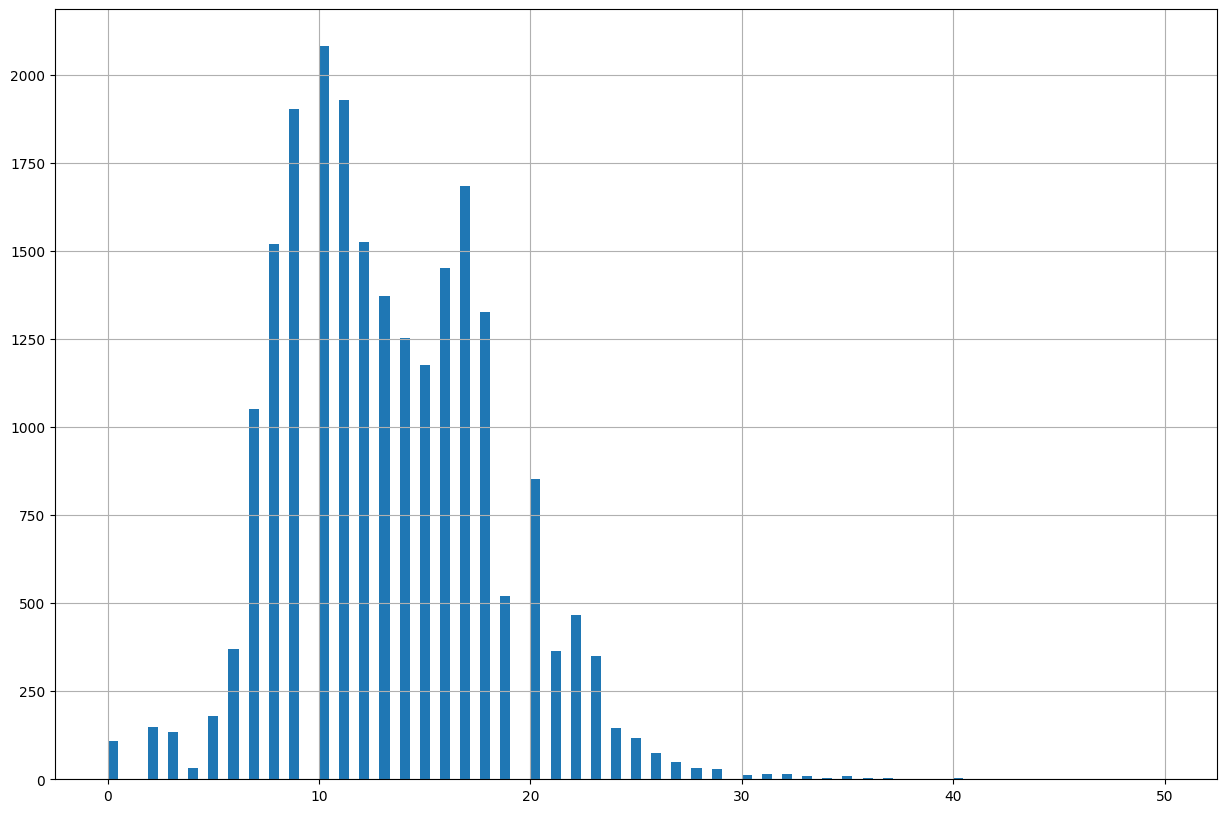

In [ ]:
df['Улица'].apply(lambda x: len(x)).hist(figsize=(15, 10), bins=105)

- Основная проблема с улицами это сокращение, типо Б. значит большая. Либо различные добавления, сокращения ул.-улица, либо совсем отсутсвие.

- Есть непонятные названия из 2, 3 букв. Похоже на какие то сокращения, но трудно определить что это. Придется удалять.

In [ ]:
df[df['Улица'].apply(lambda x: len(x))==3]

Город Метро Улица   Дом
6963        Химки         лиф     1
6964        Химки         лиф   2к1
7008        Химки         лиф     5
7010        Химки         лиф   8к2
7011        Химки         лиф   8к2
...           ...   ...   ...   ...
15823       Химки         нп      7
15824       Химки         лиф     1
15828       Химки         лиф     6
15867       Химки         лиф     1
16473  Зеленоград         кор  1544

[135 rows x 4 columns]

<Axes: >

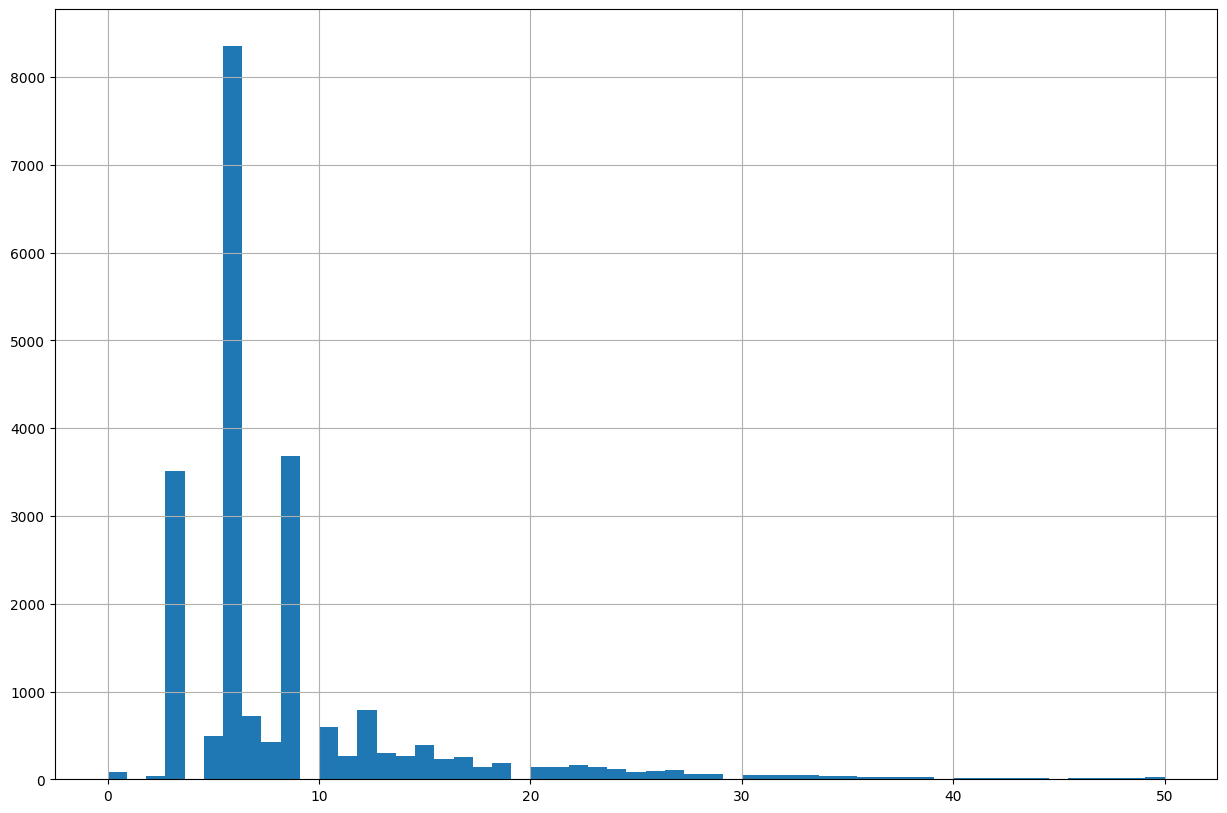

In [ ]:
df['Город'].apply(lambda x: len(x)).hist(figsize=(15, 10), bins=55)

- В городах длинный хвост, думаю от 12 букв по прикидкам нормального распределения, это все мусорные данные.

- Приблизительно кол-во строк на капитальную чистку для городов.

In [ ]:
len(df[df['Город'].apply(lambda x: len(x))>12])

3373

In [ ]:
print('Приблизительный процент мусорных данных в городах:', round(len(df[df['Город'].apply(lambda x: len(x))>12])/len(df)*100,2),'%')

Приблизительный процент мусорных данных в городах: 15.1 %


In [ ]:
df[df['Город'].apply(lambda x: len(x))>12]['Город'][:25]

11                           Жуковский 6сч
12                           Жуковский 4сч
16      Люберецкий район пос. октяборьский
18                       Москва акция 6 сч
22                           Жуковский 3сч
31                           Жуковский 4сч
32             Раменский р-н пос. островцы
40                        Москва акция 4сч
46                       Москва акция 4 сч
54                        Москва акция 6сч
57           Г люберцы поселок октябрьский
61                 Москва  пожелание 16 00
63                          Солнцево акция
75            Москва звонить несколько раз
82              Москва установка хвс, гшвс
106    Г. мытищи пос. паведники замена хвс
107                          Г. королев ск
108                          Лесные поляны
110            Мытищи поселок поведники ск
113                    Пушкино пос. лесной
120                      Москва акция 4 сч
126                       Москва акция 4сч
131                      Москва акция 4 сч
136        

# Обработка текста

- Часто встречающиеся слова.
- Создаю стоп слова из специфичных слов для данных.

In [ ]:
df['Город'].value_counts()

Мск ск                              4012
Москва                              3834
Мск                                 3510
Москва ск                           2185
Раменское                            411
                                    ... 
Мск поверка + опломб.                  1
Красногорск ск 4сч                     1
Балашиха замена 4сч метер              1
Мск первич. установка 2сч ителма       1
Д бородино                             1
Name: Город, Length: 2560, dtype: int64

In [ ]:
df['Улица'].value_counts()

проспект вернадского    195
солнечная               171
молодежная              162
приборостроителей       142
нп                      128
                       ... 
достоеского               1
мещанский переулок        1
1 хорошевский проезд      1
маршала баграмяна         1
чичюлина                  1
Name: Улица, Length: 6417, dtype: int64

Привожу к нижнему регистру

In [ ]:
df["Город2"] = df["Город"].apply(lambda x: " ".join(x.lower() for x in x.split()))
df["Улица2"] = df["Улица"].apply(lambda x: " ".join(x.lower() for x in x.split()))

Убираю пунктуацию

In [ ]:
df['Город2'] = df['Город2'].replace(r'[^\w\s]', ' ', regex=True)
df['Улица2'] = df['Улица2'].replace(r'[^\w\s]', ' ', regex=True)

Убираю цифры из города т к в наблюдаемых городах, их нет.

In [ ]:
df['Город2'] = df['Город2'].replace(r'\d', ' ', regex=True)

Убираю специализированные стоп слова для моего набора адресов.

In [ ]:
pd.Series(' '.join(df['Город2']).split()).value_counts().index[:50]

Index(['мск', 'ск', 'москва', 'сч', 'замена', 'химки', 'ярославль',
       'жуковский', 'раменское', 'щелково', 'половина', 'акция', 'акц',
       'после', 'до', 'с', 'утро', 'долгопрудный', 'хвс', 'мкр', 'установка',
       'электросталь', 'сходня', 'гвс', 'кинешма', 'балашиха', 'первая',
       'перенос', 'новая', 'пос', 'лесной', 'поверка', 'трехгорка', 'лобня',
       'люберцы', 'поселок', 'в', 'звонить', 'ч', 'вторая', 'хлебниково',
       'пломба', 'зеленоград', 'не', 'некрасовка', 'метер', 'ук', 'вечер',
       'красногорск', 'мытищи'],
      dtype='object')

In [ ]:
pattern = r'\b(ск|замена|акция|сч|акц|после|половина|до|утро|хвс|установка|гвс|первая|перенос|поверка|звонить|вторая|пломба|метер|вечер)\b'

for i, sentence in enumerate(df['Город2']):
    updated_sentence = re.sub(pattern, '', str(sentence))
    df.loc[i, 'Город2'] = updated_sentence

In [ ]:
pd.Series(' '.join(df['Улица2']).split()).value_counts().index[:50]

Index(['проспект', 'проезд', 'шоссе', 'бульвар', 'пр', 'большая', 'переулок',
       'вернадского', 'академика', 'маршала', 'улица', 'я', '3', '2', 'б', '1',
       'ленина', 'р', 'парковая', 'солнечная', 'ул', 'молодежная', 'й',
       'новоясеневский', 'ш', 'нп', 'волгоградский', 'приборостроителей',
       'пруды', 'набережная', 'борисовские', 'лиф', 'очаковская', 'ленинский',
       'мкр', 'профсоюзная', 'алтуфьевское', 'гагарина', 'литовский', 'кт',
       'пер', 'голубинская', 'анохина', 'свободы', 'рязанский', 'вал',
       'генерала', '4', 'дубнинская', 'чугунова'],
      dtype='object')

In [ ]:
pattern = r'\b(нп|лиф)\b'

for i, sentence in enumerate(df['Улица2']):
    updated_sentence = re.sub(pattern, '', str(sentence))
    df.loc[i, 'Улица2'] = updated_sentence

Добавляю лемитизацию и стеммер.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from textblob import Word

In [ ]:
df['Город2'] = df['Город2'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Улица2'] = df['Улица2'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
from nltk.stem import PorterStemmer
st = PorterStemmer()

In [ ]:
df['Город2'] = df['Город2'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['Улица2'] = df['Улица2'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [ ]:
df['Адрес'] = df['Город2'] + ', ' + df['Улица2']

In [ ]:
df['Адрес'].value_counts()

химки,                                         290
жуковский, солнечная                           159
мск, проспект вернадского                      145
раменское, молодежная                          134
раменское, приборостроителей                   130
                                              ... 
московский, микр 1                               1
москва магазин электромонтаж, проспект мира      1
москва, верх красносельская                      1
москва, больш черкизовская                       1
москва, ленинскийпросп                           1
Name: Адрес, Length: 7343, dtype: int64

In [ ]:
df.to_csv('Москва_обработка.csv', index=False)

### Загрузка данных, поиск данных.

- Очень сложно было в интернете найти готовые данные. Как вариант спарсить. Но проблема с парсингом возникала. Большинство сайтов это данные внутри данных. Надо очень заморочиться.

- Из интернета, чистые данные по городам Москвы и области, то что нашел.

- С работы дополнительные данные. Все что было по адресно, за все время. По сути адреса пополняются не часто. И уже в принципе есть своя устоявшаяся база.
Но минус, что данные по сути такие же грязные. Процентов 30% это грязные, не стандартизированные, даннные с ошибками.


In [ ]:
settlement = pd.read_csv('/content/drive/MyDrive/Методы анализа данных и машинного обучения /Проба/data.csv')
city_internet = settlement[settlement['region']=='Московская область']

city_internet = list(city_internet['settlement'].unique())

In [ ]:
df_all = pd.read_csv('/content/drive/MyDrive/Методы анализа данных и машинного обучения /Проба/all_adress.csv')

selected_regions = ['Москва г', 'Московская обл', 'Москва']
filtered_df = df_all.loc[df_all['AddressRegion'].isin(selected_regions)]

city_job = list(filtered_df['CacheHouseAddress'].str.split(', д.').str[0].unique().astype('str'))

In [ ]:
df_clean = pd.DataFrame(city_job)
df_clean = df_clean.rename(columns={0: 'Адрес'})
df_clean.to_csv('clean_adress.csv', index=False)

### База данных
- Данные из базы с работы. Накопленные за все время. По сути новые адреса здесь не так быстро появляются.
- тут видно, что почище данные.

- Но главный минус, который я в последний момент нашел - это что московскую область могут называть Москва и наоборот.

In [ ]:
df_all['CacheHouseAddress']=df_all['CacheHouseAddress'].astype('str')

In [ ]:
similar_phrases = {}
target_phrase = 'Мытищи'

for sentence in df_all['CacheHouseAddress']:
    words = sentence.split()
    j = 0
    while j < len(words):
        phrase = ' '.join(words[j:j+len(target_phrase.split())])
        similarity_ratio = SequenceMatcher(None, target_phrase, phrase).ratio()
        if similarity_ratio >= 0.9:
            similar_phrases[sentence] = similar_phrases.get(sentence, 0) + 1
            j += len(target_phrase.split())
        else:
            j += 1  # Move to the next word if the phrase is not found

# Print the found phrases and their frequency
for phrase, frequency in similar_phrases.items():
    print(f'Found: "{phrase}" (Frequency: {frequency})')

Found: "Московская обл, Мытищи г, Юбилейная ул, д. 38, К3" (Frequency: 1)
Found: "Московская обл, Мытищи г, Борисовка ул, д. 4" (Frequency: 1)
Found: "Московская обл, Мытищи г, Новомытищинский пр-кт, д. 62" (Frequency: 1)
Found: "Московская обл, Мытищи г, Лётная ул, д. 21/2" (Frequency: 1)
Found: "Московская обл, Мытищи г, Мира ул, д. 30" (Frequency: 1)
Found: "Московская обл, Мытищи г, Терешковой ул, д. 2" (Frequency: 2)
Found: "Московская обл, Мытищи г, Стрелковая ул, д. 6" (Frequency: 1)
Found: "Московская обл, Мытищи г, 2-я Институтская ул, д. 26А" (Frequency: 1)
Found: "Московская обл, Мытищи г, Станционная ул, д. 1, К1" (Frequency: 1)
Found: "Московская обл, Мытищи г, Тенистый б-р, д. 23" (Frequency: 1)
Found: "Московская обл, Мытищи г, Белобородова ул, д. 2, К3" (Frequency: 1)
Found: "Московская обл, Мытищи г" (Frequency: 3)
Found: "Московская обл, Мытищи г, Октябрьский пр-кт, д. 10А" (Frequency: 1)
Found: "Московская обл, Мытищи г, Станционная ул, д. 1, К2" (Frequency: 1)
Found

<Axes: >

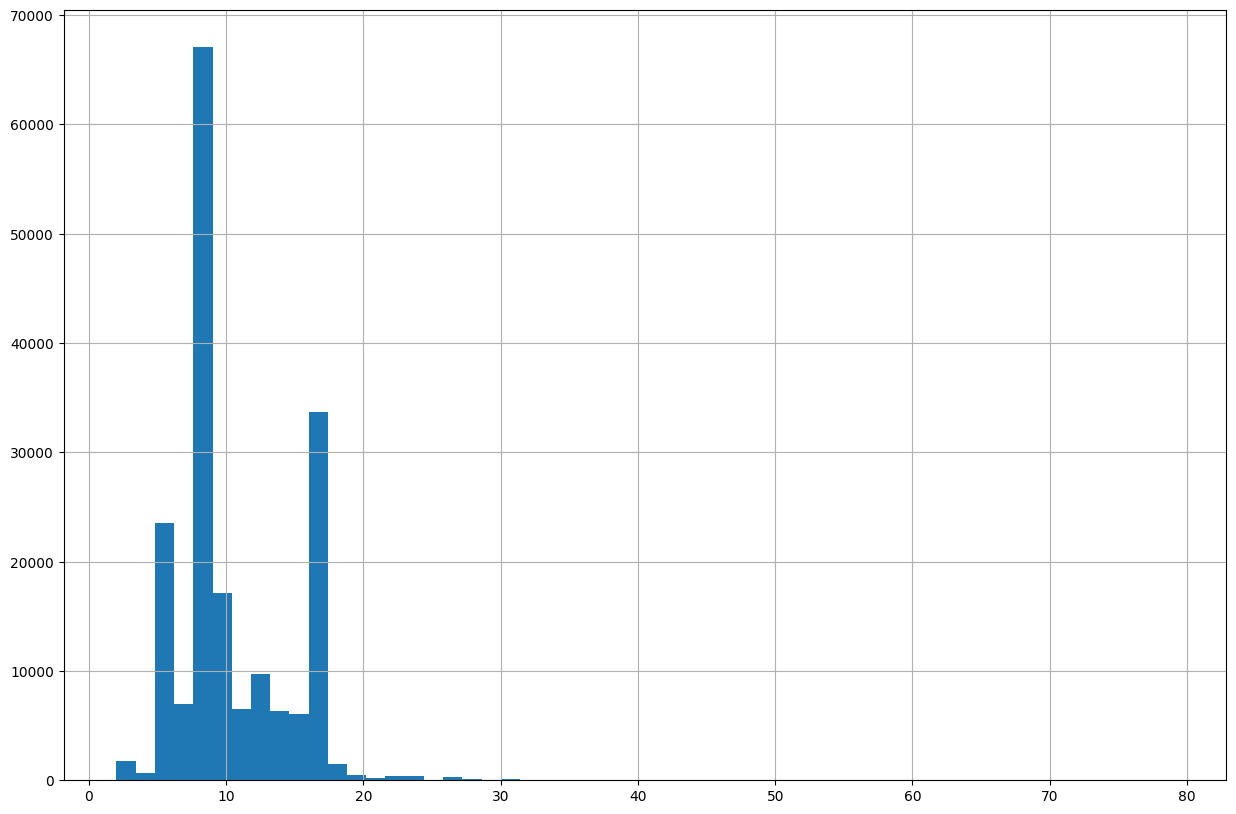

In [ ]:
df_all['AddressCity'].dropna().apply(lambda x: len(x)).hist(figsize=(15, 10), bins=55)

<Axes: >

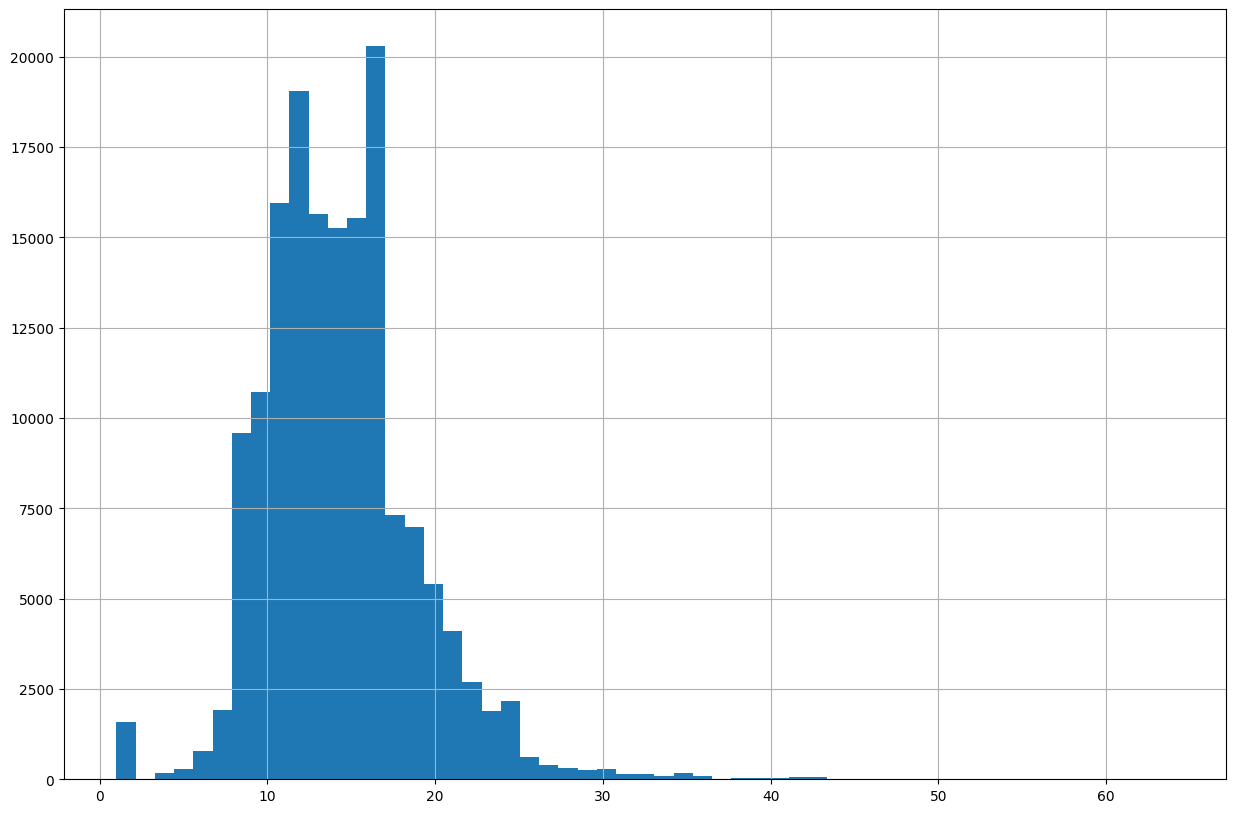

In [ ]:
df_all['AddressStreet'].dropna().apply(lambda x: len(x)).hist(figsize=(15, 10), bins=55)

# Нейронные сети. Self Attention

- Пробую сделать по принципу SelfAttention.

- Нашел такие советы:

Если вы хотите сравнить строки из двух списков и заменить строки в грязном списке, которые имеют достаточно сходство с чистым списком, вы можете воспользоваться алгоритмами обработки естественного языка (Natural Language Processing, NLP). Нейронные сети, такие как рекуррентные нейронные сети (RNN), сверточные нейронные сети (CNN) или трансформеры (Transformer), могут быть полезны для этой задачи.

Вот пример архитектуры, которую вы можете использовать:

Векторизация текста: Используйте метод векторизации, такой как TF-IDF или word2vec, чтобы представить строки в виде числовых векторов.

Модель сравнения: Используйте архитектуру нейронной сети для сравнения векторов строк. Вы можете применить слои сети, такие как полносвязные слои, сверточные слои или слои само-внимания (self-attention), чтобы извлечь семантические особенности из векторов строк.

Функция потерь: Определите функцию потерь, которая будет оценивать сходство между строками. Например, можно использовать косинусное расстояние или среднеквадратичную ошибку.

Обучение модели: Обучите модель на парах строк из чистого и грязного списка, используя функцию потерь для оптимизации весов модели.

Применение модели: После обучения модели вы можете использовать ее для сравнения строк из грязного списка с чистым списком. Если сходство между строками превышает заданный порог, замените строку в грязном списке на соответствующую строку из чистого списка.

Помимо нейронных сетей, вы также можете рассмотреть алгоритмы сопоставления строк, такие как алгоритм Левенштейна или сравнение последовательностей (Sequence Matcher). Эти алгоритмы могут быть эффективными для сравнения и сопоставления строк, но они не требуют обучения моделей.

Выбор конкретной модели зависит от вашего конкретного набора данных и требований к точности и производительности. Рекомендуется начать с простых моделей, таких как полносвязные нейронные сети, и постепенно усложнять модель при необходимости.

### Обработка по частям, адресов.
- Город самая грязная часть. Улицы в этом плане почище.
-  Т к все вместе сложнее получается обрабатывать.

Так как данные по городу внутри содержат лишь около 15% грязных данных, пробую замкнуть все на проверку внутри себя.

- векторизатор CountVectorizer
- loss = -torch.max(output)  # Максимизируем значение максимального сходства
- метрика качества accuracy

In [ ]:
class SelfAttention(nn.Module):
    '''
    class of the attention module in a neural network
    '''
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output

def self_attention(column):
    '''
    implements a self-aware model that learns from text data
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Предварительная обработка текста и преобразование в числовые векторы
    vectorizer = CountVectorizer()
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    # Преобразование данных в тензоры PyTorch
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)  # Добавляем размерность "батч"

    # Создание и обучение модели с само-вниманием
    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    batch_size = 10
    num_batches = data.shape[0] // batch_size

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        correct_predictions = 0

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = -torch.max(output)  # Максимизируем значение максимального сходства
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Расчет точности предсказаний
            predicted_indices = output.argmax(dim=1)
            correct_predictions += torch.sum(predicted_indices == batch_idx).item()

        accuracy = correct_predictions / data.shape[0]

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches, 'Accuracy': accuracy})

    # Получение выходных значений модели
    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    # Обратное преобразование в города
    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output

# Применяем self-attention к столбцу 'Город2'
column = df['Город2']

# Вызываем функцию self_attention с использованием tqdm
column = self_attention(column)

df['Город_результат'] = column

Обучение модели: 100%|██████████| 10/10 [00:54<00:00,  5.41s/it, Loss=-1, Accuracy=0.489]


- векторизатор TfidfVectorizer
- MSE loss
- метрика качества cosine_similarity

In [ ]:
class SelfAttention(nn.Module):
    '''
    class of the attention module in a neural network
    '''
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output

def self_attention(column):
    '''
    implements a self-aware model that learns from text data
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Предварительная обработка текста и преобразование в числовые векторы
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Add n-gram range
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    # Преобразование данных в тензоры PyTorch
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)  # Добавляем размерность "батч"

    # Создание и обучение модели с само-вниманием
    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    num_epochs = 20
    batch_size = 32
    num_batches = data.shape[0] // batch_size

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        cosine_similarity_sum = 0.0

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = F.mse_loss(output, torch.zeros_like(output))  # MSE loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Расчет средней косинусной меры
            output_reshaped = output.squeeze(1).detach().cpu().numpy()
            data_reshaped = data[start_idx:end_idx].squeeze(1).detach().cpu().numpy()
            similarity = cosine_similarity(output_reshaped, data_reshaped)
            cosine_similarity_sum += similarity.mean()

        average_cosine_similarity = cosine_similarity_sum / num_batches

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches, 'Cosine Similarity': average_cosine_similarity})

    # Получение выходных значений модели
    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    # Обратное преобразование в города
    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output, average_cosine_similarity

# Применяем self-attention к столбцу 'Город2'
column = df['Город2']

# Вызываем функцию self_attention с использованием tqdm
column, cosine_similarity = self_attention(column)

df['Город_результат'] = column

print('Average Cosine Similarity:', cosine_similarity)

Обучение модели: 100%|██████████| 20/20 [02:23<00:00,  7.19s/it, Loss=0.000356, Cosine Similarity=0.567]


Average Cosine Similarity: 0.567145927331509


In [ ]:
df['Город_результат'].value_counts()

мск                9624
москва             6637
ярославль           485
жуковский           469
раменское           457
                   ... 
красково              1
малаховка мэс         1
мск срочно            1
сходня голиково       1
бородино              1
Name: Город_результат, Length: 1189, dtype: int64

- CosineAnnealingLR,
- TfidfVectorizer(ngram_range=(1, 3)),
- и больше эпох

In [ ]:
class SelfAttention(nn.Module):
    '''
    class of the attention module in a neural network
    '''
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output

def self_attention(column):
    '''
    implements a self-aware model that learns from text data
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Предварительная обработка текста и преобразование в числовые векторы
    vectorizer = TfidfVectorizer()  # Add n-gram range
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    # Преобразование данных в тензоры PyTorch
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)  # Добавляем размерность "батч"

    # Создание и обучение модели с само-вниманием
    num_epochs = 20  # Переместить инициализацию сюда
    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  # Инициализация CosineAnnealingLR

    batch_size = 32
    num_batches = data.shape[0] // batch_size

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        cosine_similarity_sum = 0.0

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = F.mse_loss(output, torch.zeros_like(output))  # MSE loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Расчет средней косинусной меры
            output_reshaped = output.squeeze(1).detach().cpu().numpy()
            data_reshaped = data[start_idx:end_idx].squeeze(1).detach().cpu().numpy()
            similarity = cosine_similarity(output_reshaped, data_reshaped)
            cosine_similarity_sum += similarity.mean()

        average_cosine_similarity = cosine_similarity_sum / num_batches

        scheduler.step()  # Обновление скорости обучения с помощью scheduler

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches, 'Cosine Similarity': average_cosine_similarity})

    # Получение выходных значений модели
    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    # Обратное преобразование в города
    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output, average_cosine_similarity

# Применяем self-attention к столбцу 'Город2'
column = df['Город2']

# Вызываем функцию self_attention с использованием tqdm
column, cosine_similarity = self_attention(column)

df['Город_результат'] = column

print('Average Cosine Similarity:', cosine_similarity)

Обучение модели: 100%|██████████| 20/20 [00:54<00:00,  2.71s/it, Loss=0.000911, Cosine Similarity=0.571]

Average Cosine Similarity: 0.5714483702379175


In [ ]:
df['Город_результат'].value_counts()

мск          9624
москва       6637
ярославль     485
жуковский     469
раменское     457
             ... 
момсква         1
москав          1
регистр         1
химия           1
бородино        1
Name: Город_результат, Length: 853, dtype: int64

Не беру в расчет низкочастотные встречания слов

In [ ]:
class SelfAttention(nn.Module):
    '''
    class of the attention module in a neural network
    '''
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output

def self_attention(column):
    '''
    implements a self-aware model that learns from text data
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Предварительная обработка текста и преобразование в числовые векторы
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)  # Add n-gram range and min_df parameter
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    # Преобразование данных в тензоры PyTorch
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)  # Добавляем размерность "батч"

    # Создание и обучение модели с само-вниманием
    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    num_epochs = 20
    batch_size = 32
    num_batches = data.shape[0] // batch_size

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        cosine_similarity_sum = 0.0

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = F.mse_loss(output, torch.zeros_like(output))  # MSE loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Расчет средней косинусной меры
            output_reshaped = output.squeeze(1).detach().cpu().numpy()
            data_reshaped = data[start_idx:end_idx].squeeze(1).detach().cpu().numpy()
            similarity = cosine_similarity(output_reshaped, data_reshaped)
            cosine_similarity_sum += similarity.mean()

        average_cosine_similarity = cosine_similarity_sum / num_batches

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches, 'Cosine Similarity': average_cosine_similarity})

    # Получение выходных значений модели
    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    # Обратное преобразование в города
    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output, average_cosine_similarity

# Применяем self-attention к столбцу 'Город2'
column = df['Город2']

# Вызываем функцию self_attention с использованием tqdm
column, cosine_similarity = self_attention(column)

df['Город_результат'] = column

print('Average Cosine Similarity:', cosine_similarity)


Обучение модели: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it, Loss=0.00105, Cosine Similarity=0.573]


Average Cosine Similarity: 0.5728693772694443


In [ ]:
df['Город_результат'].value_counts()

мск               9682
москва            6662
ярославль          494
жуковский          469
раменское          457
                  ... 
за час               1
мск заказ            1
работают             1
част                 1
поверки пломбы       1
Name: Город_результат, Length: 668, dtype: int64

### Сравнение со списком городов из интернета
- что удалось найти в интернете. Готовый неплохой список по городам.

In [ ]:
class SelfAttention(nn.Module):
    '''
    class of the attention module in a neural network
    '''
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output

def self_attention(column):
    '''
    implements a self-aware model that learns from text data
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Предварительная обработка текста и преобразование в числовые векторы
    vectorizer = TfidfVectorizer()
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    # Преобразование данных в тензоры PyTorch
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)  # Добавляем размерность "батч"

    # Создание и обучение модели с само-вниманием
    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5  # Увеличение количества эпох
    batch_size = 32  # Увеличение размера батча
    num_batches = data.shape[0] // batch_size

    num_steps = 100  # Количество шагов обучения в каждой эпохе
    total_steps = num_epochs * num_steps
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = F.mse_loss(output, torch.zeros_like(output))  # MSE loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            scheduler.step()  # Обновление темпа обучения

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches})

    # Получение выходных значений модели
    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    # Обратное преобразование в города
    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output

# Уникальный список городов
unique_cities = city_internet

# Функция для замены значений в столбце
def replace_with_most_similar(value, unique_list):
    '''
    Look for the most matching value
    '''
    # Ищем наиболее совпадающее значение
    most_similar = difflib.get_close_matches(value, unique_list, n=1)
    if most_similar:
        return most_similar[0]
    else:
        return ""

# Применяем self-attention к столбцу 'Город2'
column = df['Город2']
column = self_attention(column)

# Замена значений в столбце с прогресс-баром
progress_bar = tqdm(total=len(column), desc='Замена значений')
for i in range(len(column)):
    column[i] = replace_with_most_similar(column[i], unique_cities)
    progress_bar.update(1)
progress_bar.close()

# Обновленные значения в столбце
df['Город_результат'] = column

# Вычисление качества метрики (косинусное расстояние)
vectorizer = TfidfVectorizer()
embeddings_clean = vectorizer.fit_transform(city_internet).toarray()
embeddings_dirty = vectorizer.transform(df['Город_результат']).toarray()

cosine_similarities = []
for emb_clean, emb_dirty in zip(embeddings_clean, embeddings_dirty):
    similarity = cosine_similarity([emb_clean], [emb_dirty])[0][0]
    cosine_similarities.append(similarity)

average_similarity = sum(cosine_similarities) / len(cosine_similarities)

print("Average Similarity:", average_similarity)




Обучение модели: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it, Loss=0.000911]

Замена значений:   0%|          | 96/22342 [01:37<6:14:50,  1.01s/it]

Замена значений: 100%|██████████| 22342/22342 [05:55<00:00, 62.93it/s]


Average Similarity: 0.00023724792408066428


In [ ]:
df['Город_результат'].value_counts()

Ямская       9641
Московка     6682
              830
Жуковский     506
Буславль      487
             ... 
Лоза            1
Васютино        1
Каргашино       1
Кутачи          1
Бородино        1
Name: Город_результат, Length: 411, dtype: int64

### Сравнивнение грязных полных адресов, город+улица с адресами из базы данных с работы.

- Т к данные особо быстро не прибавляются в плане своей уникальности. Уже есть набор адресов которые в большей степени повторяются.

In [ ]:
class SelfAttention(nn.Module):
    '''
    class of the attention module in a neural network
    '''
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output

def self_attention(column):
    '''
    implements a self-aware model that learns from text data
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Предварительная обработка текста и преобразование в числовые векторы
    vectorizer = TfidfVectorizer()
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    # Преобразование данных в тензоры PyTorch
    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)  # Добавляем размерность "батч"

    # Создание и обучение модели с само-вниманием
    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5  # Увеличение количества эпох
    batch_size = 8  # Увеличение размера батча
    num_batches = data.shape[0] // batch_size

    num_steps = 100  # Количество шагов обучения в каждой эпохе
    total_steps = num_epochs * num_steps

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = torch.mean((output - data[start_idx:end_idx]) ** 2)  # MSE
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches})

    # Получение выходных значений модели
    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    # Обратное преобразование в города
    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output

# Уникальный список городов
unique_cities = city_job

# Функция для замены значений в столбце
def replace_with_most_similar(value, unique_list):
    '''
    Look for the most matching value
    '''
    # Ищем наиболее совпадающее значение
    most_similar = difflib.get_close_matches(value, unique_list, n=1)
    if most_similar:
        return most_similar[0]
    else:
        return ""

# Применяем self-attention к столбцу 'Город2'
column = df['Адрес']
output = self_attention(column)

# Замена значений в столбце с прогресс-баром
progress_bar = tqdm(total=len(output), desc='Замена значений')
correct_predictions = 0
for i in range(len(output)):
    predicted_city = replace_with_most_similar(output[i], unique_cities)
    column[i] = predicted_city
    if predicted_city == df['Адрес'][i]:
        correct_predictions += 1

    # Вывод оригинального значения и замены
    print("Оригинал: ", df['Адрес'][i])
    print("Замена: ", predicted_city)
    print("------------------------")

    progress_bar.update(1)
progress_bar.close()

# Вычисление косинусного расстояния между предсказанными значениями и уникальными значениями
try:
    similarity_scores = cosine_similarity(output, unique_cities)
except ValueError:
    # Обработка ошибки
    print("Ошибка при вычислении косинусного расстояния")

# Обновленные значения в столбце
df['Адрес_результат'] = df['Адрес']

# Вычисление точности (accuracy)
accuracy = correct_predictions / len(output)
print("Accuracy:", accuracy)

Замена значений:   0%|          | 9/22342 [00:00<05:10, 71.91it/s]

Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смирновская
Замена:  г.Москва, Смирновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:   0%|          | 23/22342 [00:00<06:49, 54.48it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:   0%|          | 29/22342 [00:00<08:52, 41.87it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   0%|          | 39/22342 [00:00<08:33, 43.43it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:   0%|          | 52/22342 [00:01<07:00, 53.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:   0%|          | 63/22342 [00:01<08:32, 43.44it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  г.Москва, Марксистская
Замена:  г.Москва, Марксистская
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------


Замена значений:   0%|          | 73/22342 [00:01<08:33, 43.40it/s]

Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   0%|          | 83/22342 [00:01<08:36, 43.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   0%|          | 88/22342 [00:01<09:10, 40.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Доброслободская
Замена:  г.Москва, Доброслободская
------------------------


Замена значений:   0%|          | 99/22342 [00:02<09:39, 38.42it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------


Замена значений:   0%|          | 111/22342 [00:02<08:22, 44.21it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 116/22342 [00:02<08:21, 44.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 126/22342 [00:02<09:24, 39.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------


Замена значений:   1%|          | 136/22342 [00:03<09:32, 38.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Переведеновский
Замена:  г.Москва, Переведеновский
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:   1%|          | 140/22342 [00:03<10:35, 34.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 151/22342 [00:03<09:07, 40.53it/s]

Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------


Замена значений:   1%|          | 161/22342 [00:03<08:47, 42.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 166/22342 [00:03<08:47, 42.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:   1%|          | 177/22342 [00:04<09:23, 39.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  

Замена значений:   1%|          | 189/22342 [00:04<08:16, 44.60it/s]

г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Шмитовский
Замена:  г.Москва, Шмитовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Железнодорожная ул
Замена:  г.Москва, Железнодорожная ул
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------


Замена значений:   1%|          | 194/22342 [00:04<09:15, 39.87it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 203/22342 [00:05<12:05, 30.53it/s]

Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Дегунинская
Замена:  г.Москва, Дегунинская
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:   1%|          | 213/22342 [00:05<09:59, 36.92it/s]

Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 225/22342 [00:05<07:52, 46.80it/s]

Оригинал:  г.Москва, Таганрогская
Замена:  г.Москва, Таганрогская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------


Замена значений:   1%|          | 231/22342 [00:05<09:15, 39.78it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:   1%|          | 240/22342 [00:05<10:59, 33.54it/s]

Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дорогобужская
Замена:  г.Москва, Дорогобужская
------------------------


Замена значений:   1%|          | 245/22342 [00:06<09:57, 36.95it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Вересковая ул
Замена:  г.Москва, Вересковая ул
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:   1%|          | 255/22342 [00:06<09:52, 37.30it/s]

Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Коктебельская
Замена:  г.Москва, Коктебельская
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сочинская
Замена:  г.Москва, Сочинская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:   1%|          | 266/22342 [00:06<09:31, 38.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 272/22342 [00:06<09:50, 37.35it/s]

Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|          | 276/22342 [00:07<12:35, 29.21it/s]

Оригинал:  г.Москва, Глинищевский пер
Замена:  г.Москва, Глинищевский пер
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 280/22342 [00:07<13:23, 27.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 283/22342 [00:07<15:41, 23.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 286/22342 [00:07<16:48, 21.87it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 294/22342 [00:08<18:18, 20.07it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------
Оригинал:  г.Москва, Рогачевский
Замена:  г.Москва, Рогачевский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 298/22342 [00:08<17:10, 21.39it/s]

Оригинал:  г.Москва, Образцова
Замена:  г.Москва, Образцова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Международная
Замена:  г.Москва, Международная
------------------------
Оригинал:  г.Москва, Южнопортовая
Замена:  г.Москва, Южнопортовая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 305/22342 [00:08<14:29, 25.34it/s]

Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  

Замена значений:   1%|▏         | 311/22342 [00:08<16:05, 22.83it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 315/22342 [00:08<14:26, 25.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   1%|▏         | 321/22342 [00:09<15:07, 24.28it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------


Замена значений:   1%|▏         | 324/22342 [00:09<17:28, 20.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Оренбургская
Замена:  г.Москва, Оренбургская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:   1%|▏         | 327/22342 [00:09<18:14, 20.12it/s]

Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  г.Москва, Оршанская
Замена:  г.Москва, Оршанская
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:   1%|▏         | 330/22342 [00:09<18:49, 19.49it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:   2%|▏         | 337/22342 [00:10<18:46, 19.54it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:   2%|▏         | 343/22342 [00:10<19:24, 18.89it/s]

Оригинал:  г.Москва, Партизанская
Замена:  г.Москва, Партизанская
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 346/22342 [00:10<19:40, 18.63it/s]

Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 350/22342 [00:10<21:17, 17.21it/s]

Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Старобитцевская ул
Замена:  г.Москва, Старобитцевская ул
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:   2%|▏         | 357/22342 [00:10<15:46, 23.24it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сочинская
Замена:  г.Москва, Сочинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 368/22342 [00:11<10:38, 34.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------


Замена значений:   2%|▏         | 372/22342 [00:11<10:32, 34.76it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Земледельческий пер
Замена:  г.Москва, Земледельческий пер
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------


Замена значений:   2%|▏         | 376/22342 [00:11<13:29, 27.15it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 384/22342 [00:11<12:46, 28.65it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Образцова
Замена:  г.Москва, Образцова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------


Замена значений:   2%|▏         | 393/22342 [00:12<11:08, 32.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 401/22342 [00:12<10:39, 34.30it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Климашкина
Замена:  г.Москва, Климашкина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------


Замена значений:   2%|▏         | 411/22342 [00:12<09:50, 37.14it/s]

Оригинал:  г.Москва, Красногорская МЦД
Замена:  г.Москва, Красногорская МЦД
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Добролюбова
Замена:  г.Москва, Добролюбова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 421/22342 [00:12<09:02, 40.38it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрелецкая
Замена:  г.Москва, Стрелецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------


Замена значений:   2%|▏         | 426/22342 [00:12<08:47, 41.54it/s]

Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вересковая ул
Замена:  г.Москва, Вересковая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Преображенская
Замена:  г.Москва, Преображенская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 431/22342 [00:13<09:45, 37.43it/s]

Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 439/22342 [00:13<13:08, 27.78it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:   2%|▏         | 446/22342 [00:13<16:36, 21.97it/s]

Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 452/22342 [00:14<15:15, 23.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ватутина
Замена:  г.Москва, Ватутина
------------------------


Замена значений:   2%|▏         | 459/22342 [00:14<14:21, 25.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------


Замена значений:   2%|▏         | 462/22342 [00:14<14:06, 25.84it/s]

Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 469/22342 [00:14<13:50, 26.34it/s]

Оригинал:  г.Москва, Федоскинская
Замена:  г.Москва, Федоскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:   2%|▏         | 476/22342 [00:14<12:22, 29.45it/s]

г.Москва, Дегунинская
Замена:  г.Москва, Дегунинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------


Замена значений:   2%|▏         | 480/22342 [00:15<14:32, 25.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Скаковая
Замена:  г.Москва, Скаковая
------------------------
Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------


Замена значений:   2%|▏         | 483/22342 [00:15<18:40, 19.50it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 487/22342 [00:15<17:40, 20.61it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 495/22342 [00:15<14:01, 25.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Окружная
Замена:  г.Москва, Окружная
------------------------


Замена значений:   2%|▏         | 498/22342 [00:16<16:45, 21.73it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 504/22342 [00:16<18:09, 20.04it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Касимовская
Замена:  г.Москва, Касимовская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:   2%|▏         | 511/22342 [00:16<15:55, 22.85it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 514/22342 [00:16<15:16, 23.83it/s]

Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------


Замена значений:   2%|▏         | 520/22342 [00:17<17:59, 20.22it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Садовническая ул
Замена:  г.Москва, Садовническая ул
------------------------


Замена значений:   2%|▏         | 528/22342 [00:17<13:17, 27.35it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   2%|▏         | 541/22342 [00:17<09:00, 40.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:   2%|▏         | 551/22342 [00:17<09:27, 38.43it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый


Замена значений:   2%|▏         | 557/22342 [00:17<08:23, 43.25it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------


Замена значений:   3%|▎         | 567/22342 [00:18<09:56, 36.49it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 575/22342 [00:18<10:20, 35.09it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Вересковая ул
Замена:  г.Москва, Вересковая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------


Замена значений:   3%|▎         | 583/22342 [00:18<10:48, 33.53it/s]

Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 591/22342 [00:19<10:06, 35.85it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Краснопресненская наб
Замена:  г.Москва, Краснопресненская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 601/22342 [00:19<08:44, 41.45it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 607/22342 [00:19<08:20, 43.44it/s]

Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------


Замена значений:   3%|▎         | 621/22342 [00:19<07:57, 45.50it/s]

Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 632/22342 [00:19<07:53, 45.82it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэропорта
Замена:  г.Москва, Аэропорта
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 642/22342 [00:20<07:51, 46.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мастеровая
Замена:  г.Москва, Мастеровая
------------------------
Оригинал:  г.Москва, Мастеровая
Замена:  г.Москва, Мастеровая
------------------------


Замена значений:   3%|▎         | 652/22342 [00:20<07:52, 45.86it/s]

Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:   3%|▎         | 664/22342 [00:20<07:20, 49.20it/s]

Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Штурвальная
Замена:  г.Москва, Штурвальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 674/22342 [00:20<08:19, 43.42it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Сочинская
Замена:  г.Москва, Сочинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 679/22342 [00:21<10:33, 34.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 687/22342 [00:21<11:46, 30.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------


Замена значений:   3%|▎         | 691/22342 [00:21<11:22, 31.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------


Замена значений:   3%|▎         | 695/22342 [00:21<15:25, 23.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маломосковская
Замена:  г.Москва, Маломосковская
------------------------


Замена значений:   3%|▎         | 698/22342 [00:21<15:44, 22.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------


Замена значений:   3%|▎         | 704/22342 [00:22<16:37, 21.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 710/22342 [00:22<16:28, 21.88it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 716/22342 [00:22<15:06, 23.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:   3%|▎         | 720/22342 [00:22<13:45, 26.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 727/22342 [00:23<15:09, 23.76it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:   3%|▎         | 730/22342 [00:23<16:32, 21.79it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------


Замена значений:   3%|▎         | 737/22342 [00:23<16:16, 22.12it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------


Замена значений:   3%|▎         | 740/22342 [00:23<16:23, 21.97it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------


Замена значений:   3%|▎         | 748/22342 [00:24<14:09, 25.43it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  г.Москва, Вишневая
Замена:  г.Москва, Вишневая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 760/22342 [00:24<09:26, 38.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   3%|▎         | 765/22342 [00:24<08:54, 40.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------


Замена значений:   3%|▎         | 770/22342 [00:24<10:04, 35.69it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------


Замена значений:   3%|▎         | 778/22342 [00:24<13:03, 27.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▎         | 790/22342 [00:25<09:12, 39.01it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судакова
Замена:  г.Москва, Судакова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▎         | 795/22342 [00:25<09:45, 36.81it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена: 

Замена значений:   4%|▎         | 805/22342 [00:25<09:01, 39.81it/s]

 
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Высоковольтный проезд
Замена:  г.Москва, Высоковольтный проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▎         | 816/22342 [00:25<08:18, 43.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▎         | 827/22342 [00:26<07:44, 46.28it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------


Замена значений:   4%|▎         | 832/22342 [00:26<08:13, 43.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 841/22342 [00:26<09:50, 36.40it/s]

Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:   4%|▍         | 845/22342 [00:26<11:59, 29.87it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------


Замена значений:   4%|▍         | 854/22342 [00:26<11:16, 31.77it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 864/22342 [00:27<09:50, 36.39it/s]

Оригинал:  г.Москва, стандартная
Замена:  г.Москва, стандартная
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 868/22342 [00:27<09:46, 36.60it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 877/22342 [00:27<10:47, 33.13it/s]

Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 885/22342 [00:27<12:12, 29.30it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новослободская
Замена:  г.Москва, Новослободская
------------------------


Замена значений:   4%|▍         | 897/22342 [00:28<09:10, 38.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:   4%|▍         | 903/22342 [00:28<08:38, 41.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смирновская
Замена:  г.Москва, Смирновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 914/22342 [00:28<08:26, 42.32it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 919/22342 [00:28<08:29, 42.04it/s]

Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 924/22342 [00:28<12:04, 29.56it/s]

Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------


Замена значений:   4%|▍         | 935/22342 [00:29<10:07, 35.21it/s]

Оригинал:  г.Москва, Наставнический пер
Замена:  г.Москва, Наставнический пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кравченко
Замена:  г.Москва, Кравченко
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сочинская
Замена:  г.Москва, Сочинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 945/22342 [00:29<08:50, 40.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:   4%|▍         | 957/22342 [00:29<07:42, 46.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шмитовский
Замена:  г.Москва, Шмитовский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 964/22342 [00:29<07:21, 48.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Машиностроения 2-я
Замена:  г.Москва, Машиностроения 2-я
------------------------


Замена значений:   4%|▍         | 975/22342 [00:30<09:03, 39.29it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:   4%|▍         | 985/22342 [00:30<09:01, 39.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Николоямский
Замена:  г.Москва, Николоямский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   4%|▍         | 990/22342 [00:30<09:17, 38.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фортунатовская
Замена:  г.Москва, Фортунатовская
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:   4%|▍         | 1002/22342 [00:30<07:38, 46.57it/s]

Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Вишневая
Замена:  г.Москва, Вишневая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:   5%|▍         | 1014/22342 [00:31<07:17, 48.71it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▍         | 1019/22342 [00:31<07:28, 47.56it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Дмитровский
Замена:  г.Москва, Дмитровский
------------------------
Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------


Замена значений:   5%|▍         | 1030/22342 [00:31<08:29, 41.83it/s]

Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▍         | 1040/22342 [00:31<09:39, 36.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская
------------------------


Замена значений:   5%|▍         | 1044/22342 [00:31<10:48, 32.83it/s]

Оригинал:  г.Москва, Чистопольская
Замена:  г.Москва, Чистопольская
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:   5%|▍         | 1057/22342 [00:32<07:50, 45.21it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  г.Москва, Васильевская
Замена:  г.Москва, Васильевская
------------------------


Замена значений:   5%|▍         | 1067/22342 [00:32<08:53, 39.85it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Сеславинская
Замена:  г.Москва, Сеславинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▍         | 1072/22342 [00:32<09:00, 39.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маленковская
Замена:  г.Москва, Маленковская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------


Замена значений:   5%|▍         | 1083/22342 [00:32<07:56, 44.63it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▍         | 1093/22342 [00:33<08:56, 39.63it/s]

Оригинал:  г.Москва, Долгоруковская ул
Замена:  г.Москва, Долгоруковская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▍         | 1105/22342 [00:33<07:58, 44.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▍         | 1115/22342 [00:33<08:33, 41.30it/s]

Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1128/22342 [00:33<06:59, 50.61it/s]

Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1134/22342 [00:33<07:13, 48.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дружинниковская ул
Замена:  г.Москва, Дружинниковская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1145/22342 [00:34<07:19, 48.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1156/22342 [00:34<07:31, 46.93it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серебрякова
Замена:  г.Москва, Серебрякова
------------------------


Замена значений:   5%|▌         | 1166/22342 [00:34<08:17, 42.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:   5%|▌         | 1177/22342 [00:34<07:58, 44.24it/s]

Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1187/22342 [00:35<08:20, 42.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------


Замена значений:   5%|▌         | 1192/22342 [00:35<10:30, 33.56it/s]

Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------


Замена значений:   5%|▌         | 1196/22342 [00:35<12:23, 28.45it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Сивашская
Замена:  г.Москва, Сивашская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1204/22342 [00:35<12:47, 27.55it/s]

Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:   5%|▌         | 1208/22342 [00:36<14:17, 24.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------


Замена значений:   5%|▌         | 1212/22342 [00:36<15:49, 22.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------


Замена значений:   5%|▌         | 1218/22342 [00:36<15:05, 23.32it/s]

Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   5%|▌         | 1222/22342 [00:36<13:27, 26.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1229/22342 [00:36<12:16, 28.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1235/22342 [00:37<14:26, 24.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------


Замена значений:   6%|▌         | 1239/22342 [00:37<12:57, 27.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1245/22342 [00:37<16:45, 20.98it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------


Замена значений:   6%|▌         | 1252/22342 [00:37<15:14, 23.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1261/22342 [00:38<11:37, 30.21it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1270/22342 [00:38<17:08, 20.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подмосковная
Замена:  г.Москва, Подмосковная
------------------------


Замена значений:   6%|▌         | 1274/22342 [00:38<15:51, 22.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:   6%|▌         | 1280/22342 [00:39<15:58, 21.97it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------


Замена значений:   6%|▌         | 1287/22342 [00:39<11:55, 29.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:   6%|▌         | 1297/22342 [00:39<09:39, 36.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1305/22342 [00:39<11:44, 29.86it/s]

Оригинал:  г.Москва, Старокачаловская
Замена:  г.Москва, Старокачаловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1309/22342 [00:40<12:45, 27.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------


Замена значений:   6%|▌         | 1321/22342 [00:40<08:52, 39.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:   6%|▌         | 1331/22342 [00:40<08:43, 40.17it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1342/22342 [00:40<07:49, 44.73it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1353/22342 [00:41<07:20, 47.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1363/22342 [00:41<08:07, 42.99it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1375/22342 [00:41<07:01, 49.79it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▌         | 1381/22342 [00:41<08:02, 43.44it/s]

Оригинал:  г.Москва, Электрозаводская
Замена:  г.Москва, Электрозаводская
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:   6%|▌         | 1391/22342 [00:41<08:37, 40.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▋         | 1402/22342 [00:42<07:55, 44.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▋         | 1408/22342 [00:42<07:51, 44.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------


Замена значений:   6%|▋         | 1418/22342 [00:42<09:42, 35.90it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:   6%|▋         | 1424/22342 [00:42<08:45, 39.84it/s]


------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------


Замена значений:   6%|▋         | 1434/22342 [00:43<09:16, 37.56it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   6%|▋         | 1444/22342 [00:43<08:22, 41.58it/s]

Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кравченко
Замена:  г.Москва, Кравченко
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:   7%|▋         | 1456/22342 [00:43<07:04, 49.18it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1462/22342 [00:43<08:58, 38.77it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1472/22342 [00:43<08:30, 40.88it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Автомоторная ул
Замена:  г.Москва, Автомоторная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1480/22342 [00:44<06:58, 49.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1491/22342 [00:44<08:31, 40.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1496/22342 [00:44<09:12, 37.73it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:   7%|▋         | 1507/22342 [00:44<08:56, 38.86it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Стрелецкая
Замена:  г.Москва, Стрелецкая
------------------------


Замена значений:   7%|▋         | 1520/22342 [00:45<07:13, 48.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1526/22342 [00:45<09:35, 36.16it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1536/22342 [00:45<09:00, 38.51it/s]

Оригинал:  г.Москва, Мелитопольская ул
Замена:  г.Москва, Мелитопольская ул
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1549/22342 [00:45<07:13, 47.93it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1556/22342 [00:45<06:34, 52.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Осташковская
Замена:  г.Москва, Осташковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------


Замена значений:   7%|▋         | 1567/22342 [00:46<07:31, 46.03it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенский
Замена:  г.Москва, Коломенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:   7%|▋         | 1581/22342 [00:46<07:45, 44.55it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------


Замена значений:   7%|▋         | 1586/22342 [00:46<08:43, 39.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:   7%|▋         | 1595/22342 [00:46<09:08, 37.81it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------


Замена значений:   7%|▋         | 1605/22342 [00:47<08:51, 39.03it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------


Замена значений:   7%|▋         | 1615/22342 [00:47<08:18, 41.58it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------


Замена значений:   7%|▋         | 1626/22342 [00:47<07:53, 43.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1631/22342 [00:47<07:51, 43.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:   7%|▋         | 1641/22342 [00:48<09:30, 36.31it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   7%|▋         | 1651/22342 [00:48<08:43, 39.54it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:   7%|▋         | 1657/22342 [00:48<07:47, 44.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:   7%|▋         | 1668/22342 [00:48<08:36, 40.03it/s]

Оригинал:  г.Москва, Спасоглинищевский Б. пер
Замена:  г.Москва, Спасоглинищевский Б. пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:   7%|▋         | 1673/22342 [00:48<09:32, 36.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Индустриальный пер
Замена:  г.Москва, Индустриальный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1681/22342 [00:49<09:56, 34.67it/s]

Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1690/22342 [00:49<09:43, 35.40it/s]

Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1694/22342 [00:49<10:51, 31.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1701/22342 [00:49<12:52, 26.73it/s]

Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1705/22342 [00:49<12:09, 28.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хачатуряна
Замена:  г.Москва, Хачатуряна
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:   8%|▊         | 1711/22342 [00:50<14:01, 24.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1714/22342 [00:50<16:12, 21.22it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:   8%|▊         | 1721/22342 [00:50<15:17, 22.48it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:   8%|▊         | 1730/22342 [00:50<11:23, 30.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1734/22342 [00:51<13:18, 25.82it/s]

Оригинал:  г.Москва, Святоозерская
Замена:  г.Москва, Святоозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1740/22342 [00:51<13:54, 24.69it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:   8%|▊         | 1748/22342 [00:51<11:25, 30.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1756/22342 [00:51<11:26, 29.98it/s]

Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1760/22342 [00:52<12:27, 27.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1767/22342 [00:52<12:35, 27.25it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1773/22342 [00:52<13:19, 25.74it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1781/22342 [00:52<11:25, 29.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1785/22342 [00:53<13:14, 25.88it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1788/22342 [00:53<16:29, 20.77it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------


Замена значений:   8%|▊         | 1794/22342 [00:53<16:10, 21.16it/s]

Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тарханская
Замена:  г.Москва, Тарханская
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------


Замена значений:   8%|▊         | 1805/22342 [00:53<10:03, 34.05it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1813/22342 [00:54<10:21, 33.03it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Архангельский пер
Замена:  г.Москва, Архангельский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1819/22342 [00:54<08:40, 39.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------


Замена значений:   8%|▊         | 1830/22342 [00:54<08:11, 41.76it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:   8%|▊         | 1837/22342 [00:54<07:09, 47.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:   8%|▊         | 1849/22342 [00:54<08:58, 38.06it/s]

Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1856/22342 [00:55<08:10, 41.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1866/22342 [00:55<08:35, 39.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------


Замена значений:   8%|▊         | 1877/22342 [00:55<07:49, 43.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   8%|▊         | 1892/22342 [00:55<06:15, 54.39it/s]

Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хачатуряна
Замена:  г.Москва, Хачатуряна
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▊         | 1905/22342 [00:56<06:00, 56.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▊         | 1917/22342 [00:56<06:44, 50.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:   9%|▊         | 1923/22342 [00:56<07:32, 45.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:   9%|▊         | 1928/22342 [00:56<08:26, 40.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▊         | 1940/22342 [00:56<08:03, 42.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▊         | 1945/22342 [00:57<08:57, 37.93it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------


Замена значений:   9%|▊         | 1950/22342 [00:57<10:13, 33.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Кондратьевский Сред.
Замена:  г.Москва, Кондратьевский Сред.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▊         | 1954/22342 [00:57<11:24, 29.79it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дегунинская
Замена:  г.Москва, Дегунинская
------------------------


Замена значений:   9%|▉         | 1961/22342 [00:57<13:01, 26.07it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 1971/22342 [00:58<10:27, 32.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 1983/22342 [00:58<08:42, 38.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:   9%|▉         | 1992/22342 [00:58<09:27, 35.88it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------


Замена значений:   9%|▉         | 2003/22342 [00:58<08:07, 41.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, Аэропортовская 1-я ул
Замена:  г.Москва, Аэропортовская 1-я ул
------------------------


Замена значений:   9%|▉         | 2009/22342 [00:58<08:17, 40.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2014/22342 [00:59<07:55, 42.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------


Замена значений:   9%|▉         | 2023/22342 [00:59<09:13, 36.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------


Замена значений:   9%|▉         | 2033/22342 [00:59<08:23, 40.35it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2045/22342 [00:59<08:05, 41.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Викторенко ул
Замена:  г.Москва, Викторенко ул
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2057/22342 [01:00<07:38, 44.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:   9%|▉         | 2067/22342 [01:00<08:01, 42.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Трифоновская
Замена:  г.Москва, Трифоновская
------------------------


Замена значений:   9%|▉         | 2072/22342 [01:00<08:44, 38.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2081/22342 [01:00<09:28, 35.64it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2093/22342 [01:01<07:24, 45.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2107/22342 [01:01<06:53, 48.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэропорта
Замена:  г.Москва, Аэропорта
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:   9%|▉         | 2121/22342 [01:01<06:03, 55.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2127/22342 [01:01<07:11, 46.84it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского


Замена значений:  10%|▉         | 2133/22342 [01:01<08:51, 38.02it/s]

------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------


Замена значений:  10%|▉         | 2146/22342 [01:02<07:03, 47.71it/s]

Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2152/22342 [01:02<07:16, 46.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2162/22342 [01:02<08:38, 38.95it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  10%|▉         | 2172/22342 [01:02<08:57, 37.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2176/22342 [01:02<09:03, 37.08it/s]

Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2184/22342 [01:03<09:44, 34.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2195/22342 [01:03<08:00, 41.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хвалынский
Замена:  г.Москва, Хвалынский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2204/22342 [01:03<09:38, 34.80it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2208/22342 [01:03<11:17, 29.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2212/22342 [01:04<11:03, 30.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------


Замена значений:  10%|▉         | 2216/22342 [01:04<13:12, 25.40it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Новоостаповская
Замена:  г.Москва, Новоостаповская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2222/22342 [01:04<17:54, 18.72it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------


Замена значений:  10%|▉         | 2225/22342 [01:04<18:29, 18.14it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|▉         | 2232/22342 [01:05<16:06, 20.80it/s]

Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Новорублёвская ул
Замена:  г.Москва, Новорублёвская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2240/22342 [01:05<12:21, 27.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2244/22342 [01:05<16:21, 20.47it/s]

Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  10%|█         | 2250/22342 [01:06<16:53, 19.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  10%|█         | 2256/22342 [01:06<15:37, 21.43it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2264/22342 [01:06<13:08, 25.45it/s]

Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------


Замена значений:  10%|█         | 2271/22342 [01:06<13:24, 24.96it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2275/22342 [01:06<12:04, 27.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2281/22342 [01:07<14:55, 22.41it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2284/22342 [01:07<16:40, 20.05it/s]

Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2291/22342 [01:07<16:27, 20.31it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2295/22342 [01:07<14:28, 23.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2305/22342 [01:08<11:49, 28.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2316/22342 [01:08<09:23, 35.53it/s]

Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2325/22342 [01:08<08:54, 37.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2336/22342 [01:08<07:36, 43.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  10%|█         | 2344/22342 [01:09<06:19, 52.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2357/22342 [01:09<06:31, 51.05it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2363/22342 [01:09<06:41, 49.73it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  11%|█         | 2374/22342 [01:09<09:21, 35.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2382/22342 [01:10<09:27, 35.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2386/22342 [01:10<11:05, 29.98it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Переяславская М.
Замена:  г.Москва, Переяславская М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2395/22342 [01:10<09:35, 34.65it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  11%|█         | 2403/22342 [01:10<10:05, 32.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Старокаширское ш
Замена:  г.Москва, Старокаширское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2413/22342 [01:10<08:13, 40.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  11%|█         | 2418/22342 [01:11<08:00, 41.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------


Замена значений:  11%|█         | 2428/22342 [01:11<08:46, 37.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2439/22342 [01:11<07:48, 42.51it/s]

Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  11%|█         | 2444/22342 [01:11<08:41, 38.13it/s]

Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2452/22342 [01:12<09:40, 34.29it/s]

Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2460/22342 [01:12<10:40, 31.06it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2468/22342 [01:12<10:25, 31.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Смирновская
Замена:  г.Москва, Смирновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2477/22342 [01:12<09:07, 36.31it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------


Замена значений:  11%|█         | 2488/22342 [01:13<07:53, 41.89it/s]

Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2493/22342 [01:13<09:10, 36.05it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  11%|█         | 2501/22342 [01:13<11:01, 29.98it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█         | 2505/22342 [01:13<11:14, 29.42it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  11%|█         | 2513/22342 [01:13<11:17, 29.27it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------


Замена значений:  11%|█▏        | 2522/22342 [01:14<09:39, 34.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█▏        | 2526/22342 [01:14<11:06, 29.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Калибровская ул
Замена:  г.Москва, Калибровская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█▏        | 2531/22342 [01:14<11:14, 29.39it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  11%|█▏        | 2540/22342 [01:14<10:57, 30.12it/s]


------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  

Замена значений:  11%|█▏        | 2554/22342 [01:15<07:24, 44.54it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█▏        | 2564/22342 [01:15<07:09, 46.03it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  11%|█▏        | 2569/22342 [01:15<07:16, 45.29it/s]

Оригинал:  г.Москва, Николоямский
Замена:  г.Москва, Николоямский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2579/22342 [01:15<07:58, 41.26it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------


Замена значений:  12%|█▏        | 2584/22342 [01:15<08:32, 38.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Стрелецкая
Замена:  г.Москва, Стрелецкая
------------------------
Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2593/22342 [01:16<09:29, 34.71it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Головачёва ул
Замена:  г.Москва, Головачёва ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2604/22342 [01:16<08:35, 38.31it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2616/22342 [01:16<08:27, 38.89it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------


Замена значений:  12%|█▏        | 2621/22342 [01:16<08:53, 36.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2633/22342 [01:17<07:52, 41.75it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2643/22342 [01:17<08:26, 38.87it/s]

Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  12%|█▏        | 2653/22342 [01:17<07:48, 42.07it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  12%|█▏        | 2660/22342 [01:17<06:48, 48.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2671/22342 [01:17<07:22, 44.43it/s]

Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2676/22342 [01:18<07:45, 42.23it/s]

Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, п.Воскресенское
Замена:  г.Москва, п.Воскресенское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2681/22342 [01:18<10:01, 32.68it/s]

Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  г.Москва, Олонецкая
Замена:  г.Москва, Олонецкая
------------------------
Оригинал:  г.Москва, Суворовская
Замена:  г.Москва, Суворовская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2689/22342 [01:18<11:57, 27.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2693/22342 [01:18<14:39, 22.33it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  12%|█▏        | 2699/22342 [01:19<15:50, 20.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------


Замена значений:  12%|█▏        | 2702/22342 [01:19<17:42, 18.49it/s]

Оригинал:  г.Москва, Глебовская
Замена:  г.Москва, Глебовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  12%|█▏        | 2705/22342 [01:19<16:13, 20.18it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сухонская
Замена:  г.Москва, Сухонская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2712/22342 [01:19<14:38, 22.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Врачебный
Замена:  г.Москва, Врачебный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2717/22342 [01:20<13:59, 23.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------


Замена значений:  12%|█▏        | 2722/22342 [01:20<19:17, 16.95it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------


Замена значений:  12%|█▏        | 2728/22342 [01:20<17:18, 18.89it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2731/22342 [01:20<16:24, 19.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Астраханский пер
Замена:  г.Москва, Астраханский пер
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2735/22342 [01:21<14:48, 22.07it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2738/22342 [01:21<17:39, 18.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2745/22342 [01:21<16:01, 20.38it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2751/22342 [01:21<14:53, 21.92it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гастелло
Замена:  г.Москва, Гастелло
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  12%|█▏        | 2757/22342 [01:22<15:26, 21.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2765/22342 [01:22<11:29, 28.39it/s]

Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2773/22342 [01:22<10:28, 31.15it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  12%|█▏        | 2782/22342 [01:22<09:50, 33.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  12%|█▏        | 2787/22342 [01:23<09:53, 32.93it/s]

Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2796/22342 [01:23<09:04, 35.90it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснохолмская
Замена:  г.Москва, Краснохолмская
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2806/22342 [01:23<07:40, 42.39it/s]

Оригинал:  г.Москва, Черницынский
Замена:  г.Москва, Черницынский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  13%|█▎        | 2820/22342 [01:23<06:30, 50.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2831/22342 [01:24<07:15, 44.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2836/22342 [01:24<07:51, 41.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2846/22342 [01:24<08:07, 40.00it/s]

Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2855/22342 [01:24<08:55, 36.38it/s]

Оригинал:  г.Москва, Доброслободская
Замена:  г.Москва, Доброслободская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2871/22342 [01:24<06:09, 52.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------


Замена значений:  13%|█▎        | 2877/22342 [01:25<07:13, 44.86it/s]

Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2887/22342 [01:25<07:16, 44.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2898/22342 [01:25<07:35, 42.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Андроньевская Б.
Замена:  г.Москва, Андроньевская Б.
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------


Замена значений:  13%|█▎        | 2904/22342 [01:25<07:17, 44.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2914/22342 [01:26<08:52, 36.46it/s]

Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  13%|█▎        | 2919/22342 [01:26<08:14, 39.27it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------


Замена значений:  13%|█▎        | 2930/22342 [01:26<08:43, 37.10it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2940/22342 [01:26<08:25, 38.34it/s]

Оригинал:  г.Москва, Чистопольская
Замена:  г.Москва, Чистопольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------


Замена значений:  13%|█▎        | 2945/22342 [01:26<09:07, 35.40it/s]

Оригинал:  г.Москва, Коломенское ш
Замена:  г.Москва, Коломенское ш
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2955/22342 [01:27<09:17, 34.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2963/22342 [01:27<08:59, 35.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2968/22342 [01:27<08:57, 36.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2978/22342 [01:27<08:54, 36.21it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 2988/22342 [01:28<08:05, 39.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------


Замена значений:  13%|█▎        | 3001/22342 [01:28<06:45, 47.70it/s]

Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  13%|█▎        | 3012/22342 [01:28<06:38, 48.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▎        | 3023/22342 [01:28<07:38, 42.13it/s]

Оригинал:  г.Москва, Старобитцевская ул
Замена:  г.Москва, Старобитцевская ул
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▎        | 3035/22342 [01:29<06:24, 50.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▎        | 3046/22342 [01:29<07:03, 45.52it/s]

Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волынская
Замена:  г.Москва, Волынская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровский
Замена:  г.Москва, Дмитровский
------------------------


Замена значений:  14%|█▎        | 3057/22342 [01:29<06:41, 48.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▎        | 3062/22342 [01:29<07:28, 43.01it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Головачёва ул
Замена:  г.Москва, Головачёва ул
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  14%|█▍        | 3073/22342 [01:29<07:55, 40.49it/s]

Оригинал:  г.Москва, Алексеевская м
Замена:  г.Москва, Алексеевская м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3078/22342 [01:30<08:21, 38.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рогачевский
Замена:  

Замена значений:  14%|█▍        | 3088/22342 [01:30<08:24, 38.13it/s]

г.Москва, Рогачевский
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  14%|█▍        | 3092/22342 [01:30<09:07, 35.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  14%|█▍        | 3103/22342 [01:30<09:16, 34.59it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3108/22342 [01:30<08:48, 36.41it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3117/22342 [01:31<08:52, 36.11it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Окружная
Замена:  г.Москва, Окружная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3126/22342 [01:31<09:14, 34.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3134/22342 [01:31<09:50, 32.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дербеневская
Замена:  г.Москва, Дербеневская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Архангельский пер
Замена:  г.Москва, Архангельский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3138/22342 [01:31<10:36, 30.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3142/22342 [01:32<12:09, 26.30it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3147/22342 [01:32<12:48, 24.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------


Замена значений:  14%|█▍        | 3153/22342 [01:32<15:41, 20.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3157/22342 [01:32<14:00, 22.84it/s]

Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------


Замена значений:  14%|█▍        | 3163/22342 [01:33<16:10, 19.77it/s]

Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3166/22342 [01:33<17:45, 18.00it/s]

Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------


Замена значений:  14%|█▍        | 3174/22342 [01:33<12:44, 25.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихомирова
Замена:  г.Москва, Тихомирова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3177/22342 [01:33<13:14, 24.13it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------


Замена значений:  14%|█▍        | 3180/22342 [01:34<17:41, 18.05it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Крестьянский
Замена:  г.Москва, Крестьянский
------------------------


Замена значений:  14%|█▍        | 3188/22342 [01:34<16:09, 19.77it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3191/22342 [01:34<17:44, 17.98it/s]

Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  г.Москва, Вересковая ул
Замена:  г.Москва, Вересковая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Городская
Замена:  г.Москва, Городская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  14%|█▍        | 3197/22342 [01:34<16:52, 18.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челобитьевское ш
Замена:  г.Москва, Челобитьевское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3203/22342 [01:35<15:19, 20.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конюшковская
Замена:  г.Москва, Конюшковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------


Замена значений:  14%|█▍        | 3208/22342 [01:35<18:18, 17.42it/s]

Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------


Замена значений:  14%|█▍        | 3215/22342 [01:35<15:05, 21.13it/s]

Оригинал:  г.Москва, Валдайский
Замена:  г.Москва, Валдайский
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3218/22342 [01:36<16:33, 19.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Архангельский пер
Замена:  г.Москва, Архангельский пер
------------------------


Замена значений:  14%|█▍        | 3222/22342 [01:36<17:59, 17.71it/s]

Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  г.Москва, Кузнецовская ул
Замена:  г.Москва, Кузнецовская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  14%|█▍        | 3229/22342 [01:36<13:36, 23.40it/s]

Оригинал:  г.Москва, Носовихинское ш
Замена:  г.Москва, Носовихинское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3240/22342 [01:36<08:56, 35.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3248/22342 [01:37<09:19, 34.11it/s]

Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3260/22342 [01:37<06:47, 46.82it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3265/22342 [01:37<07:11, 44.26it/s]

Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3270/22342 [01:37<08:57, 35.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  15%|█▍        | 3279/22342 [01:37<09:58, 31.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------


Замена значений:  15%|█▍        | 3284/22342 [01:38<09:11, 34.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3296/22342 [01:38<08:01, 39.60it/s]

Оригинал:  г.Москва, Новоостанкинская 3-я
Замена:  г.Москва, Новоостанкинская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3306/22342 [01:38<08:04, 39.28it/s]

Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▍        | 3316/22342 [01:38<07:58, 39.77it/s]

Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  г.Москва, Староватутинский
Замена:  г.Москва, Староватутинский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:  15%|█▍        | 3327/22342 [01:39<07:20, 43.21it/s]

Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  15%|█▍        | 3339/22342 [01:39<06:50, 46.28it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------


Замена значений:  15%|█▍        | 3344/22342 [01:39<06:59, 45.26it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Курганская
Замена:  г.Москва, Курганская
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  15%|█▍        | 3349/22342 [01:39<08:37, 36.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  15%|█▌        | 3359/22342 [01:39<09:09, 34.55it/s]

Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  15%|█▌        | 3369/22342 [01:40<07:59, 39.58it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▌        | 3379/22342 [01:40<08:22, 37.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▌        | 3383/22342 [01:40<09:08, 34.54it/s]

Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Краснопрудный М.
Замена:  г.Москва, Краснопрудный М.
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гончарная
Замена:  г.Москва, Гончарная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▌        | 3397/22342 [01:40<07:09, 44.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  15%|█▌        | 3408/22342 [01:41<06:52, 45.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  15%|█▌        | 3418/22342 [01:41<08:14, 38.24it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▌        | 3426/22342 [01:41<08:24, 37.52it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▌        | 3435/22342 [01:41<08:23, 37.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  15%|█▌        | 3443/22342 [01:42<09:04, 34.74it/s]

Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Кравченко
Замена:  г.Москва, Кравченко
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  15%|█▌        | 3447/22342 [01:42<09:41, 32.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  15%|█▌        | 3456/22342 [01:42<09:17, 33.86it/s]

Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3466/22342 [01:42<08:59, 34.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3476/22342 [01:43<08:41, 36.19it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3482/22342 [01:43<08:32, 36.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  16%|█▌        | 3493/22342 [01:43<08:10, 38.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3497/22342 [01:43<08:47, 35.70it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3505/22342 [01:43<09:40, 32.44it/s]

Оригинал:  г.Москва, Новослободская
Замена:  г.Москва, Новослободская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Студенческая
Замена:  г.Москва, Студенческая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3514/22342 [01:44<09:43, 32.25it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  16%|█▌        | 3518/22342 [01:44<10:33, 29.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------


Замена значений:  16%|█▌        | 3525/22342 [01:44<11:58, 26.18it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  16%|█▌        | 3534/22342 [01:44<10:07, 30.95it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3543/22342 [01:45<09:06, 34.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3553/22342 [01:45<07:35, 41.22it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3559/22342 [01:45<07:39, 40.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3569/22342 [01:45<08:03, 38.84it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3574/22342 [01:45<08:06, 38.56it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  16%|█▌        | 3584/22342 [01:46<08:16, 37.80it/s]

Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3589/22342 [01:46<09:03, 34.53it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------


Замена значений:  16%|█▌        | 3597/22342 [01:46<09:57, 31.38it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3601/22342 [01:46<10:22, 30.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:  16%|█▌        | 3605/22342 [01:46<11:22, 27.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------


Замена значений:  16%|█▌        | 3611/22342 [01:47<13:26, 23.23it/s]

Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3615/22342 [01:47<12:57, 24.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3622/22342 [01:47<13:19, 23.41it/s]

Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▌        | 3630/22342 [01:47<10:48, 28.84it/s]

Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судакова
Замена:  г.Москва, Судакова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бауманская
Замена:  г.Москва, Бауманская
------------------------


Замена значений:  16%|█▋        | 3633/22342 [01:48<11:21, 27.45it/s]

Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3639/22342 [01:48<12:33, 24.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3645/22342 [01:48<14:15, 21.85it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3649/22342 [01:48<12:15, 25.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ломоносовский


Замена значений:  16%|█▋        | 3652/22342 [01:48<12:34, 24.78it/s]

Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------


Замена значений:  16%|█▋        | 3658/22342 [01:49<16:20, 19.05it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  16%|█▋        | 3662/22342 [01:49<13:19, 23.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3670/22342 [01:49<11:22, 27.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3673/22342 [01:49<12:01, 25.86it/s]

Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3680/22342 [01:50<13:48, 22.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  16%|█▋        | 3686/22342 [01:50<13:00, 23.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3689/22342 [01:50<12:32, 24.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  17%|█▋        | 3697/22342 [01:50<10:40, 29.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  

Замена значений:  17%|█▋        | 3700/22342 [01:50<13:08, 23.65it/s]

г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------


Замена значений:  17%|█▋        | 3706/22342 [01:51<14:36, 21.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------


Замена значений:  17%|█▋        | 3712/22342 [01:51<13:39, 22.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3722/22342 [01:51<09:24, 32.97it/s]

Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  17%|█▋        | 3730/22342 [01:51<08:57, 34.60it/s]

Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Красногорская МЦД
Замена:  г.Москва, Красногорская МЦД
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3739/22342 [01:52<07:56, 39.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  г.Москва, Карачаровская ул
Замена:  г.Москва, Карачаровская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гродненская ул
Замена:  г.Москва, Гродненская ул
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  17%|█▋        | 3749/22342 [01:52<07:48, 39.68it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3758/22342 [01:52<08:42, 35.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------


Замена значений:  17%|█▋        | 3768/22342 [01:52<07:43, 40.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  17%|█▋        | 3773/22342 [01:53<08:19, 37.18it/s]

Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3784/22342 [01:53<07:17, 42.38it/s]

Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобненская
Замена:  г.Москва, Лобненская
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------


Замена значений:  17%|█▋        | 3796/22342 [01:53<07:09, 43.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3807/22342 [01:53<07:09, 43.13it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Дербеневская
Замена:  г.Москва, Дербеневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  17%|█▋        | 3812/22342 [01:54<08:35, 35.97it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Андроньевская Б.
Замена:  г.Москва, Андроньевская Б.
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волховский
Замена:  г.Москва, Волховский
------------------------


Замена значений:  17%|█▋        | 3820/22342 [01:54<09:09, 33.71it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  17%|█▋        | 3830/22342 [01:54<08:22, 36.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена: 

Замена значений:  17%|█▋        | 3839/22342 [01:54<08:31, 36.17it/s]

 г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  17%|█▋        | 3843/22342 [01:54<08:58, 34.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  17%|█▋        | 3853/22342 [01:55<08:20, 36.94it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:  17%|█▋        | 3861/22342 [01:55<08:53, 34.66it/s]

Оригинал:  г.Москва, Вагоноремонтная
Замена:  г.Москва, Вагоноремонтная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сивашская
Замена:  г.Москва, Сивашская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  17%|█▋        | 3871/22342 [01:55<08:21, 36.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  17%|█▋        | 3879/22342 [01:55<08:27, 36.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  г.Москва, Шепелюгинская
Замена:  г.Москва, Шепелюгинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  17%|█▋        | 3883/22342 [01:56<08:48, 34.95it/s]

Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фортунатовская
Замена:  г.Москва, Фортунатовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Таганрогская
Замена:  г.Москва, Таганрогская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------


Замена значений:  17%|█▋        | 3894/22342 [01:56<07:44, 39.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------


Замена значений:  17%|█▋        | 3904/22342 [01:56<08:26, 36.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------


Замена значений:  17%|█▋        | 3909/22342 [01:56<08:19, 36.90it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3919/22342 [01:57<07:55, 38.78it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  18%|█▊        | 3930/22342 [01:57<07:42, 39.80it/s]

Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3935/22342 [01:57<08:50, 34.70it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------


Замена значений:  18%|█▊        | 3944/22342 [01:57<10:08, 30.21it/s]

Оригинал:  г.Москва, Новопетровская
Замена:  г.Москва, Новопетровская
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3956/22342 [01:58<07:32, 40.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3961/22342 [01:58<07:14, 42.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------


Замена значений:  18%|█▊        | 3971/22342 [01:58<08:22, 36.54it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3983/22342 [01:58<07:08, 42.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3993/22342 [01:58<06:54, 44.28it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андроньевская Б.
Замена:  г.Москва, Андроньевская Б.
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 3998/22342 [01:59<08:38, 35.39it/s]

Оригинал:  г.Москва, Плетешковский
Замена:  г.Москва, Плетешковский
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  г.Москва, Образцова
Замена:  г.Москва, Образцова
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------


Замена значений:  18%|█▊        | 4007/22342 [01:59<09:30, 32.12it/s]

Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  18%|█▊        | 4011/22342 [01:59<09:32, 32.00it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------


Замена значений:  18%|█▊        | 4020/22342 [01:59<09:37, 31.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карачаровская ул
Замена:  г.Москва, Карачаровская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4030/22342 [02:00<07:53, 38.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4039/22342 [02:00<08:14, 37.02it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Костромская
Замена:  г.Москва, Костромская
------------------------


Замена значений:  18%|█▊        | 4044/22342 [02:00<07:48, 39.05it/s]

Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Ярославская
Замена:  г.Москва, Ярославская
------------------------
Оригинал:  г.Москва, Старопетровский проезд
Замена:  г.Москва, Старопетровский проезд
------------------------


Замена значений:  18%|█▊        | 4053/22342 [02:00<08:43, 34.94it/s]

Оригинал:  г.Москва, Глебовская
Замена:  г.Москва, Глебовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------


Замена значений:  18%|█▊        | 4066/22342 [02:00<06:36, 46.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------


Замена значений:  18%|█▊        | 4076/22342 [02:01<07:08, 42.65it/s]

Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------


Замена значений:  18%|█▊        | 4081/22342 [02:01<07:58, 38.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4085/22342 [02:01<09:02, 33.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  18%|█▊        | 4092/22342 [02:01<12:30, 24.32it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4095/22342 [02:02<13:53, 21.90it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4099/22342 [02:02<13:42, 22.18it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4105/22342 [02:02<15:09, 20.04it/s]

Оригинал:  г.Москва, Константинова
Замена:  г.Москва, Константинова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4110/22342 [02:02<16:57, 17.92it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4113/22342 [02:03<15:54, 19.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4120/22342 [02:03<15:46, 19.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  18%|█▊        | 4123/22342 [02:03<14:33, 20.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  18%|█▊        | 4130/22342 [02:03<13:09, 23.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4136/22342 [02:04<13:36, 22.31it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4139/22342 [02:04<15:31, 19.54it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4146/22342 [02:04<14:46, 20.52it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4153/22342 [02:04<12:47, 23.69it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4156/22342 [02:05<13:00, 23.31it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал: 

Замена значений:  19%|█▊        | 4163/22342 [02:05<13:20, 22.70it/s]

 г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4169/22342 [02:05<14:54, 20.31it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4175/22342 [02:06<16:43, 18.10it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4177/22342 [02:06<17:31, 17.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▊        | 4185/22342 [02:06<12:28, 24.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------


Замена значений:  19%|█▉        | 4194/22342 [02:06<09:23, 32.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4204/22342 [02:06<08:31, 35.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  19%|█▉        | 4216/22342 [02:07<07:14, 41.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4221/22342 [02:07<07:25, 40.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4231/22342 [02:07<07:37, 39.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокуркинское ш
Замена:  г.Москва, Новокуркинское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4241/22342 [02:07<07:28, 40.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена: 

Замена значений:  19%|█▉        | 4252/22342 [02:08<07:05, 42.47it/s]

 
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4257/22342 [02:08<07:28, 40.28it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского


Замена значений:  19%|█▉        | 4267/22342 [02:08<07:53, 38.17it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4278/22342 [02:08<07:27, 40.36it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Магаданская
Замена:  г.Москва, Магаданская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------


Замена значений:  19%|█▉        | 4283/22342 [02:08<07:24, 40.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  19%|█▉        | 4292/22342 [02:09<08:43, 34.46it/s]


------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4302/22342 [02:09<07:19, 41.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4307/22342 [02:09<07:37, 39.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Староватутинский
Замена:  г.Москва, Староватутинский
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------


Замена значений:  19%|█▉        | 4312/22342 [02:09<09:19, 32.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4321/22342 [02:10<09:24, 31.94it/s]

Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  19%|█▉        | 4330/22342 [02:10<08:49, 33.99it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------


Замена значений:  19%|█▉        | 4341/22342 [02:10<07:30, 39.96it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------


Замена значений:  19%|█▉        | 4346/22342 [02:10<07:43, 38.79it/s]

Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольнический Вал
Замена:  г.Москва, Сокольнический Вал
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------


Замена значений:  19%|█▉        | 4354/22342 [02:10<09:01, 33.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  20%|█▉        | 4362/22342 [02:11<08:53, 33.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кибальчича
Замена:  г.Москва, Кибальчича
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4371/22342 [02:11<07:42, 38.88it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4381/22342 [02:11<08:45, 34.16it/s]

Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------


Замена значений:  20%|█▉        | 4385/22342 [02:11<09:56, 30.12it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4394/22342 [02:12<09:11, 32.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Багратионовский пр-д
Замена:  г.Москва, Багратионовский пр-д
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4404/22342 [02:12<08:36, 34.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4410/22342 [02:12<07:48, 38.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4419/22342 [02:12<09:06, 32.79it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4423/22342 [02:13<09:42, 30.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4433/22342 [02:13<07:56, 37.62it/s]

Оригинал:  г.Москва, Викторенко ул
Замена:  г.Москва, Викторенко ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4442/22342 [02:13<08:12, 36.34it/s]

Оригинал:  г.Москва, Жулебинский
Замена:  г.Москва, Жулебинский
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  20%|█▉        | 4452/22342 [02:13<08:05, 36.88it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Эльдорадовский пер
Замена:  г.Москва, Эльдорадовский пер
------------------------


Замена значений:  20%|█▉        | 4457/22342 [02:13<07:41, 38.79it/s]

Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|█▉        | 4465/22342 [02:14<08:35, 34.65it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4476/22342 [02:14<07:18, 40.70it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4481/22342 [02:14<08:52, 33.55it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Старослободский пер
Замена:  г.Москва, Старослободский пер
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------


Замена значений:  20%|██        | 4492/22342 [02:14<07:58, 37.32it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------


Замена значений:  20%|██        | 4502/22342 [02:15<08:09, 36.48it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Костромская
Замена:  г.Москва, Костромская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------


Замена значений:  20%|██        | 4510/22342 [02:15<08:43, 34.09it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4518/22342 [02:15<09:10, 32.36it/s]

Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  20%|██        | 4526/22342 [02:15<08:36, 34.49it/s]

Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4534/22342 [02:16<09:30, 31.21it/s]

Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Остроумовская Б.
Замена:  г.Москва, Остроумовская Б.
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4538/22342 [02:16<09:15, 32.04it/s]

Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4545/22342 [02:16<13:31, 21.94it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алексеевская м
Замена:  г.Москва, Алексеевская м
------------------------
Оригинал:  г.Москва, Алексеевская м
Замена:  г.Москва, Алексеевская м
------------------------


Замена значений:  20%|██        | 4548/22342 [02:16<13:21, 22.19it/s]

Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Кудринская пл
Замена:  г.Москва, Кудринская пл
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4554/22342 [02:17<13:15, 22.35it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4560/22342 [02:17<12:52, 23.01it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кравченко
Замена:  г.Москва, Кравченко
------------------------


Замена значений:  20%|██        | 4564/22342 [02:17<13:53, 21.33it/s]

Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4567/22342 [02:17<14:05, 21.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новодевичий
Замена:  г.Москва, Новодевичий
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4571/22342 [02:17<13:45, 21.53it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  20%|██        | 4578/22342 [02:18<13:47, 21.47it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал: 

Замена значений:  21%|██        | 4584/22342 [02:18<12:36, 23.48it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------


Замена значений:  21%|██        | 4590/22342 [02:18<14:14, 20.77it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  21%|██        | 4596/22342 [02:19<12:59, 22.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4603/22342 [02:19<11:39, 25.35it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  21%|██        | 4609/22342 [02:19<11:17, 26.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4612/22342 [02:19<13:24, 22.05it/s]

Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------


Замена значений:  21%|██        | 4619/22342 [02:20<12:29, 23.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4623/22342 [02:20<11:14, 26.25it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------


Замена значений:  21%|██        | 4626/22342 [02:20<13:31, 21.82it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4631/22342 [02:20<17:57, 16.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4638/22342 [02:20<13:01, 22.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4647/22342 [02:21<10:43, 27.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4660/22342 [02:21<07:01, 41.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4665/22342 [02:21<07:09, 41.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Земледельческий пер
Замена:  г.Москва, Земледельческий пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Головинское ш
Замена:  г.Москва, Головинское ш
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4675/22342 [02:21<07:34, 38.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4686/22342 [02:22<06:47, 43.34it/s]

Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал: 

Замена значений:  21%|██        | 4692/22342 [02:22<06:40, 44.11it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4704/22342 [02:22<07:01, 41.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  21%|██        | 4716/22342 [02:22<05:58, 49.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██        | 4722/22342 [02:22<06:01, 48.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------


Замена значений:  21%|██        | 4732/22342 [02:23<06:56, 42.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Синявинская ул
Замена:  г.Москва, Синявинская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  21%|██        | 4743/22342 [02:23<06:17, 46.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██▏       | 4755/22342 [02:23<06:37, 44.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Святоозерская
Замена:  г.Москва, Святоозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██▏       | 4767/22342 [02:23<06:08, 47.69it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██▏       | 4772/22342 [02:24<07:50, 37.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Городецкая ул
Замена:  г.Москва, Городецкая ул
------------------------


Замена значений:  21%|██▏       | 4783/22342 [02:24<07:42, 37.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Городецкая ул
Замена:  г.Москва, Городецкая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кибальчича
Замена:  г.Москва, Кибальчича
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  21%|██▏       | 4788/22342 [02:24<07:32, 38.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сивашская
Замена:  г.Москва, Сивашская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  21%|██▏       | 4797/22342 [02:24<09:03, 32.30it/s]

Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4808/22342 [02:25<07:20, 39.80it/s]

Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  22%|██▏       | 4818/22342 [02:25<07:05, 41.22it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  22%|██▏       | 4823/22342 [02:25<07:32, 38.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4834/22342 [02:25<07:29, 38.94it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4845/22342 [02:25<06:36, 44.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------


Замена значений:  22%|██▏       | 4850/22342 [02:26<07:00, 41.59it/s]

Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------


Замена значений:  22%|██▏       | 4860/22342 [02:26<07:48, 37.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  22%|██▏       | 4868/22342 [02:26<08:18, 35.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  22%|██▏       | 4876/22342 [02:26<09:16, 31.39it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4885/22342 [02:27<08:20, 34.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4893/22342 [02:27<08:39, 33.60it/s]

Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:  22%|██▏       | 4901/22342 [02:27<08:53, 32.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4910/22342 [02:27<08:41, 33.45it/s]

Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4920/22342 [02:28<07:09, 40.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4925/22342 [02:28<09:14, 31.42it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Волховский
Замена:  г.Москва, Волховский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------


Замена значений:  22%|██▏       | 4929/22342 [02:28<09:37, 30.15it/s]

Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4939/22342 [02:28<08:04, 35.96it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4950/22342 [02:28<06:57, 41.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4961/22342 [02:29<07:07, 40.64it/s]

Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крутицкая
Замена:  г.Москва, Крутицкая
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4966/22342 [02:29<07:51, 36.83it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Казарменный пер
Замена:  г.Москва, Казарменный пер
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 4974/22342 [02:29<08:17, 34.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------


Замена значений:  22%|██▏       | 4982/22342 [02:29<08:55, 32.43it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------


Замена значений:  22%|██▏       | 4992/22342 [02:30<07:33, 38.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  22%|██▏       | 5001/22342 [02:30<07:44, 37.29it/s]

Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 5005/22342 [02:30<08:22, 34.51it/s]

Оригинал:  г.Москва, Таганрогская
Замена:  г.Москва, Таганрогская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------


Замена значений:  22%|██▏       | 5015/22342 [02:30<08:07, 35.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  22%|██▏       | 5023/22342 [02:31<08:55, 32.33it/s]

Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5027/22342 [02:31<10:25, 27.69it/s]

Оригинал:  г.Москва, Талдомская
Замена:  г.Москва, Талдомская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Коктебельская
Замена:  г.Москва, Коктебельская
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------


Замена значений:  23%|██▎       | 5034/22342 [02:31<14:02, 20.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------


Замена значений:  23%|██▎       | 5037/22342 [02:31<15:05, 19.11it/s]

Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  23%|██▎       | 5040/22342 [02:32<14:15, 20.22it/s]

Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------


Замена значений:  23%|██▎       | 5047/22342 [02:32<15:47, 18.25it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  23%|██▎       | 5052/22342 [02:32<13:51, 20.81it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобненская
Замена:  г.Москва, Лобненская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5055/22342 [02:32<13:12, 21.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5060/22342 [02:33<18:02, 15.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5062/22342 [02:33<24:14, 11.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5064/22342 [02:33<25:02, 11.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  23%|██▎       | 5069/22342 [02:34<20:03, 14.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  23%|██▎       | 5076/22342 [02:34<15:35, 18.46it/s]


Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  23%|██▎       | 5079/22342 [02:34<15:38, 18.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------


Замена значений:  23%|██▎       | 5082/22342 [02:34<14:54, 19.30it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------


Замена значений:  23%|██▎       | 5088/22342 [02:34<14:25, 19.94it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Головачёва ул
Замена:  г.Москва, Головачёва ул
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  23%|██▎       | 5094/22342 [02:35<14:02, 20.48it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5101/22342 [02:35<11:38, 24.69it/s]

Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------


Замена значений:  23%|██▎       | 5110/22342 [02:35<08:50, 32.48it/s]

Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5114/22342 [02:35<10:03, 28.55it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5127/22342 [02:36<06:58, 41.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5137/22342 [02:36<06:43, 42.62it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Педагогическая
Замена:  г.Москва, Педагогическая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  23%|██▎       | 5147/22342 [02:36<07:42, 37.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5156/22342 [02:36<07:22, 38.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5161/22342 [02:36<07:00, 40.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------


Замена значений:  23%|██▎       | 5171/22342 [02:37<08:04, 35.42it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5179/22342 [02:37<08:29, 33.72it/s]

Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5184/22342 [02:37<07:48, 36.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------


Замена значений:  23%|██▎       | 5194/22342 [02:37<08:17, 34.50it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5205/22342 [02:38<06:57, 41.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5215/22342 [02:38<06:30, 43.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5227/22342 [02:38<05:58, 47.75it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  23%|██▎       | 5237/22342 [02:38<05:57, 47.78it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:  23%|██▎       | 5242/22342 [02:39<07:10, 39.74it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  24%|██▎       | 5251/22342 [02:39<08:54, 31.99it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, п.Воскресенское
Замена:  г.Москва, п.Воскресенское
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▎       | 5264/22342 [02:39<06:30, 43.79it/s]

Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▎       | 5278/22342 [02:39<05:39, 50.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Федоскинская
Замена:  г.Москва, Федоскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▎       | 5289/22342 [02:40<06:11, 45.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Аптекарский
Замена:  г.Москва, Аптекарский
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▎       | 5299/22342 [02:40<06:11, 45.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▎       | 5304/22342 [02:40<07:51, 36.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5314/22342 [02:40<06:54, 41.08it/s]

Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Восточная
Замена:  г.Москва, Восточная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская


Замена значений:  24%|██▍       | 5324/22342 [02:41<07:02, 40.28it/s]

------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------


Замена значений:  24%|██▍       | 5329/22342 [02:41<07:19, 38.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5340/22342 [02:41<06:13, 45.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5350/22342 [02:41<06:56, 40.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5357/22342 [02:41<05:58, 47.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  24%|██▍       | 5367/22342 [02:42<07:35, 37.25it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5374/22342 [02:42<06:44, 41.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  24%|██▍       | 5383/22342 [02:42<07:36, 37.16it/s]

Оригинал:  г.Москва, Космодамианская наб
Замена:  г.Москва, Космодамианская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5394/22342 [02:42<06:40, 42.27it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5404/22342 [02:43<07:16, 38.81it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  24%|██▍       | 5410/22342 [02:43<06:33, 43.00it/s]

Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------


Замена значений:  24%|██▍       | 5419/22342 [02:43<07:49, 36.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл

Замена значений:  24%|██▍       | 5427/22342 [02:43<07:41, 36.68it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хачатуряна
Замена:  г.Москва, Хачатуряна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5437/22342 [02:43<06:38, 42.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------


Замена значений:  24%|██▍       | 5442/22342 [02:43<06:43, 41.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Воронцовская
Замена:  г.Москва, Воронцовская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5452/22342 [02:44<07:43, 36.46it/s]

Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5463/22342 [02:44<06:58, 40.35it/s]

Оригинал:  г.Москва, Багратионовский пр-д
Замена:  г.Москва, Багратионовский пр-д
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  24%|██▍       | 5473/22342 [02:44<07:15, 38.78it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5483/22342 [02:45<07:01, 40.02it/s]

Оригинал:  г.Москва, Молдавская
Замена:  г.Москва, Молдавская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------


Замена значений:  25%|██▍       | 5488/22342 [02:45<08:56, 31.43it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Краснохолмская
Замена:  г.Москва, Краснохолмская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5497/22342 [02:45<08:23, 33.48it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5502/22342 [02:45<07:58, 35.19it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5510/22342 [02:45<08:26, 33.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5514/22342 [02:46<09:23, 29.84it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5521/22342 [02:46<11:38, 24.08it/s]

Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5524/22342 [02:46<14:22, 19.50it/s]

Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5531/22342 [02:46<12:29, 22.43it/s]

Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5537/22342 [02:47<12:24, 22.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5541/22342 [02:47<11:31, 24.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  25%|██▍       | 5544/22342 [02:47<13:50, 20.22it/s]

Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------


Замена значений:  25%|██▍       | 5550/22342 [02:47<14:08, 19.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5553/22342 [02:48<14:49, 18.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5559/22342 [02:48<12:35, 22.21it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5565/22342 [02:48<14:15, 19.62it/s]

Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------


Замена значений:  25%|██▍       | 5568/22342 [02:48<13:14, 21.10it/s]

Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5574/22342 [02:49<12:57, 21.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------


Замена значений:  25%|██▍       | 5577/22342 [02:49<14:04, 19.85it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▍       | 5583/22342 [02:49<14:16, 19.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5586/22342 [02:49<13:01, 21.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------


Замена значений:  25%|██▌       | 5592/22342 [02:49<11:56, 23.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5599/22342 [02:50<11:06, 25.12it/s]

Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5602/22342 [02:50<13:00, 21.44it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------


Замена значений:  25%|██▌       | 5610/22342 [02:50<10:42, 26.05it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бауманская
Замена:  г.Москва, Бауманская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5619/22342 [02:50<08:09, 34.13it/s]

Оригинал:  г.Москва, Серпуховский пер
Замена:  г.Москва, Серпуховский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  25%|██▌       | 5628/22342 [02:51<08:41, 32.06it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5632/22342 [02:51<08:49, 31.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5636/22342 [02:51<10:45, 25.86it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская

Замена значений:  25%|██▌       | 5644/22342 [02:51<09:30, 29.28it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5652/22342 [02:51<08:54, 31.20it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артамонова
Замена:  г.Москва, Артамонова
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------


Замена значений:  25%|██▌       | 5664/22342 [02:52<07:10, 38.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дирижабельная ул
Замена:  г.Москва, Дирижабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  


Замена значений:  25%|██▌       | 5668/22342 [02:52<07:36, 36.56it/s]

------------------------
Оригинал:  г.Москва, Переяславская М.
Замена:  г.Москва, Переяславская М.
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  25%|██▌       | 5680/22342 [02:52<06:09, 45.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоспасский
Замена:  г.Москва, Новоспасский
------------------------


Замена значений:  25%|██▌       | 5690/22342 [02:52<07:02, 39.46it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------


Замена значений:  26%|██▌       | 5700/22342 [02:53<06:41, 41.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5705/22342 [02:53<07:41, 36.04it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  26%|██▌       | 5713/22342 [02:53<08:16, 33.52it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5721/22342 [02:53<08:02, 34.47it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------


Замена значений:  26%|██▌       | 5730/22342 [02:54<07:47, 35.52it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  26%|██▌       | 5740/22342 [02:54<07:00, 39.47it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шмитовский
Замена:  г.Москва, Шмитовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5751/22342 [02:54<06:11, 44.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------


Замена значений:  26%|██▌       | 5756/22342 [02:54<06:58, 39.62it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5767/22342 [02:54<07:23, 37.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  26%|██▌       | 5776/22342 [02:55<07:31, 36.67it/s]

Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Гиляровского
Замена:  г.Москва, Гиляровского
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5787/22342 [02:55<06:28, 42.65it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5792/22342 [02:55<07:04, 39.03it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5801/22342 [02:55<08:56, 30.85it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5810/22342 [02:56<07:50, 35.14it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5815/22342 [02:56<07:09, 38.45it/s]

Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------


Замена значений:  26%|██▌       | 5825/22342 [02:56<08:30, 32.37it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  26%|██▌       | 5834/22342 [02:56<07:51, 34.99it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  26%|██▌       | 5842/22342 [02:57<08:03, 34.15it/s]


------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Машиностроения 2-я
Замена:  г.Москва, Машиностроения 2-я
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал: 

Замена значений:  26%|██▌       | 5846/22342 [02:57<08:39, 31.74it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▌       | 5860/22342 [02:57<06:23, 42.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▋       | 5871/22342 [02:57<06:03, 45.33it/s]

Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  26%|██▋       | 5881/22342 [02:58<06:40, 41.13it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серафимовича ул
Замена:  г.Москва, Серафимовича ул
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▋       | 5886/22342 [02:58<07:27, 36.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▋       | 5895/22342 [02:58<07:23, 37.09it/s]

Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------


Замена значений:  26%|██▋       | 5904/22342 [02:58<07:12, 37.98it/s]

Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  26%|██▋       | 5913/22342 [02:58<07:36, 35.99it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:  27%|██▋       | 5921/22342 [02:59<07:44, 35.35it/s]

Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, стандартная
Замена:  г.Москва, стандартная
------------------------


Замена значений:  27%|██▋       | 5925/22342 [02:59<10:33, 25.90it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 5934/22342 [02:59<09:17, 29.45it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серпуховский пер
Замена:  г.Москва, Серпуховский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------


Замена значений:  27%|██▋       | 5938/22342 [02:59<09:18, 29.36it/s]

Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  27%|██▋       | 5947/22342 [03:00<07:56, 34.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороново 90а
Замена:  г.Москва, Грайвороново 90а
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 5957/22342 [03:00<06:51, 39.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Восточный п
Замена:  г.Москва, Восточный п
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  

Замена значений:  27%|██▋       | 5962/22342 [03:00<07:57, 34.33it/s]

г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------


Замена значений:  27%|██▋       | 5966/22342 [03:00<10:16, 26.55it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 5970/22342 [03:00<12:17, 22.21it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 5974/22342 [03:01<11:14, 24.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гольяновская
Замена:  г.Москва, Гольяновская
------------------------


Замена значений:  27%|██▋       | 5977/22342 [03:01<14:09, 19.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  27%|██▋       | 5983/22342 [03:01<14:18, 19.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 5991/22342 [03:01<11:39, 23.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 5994/22342 [03:02<11:43, 23.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------


Замена значений:  27%|██▋       | 6000/22342 [03:02<11:15, 24.20it/s]

Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6003/22342 [03:02<11:41, 23.29it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------


Замена значений:  27%|██▋       | 6010/22342 [03:02<12:09, 22.39it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6014/22342 [03:02<10:26, 26.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------


Замена значений:  27%|██▋       | 6021/22342 [03:03<10:51, 25.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6028/22342 [03:03<11:09, 24.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6032/22342 [03:03<11:14, 24.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6035/22342 [03:03<12:33, 21.64it/s]

Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6039/22342 [03:04<12:30, 21.72it/s]

Оригинал:  г.Москва, Староконюшенный пер
Замена:  г.Москва, Староконюшенный пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6044/22342 [03:04<15:39, 17.34it/s]

Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------


Замена значений:  27%|██▋       | 6049/22342 [03:04<16:31, 16.43it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  27%|██▋       | 6053/22342 [03:04<13:18, 20.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6059/22342 [03:05<12:18, 22.06it/s]

Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6062/22342 [03:05<12:34, 21.57it/s]

Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------


Замена значений:  27%|██▋       | 6065/22342 [03:05<13:37, 19.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------


Замена значений:  27%|██▋       | 6068/22342 [03:05<17:04, 15.88it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6076/22342 [03:06<13:51, 19.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  

Замена значений:  27%|██▋       | 6080/22342 [03:06<13:22, 20.27it/s]


------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6086/22342 [03:06<14:08, 19.16it/s]

Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6089/22342 [03:06<13:10, 20.55it/s]

Оригинал:  г.Москва, Крюковская ул
Замена:  г.Москва, Крюковская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  27%|██▋       | 6095/22342 [03:07<12:33, 21.55it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Чапаевский
Замена:  г.Москва, Чапаевский
------------------------
Оригинал:  г.Москва, Мастеровая
Замена:  г.Москва, Мастеровая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6098/22342 [03:07<13:19, 20.31it/s]

Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6101/22342 [03:07<13:41, 19.77it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:  27%|██▋       | 6106/22342 [03:07<15:42, 17.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Агрохимиков ул
Замена:  г.Москва, Агрохимиков ул
------------------------
Оригинал: 

Замена значений:  27%|██▋       | 6109/22342 [03:07<14:05, 19.20it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6115/22342 [03:08<13:33, 19.95it/s]

Оригинал:  г.Москва, Старобитцевская ул
Замена:  г.Москва, Старобитцевская ул
------------------------
Оригинал:  г.Москва, Агрохимиков ул
Замена:  г.Москва, Агрохимиков ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симоновский Б.
Замена:  г.Москва, Симоновский Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6123/22342 [03:08<10:37, 25.44it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------


Замена значений:  27%|██▋       | 6129/22342 [03:08<13:14, 20.41it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6132/22342 [03:08<12:58, 20.82it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  27%|██▋       | 6135/22342 [03:09<15:03, 17.94it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------


Замена значений:  27%|██▋       | 6139/22342 [03:09<17:29, 15.44it/s]

Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  г.Москва, Доброслободская
Замена:  г.Москва, Доброслободская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  27%|██▋       | 6144/22342 [03:09<12:38, 21.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6151/22342 [03:09<11:55, 22.62it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------


Замена значений:  28%|██▊       | 6157/22342 [03:10<11:20, 23.79it/s]

Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6163/22342 [03:10<10:32, 25.59it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6169/22342 [03:10<10:56, 24.63it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6178/22342 [03:10<08:21, 32.25it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  28%|██▊       | 6187/22342 [03:11<07:33, 35.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6196/22342 [03:11<07:26, 36.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6206/22342 [03:11<07:30, 35.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волховский
Замена:  г.Москва, Волховский
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------


Замена значений:  28%|██▊       | 6214/22342 [03:11<07:32, 35.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6226/22342 [03:12<05:48, 46.24it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6231/22342 [03:12<06:05, 44.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  28%|██▊       | 6241/22342 [03:12<06:11, 43.35it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  28%|██▊       | 6246/22342 [03:12<07:22, 36.41it/s]

Оригинал:  г.Москва, Северодвинская
Замена:  г.Москва, Северодвинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------


Замена значений:  28%|██▊       | 6254/22342 [03:12<09:26, 28.39it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6261/22342 [03:13<07:53, 33.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  28%|██▊       | 6269/22342 [03:13<08:27, 31.69it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------


Замена значений:  28%|██▊       | 6274/22342 [03:13<08:02, 33.31it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------


Замена значений:  28%|██▊       | 6282/22342 [03:13<08:52, 30.18it/s]

Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Винницкая
Замена:  г.Москва, Винницкая
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6290/22342 [03:14<08:24, 31.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6303/22342 [03:14<06:22, 41.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6308/22342 [03:14<07:29, 35.70it/s]

Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6316/22342 [03:14<07:18, 36.51it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  28%|██▊       | 6325/22342 [03:14<06:55, 38.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Старопетровский проезд
Замена:  г.Москва, Старопетровский проезд
------------------------


Замена значений:  28%|██▊       | 6333/22342 [03:15<08:22, 31.87it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------


Замена значений:  28%|██▊       | 6337/22342 [03:15<08:14, 32.36it/s]

Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6342/22342 [03:15<07:59, 33.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------


Замена значений:  28%|██▊       | 6350/22342 [03:15<09:38, 27.62it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  28%|██▊       | 6358/22342 [03:16<09:23, 28.36it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  28%|██▊       | 6366/22342 [03:16<08:39, 30.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  29%|██▊       | 6370/22342 [03:16<08:49, 30.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  29%|██▊       | 6379/22342 [03:16<08:10, 32.53it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▊       | 6383/22342 [03:16<07:54, 33.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▊       | 6390/22342 [03:17<12:20, 21.53it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▊       | 6393/22342 [03:17<11:36, 22.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------


Замена значений:  29%|██▊       | 6400/22342 [03:17<10:48, 24.59it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▊       | 6408/22342 [03:17<09:42, 27.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  29%|██▊       | 6411/22342 [03:18<11:07, 23.87it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  29%|██▊       | 6414/22342 [03:18<10:50, 24.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  29%|██▊       | 6421/22342 [03:18<11:20, 23.39it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6429/22342 [03:18<10:14, 25.91it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Тихвинский
Замена:  г.Москва, Тихвинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6432/22342 [03:19<12:37, 21.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6435/22342 [03:19<13:53, 19.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  29%|██▉       | 6438/22342 [03:19<16:24, 16.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6440/22342 [03:19<20:34, 12.88it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------


Замена значений:  29%|██▉       | 6442/22342 [03:19<19:58, 13.26it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6447/22342 [03:20<21:14, 12.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------


Замена значений:  29%|██▉       | 6452/22342 [03:20<17:38, 15.01it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  29%|██▉       | 6457/22342 [03:20<15:04, 17.56it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------


Замена значений:  29%|██▉       | 6463/22342 [03:21<12:58, 20.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6466/22342 [03:21<12:33, 21.06it/s]

Оригинал:  г.Москва, Ярославская
Замена:  г.Москва, Ярославская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------


Замена значений:  29%|██▉       | 6469/22342 [03:21<14:30, 18.23it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6476/22342 [03:21<12:48, 20.65it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жемчуговой
Замена:  г.Москва, Жемчуговой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковский
Замена:  г.Москва, Булатниковский
------------------------


Замена значений:  29%|██▉       | 6484/22342 [03:22<09:47, 27.00it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------


Замена значений:  29%|██▉       | 6494/22342 [03:22<07:39, 34.50it/s]

Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  29%|██▉       | 6498/22342 [03:22<08:22, 31.51it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  29%|██▉       | 6506/22342 [03:22<08:52, 29.73it/s]

Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------


Замена значений:  29%|██▉       | 6515/22342 [03:22<07:58, 33.09it/s]

Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Синявинская ул
Замена:  г.Москва, Синявинская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  29%|██▉       | 6524/22342 [03:23<07:04, 37.29it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гродненская ул
Замена:  г.Москва, Гродненская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------


Замена значений:  29%|██▉       | 6533/22342 [03:23<06:40, 39.50it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------


Замена значений:  29%|██▉       | 6543/22342 [03:23<07:14, 36.39it/s]

Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  29%|██▉       | 6554/22342 [03:23<06:16, 41.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  29%|██▉       | 6559/22342 [03:24<06:39, 39.53it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6573/22342 [03:24<05:33, 47.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Дмитриевского ул
Замена:  г.Москва, Дмитриевского ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  29%|██▉       | 6583/22342 [03:24<06:22, 41.23it/s]

Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------


Замена значений:  29%|██▉       | 6588/22342 [03:24<07:14, 36.29it/s]

Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6596/22342 [03:25<07:26, 35.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6601/22342 [03:25<07:28, 35.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------


Замена значений:  30%|██▉       | 6610/22342 [03:25<07:06, 36.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------


Замена значений:  30%|██▉       | 6621/22342 [03:25<06:44, 38.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Коломенский
Замена:  г.Москва, Коломенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  30%|██▉       | 6629/22342 [03:25<06:59, 37.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  30%|██▉       | 6637/22342 [03:26<07:33, 34.64it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черногрязская 2-я
Замена:  г.Москва, Черногрязская 2-я
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6645/22342 [03:26<07:38, 34.22it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рубцовская
Замена:  г.Москва, Рубцовская
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------


Замена значений:  30%|██▉       | 6653/22342 [03:26<08:33, 30.53it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Старокаширское ш
Замена:  г.Москва, Старокаширское ш
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6657/22342 [03:26<08:22, 31.21it/s]

Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косыгина
Замена:  г.Москва, Косыгина
------------------------
Оригинал:  г.Москва, Косыгина
Замена:  г.Москва, Косыгина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6666/22342 [03:27<08:09, 32.02it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6670/22342 [03:27<09:21, 27.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  30%|██▉       | 6678/22342 [03:27<09:05, 28.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  30%|██▉       | 6686/22342 [03:27<09:04, 28.75it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптельский 1-й
Замена:  г.Москва, Коптельский 1-й
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|██▉       | 6695/22342 [03:28<08:02, 32.44it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6703/22342 [03:28<09:07, 28.59it/s]

Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------


Замена значений:  30%|███       | 6706/22342 [03:28<09:08, 28.53it/s]

Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6712/22342 [03:28<08:14, 31.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6719/22342 [03:28<10:52, 23.94it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6728/22342 [03:29<08:55, 29.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6736/22342 [03:29<08:53, 29.26it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6742/22342 [03:29<07:21, 35.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6751/22342 [03:29<08:07, 31.95it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  30%|███       | 6761/22342 [03:30<07:10, 36.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  30%|███       | 6765/22342 [03:30<08:34, 30.27it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------


Замена значений:  30%|███       | 6769/22342 [03:30<09:50, 26.35it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Окружной
Замена:  г.Москва, Окружной
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  30%|███       | 6776/22342 [03:30<08:51, 29.26it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------


Замена значений:  30%|███       | 6785/22342 [03:31<08:08, 31.88it/s]

Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Цимлянская
Замена:  г.Москва, Цимлянская
------------------------


Замена значений:  30%|███       | 6794/22342 [03:31<07:58, 32.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------


Замена значений:  30%|███       | 6798/22342 [03:31<09:16, 27.91it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------


Замена значений:  30%|███       | 6805/22342 [03:31<10:01, 25.83it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  30%|███       | 6812/22342 [03:32<08:47, 29.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6819/22342 [03:32<10:48, 23.95it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------


Замена значений:  31%|███       | 6822/22342 [03:32<12:03, 21.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Булатниковский
Замена:  г.Москва, Булатниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6826/22342 [03:32<12:41, 20.38it/s]

Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------


Замена значений:  31%|███       | 6829/22342 [03:33<14:56, 17.31it/s]

Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Партизанская
Замена:  г.Москва, Партизанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  31%|███       | 6836/22342 [03:33<11:29, 22.49it/s]


Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дегунинская
Замена:  г.Москва, Дегунинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6843/22342 [03:33<10:14, 25.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6849/22342 [03:33<10:04, 25.63it/s]

Оригинал:  г.Москва, Миллионная
Замена:  г.Москва, Миллионная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6852/22342 [03:33<11:00, 23.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гольяновская
Замена:  г.Москва, Гольяновская
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6859/22342 [03:34<10:22, 24.86it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6868/22342 [03:34<10:11, 25.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6874/22342 [03:34<11:12, 23.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  31%|███       | 6880/22342 [03:35<11:23, 22.63it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6886/22342 [03:35<11:18, 22.79it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  31%|███       | 6889/22342 [03:35<12:37, 20.40it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6892/22342 [03:35<13:46, 18.70it/s]

Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6899/22342 [03:36<12:24, 20.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6902/22342 [03:36<11:20, 22.70it/s]

Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6908/22342 [03:36<14:34, 17.64it/s]

Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  г.Москва, Солнечногорский проезд
Замена:  г.Москва, Солнечногорский проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6912/22342 [03:36<13:25, 19.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6918/22342 [03:37<13:05, 19.64it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6926/22342 [03:37<09:46, 26.30it/s]

Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6930/22342 [03:37<10:06, 25.41it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  г.Москва, Булатниковский
Замена:  г.Москва, Булатниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6939/22342 [03:37<08:53, 28.87it/s]

Оригинал:  г.Москва, Багратионовский пр-д
Замена:  г.Москва, Багратионовский пр-д
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------


Замена значений:  31%|███       | 6948/22342 [03:37<07:39, 33.47it/s]

Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хачатуряна
Замена:  г.Москва, Хачатуряна
------------------------
Оригинал:  г.Москва, Коктебельская
Замена:  г.Москва, Коктебельская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  31%|███       | 6957/22342 [03:38<07:00, 36.56it/s]

Оригинал:  г.Москва, Челобитьевское ш
Замена:  г.Москва, Челобитьевское ш
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Годовикова ул
Замена:  г.Москва, Годовикова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███       | 6970/22342 [03:38<05:41, 45.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------


Замена значений:  31%|███       | 6980/22342 [03:38<06:46, 37.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------


Замена значений:  31%|███▏      | 6988/22342 [03:38<07:17, 35.11it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  31%|███▏      | 6997/22342 [03:39<06:59, 36.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███▏      | 7002/22342 [03:39<07:21, 34.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  31%|███▏      | 7014/22342 [03:39<05:46, 44.23it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███▏      | 7021/22342 [03:39<05:22, 47.44it/s]

Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  31%|███▏      | 7033/22342 [03:40<06:56, 36.71it/s]

Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7041/22342 [03:40<07:02, 36.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7052/22342 [03:40<05:52, 43.36it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Касаткина
Замена:  г.Москва, Касаткина
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7066/22342 [03:40<05:04, 50.17it/s]

Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Сухонская
Замена:  г.Москва, Сухонская
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7078/22342 [03:41<05:01, 50.59it/s]

Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэропорта
Замена:  г.Москва, Аэропорта
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7084/22342 [03:41<06:01, 42.22it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайское п
Замена:  г.Москва, Первомайское п
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------


Замена значений:  32%|███▏      | 7089/22342 [03:41<05:56, 42.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Валдайский
Замена:  г.Москва, Валдайский
------------------------
Оригинал:  г.Москва, Крестовский 2-й
Замена:  г.Москва, Крестовский 2-й
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  32%|███▏      | 7099/22342 [03:41<06:23, 39.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7111/22342 [03:41<06:02, 42.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------


Замена значений:  32%|███▏      | 7121/22342 [03:42<06:23, 39.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградский
Замена:  г.Москва, Кировоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7135/22342 [03:42<04:58, 50.92it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------


Замена значений:  32%|███▏      | 7141/22342 [03:42<05:44, 44.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7146/22342 [03:42<07:41, 32.94it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Новоспасский
Замена:  г.Москва, Новоспасский
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7154/22342 [03:43<08:24, 30.08it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7158/22342 [03:43<08:48, 28.71it/s]

Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Викторенко ул
Замена:  г.Москва, Викторенко ул
------------------------
Оригинал:  г.Москва, Амбулаторный пер
Замена:  г.Москва, Амбулаторный пер
------------------------


Замена значений:  32%|███▏      | 7166/22342 [03:43<08:32, 29.59it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7175/22342 [03:43<08:22, 30.17it/s]

Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------


Замена значений:  32%|███▏      | 7188/22342 [03:44<06:29, 38.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------


Замена значений:  32%|███▏      | 7201/22342 [03:44<05:23, 46.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнопортовая
Замена:  г.Москва, Южнопортовая
------------------------


Замена значений:  32%|███▏      | 7211/22342 [03:44<05:54, 42.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  32%|███▏      | 7225/22342 [03:44<04:43, 53.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  32%|███▏      | 7231/22342 [03:44<04:52, 51.62it/s]

Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------
Оригинал:  г.Москва, Спортивный
Замена:  г.Москва, Спортивный
------------------------
Оригинал:  г.Москва, Вишняковский пер
Замена:  г.Москва, Вишняковский пер
------------------------


Замена значений:  32%|███▏      | 7237/22342 [03:45<06:18, 39.87it/s]

Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  

Замена значений:  32%|███▏      | 7248/22342 [03:45<06:07, 41.05it/s]

г.Москва, Просторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  32%|███▏      | 7253/22342 [03:45<06:26, 39.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Восточный п
Замена:  г.Москва, Восточный п
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дербеневская
Замена:  г.Москва, Дербеневская
------------------------


Замена значений:  32%|███▏      | 7258/22342 [03:45<07:24, 33.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7267/22342 [03:46<07:51, 31.95it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7278/22342 [03:46<06:27, 38.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волынская
Замена:  г.Москва, Волынская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------


Замена значений:  33%|███▎      | 7283/22342 [03:46<07:24, 33.84it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва
Замена:  г.Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7295/22342 [03:46<06:35, 38.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  г.Москва, Карачаровская ул
Замена:  г.Москва, Карачаровская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7300/22342 [03:46<06:20, 39.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Плетешковский
Замена:  г.Москва, Плетешковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7305/22342 [03:47<07:02, 35.55it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7309/22342 [03:47<09:46, 25.61it/s]

Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------


Замена значений:  33%|███▎      | 7316/22342 [03:47<10:16, 24.38it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7321/22342 [03:47<08:57, 27.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7325/22342 [03:48<10:29, 23.85it/s]

Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симоновский Б.
Замена:  г.Москва, Симоновский Б.
------------------------


Замена значений:  33%|███▎      | 7329/22342 [03:48<09:59, 25.03it/s]

Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------


Замена значений:  33%|███▎      | 7336/22342 [03:48<11:03, 22.60it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7345/22342 [03:48<09:00, 27.76it/s]

Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7352/22342 [03:49<09:26, 26.44it/s]

Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------


Замена значений:  33%|███▎      | 7355/22342 [03:49<11:08, 22.43it/s]

Оригинал:  г.Москва, Вишняковский пер
Замена:  г.Москва, Вишняковский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7361/22342 [03:49<12:06, 20.63it/s]

Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  33%|███▎      | 7365/22342 [03:49<10:43, 23.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  г.Москва, Лобненская
Замена:  г.Москва, Лобненская
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  33%|███▎      | 7371/22342 [03:50<11:11, 22.30it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7377/22342 [03:50<11:34, 21.54it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  33%|███▎      | 7380/22342 [03:50<11:38, 21.42it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------


Замена значений:  33%|███▎      | 7383/22342 [03:50<13:50, 18.01it/s]

Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7387/22342 [03:50<14:13, 17.53it/s]

Оригинал:  г.Москва, Добролюбова
Замена:  г.Москва, Добролюбова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------


Замена значений:  33%|███▎      | 7394/22342 [03:51<11:23, 21.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артамонова
Замена:  г.Москва, Артамонова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7400/22342 [03:51<10:32, 23.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковский 4-й
Замена:  г.Москва, Вешняковский 4-й
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------


Замена значений:  33%|███▎      | 7406/22342 [03:51<10:45, 23.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Оршанская
Замена:  г.Москва, Оршанская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7412/22342 [03:51<10:09, 24.51it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7419/22342 [03:52<10:03, 24.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------


Замена значений:  33%|███▎      | 7422/22342 [03:52<10:44, 23.14it/s]

Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Элеваторная
Замена:  г.Москва, Элеваторная
------------------------
Оригинал: 

Замена значений:  33%|███▎      | 7428/22342 [03:52<10:59, 22.61it/s]

 г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  33%|███▎      | 7431/22342 [03:52<12:37, 19.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  33%|███▎      | 7439/22342 [03:53<09:26, 26.32it/s]

Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7448/22342 [03:53<07:43, 32.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноказарменная
Замена: 

Замена значений:  33%|███▎      | 7452/22342 [03:53<08:46, 28.27it/s]

 г.Москва, Красноказарменная
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------


Замена значений:  33%|███▎      | 7459/22342 [03:53<09:06, 27.24it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  33%|███▎      | 7472/22342 [03:54<05:40, 43.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------


Замена значений:  33%|███▎      | 7482/22342 [03:54<05:41, 43.45it/s]

Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------


Замена значений:  34%|███▎      | 7492/22342 [03:54<06:10, 40.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▎      | 7502/22342 [03:54<06:08, 40.30it/s]

Оригинал:  г.Москва, Машиностроения 2-я
Замена:  г.Москва, Машиностроения 2-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, стандартная
Замена:  г.Москва, стандартная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------


Замена значений:  34%|███▎      | 7512/22342 [03:55<06:05, 40.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▎      | 7517/22342 [03:55<06:14, 39.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▎      | 7527/22342 [03:55<06:15, 39.43it/s]

Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  


Замена значений:  34%|███▎      | 7533/22342 [03:55<05:45, 42.88it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7542/22342 [03:55<07:00, 35.20it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7547/22342 [03:55<06:27, 38.16it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7556/22342 [03:56<08:05, 30.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7566/22342 [03:56<07:12, 34.15it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7570/22342 [03:56<07:23, 33.28it/s]

Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7579/22342 [03:56<07:28, 32.95it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------


Замена значений:  34%|███▍      | 7588/22342 [03:57<06:38, 37.03it/s]

Оригинал:  г.Москва, Смоленская
Замена:  г.Москва, Смоленская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------


Замена значений:  34%|███▍      | 7592/22342 [03:57<07:41, 31.95it/s]

Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7600/22342 [03:57<08:11, 29.97it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Пресненский
Замена:  г.Москва, Пресненский
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Педагогическая
Замена:  г.Москва, Педагогическая
------------------------


Замена значений:  34%|███▍      | 7607/22342 [03:57<08:51, 27.73it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Рогачевский
Замена:  г.Москва, Рогачевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------


Замена значений:  34%|███▍      | 7614/22342 [03:58<08:18, 29.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7618/22342 [03:58<09:49, 24.96it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7627/22342 [03:58<08:08, 30.11it/s]

Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Добролюбова
Замена:  г.Москва, Добролюбова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------


Замена значений:  34%|███▍      | 7635/22342 [03:58<07:45, 31.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузнецкая ул
Замена:  г.Москва, Новокузнецкая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Звенигородское ш
Замена:  г.Москва, Звенигородское ш
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7644/22342 [03:59<07:09, 34.24it/s]

Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  34%|███▍      | 7652/22342 [03:59<07:24, 33.02it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7661/22342 [03:59<06:52, 35.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, стандартная
Замена:  г.Москва, стандартная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7669/22342 [03:59<06:50, 35.74it/s]

Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7673/22342 [03:59<07:07, 34.34it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Жемчуговой
Замена:  г.Москва, Жемчуговой
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7682/22342 [04:00<07:27, 32.78it/s]

Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7686/22342 [04:00<08:07, 30.04it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------
Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7694/22342 [04:00<07:47, 31.34it/s]

Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  34%|███▍      | 7703/22342 [04:00<07:08, 34.13it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  35%|███▍      | 7711/22342 [04:01<07:04, 34.50it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▍      | 7726/22342 [04:01<04:54, 49.70it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитриевского ул
Замена:  г.Москва, Дмитриевского ул
------------------------


Замена значений:  35%|███▍      | 7736/22342 [04:01<05:27, 44.58it/s]

Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▍      | 7741/22342 [04:01<06:45, 36.04it/s]

Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  35%|███▍      | 7752/22342 [04:02<06:22, 38.19it/s]

Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▍      | 7757/22342 [04:02<06:21, 38.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Партизанская
Замена:  г.Москва, Партизанская
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  35%|███▍      | 7766/22342 [04:02<06:30, 37.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Очаковское ш
Замена:  г.Москва, Очаковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------


Замена значений:  35%|███▍      | 7770/22342 [04:02<07:23, 32.86it/s]

Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------


Замена значений:  35%|███▍      | 7777/22342 [04:03<10:04, 24.09it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▍      | 7780/22342 [04:03<10:32, 23.02it/s]

Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▍      | 7787/22342 [04:03<09:54, 24.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▍      | 7793/22342 [04:03<10:38, 22.79it/s]

Оригинал:  г.Москва, Булатниковский
Замена:  г.Москва, Булатниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  35%|███▍      | 7800/22342 [04:03<09:15, 26.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------


Замена значений:  35%|███▍      | 7803/22342 [04:04<09:17, 26.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  35%|███▍      | 7809/22342 [04:04<11:42, 20.69it/s]

Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------


Замена значений:  35%|███▍      | 7812/22342 [04:04<11:43, 20.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  35%|███▌      | 7822/22342 [04:04<08:49, 27.42it/s]

Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7832/22342 [04:05<06:47, 35.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7843/22342 [04:05<06:15, 38.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------


Замена значений:  35%|███▌      | 7847/22342 [04:05<07:13, 33.46it/s]

Оригинал:  г.Москва, Кудринская пл
Замена:  г.Москва, Кудринская пл
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7851/22342 [04:05<07:47, 31.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------


Замена значений:  35%|███▌      | 7861/22342 [04:06<07:06, 33.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7865/22342 [04:06<07:17, 33.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7869/22342 [04:06<09:03, 26.65it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7876/22342 [04:06<10:37, 22.69it/s]

Оригинал:  г.Москва, Коктебельская
Замена:  г.Москва, Коктебельская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------


Замена значений:  35%|███▌      | 7883/22342 [04:07<09:27, 25.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7886/22342 [04:07<11:51, 20.33it/s]

Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  35%|███▌      | 7891/22342 [04:07<14:24, 16.72it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Плавский
Замена:  г.Москва, Плавский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  35%|███▌      | 7897/22342 [04:07<11:10, 21.55it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7904/22342 [04:08<09:36, 25.03it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7910/22342 [04:08<10:38, 22.61it/s]

Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Иерусалимская
Замена:  г.Москва, Иерусалимская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7918/22342 [04:08<08:09, 29.44it/s]

Оригинал:  г.Москва, Борисоглебский пер
Замена:  г.Москва, Борисоглебский пер
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7926/22342 [04:08<08:11, 29.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  35%|███▌      | 7930/22342 [04:08<08:00, 29.99it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------


Замена значений:  36%|███▌      | 7938/22342 [04:09<08:24, 28.57it/s]

Оригинал:  г.Москва, Мелитопольская ул
Замена:  г.Москва, Мелитопольская ул
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Светлогорский проезд
Замена:  г.Москва, Светлогорский проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 7948/22342 [04:09<07:48, 30.72it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Старопетровский проезд
Замена:  г.Москва, Старопетровский проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Старокачаловская
Замена:  г.Москва, Старокачаловская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 7957/22342 [04:09<07:07, 33.64it/s]

Оригинал:  г.Москва, Новорязанская
Замена:  г.Москва, Новорязанская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 7966/22342 [04:10<06:24, 37.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  36%|███▌      | 7970/22342 [04:10<07:22, 32.48it/s]

Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Светлогорский проезд
Замена:  г.Москва, Светлогорский проезд
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 7974/22342 [04:10<07:39, 31.29it/s]

Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------


Замена значений:  36%|███▌      | 7992/22342 [04:10<05:17, 45.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------


Замена значений:  36%|███▌      | 8002/22342 [04:11<05:33, 42.94it/s]

Оригинал:  г.Москва, Осташковская
Замена:  г.Москва, Осташковская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8007/22342 [04:11<06:17, 38.00it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8012/22342 [04:11<06:34, 36.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8017/22342 [04:11<06:55, 34.50it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:  36%|███▌      | 8025/22342 [04:11<08:24, 28.35it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8033/22342 [04:12<07:29, 31.81it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------


Замена значений:  36%|███▌      | 8042/22342 [04:12<07:04, 33.65it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  36%|███▌      | 8046/22342 [04:12<08:28, 28.09it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8054/22342 [04:12<07:58, 29.89it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перервинский
Замена:  г.Москва, Перервинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8064/22342 [04:13<06:11, 38.40it/s]

Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8073/22342 [04:13<06:16, 37.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  г.Москва, Горчакова
Замена:  г.Москва, Горчакова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дегунинская
Замена:  г.Москва, Дегунинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8083/22342 [04:13<05:53, 40.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Внуковское ш
Замена:  г.Москва, Внуковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▌      | 8094/22342 [04:13<05:33, 42.69it/s]

Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  г.Москва, Борисоглебский пер
Замена:  г.Москва, Борисоглебский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коммунарка п
Замена:  г.Москва, Коммунарка п
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▋      | 8105/22342 [04:13<05:07, 46.34it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▋      | 8110/22342 [04:14<06:13, 38.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, п.Воскресенское
Замена:  г.Москва, п.Воскресенское
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▋      | 8121/22342 [04:14<05:54, 40.09it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▋      | 8135/22342 [04:14<04:30, 52.52it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▋      | 8148/22342 [04:14<04:37, 51.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  36%|███▋      | 8154/22342 [04:15<05:22, 43.97it/s]

Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8164/22342 [04:15<06:21, 37.19it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8169/22342 [04:15<06:09, 38.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------


Замена значений:  37%|███▋      | 8179/22342 [04:15<06:01, 39.13it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8189/22342 [04:16<06:06, 38.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8198/22342 [04:16<05:45, 40.90it/s]

Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8208/22342 [04:16<05:46, 40.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8213/22342 [04:16<06:40, 35.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  г.Москва, Андроньевская Б.
Замена:  г.Москва, Андроньевская Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  37%|███▋      | 8222/22342 [04:16<06:33, 35.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------


Замена значений:  37%|███▋      | 8231/22342 [04:17<06:12, 37.84it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------


Замена значений:  37%|███▋      | 8235/22342 [04:17<06:12, 37.84it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  37%|███▋      | 8239/22342 [04:17<09:21, 25.13it/s]

Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------


Замена значений:  37%|███▋      | 8251/22342 [04:17<07:37, 30.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8255/22342 [04:18<08:01, 29.27it/s]

Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------


Замена значений:  37%|███▋      | 8259/22342 [04:18<10:38, 22.06it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------


Замена значений:  37%|███▋      | 8262/22342 [04:18<14:56, 15.71it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, Шелепихинское ш
Замена:  г.Москва, Шелепихинское ш
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------


Замена значений:  37%|███▋      | 8268/22342 [04:19<13:41, 17.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8274/22342 [04:19<11:36, 20.20it/s]

Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------


Замена значений:  37%|███▋      | 8281/22342 [04:19<10:40, 21.97it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8287/22342 [04:19<08:01, 29.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8298/22342 [04:19<06:38, 35.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------


Замена значений:  37%|███▋      | 8302/22342 [04:20<08:40, 26.96it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ватутина
Замена:  г.Москва, Ватутина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  37%|███▋      | 8309/22342 [04:20<09:25, 24.83it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузнецкая ул
Замена:  г.Москва, Новокузнецкая ул
------------------------


Замена значений:  37%|███▋      | 8316/22342 [04:20<08:47, 26.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8320/22342 [04:20<08:52, 26.34it/s]

Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8326/22342 [04:21<11:17, 20.70it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Староватутинский
Замена:  г.Москва, Староватутинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8329/22342 [04:21<11:42, 19.94it/s]

Оригинал:  г.Москва, Пресненский
Замена:  г.Москва, Пресненский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8337/22342 [04:21<08:44, 26.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ватутинки п
Замена:  г.Москва, Ватутинки п
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8345/22342 [04:21<07:49, 29.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8349/22342 [04:22<09:44, 23.92it/s]

Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  г.Москва, Выборгская ул
Замена:  г.Москва, Выборгская ул
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------


Замена значений:  37%|███▋      | 8352/22342 [04:22<10:17, 22.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8358/22342 [04:22<09:51, 23.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------


Замена значений:  37%|███▋      | 8364/22342 [04:22<09:38, 24.17it/s]

Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крестовский 2-й
Замена:  г.Москва, Крестовский 2-й
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8368/22342 [04:22<08:53, 26.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  37%|███▋      | 8376/22342 [04:23<08:29, 27.41it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------


Замена значений:  38%|███▊      | 8383/22342 [04:23<08:38, 26.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8389/22342 [04:23<09:33, 24.34it/s]

Оригинал:  г.Москва, Электрозаводская
Замена:  г.Москва, Электрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8398/22342 [04:24<08:15, 28.15it/s]

Оригинал:  г.Москва, Иерусалимская
Замена:  г.Москва, Иерусалимская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8405/22342 [04:24<06:11, 37.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8420/22342 [04:24<04:54, 47.30it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------


Замена значений:  38%|███▊      | 8425/22342 [04:24<04:59, 46.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Киевская
Замена:  г.Москва, Киевская
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8435/22342 [04:24<05:42, 40.60it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  38%|███▊      | 8447/22342 [04:25<04:59, 46.43it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  38%|███▊      | 8457/22342 [04:25<05:45, 40.25it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кропоткинский пер
Замена:  г.Москва, Кропоткинский пер
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8462/22342 [04:25<05:48, 39.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------


Замена значений:  38%|███▊      | 8471/22342 [04:25<06:51, 33.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8479/22342 [04:26<06:50, 33.76it/s]

Оригинал:  г.Москва, Высоковольтный проезд
Замена:  г.Москва, Высоковольтный проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------


Замена значений:  38%|███▊      | 8489/22342 [04:26<05:58, 38.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8493/22342 [04:26<06:40, 34.55it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Волоколамское ш
Замена:  г.Москва, Волоколамское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8507/22342 [04:26<04:47, 48.16it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8519/22342 [04:26<05:10, 44.56it/s]

Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Шелепихинское ш
Замена:  г.Москва, Шелепихинское ш
------------------------


Замена значений:  38%|███▊      | 8524/22342 [04:27<05:14, 43.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8539/22342 [04:27<05:22, 42.83it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  38%|███▊      | 8552/22342 [04:27<04:49, 47.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------


Замена значений:  38%|███▊      | 8557/22342 [04:27<05:34, 41.27it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Боровское
Замена:  г.Москва, Боровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------


Замена значений:  38%|███▊      | 8570/22342 [04:28<04:58, 46.19it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------


Замена значений:  38%|███▊      | 8582/22342 [04:28<04:31, 50.70it/s]

Оригинал:  г.Москва, Новокуркинское ш
Замена:  г.Москва, Новокуркинское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Винницкая
Замена:  г.Москва, Винницкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  38%|███▊      | 8593/22342 [04:28<05:11, 44.10it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▊      | 8603/22342 [04:28<05:09, 44.45it/s]

Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карачаровский 2-й
Замена:  г.Москва, Карачаровский 2-й
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▊      | 8610/22342 [04:28<04:37, 49.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васнецова
Замена:  г.Москва, Васнецова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Кадырова
Замена:  г.Москва, Кадырова
------------------------


Замена значений:  39%|███▊      | 8621/22342 [04:29<04:53, 46.72it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Факультетский
Замена:  г.Москва, Факультетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  39%|███▊      | 8631/22342 [04:29<05:35, 40.91it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Факультетский
Замена:  г.Москва, Факультетский
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------


Замена значений:  39%|███▊      | 8636/22342 [04:29<05:23, 42.42it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▊      | 8641/22342 [04:29<06:25, 35.54it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------


Замена значений:  39%|███▊      | 8650/22342 [04:30<07:43, 29.56it/s]

Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коммунарка п
Замена:  г.Москва, Коммунарка п
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8658/22342 [04:30<07:41, 29.63it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------


Замена значений:  39%|███▉      | 8667/22342 [04:30<06:55, 32.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисоглебский пер
Замена:  г.Москва, Борисоглебский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  39%|███▉      | 8676/22342 [04:30<06:28, 35.19it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  39%|███▉      | 8686/22342 [04:31<05:40, 40.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8694/22342 [04:31<04:34, 49.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8705/22342 [04:31<05:05, 44.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8716/22342 [04:31<04:52, 46.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Шелепихинское ш
Замена:  г.Москва, Шелепихинское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8728/22342 [04:31<04:24, 51.49it/s]

Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8734/22342 [04:32<04:45, 47.70it/s]

Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8741/22342 [04:32<04:28, 50.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8752/22342 [04:32<06:33, 34.56it/s]

Оригинал:  г.Москва, Староватутинский
Замена:  г.Москва, Староватутинский
------------------------
Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8760/22342 [04:32<06:39, 34.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8768/22342 [04:33<06:36, 34.23it/s]

Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черногрязская 2-я
Замена:  г.Москва, Черногрязская 2-я
------------------------
Оригинал:  г.Москва, Васильевская
Замена:  г.Москва, Васильевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8776/22342 [04:33<06:43, 33.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гольяновская
Замена:  г.Москва, Гольяновская
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------


Замена значений:  39%|███▉      | 8780/22342 [04:33<07:21, 30.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------


Замена значений:  39%|███▉      | 8785/22342 [04:33<07:11, 31.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------


Замена значений:  39%|███▉      | 8795/22342 [04:33<06:18, 35.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8804/22342 [04:34<06:50, 32.95it/s]

Оригинал:  г.Москва, Долгоруковская ул
Замена:  г.Москва, Долгоруковская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8816/22342 [04:34<05:23, 41.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  39%|███▉      | 8821/22342 [04:34<06:30, 34.66it/s]

Оригинал:  г.Москва, Светлогорский проезд
Замена:  г.Москва, Светлогорский проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8833/22342 [04:35<05:52, 38.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  40%|███▉      | 8838/22342 [04:35<07:19, 30.70it/s]

Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  40%|███▉      | 8843/22342 [04:35<07:23, 30.45it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8847/22342 [04:35<07:40, 29.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8854/22342 [04:35<08:59, 25.00it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:  40%|███▉      | 8857/22342 [04:36<09:41, 23.20it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Вишняковский пер
Замена:  г.Москва, Вишняковский пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8863/22342 [04:36<09:42, 23.12it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8866/22342 [04:36<11:04, 20.27it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал: 

Замена значений:  40%|███▉      | 8869/22342 [04:36<11:12, 20.04it/s]

 Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8872/22342 [04:36<12:15, 18.31it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8876/22342 [04:37<13:12, 17.00it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8880/22342 [04:37<14:41, 15.27it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8884/22342 [04:37<14:58, 14.98it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8886/22342 [04:37<15:58, 14.04it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8890/22342 [04:38<14:57, 14.98it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|███▉      | 8895/22342 [04:38<14:08, 15.85it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8901/22342 [04:38<10:10, 22.00it/s]

Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  40%|███▉      | 8904/22342 [04:38<12:22, 18.09it/s]

Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  40%|███▉      | 8907/22342 [04:39<13:41, 16.36it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  40%|███▉      | 8909/22342 [04:39<13:24, 16.70it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8916/22342 [04:39<11:43, 19.09it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8927/22342 [04:39<06:58, 32.08it/s]

Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|███▉      | 8936/22342 [04:40<06:19, 35.32it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вишняковский пер
Замена:  г.Москва, Вишняковский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------


Замена значений:  40%|████      | 8944/22342 [04:40<07:08, 31.30it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|████      | 8948/22342 [04:40<06:46, 32.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений:  40%|████      | 8961/22342 [04:40<06:31, 34.20it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|████      | 8970/22342 [04:41<06:02, 36.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------


Замена значений:  40%|████      | 8974/22342 [04:41<07:09, 31.10it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  40%|████      | 8983/22342 [04:41<06:05, 36.59it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|████      | 8992/22342 [04:41<06:54, 32.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|████      | 8996/22342 [04:41<07:37, 29.15it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|████      | 9003/22342 [04:42<08:20, 26.63it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  40%|████      | 9009/22342 [04:42<08:24, 26.45it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|████      | 9013/22342 [04:42<07:28, 29.75it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------


Замена значений:  40%|████      | 9022/22342 [04:42<06:57, 31.89it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|████      | 9030/22342 [04:42<05:23, 41.09it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------


Замена значений:  40%|████      | 9039/22342 [04:43<07:00, 31.67it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  40%|████      | 9048/22342 [04:43<06:42, 33.01it/s]

Оригинал:  г.Москва, Исаковского
Замена:  г.Москва, Исаковского
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Шмитовский
Замена:  г.Москва, Шмитовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9052/22342 [04:43<06:58, 31.79it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------


Замена значений:  41%|████      | 9062/22342 [04:44<06:32, 33.82it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шелепихинское ш
Замена:  г.Москва, Шелепихинское ш
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------


Замена значений:  41%|████      | 9071/22342 [04:44<06:10, 35.84it/s]

Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9079/22342 [04:44<06:36, 33.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------


Замена значений:  41%|████      | 9088/22342 [04:44<05:58, 36.94it/s]

Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9096/22342 [04:44<06:13, 35.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9104/22342 [04:45<06:30, 33.93it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------

Замена значений:  41%|████      | 9108/22342 [04:45<06:54, 31.93it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  


Замена значений:  41%|████      | 9116/22342 [04:45<07:43, 28.54it/s]

------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9120/22342 [04:45<07:50, 28.07it/s]

Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  41%|████      | 9126/22342 [04:46<09:31, 23.13it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Аэропортовская 1-я ул
Замена:  г.Москва, Аэропортовская 1-я ул
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  41%|████      | 9135/22342 [04:46<06:44, 32.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэропорта
Замена:  г.Москва, Аэропорта
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9144/22342 [04:46<05:53, 37.37it/s]

Оригинал:  г.Москва, Дмитриевского ул
Замена:  г.Москва, Дмитриевского ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9153/22342 [04:46<05:55, 37.12it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9166/22342 [04:47<04:36, 47.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва
Замена:  г.Москва
------------------------
Оригинал:  г.Москва, Авиационный пер
Замена:  г.Москва, Авиационный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9171/22342 [04:47<05:51, 37.42it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Новокуркинское ш
Замена:  г.Москва, Новокуркинское ш
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9180/22342 [04:47<06:20, 34.59it/s]

Оригинал:  г.Москва, Новорязанская
Замена:  г.Москва, Новорязанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Амбулаторный пер
Замена:  г.Москва, Амбулаторный пер
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9184/22342 [04:47<06:17, 34.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  г.Москва, Смоленская
Замена:  г.Москва, Смоленская
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------


Замена значений:  41%|████      | 9193/22342 [04:47<05:46, 37.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------


Замена значений:  41%|████      | 9203/22342 [04:48<05:35, 39.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Тихвинская
Замена:  г.Москва, Тихвинская
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████      | 9215/22342 [04:48<05:33, 39.31it/s]

Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------


Замена значений:  41%|████▏     | 9219/22342 [04:48<06:10, 35.41it/s]

Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абельмановская
Замена:  г.Москва, Абельмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████▏     | 9230/22342 [04:48<05:05, 42.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  41%|████▏     | 9245/22342 [04:48<03:59, 54.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Прибрежный
Замена:  г.Москва, Прибрежный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  41%|████▏     | 9257/22342 [04:49<04:09, 52.46it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гостиничная ул
Замена:  г.Москва, Гостиничная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Верземнека
Замена:  г.Москва, Верземнека
------------------------


Замена значений:  41%|████▏     | 9263/22342 [04:49<05:37, 38.80it/s]

Оригинал:  г.Москва, Новопеределкинская
Замена:  г.Москва, Новопеределкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9272/22342 [04:49<06:24, 34.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9276/22342 [04:50<07:57, 27.34it/s]

Оригинал:  г.Москва, Челобитьевское ш
Замена:  г.Москва, Челобитьевское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9284/22342 [04:50<07:46, 28.01it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9289/22342 [04:50<06:49, 31.87it/s]

Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9297/22342 [04:50<08:06, 26.82it/s]

Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9304/22342 [04:50<07:25, 29.24it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кадырова
Замена:  г.Москва, Кадырова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9308/22342 [04:51<10:01, 21.66it/s]

Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федоскинская
Замена:  г.Москва, Федоскинская
------------------------
Оригинал:  г.Москва, Павловская
Замена:  г.Москва, Павловская
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------


Замена значений:  42%|████▏     | 9315/22342 [04:51<08:56, 24.27it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9318/22342 [04:51<09:25, 23.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Переяславская М.
Замена:  г.Москва, Переяславская М.
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  42%|████▏     | 9321/22342 [04:51<10:45, 20.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9324/22342 [04:52<11:28, 18.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9330/22342 [04:52<10:56, 19.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9336/22342 [04:52<11:43, 18.48it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------


Замена значений:  42%|████▏     | 9342/22342 [04:52<09:48, 22.09it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9345/22342 [04:53<09:24, 23.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сеславинская
Замена:  г.Москва, Сеславинская
------------------------


Замена значений:  42%|████▏     | 9351/22342 [04:53<10:24, 20.82it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9354/22342 [04:53<12:59, 16.66it/s]

Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------


Замена значений:  42%|████▏     | 9360/22342 [04:54<12:33, 17.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------


Замена значений:  42%|████▏     | 9362/22342 [04:54<14:05, 15.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9372/22342 [04:54<08:01, 26.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9377/22342 [04:54<06:47, 31.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------


Замена значений:  42%|████▏     | 9381/22342 [04:54<08:19, 25.95it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пресненский
Замена:  г.Москва, Пресненский
------------------------


Замена значений:  42%|████▏     | 9392/22342 [04:55<06:45, 31.91it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9400/22342 [04:55<06:30, 33.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9412/22342 [04:55<05:00, 43.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9423/22342 [04:55<04:48, 44.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровский
Замена:  г.Москва, Дмитровский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------


Замена значений:  42%|████▏     | 9428/22342 [04:55<05:34, 38.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  42%|████▏     | 9439/22342 [04:56<05:20, 40.26it/s]

Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------


Замена значений:  42%|████▏     | 9444/22342 [04:56<05:33, 38.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Факультетский
Замена:  г.Москва, Факультетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  42%|████▏     | 9453/22342 [04:56<06:01, 35.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9462/22342 [04:57<06:57, 30.84it/s]

Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  г.Москва, Купавенский М.
Замена:  г.Москва, Купавенский М.
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  42%|████▏     | 9466/22342 [04:57<06:50, 31.37it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9474/22342 [04:57<07:02, 30.49it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9480/22342 [04:57<05:58, 35.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  42%|████▏     | 9488/22342 [04:57<07:02, 30.45it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  42%|████▏     | 9492/22342 [04:58<07:59, 26.81it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------


Замена значений:  43%|████▎     | 9501/22342 [04:58<07:24, 28.87it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  43%|████▎     | 9509/22342 [04:58<06:47, 31.53it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9517/22342 [04:58<06:41, 31.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9529/22342 [04:59<05:38, 37.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чапаевский
Замена:  г.Москва, Чапаевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9537/22342 [04:59<05:37, 37.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9541/22342 [04:59<06:49, 31.26it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  43%|████▎     | 9548/22342 [04:59<07:54, 26.96it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  43%|████▎     | 9556/22342 [05:00<06:50, 31.14it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9567/22342 [05:00<05:25, 39.29it/s]

Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Бакунинская
Замена:  г.Москва, Бакунинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  


Замена значений:  43%|████▎     | 9578/22342 [05:00<05:03, 42.06it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9583/22342 [05:00<06:13, 34.20it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9594/22342 [05:00<05:50, 36.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------


Замена значений:  43%|████▎     | 9598/22342 [05:01<05:53, 36.09it/s]

Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9608/22342 [05:01<06:12, 34.15it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Дорогобужская
Замена:  г.Москва, Дорогобужская
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------


Замена значений:  43%|████▎     | 9616/22342 [05:01<06:14, 33.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9626/22342 [05:01<05:40, 37.40it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9630/22342 [05:02<07:10, 29.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------


Замена значений:  43%|████▎     | 9640/22342 [05:02<06:22, 33.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  43%|████▎     | 9648/22342 [05:02<06:43, 31.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  43%|████▎     | 9656/22342 [05:02<06:32, 32.32it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------


Замена значений:  43%|████▎     | 9660/22342 [05:03<07:29, 28.24it/s]

Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9668/22342 [05:03<06:55, 30.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9679/22342 [05:03<05:42, 36.98it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9687/22342 [05:03<05:58, 35.31it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9698/22342 [05:04<05:33, 37.95it/s]

Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:  43%|████▎     | 9706/22342 [05:04<05:54, 35.60it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрелецкая
Замена:  г.Москва, Стрелецкая
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  43%|████▎     | 9710/22342 [05:04<06:37, 31.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------

Замена значений:  43%|████▎     | 9715/22342 [05:04<06:24, 32.84it/s]


Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------


Замена значений:  44%|████▎     | 9724/22342 [05:04<06:03, 34.72it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  44%|████▎     | 9732/22342 [05:05<06:42, 31.36it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▎     | 9736/22342 [05:05<07:00, 29.99it/s]

Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▎     | 9743/22342 [05:05<08:01, 26.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  44%|████▎     | 9746/22342 [05:05<08:46, 23.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▎     | 9752/22342 [05:06<09:43, 21.57it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жулебинский
Замена:  г.Москва, Жулебинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  44%|████▎     | 9758/22342 [05:06<10:07, 20.73it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------


Замена значений:  44%|████▎     | 9761/22342 [05:06<09:50, 21.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  г.Москва, Скаковая
Замена:  г.Москва, Скаковая
------------------------


Замена значений:  44%|████▎     | 9769/22342 [05:06<07:42, 27.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  44%|████▎     | 9772/22342 [05:06<09:09, 22.89it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9779/22342 [05:07<09:22, 22.32it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вагоноремонтная
Замена:  г.Москва, Вагоноремонтная
------------------------


Замена значений:  44%|████▍     | 9787/22342 [05:07<07:34, 27.61it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9790/22342 [05:07<08:22, 24.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9793/22342 [05:07<09:54, 21.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена: 

Замена значений:  44%|████▍     | 9800/22342 [05:08<08:35, 24.34it/s]

 
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9805/22342 [05:08<06:59, 29.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9812/22342 [05:08<08:58, 23.28it/s]

Оригинал:  г.Москва, Центросоюзный пер
Замена:  г.Москва, Центросоюзный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  44%|████▍     | 9818/22342 [05:08<08:44, 23.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------


Замена значений:  44%|████▍     | 9826/22342 [05:09<06:58, 29.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9830/22342 [05:09<07:14, 28.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9838/22342 [05:09<07:50, 26.56it/s]

Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------


Замена значений:  44%|████▍     | 9841/22342 [05:09<08:50, 23.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольский
Замена:  г.Москва, Ставропольский
------------------------


Замена значений:  44%|████▍     | 9844/22342 [05:10<10:54, 19.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9851/22342 [05:10<09:46, 21.30it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9854/22342 [05:10<10:32, 19.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  44%|████▍     | 9861/22342 [05:10<08:34, 24.26it/s]

г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------


Замена значений:  44%|████▍     | 9864/22342 [05:10<09:24, 22.10it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9870/22342 [05:11<10:51, 19.13it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9876/22342 [05:11<10:10, 20.42it/s]

Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9879/22342 [05:11<10:38, 19.52it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений:  44%|████▍     | 9885/22342 [05:11<10:13, 20.30it/s]

Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9893/22342 [05:12<07:31, 27.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------


Замена значений:  44%|████▍     | 9899/22342 [05:12<08:00, 25.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------


Замена значений:  44%|████▍     | 9905/22342 [05:12<08:58, 23.08it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------


Замена значений:  44%|████▍     | 9913/22342 [05:12<07:16, 28.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  44%|████▍     | 9924/22342 [05:13<05:16, 39.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  44%|████▍     | 9929/22342 [05:13<05:47, 35.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------


Замена значений:  44%|████▍     | 9937/22342 [05:13<06:15, 33.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------


Замена значений:  45%|████▍     | 9947/22342 [05:13<05:25, 38.02it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------


Замена значений:  45%|████▍     | 9951/22342 [05:13<05:39, 36.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------


Замена значений:  45%|████▍     | 9956/22342 [05:14<05:23, 38.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Дунаевского ул
Замена:  г.Москва, Дунаевского ул
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Трифоновская
Замена:  г.Москва, Трифоновская
------------------------


Замена значений:  45%|████▍     | 9964/22342 [05:14<06:47, 30.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▍     | 9972/22342 [05:14<06:44, 30.55it/s]

Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------


Замена значений:  45%|████▍     | 9980/22342 [05:14<06:37, 31.13it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  45%|████▍     | 9988/22342 [05:15<06:51, 30.04it/s]

Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------


Замена значений:  45%|████▍     | 9998/22342 [05:15<05:42, 36.00it/s]

Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▍     | 10002/22342 [05:15<06:11, 33.22it/s]

Оригинал:  г.Москва, Атарбекова ул
Замена:  г.Москва, Атарбекова ул
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------


Замена значений:  45%|████▍     | 10010/22342 [05:15<06:34, 31.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------


Замена значений:  45%|████▍     | 10014/22342 [05:16<06:56, 29.58it/s]

Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  г.Москва, Образцова
Замена:  г.Москва, Образцова
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Очаковское ш
Замена:  г.Москва, Очаковское ш
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------


Замена значений:  45%|████▍     | 10023/22342 [05:16<06:28, 31.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▍     | 10027/22342 [05:16<07:19, 28.05it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▍     | 10036/22342 [05:16<06:11, 33.13it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▍     | 10047/22342 [05:17<05:45, 35.63it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Олонецкая
Замена:  г.Москва, Олонецкая
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▍     | 10051/22342 [05:17<06:28, 31.65it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10058/22342 [05:17<07:12, 28.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------


Замена значений:  45%|████▌     | 10067/22342 [05:17<06:52, 29.78it/s]

Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10076/22342 [05:17<05:58, 34.25it/s]

Оригинал:  г.Москва, Касимовская
Замена:  г.Москва, Касимовская
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  45%|████▌     | 10084/22342 [05:18<06:49, 29.91it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10090/22342 [05:18<05:41, 35.91it/s]

Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10099/22342 [05:18<06:02, 33.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10108/22342 [05:18<05:57, 34.21it/s]

Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  45%|████▌     | 10112/22342 [05:19<06:51, 29.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  45%|████▌     | 10122/22342 [05:19<05:48, 35.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хачатуряна
Замена:  г.Москва, Хачатуряна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайский п
Замена:  г.Москва, Первомайский п
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------


Замена значений:  45%|████▌     | 10126/22342 [05:19<06:06, 33.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10134/22342 [05:19<06:16, 32.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  45%|████▌     | 10142/22342 [05:20<06:21, 31.98it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  г.Москва, Оренбургская
Замена:  г.Москва, Оренбургская
------------------------


Замена значений:  45%|████▌     | 10151/22342 [05:20<05:59, 33.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  45%|████▌     | 10155/22342 [05:20<07:29, 27.13it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------


Замена значений:  45%|████▌     | 10163/22342 [05:20<06:18, 32.19it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10167/22342 [05:20<07:30, 27.00it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Касимовская
Замена:  г.Москва, Касимовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10180/22342 [05:21<05:27, 37.09it/s]

Оригинал:  г.Москва, Старопетровский проезд
Замена:  г.Москва, Старопетровский проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вишневая
Замена:  г.Москва, Вишневая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10190/22342 [05:21<05:29, 36.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10200/22342 [05:21<05:07, 39.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10205/22342 [05:21<05:28, 36.93it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10213/22342 [05:22<05:33, 36.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Бутырская
Замена:  г.Москва, Бутырская
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  

Замена значений:  46%|████▌     | 10217/22342 [05:22<06:29, 31.15it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  46%|████▌     | 10221/22342 [05:22<08:34, 23.57it/s]

Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобненская
Замена:  г.Москва, Лобненская
------------------------


Замена значений:  46%|████▌     | 10225/22342 [05:22<07:52, 25.64it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10231/22342 [05:22<09:22, 21.52it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10237/22342 [05:23<09:29, 21.25it/s]

Оригинал:  г.Москва, Волынская
Замена:  г.Москва, Волынская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  46%|████▌     | 10240/22342 [05:23<09:03, 22.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------


Замена значений:  46%|████▌     | 10246/22342 [05:23<09:33, 21.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  46%|████▌     | 10249/22342 [05:23<11:25, 17.64it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10253/22342 [05:24<09:33, 21.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  46%|████▌     | 10261/22342 [05:24<07:31, 26.78it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10264/22342 [05:24<07:51, 25.62it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10272/22342 [05:24<07:57, 25.30it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  46%|████▌     | 10275/22342 [05:24<10:00, 20.08it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10279/22342 [05:25<10:27, 19.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10287/22342 [05:25<08:14, 24.38it/s]

Оригинал:  г.Москва, Солнечногорский проезд
Замена:  г.Москва, Солнечногорский проезд
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10290/22342 [05:25<10:20, 19.41it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Головачева
Замена:  г.Москва, Головачева
------------------------


Замена значений:  46%|████▌     | 10293/22342 [05:25<09:43, 20.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------


Замена значений:  46%|████▌     | 10299/22342 [05:26<11:05, 18.09it/s]

Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------


Замена значений:  46%|████▌     | 10305/22342 [05:26<12:24, 16.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10308/22342 [05:26<11:52, 16.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольнический Вал
Замена:  г.Москва, Сокольнический Вал
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10314/22342 [05:27<10:01, 19.98it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10321/22342 [05:27<08:13, 24.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10328/22342 [05:27<08:14, 24.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▌     | 10332/22342 [05:27<07:27, 26.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  46%|████▋     | 10338/22342 [05:27<08:32, 23.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  46%|████▋     | 10341/22342 [05:28<10:58, 18.23it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▋     | 10347/22342 [05:28<09:09, 21.85it/s]

Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▋     | 10356/22342 [05:28<06:51, 29.12it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▋     | 10366/22342 [05:28<05:47, 34.49it/s]

Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▋     | 10370/22342 [05:29<07:07, 27.98it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Вересковая ул
Замена:  г.Москва, Вересковая ул
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  46%|████▋     | 10377/22342 [05:29<08:31, 23.38it/s]

Оригинал:  г.Москва, Краснокурсантский 2-й проезд
Замена:  г.Москва, Краснокурсантский 2-й проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▋     | 10381/22342 [05:29<07:26, 26.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  46%|████▋     | 10388/22342 [05:29<07:50, 25.42it/s]

Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10399/22342 [05:30<05:23, 36.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10407/22342 [05:30<06:20, 31.38it/s]

Оригинал:  г.Москва, Вагоноремонтная
Замена:  г.Москва, Вагоноремонтная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------


Замена значений:  47%|████▋     | 10411/22342 [05:30<07:16, 27.33it/s]

Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10420/22342 [05:30<06:33, 30.33it/s]

Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10428/22342 [05:31<06:10, 32.15it/s]

Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бакунинская
Замена:  г.Москва, Бакунинская
------------------------


Замена значений:  47%|████▋     | 10439/22342 [05:31<04:49, 41.16it/s]

Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самокатная ул
Замена:  г.Москва, Самокатная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10444/22342 [05:31<05:03, 39.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  Москва, Внуково
Замена:  Москва, Внуково
------------------------
Оригинал:  г.Москва, Изваринская
Замена:  г.Москва, Изваринская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10454/22342 [05:31<05:10, 38.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений:  47%|████▋     | 10458/22342 [05:31<06:16, 31.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------


Замена значений:  47%|████▋     | 10467/22342 [05:32<05:38, 35.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10476/22342 [05:32<05:26, 36.38it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10480/22342 [05:32<05:49, 33.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------


Замена значений:  47%|████▋     | 10488/22342 [05:32<06:08, 32.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  47%|████▋     | 10492/22342 [05:32<06:47, 29.05it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  47%|████▋     | 10500/22342 [05:33<06:29, 30.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Родниковая
Замена:  г.Москва, Родниковая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10508/22342 [05:33<06:20, 31.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10518/22342 [05:33<05:40, 34.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  47%|████▋     | 10522/22342 [05:33<06:33, 30.01it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10531/22342 [05:34<06:13, 31.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10539/22342 [05:34<06:48, 28.86it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10543/22342 [05:34<06:23, 30.74it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  47%|████▋     | 10550/22342 [05:34<07:08, 27.53it/s]

Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черницынский
Замена:  г.Москва, Черницынский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------


Замена значений:  47%|████▋     | 10556/22342 [05:35<07:47, 25.22it/s]

Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  г.Москва, Мелитопольская ул
Замена:  г.Москва, Мелитопольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10566/22342 [05:35<05:33, 35.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бакунинская
Замена:  г.Москва, Бакунинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10570/22342 [05:35<05:54, 33.20it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  47%|████▋     | 10578/22342 [05:35<06:18, 31.06it/s]

Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------


Замена значений:  47%|████▋     | 10586/22342 [05:36<06:07, 31.98it/s]

Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------


Замена значений:  47%|████▋     | 10595/22342 [05:36<05:17, 36.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------


Замена значений:  47%|████▋     | 10603/22342 [05:36<05:35, 35.03it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Преображенская
Замена:  г.Москва, Преображенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  47%|████▋     | 10611/22342 [05:36<05:55, 32.95it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10615/22342 [05:36<06:03, 32.29it/s]

Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10622/22342 [05:37<07:10, 27.21it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  48%|████▊     | 10632/22342 [05:37<05:23, 36.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10638/22342 [05:37<04:41, 41.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10649/22342 [05:37<05:03, 38.50it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10658/22342 [05:38<05:10, 37.58it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Студенческая
Замена:  г.Москва, Студенческая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  48%|████▊     | 10662/22342 [05:38<06:00, 32.39it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------


Замена значений:  48%|████▊     | 10670/22342 [05:38<06:01, 32.29it/s]

Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10679/22342 [05:38<06:16, 31.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10683/22342 [05:38<06:46, 28.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------


Замена значений:  48%|████▊     | 10686/22342 [05:39<07:59, 24.29it/s]

Оригинал:  г.Москва, Астраханский пер
Замена:  г.Москва, Астраханский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10693/22342 [05:39<07:35, 25.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10700/22342 [05:39<07:16, 26.66it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------


Замена значений:  48%|████▊     | 10703/22342 [05:39<07:35, 25.57it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10710/22342 [05:40<07:43, 25.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  48%|████▊     | 10717/22342 [05:40<07:14, 26.72it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10721/22342 [05:40<07:21, 26.31it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------


Замена значений:  48%|████▊     | 10727/22342 [05:40<08:20, 23.20it/s]

Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10733/22342 [05:41<08:30, 22.72it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10736/22342 [05:41<09:48, 19.71it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------


Замена значений:  48%|████▊     | 10739/22342 [05:41<10:25, 18.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мелитопольская ул
Замена:  г.Москва, Мелитопольская ул
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10745/22342 [05:41<09:44, 19.85it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------


Замена значений:  48%|████▊     | 10752/22342 [05:41<07:33, 25.54it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  48%|████▊     | 10758/22342 [05:42<07:22, 26.19it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шепелюгинская
Замена:  г.Москва, Шепелюгинская
------------------------


Замена значений:  48%|████▊     | 10764/22342 [05:42<08:21, 23.08it/s]

Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10770/22342 [05:42<07:30, 25.71it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  48%|████▊     | 10773/22342 [05:42<08:46, 21.99it/s]

Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  г.Москва, Мироновская
Замена:  г.Москва, Мироновская
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  48%|████▊     | 10781/22342 [05:43<07:22, 26.14it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10784/22342 [05:43<07:41, 25.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  48%|████▊     | 10791/22342 [05:43<07:58, 24.14it/s]


Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10796/22342 [05:43<06:55, 27.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10802/22342 [05:43<07:50, 24.52it/s]

Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10805/22342 [05:44<08:44, 21.99it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  48%|████▊     | 10811/22342 [05:44<10:39, 18.04it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10817/22342 [05:44<08:55, 21.51it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Варшавская м
Замена:  г.Москва, Варшавская м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10820/22342 [05:44<09:12, 20.84it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  48%|████▊     | 10831/22342 [05:45<06:47, 28.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▊     | 10839/22342 [05:45<06:30, 29.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Трифоновская
Замена:  г.Москва, Трифоновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  49%|████▊     | 10846/22342 [05:45<08:15, 23.19it/s]

Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▊     | 10854/22342 [05:46<06:51, 27.95it/s]

Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  49%|████▊     | 10864/22342 [05:46<05:33, 34.43it/s]

Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  49%|████▊     | 10873/22342 [05:46<05:44, 33.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▊     | 10877/22342 [05:46<05:57, 32.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▊     | 10890/22342 [05:47<04:27, 42.75it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------


Замена значений:  49%|████▉     | 10899/22342 [05:47<05:24, 35.29it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------


Замена значений:  49%|████▉     | 10909/22342 [05:47<04:50, 39.38it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  г.Москва, Хвалынский
Замена:  г.Москва, Хвалынский
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------


Замена значений:  49%|████▉     | 10914/22342 [05:47<05:07, 37.17it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 10925/22342 [05:48<04:36, 41.33it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сухонская
Замена:  г.Москва, Сухонская
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  49%|████▉     | 10930/22342 [05:48<05:12, 36.51it/s]

Оригинал:  г.Москва, Шелепихинское ш
Замена:  г.Москва, Шелепихинское ш
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  49%|████▉     | 10938/22342 [05:48<06:05, 31.18it/s]

Оригинал:  г.Москва, Новоостанкинская 3-я
Замена:  г.Москва, Новоостанкинская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Талалихина
Замена:  г.Москва, Талалихина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 10948/22342 [05:48<05:25, 35.05it/s]

Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная


Замена значений:  49%|████▉     | 10957/22342 [05:49<04:58, 38.17it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 10970/22342 [05:49<03:48, 49.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------


Замена значений:  49%|████▉     | 10976/22342 [05:49<04:25, 42.87it/s]

Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  49%|████▉     | 10986/22342 [05:49<04:15, 44.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 10997/22342 [05:49<04:17, 44.00it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кирпичная
Замена:  г.Москва, Кирпичная
------------------------
Оригинал:  г.Москва, Котельники м
Замена:  г.Москва, Котельники м
------------------------


Замена значений:  49%|████▉     | 11008/22342 [05:50<03:59, 47.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 11013/22342 [05:50<04:11, 45.13it/s]

Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 11018/22342 [05:50<04:51, 38.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------


Замена значений:  49%|████▉     | 11027/22342 [05:50<06:21, 29.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 11031/22342 [05:51<07:31, 25.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  49%|████▉     | 11037/22342 [05:51<07:36, 24.79it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  49%|████▉     | 11044/22342 [05:51<07:48, 24.12it/s]

Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  49%|████▉     | 11050/22342 [05:51<07:27, 25.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрелецкая
Замена:  г.Москва, Стрелецкая
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------


Замена значений:  49%|████▉     | 11057/22342 [05:52<06:49, 27.55it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11069/22342 [05:52<04:35, 40.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чапаевский
Замена:  г.Москва, Чапаевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11078/22342 [05:52<05:29, 34.18it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11086/22342 [05:52<06:02, 31.05it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  50%|████▉     | 11090/22342 [05:53<06:33, 28.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------


Замена значений:  50%|████▉     | 11093/22342 [05:53<07:32, 24.86it/s]

Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11101/22342 [05:53<08:14, 22.75it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, Чистопольская
Замена:  г.Москва, Чистопольская
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  50%|████▉     | 11107/22342 [05:53<07:42, 24.28it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11110/22342 [05:54<09:54, 18.89it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  50%|████▉     | 11117/22342 [05:54<10:24, 17.98it/s]

Оригинал:  г.Москва, Спасоглинищевский Б. пер
Замена:  г.Москва, Спасоглинищевский Б. пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косыгина
Замена:  г.Москва, Косыгина
------------------------


Замена значений:  50%|████▉     | 11124/22342 [05:54<08:26, 22.15it/s]

Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11133/22342 [05:55<07:23, 25.26it/s]

Оригинал:  г.Москва, Звенигородская ул
Замена:  г.Москва, Звенигородская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------


Замена значений:  50%|████▉     | 11139/22342 [05:55<06:56, 26.93it/s]

Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал: 

Замена значений:  50%|████▉     | 11142/22342 [05:55<08:55, 20.93it/s]

 г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  50%|████▉     | 11145/22342 [05:55<09:21, 19.96it/s]

Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  50%|████▉     | 11152/22342 [05:55<07:21, 25.34it/s]

Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------


Замена значений:  50%|████▉     | 11155/22342 [05:56<08:35, 21.69it/s]

Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|████▉     | 11164/22342 [05:56<07:40, 24.25it/s]

Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------


Замена значений:  50%|████▉     | 11167/22342 [05:56<09:38, 19.33it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11173/22342 [05:56<08:18, 22.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11176/22342 [05:57<07:59, 23.27it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11179/22342 [05:57<09:42, 19.16it/s]

Оригинал:  г.Москва, Краснокурсантский 2-й проезд
Замена:  г.Москва, Краснокурсантский 2-й проезд
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11184/22342 [05:57<10:50, 17.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------


Замена значений:  50%|█████     | 11189/22342 [05:57<08:08, 22.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  50%|█████     | 11194/22342 [05:57<07:35, 24.50it/s]

г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  50%|█████     | 11197/22342 [05:58<08:15, 22.50it/s]

Оригинал:  г.Москва, Стройковская
Замена:  г.Москва, Стройковская
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  

Замена значений:  50%|█████     | 11204/22342 [05:58<08:03, 23.04it/s]

г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------


Замена значений:  50%|█████     | 11210/22342 [05:58<08:51, 20.95it/s]

Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11213/22342 [05:58<09:27, 19.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кубанская
Замена:  г.Москва, Кубанская
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------


Замена значений:  50%|█████     | 11216/22342 [05:59<10:11, 18.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11223/22342 [05:59<08:42, 21.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  50%|█████     | 11226/22342 [05:59<08:53, 20.84it/s]

Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------


Замена значений:  50%|█████     | 11229/22342 [05:59<11:20, 16.34it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11238/22342 [06:00<07:38, 24.23it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11244/22342 [06:00<09:08, 20.23it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11247/22342 [06:00<10:22, 17.81it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11255/22342 [06:00<07:39, 24.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  50%|█████     | 11258/22342 [06:01<09:47, 18.86it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11262/22342 [06:01<08:36, 21.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------


Замена значений:  50%|█████     | 11268/22342 [06:01<08:55, 20.68it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11275/22342 [06:01<08:18, 22.18it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кадомцева
Замена:  г.Москва, Кадомцева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  50%|█████     | 11279/22342 [06:01<07:25, 24.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11285/22342 [06:02<08:46, 21.01it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11289/22342 [06:02<08:11, 22.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  51%|█████     | 11295/22342 [06:02<09:13, 19.95it/s]

Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  51%|█████     | 11298/22342 [06:02<08:50, 20.81it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11301/22342 [06:03<09:39, 19.05it/s]

Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал: 

Замена значений:  51%|█████     | 11307/22342 [06:03<09:23, 19.58it/s]

 г.Москва, Мариупольская
Замена:  г.Москва, Мариупольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11313/22342 [06:03<08:31, 21.57it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11319/22342 [06:04<09:09, 20.04it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рубцовская
Замена:  г.Москва, Рубцовская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------


Замена значений:  51%|█████     | 11325/22342 [06:04<08:28, 21.65it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  51%|█████     | 11328/22342 [06:04<08:30, 21.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11335/22342 [06:04<08:47, 20.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11338/22342 [06:04<10:08, 18.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихвинская
Замена:  г.Москва, Тихвинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11347/22342 [06:05<07:16, 25.20it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Штурвальная
Замена:  г.Москва, Штурвальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11351/22342 [06:05<06:34, 27.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  51%|█████     | 11358/22342 [06:05<08:08, 22.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11361/22342 [06:05<09:11, 19.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11368/22342 [06:06<08:47, 20.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11376/22342 [06:06<06:32, 27.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11384/22342 [06:06<05:44, 31.78it/s]

Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11392/22342 [06:06<05:52, 31.11it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:  51%|█████     | 11396/22342 [06:07<06:43, 27.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11399/22342 [06:07<07:52, 23.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------


Замена значений:  51%|█████     | 11408/22342 [06:07<06:39, 27.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гастелло
Замена:  г.Москва, Гастелло
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11411/22342 [06:07<07:14, 25.18it/s]

Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11421/22342 [06:07<05:13, 34.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████     | 11429/22342 [06:08<05:20, 34.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  51%|█████     | 11437/22342 [06:08<05:43, 31.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------


Замена значений:  51%|█████     | 11441/22342 [06:08<06:55, 26.23it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  51%|█████     | 11448/22342 [06:08<06:21, 28.53it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  51%|█████▏    | 11456/22342 [06:09<05:51, 31.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Дорогобужская
Замена:  г.Москва, Дорогобужская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------


Замена значений:  51%|█████▏    | 11464/22342 [06:09<05:43, 31.66it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Дорогобужская
Замена:  г.Москва, Дорогобужская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  51%|█████▏    | 11472/22342 [06:09<06:01, 30.08it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████▏    | 11476/22342 [06:09<05:58, 30.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████▏    | 11487/22342 [06:10<05:32, 32.68it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  51%|█████▏    | 11491/22342 [06:10<05:50, 30.95it/s]

Оригинал:  г.Москва, Серафимовича ул
Замена:  г.Москва, Серафимовича ул
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  51%|█████▏    | 11499/22342 [06:10<05:43, 31.58it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  51%|█████▏    | 11506/22342 [06:10<06:27, 27.98it/s]

Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11514/22342 [06:11<05:57, 30.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11522/22342 [06:11<06:48, 26.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11530/22342 [06:11<06:17, 28.61it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  52%|█████▏    | 11539/22342 [06:12<05:50, 30.80it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  52%|█████▏    | 11543/22342 [06:12<06:35, 27.31it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Иерусалимская
Замена:  г.Москва, Иерусалимская
------------------------
Оригинал:  г.Москва, Иерусалимская
Замена:  г.Москва, Иерусалимская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11546/22342 [06:12<07:24, 24.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  52%|█████▏    | 11555/22342 [06:12<06:23, 28.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  г.Москва, Сивашская
Замена:  г.Москва, Сивашская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11563/22342 [06:12<06:25, 27.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------


Замена значений:  52%|█████▏    | 11568/22342 [06:13<05:31, 32.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11576/22342 [06:13<06:15, 28.66it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11581/22342 [06:13<06:00, 29.84it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11585/22342 [06:13<05:54, 30.38it/s]

Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------


Замена значений:  52%|█████▏    | 11592/22342 [06:14<07:09, 25.00it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Плетешковский
Замена:  г.Москва, Плетешковский
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  52%|█████▏    | 11601/22342 [06:14<06:15, 28.62it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  52%|█████▏    | 11605/22342 [06:14<06:12, 28.81it/s]

Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  52%|█████▏    | 11613/22342 [06:14<05:38, 31.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  52%|█████▏    | 11624/22342 [06:14<04:37, 38.62it/s]


Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  52%|█████▏    | 11633/22342 [06:15<04:38, 38.47it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11637/22342 [06:15<06:01, 29.64it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Благовещенская ул
Замена:  г.Москва, Благовещенская ул
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------


Замена значений:  52%|█████▏    | 11645/22342 [06:15<07:39, 23.27it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11651/22342 [06:16<08:42, 20.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11654/22342 [06:16<09:45, 18.25it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11657/22342 [06:16<09:35, 18.57it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  52%|█████▏    | 11663/22342 [06:16<10:10, 17.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11667/22342 [06:17<08:51, 20.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11672/22342 [06:17<11:36, 15.32it/s]

Оригинал:  г.Москва, Булатниковский
Замена:  г.Москва, Булатниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  52%|█████▏    | 11674/22342 [06:17<15:03, 11.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11679/22342 [06:18<11:36, 15.31it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кондратюка
Замена:  г.Москва, Кондратюка
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11682/22342 [06:18<09:59, 17.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  52%|█████▏    | 11685/22342 [06:18<11:00, 16.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11689/22342 [06:18<13:18, 13.34it/s]

Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11691/22342 [06:18<14:06, 12.58it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------


Замена значений:  52%|█████▏    | 11696/22342 [06:19<12:06, 14.64it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11701/22342 [06:19<10:37, 16.70it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  52%|█████▏    | 11705/22342 [06:19<10:44, 16.51it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Вишневая
Замена:  г.Москва, Вишневая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11710/22342 [06:20<10:16, 17.25it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11718/22342 [06:20<07:16, 24.31it/s]

Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  52%|█████▏    | 11721/22342 [06:20<07:46, 22.77it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  52%|█████▏    | 11727/22342 [06:20<08:19, 21.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Серебрякова

Замена значений:  53%|█████▎    | 11732/22342 [06:21<12:12, 14.48it/s]


Замена:  г.Москва, Серебрякова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11738/22342 [06:21<09:20, 18.91it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11744/22342 [06:21<08:02, 21.97it/s]

Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------


Замена значений:  53%|█████▎    | 11749/22342 [06:21<06:14, 28.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------


Замена значений:  53%|█████▎    | 11756/22342 [06:22<07:26, 23.71it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11764/22342 [06:22<05:57, 29.58it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------


Замена значений:  53%|█████▎    | 11773/22342 [06:22<05:27, 32.24it/s]

Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11781/22342 [06:22<05:33, 31.64it/s]

Оригинал:  г.Москва, Новоспасский
Замена:  г.Москва, Новоспасский
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11785/22342 [06:23<05:43, 30.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  53%|█████▎    | 11794/22342 [06:23<05:55, 29.71it/s]

Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------


Замена значений:  53%|█████▎    | 11798/22342 [06:23<06:49, 25.75it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------


Замена значений:  53%|█████▎    | 11805/22342 [06:23<06:13, 28.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11814/22342 [06:24<05:10, 33.85it/s]

Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11824/22342 [06:24<04:32, 38.66it/s]

Оригинал:  г.Москва, Головачева
Замена:  г.Москва, Головачева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------


Замена значений:  53%|█████▎    | 11832/22342 [06:24<05:01, 34.90it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11841/22342 [06:24<05:17, 33.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------


Замена значений:  53%|█████▎    | 11850/22342 [06:25<04:46, 36.61it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------


Замена значений:  53%|█████▎    | 11860/22342 [06:25<04:29, 38.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  53%|█████▎    | 11864/22342 [06:25<06:23, 27.30it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------


Замена значений:  53%|█████▎    | 11868/22342 [06:25<07:29, 23.29it/s]

Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------


Замена значений:  53%|█████▎    | 11878/22342 [06:26<05:41, 30.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11882/22342 [06:26<06:00, 28.98it/s]

Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11889/22342 [06:26<07:29, 23.27it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Краснокурсантский 2-й проезд
Замена:  г.Москва, Краснокурсантский 2-й проезд
------------------------


Замена значений:  53%|█████▎    | 11892/22342 [06:26<08:29, 20.52it/s]

Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  53%|█████▎    | 11898/22342 [06:27<07:52, 22.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11905/22342 [06:27<06:20, 27.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Глебовская
Замена:  г.Москва, Глебовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11914/22342 [06:27<05:54, 29.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11918/22342 [06:27<06:08, 28.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------


Замена значений:  53%|█████▎    | 11924/22342 [06:27<06:18, 27.53it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11930/22342 [06:28<07:14, 23.96it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11939/22342 [06:28<05:32, 31.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11947/22342 [06:28<05:19, 32.54it/s]

Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  53%|█████▎    | 11951/22342 [06:28<06:02, 28.66it/s]

Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  54%|█████▎    | 11960/22342 [06:29<05:14, 32.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------


Замена значений:  54%|█████▎    | 11964/22342 [06:29<05:50, 29.60it/s]

Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Талдомская
Замена:  г.Москва, Талдомская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▎    | 11971/22342 [06:29<06:18, 27.40it/s]

Оригинал:  г.Москва, Международная
Замена:  г.Москва, Международная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чусовская
Замена:  г.Москва, Чусовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▎    | 11980/22342 [06:29<05:23, 32.05it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Коломенский
Замена:  г.Москва, Коломенский
------------------------


Замена значений:  54%|█████▎    | 11985/22342 [06:29<04:57, 34.77it/s]

Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  54%|█████▎    | 11993/22342 [06:30<06:13, 27.69it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▎    | 12001/22342 [06:30<05:53, 29.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▎    | 12005/22342 [06:30<05:33, 30.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  54%|█████▍    | 12013/22342 [06:30<05:43, 30.08it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12021/22342 [06:31<05:40, 30.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12025/22342 [06:31<06:50, 25.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  54%|█████▍    | 12029/22342 [06:31<06:10, 27.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12036/22342 [06:31<07:37, 22.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12039/22342 [06:32<07:11, 23.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12045/22342 [06:32<07:48, 21.97it/s]

Оригинал:  г.Москва, Шепелюгинская
Замена:  г.Москва, Шепелюгинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12048/22342 [06:32<09:47, 17.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12050/22342 [06:32<10:44, 15.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12052/22342 [06:32<12:29, 13.72it/s]

Оригинал:  г.Москва, Воронцовская
Замена:  г.Москва, Воронцовская
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------


Замена значений:  54%|█████▍    | 12056/22342 [06:33<12:36, 13.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12061/22342 [06:33<11:37, 14.74it/s]

Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------


Замена значений:  54%|█████▍    | 12068/22342 [06:33<08:01, 21.34it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12071/22342 [06:34<08:23, 20.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  54%|█████▍    | 12074/22342 [06:34<09:51, 17.36it/s]

г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------


Замена значений:  54%|█████▍    | 12076/22342 [06:34<10:26, 16.39it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------


Замена значений:  54%|█████▍    | 12078/22342 [06:34<12:58, 13.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12085/22342 [06:34<10:12, 16.75it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------


Замена значений:  54%|█████▍    | 12091/22342 [06:35<09:38, 17.71it/s]

Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------


Замена значений:  54%|█████▍    | 12097/22342 [06:35<08:00, 21.32it/s]

Оригинал:  г.Москва, Стройковская
Замена:  г.Москва, Стройковская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12101/22342 [06:35<07:33, 22.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  54%|█████▍    | 12104/22342 [06:35<09:02, 18.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12107/22342 [06:36<09:15, 18.43it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12110/22342 [06:36<09:54, 17.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12114/22342 [06:36<13:59, 12.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------


Замена значений:  54%|█████▍    | 12118/22342 [06:36<11:14, 15.16it/s]

Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------


Замена значений:  54%|█████▍    | 12120/22342 [06:37<11:31, 14.79it/s]

Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  54%|█████▍    | 12125/22342 [06:37<11:27, 14.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  54%|█████▍    | 12130/22342 [06:37<11:54, 14.30it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------


Замена значений:  54%|█████▍    | 12135/22342 [06:38<09:55, 17.15it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Штурвальная
Замена:  г.Москва, Штурвальная
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------


Замена значений:  54%|█████▍    | 12141/22342 [06:38<07:41, 22.08it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  54%|█████▍    | 12144/22342 [06:38<08:42, 19.53it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  54%|█████▍    | 12147/22342 [06:38<08:58, 18.93it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  54%|█████▍    | 12154/22342 [06:38<08:00, 21.19it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  54%|█████▍    | 12160/22342 [06:39<07:53, 21.51it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  

Замена значений:  54%|█████▍    | 12164/22342 [06:39<06:51, 24.75it/s]

г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  54%|█████▍    | 12171/22342 [06:39<06:47, 24.93it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  55%|█████▍    | 12178/22342 [06:39<06:28, 26.17it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  55%|█████▍    | 12186/22342 [06:40<05:20, 31.66it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений:  55%|█████▍    | 12190/22342 [06:40<05:57, 28.39it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Шепелюгинская
Замена:  г.Москва, Шепелюгинская
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  55%|█████▍    | 12197/22342 [06:40<06:41, 25.29it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▍    | 12204/22342 [06:40<06:13, 27.16it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Амбулаторный пер
Замена:  г.Москва, Амбулаторный пер
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Студенческая
Замена:  г.Москва, Студенческая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▍    | 12210/22342 [06:41<06:29, 26.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------


Замена значений:  55%|█████▍    | 12217/22342 [06:41<05:43, 29.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  55%|█████▍    | 12222/22342 [06:41<04:55, 34.27it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  55%|█████▍    | 12230/22342 [06:41<05:27, 30.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------


Замена значений:  55%|█████▍    | 12238/22342 [06:42<05:38, 29.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  55%|█████▍    | 12242/22342 [06:42<06:01, 27.97it/s]

Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▍    | 12252/22342 [06:42<05:04, 33.13it/s]

Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  55%|█████▍    | 12260/22342 [06:42<04:51, 34.54it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▍    | 12268/22342 [06:42<04:54, 34.17it/s]

Оригинал:  г.Москва, Амбулаторный пер
Замена:  г.Москва, Амбулаторный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▍    | 12272/22342 [06:43<05:12, 32.26it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  55%|█████▍    | 12280/22342 [06:43<05:33, 30.21it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12291/22342 [06:43<04:37, 36.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12295/22342 [06:43<04:54, 34.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  

Замена значений:  55%|█████▌    | 12299/22342 [06:43<04:50, 34.62it/s]

г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12306/22342 [06:44<05:59, 27.92it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12314/22342 [06:44<05:54, 28.28it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Мироновская
Замена:  г.Москва, Мироновская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------


Замена значений:  55%|█████▌    | 12317/22342 [06:44<07:35, 22.00it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  


Замена значений:  55%|█████▌    | 12321/22342 [06:44<06:49, 24.48it/s]

Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------


Замена значений:  55%|█████▌    | 12329/22342 [06:45<05:41, 29.31it/s]

Оригинал:  г.Москва, Старонародная
Замена:  г.Москва, Старонародная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12338/22342 [06:45<05:19, 31.36it/s]

Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  55%|█████▌    | 12342/22342 [06:45<05:23, 30.87it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  55%|█████▌    | 12349/22342 [06:45<06:04, 27.42it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:  55%|█████▌    | 12355/22342 [06:46<06:31, 25.52it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12362/22342 [06:46<06:34, 25.28it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12371/22342 [06:46<05:52, 28.30it/s]

Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  55%|█████▌    | 12374/22342 [06:46<06:48, 24.43it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------


Замена значений:  55%|█████▌    | 12380/22342 [06:47<07:25, 22.35it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------


Замена значений:  55%|█████▌    | 12389/22342 [06:47<05:27, 30.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  55%|█████▌    | 12394/22342 [06:47<05:20, 31.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12404/22342 [06:47<04:53, 33.83it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12409/22342 [06:47<05:07, 32.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12416/22342 [06:48<05:44, 28.79it/s]

Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  56%|█████▌    | 12424/22342 [06:48<05:13, 31.60it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  56%|█████▌    | 12428/22342 [06:48<05:14, 31.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  56%|█████▌    | 12436/22342 [06:48<05:35, 29.50it/s]

Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  56%|█████▌    | 12440/22342 [06:48<05:37, 29.34it/s]

Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------


Замена значений:  56%|█████▌    | 12446/22342 [06:49<07:18, 22.57it/s]

Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перервинский
Замена:  г.Москва, Перервинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12451/22342 [06:49<05:53, 27.96it/s]

Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12458/22342 [06:49<06:31, 25.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл

Замена значений:  56%|█████▌    | 12466/22342 [06:49<05:37, 29.23it/s]


Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------


Замена значений:  56%|█████▌    | 12470/22342 [06:50<05:43, 28.73it/s]

Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12478/22342 [06:50<05:20, 30.79it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  56%|█████▌    | 12485/22342 [06:50<05:40, 28.98it/s]

Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12488/22342 [06:50<07:11, 22.84it/s]

Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  56%|█████▌    | 12494/22342 [06:51<08:41, 18.87it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12497/22342 [06:51<10:11, 16.09it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  56%|█████▌    | 12499/22342 [06:51<11:19, 14.49it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  56%|█████▌    | 12503/22342 [06:51<11:43, 13.98it/s]

 г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  56%|█████▌    | 12509/22342 [06:52<08:50, 18.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  56%|█████▌    | 12511/22342 [06:52<10:54, 15.03it/s]

Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------


Замена значений:  56%|█████▌    | 12515/22342 [06:52<10:41, 15.32it/s]

Оригинал:  г.Москва, Борисовские Пруды
Замена:  г.Москва, Борисовские Пруды
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Кирпичная
Замена:  г.Москва, Кирпичная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12520/22342 [06:52<09:59, 16.39it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Котельники м
Замена:  г.Москва, Котельники м
------------------------
Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------


Замена значений:  56%|█████▌    | 12526/22342 [06:53<07:35, 21.54it/s]

Оригинал:  г.Москва, некрасовский
Замена:  г.Москва, некрасовский
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12535/22342 [06:53<05:33, 29.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▌    | 12539/22342 [06:53<05:51, 27.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  56%|█████▌    | 12542/22342 [06:53<07:14, 22.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  56%|█████▌    | 12545/22342 [06:54<08:42, 18.75it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  56%|█████▌    | 12551/22342 [06:54<07:53, 20.68it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  56%|█████▌    | 12558/22342 [06:54<06:39, 24.49it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Весенняя
Замена:  г.Москва, Весенняя
------------------------
Оригинал:  г.Москва, шакальского
Замена: 

Замена значений:  56%|█████▌    | 12561/22342 [06:54<07:12, 22.64it/s]

 г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  56%|█████▌    | 12567/22342 [06:54<07:36, 21.42it/s]

Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новопеределкино м
Замена:  г.Москва, Новопеределкино м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▋    | 12570/22342 [06:55<07:27, 21.82it/s]

Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▋    | 12576/22342 [06:55<07:09, 22.73it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  56%|█████▋    | 12582/22342 [06:55<06:56, 23.42it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Новопеределкино м
Замена:  г.Москва, Новопеределкино м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тарханская
Замена:  г.Москва, Тарханская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▋    | 12590/22342 [06:55<05:20, 30.47it/s]

Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Новопесчаная
Замена:  г.Москва, Новопесчаная
------------------------


Замена значений:  56%|█████▋    | 12599/22342 [06:56<04:45, 34.08it/s]

Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▋    | 12603/22342 [06:56<05:55, 27.42it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  56%|█████▋    | 12611/22342 [06:56<05:53, 27.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  56%|█████▋    | 12614/22342 [06:56<07:39, 21.15it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Миллионная
Замена:  г.Москва, Миллионная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12624/22342 [06:57<05:41, 28.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12632/22342 [06:57<05:31, 29.28it/s]

Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пресненский
Замена:  г.Москва, Пресненский
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------


Замена значений:  57%|█████▋    | 12640/22342 [06:57<05:18, 30.48it/s]

Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12644/22342 [06:57<05:03, 31.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Гольяновская
Замена:  г.Москва, Гольяновская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12652/22342 [06:58<05:50, 27.64it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12658/22342 [06:58<06:01, 26.78it/s]

Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12661/22342 [06:58<06:04, 26.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12672/22342 [06:58<04:48, 33.53it/s]

Оригинал:  г.Москва, Вагоноремонтная
Замена:  г.Москва, Вагоноремонтная
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12682/22342 [06:58<04:03, 39.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  57%|█████▋    | 12692/22342 [06:59<04:21, 36.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12696/22342 [06:59<05:06, 31.51it/s]

Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12704/22342 [06:59<05:23, 29.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Бибиревская
Замена:  г.Москва, Бибиревская
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12713/22342 [06:59<05:01, 31.91it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12717/22342 [07:00<05:00, 32.03it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------


Замена значений:  57%|█████▋    | 12724/22342 [07:00<06:37, 24.18it/s]

Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:  57%|█████▋    | 12730/22342 [07:00<06:18, 25.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12734/22342 [07:00<05:49, 27.48it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12744/22342 [07:01<04:35, 34.81it/s]

Оригинал:  г.Москва, Смирновская
Замена:  г.Москва, Смирновская
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------


Замена значений:  57%|█████▋    | 12754/22342 [07:01<04:06, 38.83it/s]

Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------


Замена значений:  57%|█████▋    | 12764/22342 [07:01<03:42, 42.96it/s]

Оригинал:  г.Москва, Новопесчаная
Замена:  г.Москва, Новопесчаная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12769/22342 [07:01<04:13, 37.79it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------


Замена значений:  57%|█████▋    | 12778/22342 [07:01<04:11, 38.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12782/22342 [07:02<05:23, 29.51it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------


Замена значений:  57%|█████▋    | 12789/22342 [07:02<06:34, 24.24it/s]

Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  57%|█████▋    | 12796/22342 [07:02<06:03, 26.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------


Замена значений:  57%|█████▋    | 12802/22342 [07:02<06:35, 24.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Чистопольская
Замена:  г.Москва, Чистопольская
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------


Замена значений:  57%|█████▋    | 12805/22342 [07:03<06:22, 24.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------


Замена значений:  57%|█████▋    | 12814/22342 [07:03<05:52, 27.03it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  57%|█████▋    | 12824/22342 [07:03<04:19, 36.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------


Замена значений:  57%|█████▋    | 12832/22342 [07:03<04:23, 36.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------


Замена значений:  57%|█████▋    | 12838/22342 [07:03<03:50, 41.20it/s]

Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------


Замена значений:  58%|█████▊    | 12847/22342 [07:04<04:48, 32.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12855/22342 [07:04<04:46, 33.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Жулебинский
Замена:  г.Москва, Жулебинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12859/22342 [07:04<05:08, 30.77it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  58%|█████▊    | 12866/22342 [07:05<06:42, 23.52it/s]

Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12869/22342 [07:05<06:44, 23.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12876/22342 [07:05<06:14, 25.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  58%|█████▊    | 12883/22342 [07:05<06:18, 25.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12886/22342 [07:06<08:04, 19.51it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  г.Москва, Добролюбова
Замена:  г.Москва, Добролюбова
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перовское
Замена:  г.Москва, Перовское
------------------------


Замена значений:  58%|█████▊    | 12892/22342 [07:06<06:47, 23.20it/s]

Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------


Замена значений:  58%|█████▊    | 12895/22342 [07:06<08:23, 18.76it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12901/22342 [07:06<07:28, 21.04it/s]

Оригинал:  г.Москва, Педагогическая
Замена:  г.Москва, Педагогическая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------


Замена значений:  58%|█████▊    | 12907/22342 [07:06<07:19, 21.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------


Замена значений:  58%|█████▊    | 12910/22342 [07:07<06:51, 22.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12913/22342 [07:07<07:09, 21.95it/s]

Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал: 

Замена значений:  58%|█████▊    | 12916/22342 [07:07<07:40, 20.48it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------


Замена значений:  58%|█████▊    | 12923/22342 [07:07<07:56, 19.75it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12929/22342 [07:08<07:03, 22.25it/s]

Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12933/22342 [07:08<07:51, 19.95it/s]

Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------


Замена значений:  58%|█████▊    | 12936/22342 [07:08<07:35, 20.64it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------


Замена значений:  58%|█████▊    | 12945/22342 [07:08<06:06, 25.66it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12952/22342 [07:08<05:57, 26.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12957/22342 [07:09<05:05, 30.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12966/22342 [07:09<04:36, 33.86it/s]

Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12975/22342 [07:09<04:36, 33.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12984/22342 [07:09<04:26, 35.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12989/22342 [07:09<04:10, 37.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 12998/22342 [07:10<04:23, 35.47it/s]

Оригинал:  г.Москва, Верхняя Масловка ул
Замена:  г.Москва, Верхняя Масловка ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13002/22342 [07:10<04:35, 33.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13010/22342 [07:10<05:07, 30.32it/s]

Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сочинская
Замена:  г.Москва, Сочинская
------------------------


Замена значений:  58%|█████▊    | 13018/22342 [07:10<05:12, 29.80it/s]

Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13022/22342 [07:11<05:46, 26.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13028/22342 [07:11<06:38, 23.39it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13031/22342 [07:11<07:34, 20.47it/s]

Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13038/22342 [07:11<06:09, 25.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жемчуговой
Замена:  г.Москва, Жемчуговой
------------------------


Замена значений:  58%|█████▊    | 13044/22342 [07:12<06:46, 22.88it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------


Замена значений:  58%|█████▊    | 13051/22342 [07:12<06:07, 25.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Ватутина
Замена:  г.Москва, Ватутина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  58%|█████▊    | 13055/22342 [07:12<05:56, 26.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------


Замена значений:  58%|█████▊    | 13061/22342 [07:12<06:04, 25.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  58%|█████▊    | 13065/22342 [07:12<05:39, 27.33it/s]

Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------


Замена значений:  59%|█████▊    | 13072/22342 [07:13<06:07, 25.24it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▊    | 13079/22342 [07:13<05:38, 27.37it/s]

Оригинал:  Московская обл, Краснознаменск г
Замена:  Московская обл, Краснознаменск г
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▊    | 13085/22342 [07:13<06:45, 22.81it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------


Замена значений:  59%|█████▊    | 13088/22342 [07:13<06:40, 23.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▊    | 13094/22342 [07:14<06:55, 22.28it/s]

Оригинал:  г.Москва, Гольяновская
Замена:  г.Москва, Гольяновская
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  г.Москва, Зоологическая
Замена:  г.Москва, Зоологическая
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  г.Москва, Симоновский Б.
Замена:  г.Москва, Симоновский Б.
------------------------

Замена значений:  59%|█████▊    | 13097/22342 [07:14<06:46, 22.76it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▊    | 13106/22342 [07:14<05:09, 29.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хачатуряна
Замена:  г.Москва, Хачатуряна
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▊    | 13115/22342 [07:14<04:33, 33.69it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------


Замена значений:  59%|█████▊    | 13123/22342 [07:15<04:55, 31.16it/s]

Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13127/22342 [07:15<06:04, 25.30it/s]

Оригинал:  г.Москва, Старокаширское ш
Замена:  г.Москва, Старокаширское ш
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13133/22342 [07:15<06:12, 24.71it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  59%|█████▉    | 13143/22342 [07:15<04:43, 32.45it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13153/22342 [07:16<04:29, 34.14it/s]

Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  59%|█████▉    | 13158/22342 [07:16<04:27, 34.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13162/22342 [07:16<05:23, 28.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13170/22342 [07:16<05:21, 28.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13177/22342 [07:16<04:58, 30.66it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13185/22342 [07:17<05:11, 29.37it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13193/22342 [07:17<05:05, 29.95it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13197/22342 [07:17<05:49, 26.14it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------


Замена значений:  59%|█████▉    | 13203/22342 [07:17<05:44, 26.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------


Замена значений:  59%|█████▉    | 13209/22342 [07:18<06:15, 24.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13214/22342 [07:18<05:11, 29.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдавская
Замена:  г.Москва, Молдавская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  59%|█████▉    | 13221/22342 [07:18<05:24, 28.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13229/22342 [07:18<04:52, 31.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------


Замена значений:  59%|█████▉    | 13233/22342 [07:18<04:36, 32.97it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черногрязская 2-я
Замена:  г.Москва, Черногрязская 2-я
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------


Замена значений:  59%|█████▉    | 13240/22342 [07:19<06:56, 21.87it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  Московская обл, Краснознаменск г
Замена:  Московская обл, Краснознаменск г
------------------------


Замена значений:  59%|█████▉    | 13243/22342 [07:19<06:48, 22.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  59%|█████▉    | 13251/22342 [07:19<05:49, 26.00it/s]

Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13261/22342 [07:19<04:30, 33.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------


Замена значений:  59%|█████▉    | 13265/22342 [07:20<05:31, 27.36it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Интернациональная
Замена:  г.Москва, Интернациональная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  59%|█████▉    | 13273/22342 [07:20<05:44, 26.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13282/22342 [07:20<04:45, 31.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  59%|█████▉    | 13291/22342 [07:20<04:11, 36.01it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Студёный
Замена:  г.Москва, Студёный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13296/22342 [07:21<04:24, 34.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  60%|█████▉    | 13306/22342 [07:21<03:56, 38.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13314/22342 [07:21<04:10, 35.98it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13322/22342 [07:21<04:56, 30.45it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------


Замена значений:  60%|█████▉    | 13326/22342 [07:22<04:59, 30.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ватутина
Замена:  г.Москва, Ватутина
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13333/22342 [07:22<05:46, 25.99it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13339/22342 [07:22<06:55, 21.67it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13347/22342 [07:22<05:27, 27.49it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Врачебный
Замена:  г.Москва, Врачебный
------------------------


Замена значений:  60%|█████▉    | 13350/22342 [07:23<05:20, 28.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорязанская
Замена:  г.Москва, Новорязанская
------------------------


Замена значений:  60%|█████▉    | 13356/22342 [07:23<06:00, 24.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал: 

Замена значений:  60%|█████▉    | 13359/22342 [07:23<07:43, 19.39it/s]

 г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------


Замена значений:  60%|█████▉    | 13367/22342 [07:23<05:39, 26.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13371/22342 [07:23<05:29, 27.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Оршанская
Замена:  г.Москва, Оршанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13375/22342 [07:24<04:59, 29.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13382/22342 [07:24<06:42, 22.24it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  
Замена:  

Замена значений:  60%|█████▉    | 13385/22342 [07:24<06:28, 23.04it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13388/22342 [07:24<06:52, 21.71it/s]

Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------

Замена значений:  60%|█████▉    | 13396/22342 [07:25<05:51, 25.42it/s]


Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|█████▉    | 13402/22342 [07:25<06:01, 24.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------


Замена значений:  60%|█████▉    | 13405/22342 [07:25<05:52, 25.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  60%|██████    | 13413/22342 [07:25<06:00, 24.80it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13420/22342 [07:25<05:37, 26.40it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13423/22342 [07:26<05:42, 26.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------


Замена значений:  60%|██████    | 13430/22342 [07:26<06:02, 24.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13440/22342 [07:26<04:28, 33.11it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13444/22342 [07:26<04:42, 31.46it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------


Замена значений:  60%|██████    | 13448/22342 [07:26<05:46, 25.66it/s]

Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13457/22342 [07:27<05:06, 29.03it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------


Замена значений:  60%|██████    | 13464/22342 [07:27<05:38, 26.24it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Переяславская М.
Замена:  г.Москва, Переяславская М.
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------


Замена значений:  60%|██████    | 13470/22342 [07:27<05:37, 26.28it/s]

Оригинал:  г.Москва, Федоскинская
Замена:  г.Москва, Федоскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------


Замена значений:  60%|██████    | 13475/22342 [07:27<04:40, 31.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  60%|██████    | 13482/22342 [07:28<05:38, 26.16it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13485/22342 [07:28<05:48, 25.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13491/22342 [07:28<06:33, 22.49it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------


Замена значений:  60%|██████    | 13494/22342 [07:28<06:42, 21.98it/s]

Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13502/22342 [07:29<05:29, 26.80it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13508/22342 [07:29<06:27, 22.81it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13511/22342 [07:29<07:59, 18.41it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  60%|██████    | 13516/22342 [07:29<06:44, 21.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Кибальчича
Замена:  г.Москва, Кибальчича
------------------------
Оригинал:  

Замена значений:  61%|██████    | 13523/22342 [07:30<05:56, 24.72it/s]

г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------
Оригинал:  г.Москва, Коновалова ул
Замена:  г.Москва, Коновалова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13529/22342 [07:30<05:52, 24.98it/s]

Оригинал:  г.Москва, Мариупольская
Замена:  г.Москва, Мариупольская
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13535/22342 [07:30<05:46, 25.40it/s]

Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13538/22342 [07:30<06:43, 21.80it/s]

Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  61%|██████    | 13544/22342 [07:30<06:26, 22.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена: 

Замена значений:  61%|██████    | 13552/22342 [07:31<05:30, 26.62it/s]

 
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  61%|██████    | 13558/22342 [07:31<05:37, 26.03it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13563/22342 [07:31<04:47, 30.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------


Замена значений:  61%|██████    | 13567/22342 [07:31<04:53, 29.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------


Замена значений:  61%|██████    | 13574/22342 [07:32<06:19, 23.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------


Замена значений:  61%|██████    | 13580/22342 [07:32<06:11, 23.61it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------


Замена значений:  61%|██████    | 13590/22342 [07:32<04:32, 32.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13594/22342 [07:32<05:02, 28.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------


Замена значений:  61%|██████    | 13604/22342 [07:32<04:15, 34.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------


Замена значений:  61%|██████    | 13613/22342 [07:33<04:24, 33.06it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------


Замена значений:  61%|██████    | 13617/22342 [07:33<04:53, 29.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13625/22342 [07:33<04:52, 29.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13633/22342 [07:33<04:29, 32.34it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13641/22342 [07:34<04:51, 29.86it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13645/22342 [07:34<04:34, 31.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------


Замена значений:  61%|██████    | 13653/22342 [07:34<05:18, 27.27it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  г.Москва, Кузнецовская ул
Замена:  г.Москва, Кузнецовская ул
------------------------
Оригинал:  г.Москва, Кузнецовская ул
Замена:  г.Москва, Кузнецовская ул
------------------------


Замена значений:  61%|██████    | 13661/22342 [07:34<04:30, 32.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  61%|██████    | 13665/22342 [07:35<04:51, 29.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Старобитцевская ул
Замена:  г.Москва, Старобитцевская ул
------------------------


Замена значений:  61%|██████    | 13672/22342 [07:35<05:42, 25.29it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████    | 13679/22342 [07:35<05:22, 26.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------


Замена значений:  61%|██████    | 13682/22342 [07:35<05:17, 27.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  61%|██████▏   | 13688/22342 [07:36<06:24, 22.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  61%|██████▏   | 13692/22342 [07:36<05:36, 25.69it/s]

Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------
Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████▏   | 13702/22342 [07:36<04:45, 30.22it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Жемчуговой
Замена:  г.Москва, Жемчуговой
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████▏   | 13706/22342 [07:36<04:42, 30.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Факультетский
Замена:  г.Москва, Факультетский
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------


Замена значений:  61%|██████▏   | 13713/22342 [07:36<05:16, 27.27it/s]

Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  г.Москва, Миллионная
Замена:  г.Москва, Миллионная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------


Замена значений:  61%|██████▏   | 13720/22342 [07:37<05:14, 27.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  61%|██████▏   | 13730/22342 [07:37<04:01, 35.59it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  61%|██████▏   | 13734/22342 [07:37<03:57, 36.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13742/22342 [07:37<04:40, 30.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  62%|██████▏   | 13749/22342 [07:38<05:36, 25.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13752/22342 [07:38<05:43, 25.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черногрязская 2-я
Замена:  г.Москва, Черногрязская 2-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------


Замена значений:  62%|██████▏   | 13760/22342 [07:38<05:26, 26.26it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13766/22342 [07:38<05:46, 24.75it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------


Замена значений:  62%|██████▏   | 13772/22342 [07:39<06:13, 22.96it/s]

Оригинал:  г.Москва, Сеславинская
Замена:  г.Москва, Сеславинская
------------------------
Оригинал:  г.Москва, Дорогомиловская Б. ул
Замена:  г.Москва, Дорогомиловская Б. ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13778/22342 [07:39<06:03, 23.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  62%|██████▏   | 13785/22342 [07:39<05:34, 25.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------


Замена значений:  62%|██████▏   | 13792/22342 [07:39<05:15, 27.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13795/22342 [07:40<07:21, 19.38it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  г.Москва, Фортунатовская
Замена:  г.Москва, Фортунатовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13801/22342 [07:40<06:50, 20.82it/s]

Оригинал:  г.Москва, Смирновская
Замена:  г.Москва, Смирновская
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13804/22342 [07:40<07:41, 18.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  

Замена значений:  62%|██████▏   | 13808/22342 [07:40<06:27, 22.02it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13815/22342 [07:41<05:50, 24.35it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  62%|██████▏   | 13818/22342 [07:41<06:47, 20.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новопесчаная
Замена:  г.Москва, Новопесчаная
------------------------


Замена значений:  62%|██████▏   | 13821/22342 [07:41<09:18, 15.25it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, Новокуркинское ш
Замена:  г.Москва, Новокуркинское ш
------------------------


Замена значений:  62%|██████▏   | 13824/22342 [07:41<08:29, 16.71it/s]

Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13830/22342 [07:42<08:21, 16.99it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  62%|██████▏   | 13834/22342 [07:42<08:35, 16.51it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская


Замена значений:  62%|██████▏   | 13837/22342 [07:42<07:17, 19.43it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  62%|██████▏   | 13845/22342 [07:42<06:43, 21.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13848/22342 [07:42<06:35, 21.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  62%|██████▏   | 13855/22342 [07:43<06:51, 20.61it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------


Замена значений:  62%|██████▏   | 13858/22342 [07:43<07:11, 19.65it/s]

Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13861/22342 [07:43<07:53, 17.92it/s]

Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  62%|██████▏   | 13866/22342 [07:43<08:23, 16.84it/s]

Оригинал:  г.Москва, Краснокурсантский 2-й проезд
Замена:  г.Москва, Краснокурсантский 2-й проезд
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13869/22342 [07:44<07:58, 17.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  62%|██████▏   | 13874/22342 [07:44<07:30, 18.81it/s]

Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13878/22342 [07:44<06:59, 20.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13882/22342 [07:44<06:25, 21.96it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  62%|██████▏   | 13885/22342 [07:44<08:05, 17.43it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13890/22342 [07:45<08:21, 16.86it/s]

Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13895/22342 [07:45<09:17, 15.15it/s]

Оригинал:  г.Москва, Николопесковский М. пер
Замена:  г.Москва, Николопесковский М. пер
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------


Замена значений:  62%|██████▏   | 13901/22342 [07:45<07:22, 19.08it/s]

Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  г.Москва, Годовикова ул
Замена:  г.Москва, Годовикова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал: 

Замена значений:  62%|██████▏   | 13904/22342 [07:46<06:55, 20.30it/s]

 г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------


Замена значений:  62%|██████▏   | 13910/22342 [07:46<06:56, 20.23it/s]

Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серпуховская Б.
Замена:  г.Москва, Серпуховская Б.
------------------------


Замена значений:  62%|██████▏   | 13916/22342 [07:46<07:27, 18.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13928/22342 [07:46<04:15, 32.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13932/22342 [07:47<04:58, 28.15it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Багратионовский пр-д
Замена:  г.Москва, Багратионовский пр-д
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13942/22342 [07:47<04:23, 31.86it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13946/22342 [07:47<04:36, 30.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13956/22342 [07:47<04:01, 34.75it/s]

Оригинал:  г.Москва, Дирижабельная ул
Замена:  г.Москва, Дирижабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  62%|██████▏   | 13962/22342 [07:47<03:32, 39.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------


Замена значений:  63%|██████▎   | 13971/22342 [07:48<04:27, 31.33it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симоновский Б.
Замена:  г.Москва, Симоновский Б.
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  63%|██████▎   | 13975/22342 [07:48<04:43, 29.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------


Замена значений:  63%|██████▎   | 13983/22342 [07:48<04:20, 32.11it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  63%|██████▎   | 13987/22342 [07:48<04:58, 27.99it/s]

Оригинал:  г.Москва, Новоорловская ул
Замена:  г.Москва, Новоорловская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 13995/22342 [07:49<05:08, 27.08it/s]

Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------


Замена значений:  63%|██████▎   | 13998/22342 [07:49<05:47, 24.02it/s]

Оригинал:  г.Москва, Сеславинская
Замена:  г.Москва, Сеславинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------


Замена значений:  63%|██████▎   | 14004/22342 [07:49<06:36, 21.05it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14011/22342 [07:49<05:40, 24.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  63%|██████▎   | 14014/22342 [07:50<06:09, 22.53it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14021/22342 [07:50<05:26, 25.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Марксистская
Замена:  г.Москва, Марксистская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------


Замена значений:  63%|██████▎   | 14029/22342 [07:50<05:04, 27.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14037/22342 [07:50<04:49, 28.74it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кондратюка
Замена:  г.Москва, Кондратюка
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14047/22342 [07:51<03:50, 36.03it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коновалова ул
Замена:  г.Москва, Коновалова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14056/22342 [07:51<03:47, 36.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------


Замена значений:  63%|██████▎   | 14065/22342 [07:51<04:09, 33.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14074/22342 [07:51<03:56, 34.97it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14078/22342 [07:52<04:24, 31.22it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14082/22342 [07:52<05:14, 26.22it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Черницынский
Замена:  г.Москва, Черницынский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Архангельский пер
Замена:  г.Москва, Архангельский пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14088/22342 [07:52<05:23, 25.55it/s]

Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------


Замена значений:  63%|██████▎   | 14094/22342 [07:52<05:18, 25.94it/s]

Оригинал:  г.Москва, Вознесенский пер
Замена:  г.Москва, Вознесенский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14100/22342 [07:53<05:22, 25.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------


Замена значений:  63%|██████▎   | 14109/22342 [07:53<04:28, 30.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  63%|██████▎   | 14113/22342 [07:53<04:31, 30.28it/s]

Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  63%|██████▎   | 14123/22342 [07:53<04:32, 30.19it/s]

Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14132/22342 [07:54<04:28, 30.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14140/22342 [07:54<04:24, 31.05it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14144/22342 [07:54<05:05, 26.81it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  63%|██████▎   | 14152/22342 [07:54<04:32, 30.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------


Замена значений:  63%|██████▎   | 14160/22342 [07:54<04:11, 32.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Машиностроения 2-я
Замена:  г.Москва, Машиностроения 2-я
------------------------


Замена значений:  63%|██████▎   | 14164/22342 [07:55<05:26, 25.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Долгоруковская ул
Замена:  г.Москва, Долгоруковская ул
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14171/22342 [07:55<05:01, 27.06it/s]

Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  63%|██████▎   | 14178/22342 [07:55<04:44, 28.69it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  63%|██████▎   | 14182/22342 [07:55<05:42, 23.81it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Кубанская
Замена:  г.Москва, Кубанская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  64%|██████▎   | 14188/22342 [07:56<06:01, 22.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Педагогическая
Замена:  г.Москва, Педагогическая
------------------------


Замена значений:  64%|██████▎   | 14191/22342 [07:56<06:46, 20.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  64%|██████▎   | 14197/22342 [07:56<06:24, 21.18it/s]

Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▎   | 14202/22342 [07:56<05:34, 24.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  64%|██████▎   | 14209/22342 [07:57<05:21, 25.30it/s]

Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------


Замена значений:  64%|██████▎   | 14216/22342 [07:57<05:14, 25.84it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▎   | 14219/22342 [07:57<05:53, 23.00it/s]

Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▎   | 14225/22342 [07:57<05:56, 22.75it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▎   | 14231/22342 [07:57<04:24, 30.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  64%|██████▎   | 14239/22342 [07:58<05:26, 24.85it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------


Замена значений:  64%|██████▍   | 14246/22342 [07:58<05:02, 26.72it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14253/22342 [07:58<05:04, 26.53it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14259/22342 [07:59<05:38, 23.86it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------


Замена значений:  64%|██████▍   | 14265/22342 [07:59<05:44, 23.42it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14269/22342 [07:59<05:09, 26.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14276/22342 [07:59<04:56, 27.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14284/22342 [08:00<04:27, 30.13it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14288/22342 [08:00<04:52, 27.53it/s]

Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------


Замена значений:  64%|██████▍   | 14294/22342 [08:00<05:37, 23.86it/s]

Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14298/22342 [08:00<05:15, 25.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  64%|██████▍   | 14304/22342 [08:00<05:45, 23.26it/s]

Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  г.Москва, Образцова
Замена:  г.Москва, Образцова
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14310/22342 [08:01<05:26, 24.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14317/22342 [08:01<05:50, 22.89it/s]

Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  64%|██████▍   | 14321/22342 [08:01<05:05, 26.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14328/22342 [08:01<05:29, 24.34it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14336/22342 [08:02<04:33, 29.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14340/22342 [08:02<04:57, 26.89it/s]

Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  64%|██████▍   | 14346/22342 [08:02<06:45, 19.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14354/22342 [08:02<04:54, 27.14it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14358/22342 [08:03<05:23, 24.65it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14367/22342 [08:03<04:42, 28.19it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14371/22342 [08:03<05:16, 25.18it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Первомайский п
Замена:  г.Москва, Первомайский п
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14374/22342 [08:03<05:42, 23.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гнездниковский Б.
Замена:  г.Москва, Гнездниковский Б.
------------------------
Оригинал:  г.Москва, Стахановская ул
Замена:  г.Москва, Стахановская ул
------------------------


Замена значений:  64%|██████▍   | 14381/22342 [08:04<06:18, 21.04it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14389/22342 [08:04<04:56, 26.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------


Замена значений:  64%|██████▍   | 14394/22342 [08:04<04:15, 31.07it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14398/22342 [08:04<05:23, 24.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  64%|██████▍   | 14406/22342 [08:05<05:21, 24.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14415/22342 [08:05<04:13, 31.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14419/22342 [08:05<04:39, 28.36it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  65%|██████▍   | 14427/22342 [08:05<04:26, 29.69it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14431/22342 [08:05<04:13, 31.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14438/22342 [08:06<04:56, 26.65it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------


Замена значений:  65%|██████▍   | 14444/22342 [08:06<05:23, 24.41it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14448/22342 [08:06<05:28, 24.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14455/22342 [08:06<04:44, 27.71it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14462/22342 [08:07<04:20, 30.31it/s]

Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14469/22342 [08:07<04:38, 28.32it/s]

Оригинал:  г.Москва, Серебрянический
Замена:  г.Москва, Серебрянический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14476/22342 [08:07<04:27, 29.46it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14484/22342 [08:07<04:10, 31.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  65%|██████▍   | 14492/22342 [08:08<04:02, 32.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▍   | 14500/22342 [08:08<04:08, 31.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Вишневая
Замена:  г.Москва, Вишневая
------------------------


Замена значений:  65%|██████▍   | 14508/22342 [08:08<04:02, 32.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  65%|██████▍   | 14512/22342 [08:08<04:24, 29.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  65%|██████▍   | 14520/22342 [08:08<03:53, 33.48it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▌   | 14529/22342 [08:09<03:41, 35.23it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------


Замена значений:  65%|██████▌   | 14538/22342 [08:09<03:43, 34.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▌   | 14546/22342 [08:09<03:46, 34.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------


Замена значений:  65%|██████▌   | 14550/22342 [08:09<03:52, 33.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------


Замена значений:  65%|██████▌   | 14558/22342 [08:10<04:16, 30.31it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▌   | 14567/22342 [08:10<03:43, 34.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Орджоникидзе ул
Замена:  г.Москва, Орджоникидзе ул
------------------------


Замена значений:  65%|██████▌   | 14571/22342 [08:10<03:55, 32.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------


Замена значений:  65%|██████▌   | 14579/22342 [08:10<04:24, 29.40it/s]

Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------


Замена значений:  65%|██████▌   | 14583/22342 [08:10<05:11, 24.88it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▌   | 14589/22342 [08:11<05:05, 25.34it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  65%|██████▌   | 14595/22342 [08:11<05:00, 25.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Факультетский
Замена:  г.Москва, Факультетский
------------------------
Оригинал:  г.Москва, Сухонская
Замена:  г.Москва, Сухонская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  65%|██████▌   | 14602/22342 [08:11<04:53, 26.33it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------


Замена значений:  65%|██████▌   | 14610/22342 [08:11<04:19, 29.75it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  65%|██████▌   | 14617/22342 [08:12<04:27, 28.83it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------


Замена значений:  65%|██████▌   | 14623/22342 [08:12<04:58, 25.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Кондратьевский Сред.
Замена:  г.Москва, Кондратьевский Сред.
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  65%|██████▌   | 14629/22342 [08:12<05:10, 24.86it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Саранская
Замена:  г.Москва, Саранская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------


Замена значений:  66%|██████▌   | 14635/22342 [08:12<04:58, 25.79it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Грохольский
Замена:  г.Москва, Грохольский
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14638/22342 [08:13<05:04, 25.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  66%|██████▌   | 14644/22342 [08:13<05:57, 21.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Архангельский пер
Замена:  г.Москва, Архангельский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14653/22342 [08:13<04:20, 29.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  66%|██████▌   | 14657/22342 [08:13<05:00, 25.56it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Новорязанская
Замена:  г.Москва, Новорязанская
------------------------


Замена значений:  66%|██████▌   | 14663/22342 [08:13<03:57, 32.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал: 

Замена значений:  66%|██████▌   | 14667/22342 [08:14<04:35, 27.81it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихомирова
Замена:  г.Москва, Тихомирова
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14675/22342 [08:14<04:36, 27.75it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14678/22342 [08:14<05:30, 23.20it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14685/22342 [08:14<05:44, 22.23it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14690/22342 [08:15<04:46, 26.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14698/22342 [08:15<04:15, 29.95it/s]

Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------


Замена значений:  66%|██████▌   | 14706/22342 [08:15<04:25, 28.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------


Замена значений:  66%|██████▌   | 14709/22342 [08:15<05:15, 24.19it/s]

Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------


Замена значений:  66%|██████▌   | 14715/22342 [08:16<05:08, 24.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  66%|██████▌   | 14721/22342 [08:16<05:28, 23.22it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14726/22342 [08:16<05:21, 23.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14732/22342 [08:16<05:17, 23.99it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14738/22342 [08:16<05:00, 25.32it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14747/22342 [08:17<04:25, 28.61it/s]

Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14753/22342 [08:17<04:46, 26.45it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14756/22342 [08:17<05:06, 24.72it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------


Замена значений:  66%|██████▌   | 14762/22342 [08:17<05:14, 24.13it/s]

Оригинал:  г.Москва, Гончарная
Замена:  г.Москва, Гончарная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14767/22342 [08:17<04:12, 29.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14776/22342 [08:18<04:25, 28.49it/s]

Оригинал:  г.Москва, Дорогомиловская Б. ул
Замена:  г.Москва, Дорогомиловская Б. ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14780/22342 [08:18<05:10, 24.32it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Зоологическая
Замена:  г.Москва, Зоологическая
------------------------


Замена значений:  66%|██████▌   | 14783/22342 [08:18<05:22, 23.43it/s]

Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14791/22342 [08:19<05:21, 23.48it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▌   | 14797/22342 [08:19<05:06, 24.58it/s]

Оригинал:  г.Москва, Новопесчаная
Замена:  г.Москва, Новопесчаная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▋   | 14804/22342 [08:19<05:02, 24.93it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▋   | 14811/22342 [08:19<05:04, 24.71it/s]

Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------


Замена значений:  66%|██████▋   | 14814/22342 [08:20<05:35, 22.45it/s]

Оригинал:  г.Москва, Красногорская МЦД
Замена:  г.Москва, Красногорская МЦД
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------


Замена значений:  66%|██████▋   | 14817/22342 [08:20<06:24, 19.57it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------


Замена значений:  66%|██████▋   | 14823/22342 [08:20<07:41, 16.29it/s]

Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский

Замена значений:  66%|██████▋   | 14831/22342 [08:20<05:37, 22.27it/s]


Замена:  г.Москва, Волжский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▋   | 14838/22342 [08:21<05:04, 24.67it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▋   | 14842/22342 [08:21<04:30, 27.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▋   | 14849/22342 [08:21<04:43, 26.41it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  66%|██████▋   | 14852/22342 [08:21<06:01, 20.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  67%|██████▋   | 14859/22342 [08:22<05:16, 23.64it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Остроумовская Б.
Замена:  г.Москва, Остроумовская Б.
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14867/22342 [08:22<04:16, 29.11it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14875/22342 [08:22<04:01, 30.90it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14879/22342 [08:22<04:42, 26.42it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14886/22342 [08:23<04:43, 26.31it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  67%|██████▋   | 14889/22342 [08:23<04:44, 26.23it/s]


Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Коломенский
Замена:  г.Москва, Коломенский
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------


Замена значений:  67%|██████▋   | 14897/22342 [08:23<04:31, 27.46it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------


Замена значений:  67%|██████▋   | 14900/22342 [08:23<04:27, 27.81it/s]

Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал: 

Замена значений:  67%|██████▋   | 14906/22342 [08:23<05:06, 24.24it/s]

 г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14912/22342 [08:24<05:27, 22.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------


Замена значений:  67%|██████▋   | 14920/22342 [08:24<04:26, 27.81it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------


Замена значений:  67%|██████▋   | 14927/22342 [08:24<04:02, 30.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------


Замена значений:  67%|██████▋   | 14931/22342 [08:24<04:10, 29.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14935/22342 [08:24<03:58, 31.00it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  67%|██████▋   | 14943/22342 [08:25<04:13, 29.22it/s]

Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14950/22342 [08:25<04:50, 25.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стахановская ул
Замена:  г.Москва, Стахановская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14956/22342 [08:25<04:55, 25.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  67%|██████▋   | 14963/22342 [08:26<04:29, 27.37it/s]

Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  67%|██████▋   | 14969/22342 [08:26<05:02, 24.34it/s]

Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  67%|██████▋   | 14977/22342 [08:26<04:16, 28.66it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------


Замена значений:  67%|██████▋   | 14981/22342 [08:26<04:00, 30.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 14992/22342 [08:26<03:57, 30.94it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------


Замена значений:  67%|██████▋   | 15001/22342 [08:27<03:30, 34.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  67%|██████▋   | 15005/22342 [08:27<03:51, 31.69it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  г.Москва, Артамонова
Замена:  г.Москва, Артамонова
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  67%|██████▋   | 15009/22342 [08:27<04:55, 24.84it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 15019/22342 [08:27<04:03, 30.11it/s]

Оригинал:  г.Москва, Доброслободская
Замена:  г.Москва, Доброслободская
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 15028/22342 [08:28<03:54, 31.17it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  67%|██████▋   | 15032/22342 [08:28<04:27, 27.31it/s]

Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 15037/22342 [08:28<04:13, 28.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  67%|██████▋   | 15047/22342 [08:28<03:57, 30.75it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  67%|██████▋   | 15052/22342 [08:29<03:39, 33.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 15061/22342 [08:29<03:48, 31.93it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Куркинское ш
Замена:  г.Москва, Куркинское ш
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 15071/22342 [08:29<03:16, 36.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  67%|██████▋   | 15080/22342 [08:29<03:18, 36.54it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------


Замена значений:  68%|██████▊   | 15089/22342 [08:30<03:13, 37.49it/s]

Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  68%|██████▊   | 15097/22342 [08:30<03:31, 34.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15101/22342 [08:30<03:26, 35.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абельмановская
Замена:  

Замена значений:  68%|██████▊   | 15109/22342 [08:30<04:02, 29.79it/s]

г.Москва, Абельмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15113/22342 [08:30<04:40, 25.74it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------


Замена значений:  68%|██████▊   | 15116/22342 [08:31<05:11, 23.20it/s]

Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15123/22342 [08:31<04:52, 24.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  68%|██████▊   | 15126/22342 [08:31<05:41, 21.13it/s]

Оригинал:  г.Москва, Новопесчаная
Замена:  г.Москва, Новопесчаная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  68%|██████▊   | 15133/22342 [08:31<04:39, 25.81it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Миллионная
Замена:  г.Москва, Миллионная
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15139/22342 [08:32<04:41, 25.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  68%|██████▊   | 15148/22342 [08:32<04:06, 29.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15152/22342 [08:32<04:21, 27.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15156/22342 [08:32<04:07, 29.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  68%|██████▊   | 15162/22342 [08:32<05:12, 22.98it/s]

Оригинал:  г.Москва, Северодвинская
Замена:  г.Москва, Северодвинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15168/22342 [08:33<05:39, 21.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------


Замена значений:  68%|██████▊   | 15174/22342 [08:33<05:23, 22.18it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  68%|██████▊   | 15177/22342 [08:33<06:05, 19.58it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зоологическая
Замена:  г.Москва, Зоологическая
------------------------


Замена значений:  68%|██████▊   | 15183/22342 [08:34<06:09, 19.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15186/22342 [08:34<06:00, 19.83it/s]

Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15189/22342 [08:34<06:35, 18.10it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------


Замена значений:  68%|██████▊   | 15196/22342 [08:34<05:41, 20.91it/s]

Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15199/22342 [08:34<05:15, 22.62it/s]

Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  68%|██████▊   | 15202/22342 [08:35<06:56, 17.13it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------


Замена значений:  68%|██████▊   | 15209/22342 [08:35<05:54, 20.15it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15212/22342 [08:35<05:52, 20.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  68%|██████▊   | 15218/22342 [08:35<05:29, 21.62it/s]

Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал: 

Замена значений:  68%|██████▊   | 15222/22342 [08:35<04:54, 24.17it/s]

 г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15228/22342 [08:36<04:54, 24.12it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15231/22342 [08:36<05:26, 21.75it/s]

Оригинал:  г.Москва, Институтский
Замена:  г.Москва, Институтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15234/22342 [08:36<05:53, 20.12it/s]

Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  68%|██████▊   | 15239/22342 [08:36<06:58, 16.99it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------


Замена значений:  68%|██████▊   | 15247/22342 [08:37<04:47, 24.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15256/22342 [08:37<03:47, 31.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15261/22342 [08:37<03:31, 33.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------


Замена значений:  68%|██████▊   | 15265/22342 [08:37<04:54, 24.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Красноказарменная
Замена:  г.Москва, Красноказарменная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15273/22342 [08:37<04:03, 29.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дегунинская
Замена:  г.Москва, Дегунинская
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  68%|██████▊   | 15277/22342 [08:38<04:42, 24.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15281/22342 [08:38<05:04, 23.22it/s]

Оригинал:  г.Москва, Рубцовская
Замена:  г.Москва, Рубцовская
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------


Замена значений:  68%|██████▊   | 15284/22342 [08:38<05:45, 20.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  68%|██████▊   | 15287/22342 [08:38<05:27, 21.57it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15290/22342 [08:38<06:27, 18.18it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  68%|██████▊   | 15296/22342 [08:39<06:56, 16.90it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  68%|██████▊   | 15301/22342 [08:39<05:16, 22.26it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------


Замена значений:  69%|██████▊   | 15308/22342 [08:39<05:17, 22.17it/s]

Оригинал:  г.Москва, Новопеределкинская
Замена:  г.Москва, Новопеределкинская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Проходчиков
Замена:  г.Москва, Проходчиков
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▊   | 15315/22342 [08:40<04:58, 23.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------


Замена значений:  69%|██████▊   | 15321/22342 [08:40<05:09, 22.70it/s]

Оригинал:  г.Москва, Нововаганьковский пер
Замена:  г.Москва, Нововаганьковский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Изумрудная
Замена:  г.Москва, Изумрудная
------------------------


Замена значений:  69%|██████▊   | 15328/22342 [08:40<04:30, 25.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------


Замена значений:  69%|██████▊   | 15334/22342 [08:40<05:12, 22.40it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------


Замена значений:  69%|██████▊   | 15340/22342 [08:41<05:13, 22.37it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▊   | 15346/22342 [08:41<04:47, 24.33it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▊   | 15352/22342 [08:41<04:48, 24.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чистопольская
Замена:  г.Москва, Чистопольская
------------------------


Замена значений:  69%|██████▊   | 15359/22342 [08:41<04:46, 24.34it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15365/22342 [08:42<05:27, 21.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15371/22342 [08:42<04:49, 24.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  г.Москва, Гольяновская
Замена:  г.Москва, Гольяновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15378/22342 [08:42<03:48, 30.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  69%|██████▉   | 15387/22342 [08:42<03:30, 33.08it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------


Замена значений:  69%|██████▉   | 15391/22342 [08:43<03:51, 30.07it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15399/22342 [08:43<03:28, 33.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15409/22342 [08:43<03:01, 38.12it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15419/22342 [08:43<02:51, 40.37it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15425/22342 [08:43<02:51, 40.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15430/22342 [08:44<03:24, 33.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------


Замена значений:  69%|██████▉   | 15434/22342 [08:44<03:43, 30.97it/s]

Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15438/22342 [08:44<05:14, 21.97it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15441/22342 [08:44<05:05, 22.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шебашевский
Замена:  г.Москва, Шебашевский
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------


Замена значений:  69%|██████▉   | 15444/22342 [08:44<05:34, 20.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------


Замена значений:  69%|██████▉   | 15451/22342 [08:45<05:19, 21.59it/s]

Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15457/22342 [08:45<05:51, 19.61it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  69%|██████▉   | 15460/22342 [08:45<05:51, 19.55it/s]

Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15467/22342 [08:46<05:30, 20.83it/s]

Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал: 

Замена значений:  69%|██████▉   | 15470/22342 [08:46<05:06, 22.44it/s]

 Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений:  69%|██████▉   | 15476/22342 [08:46<05:26, 21.05it/s]

Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15484/22342 [08:46<04:29, 25.46it/s]

Оригинал:  г.Москва, Старослободский пер
Замена:  г.Москва, Старослободский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдавская
Замена:  г.Москва, Молдавская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15490/22342 [08:46<03:27, 33.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15500/22342 [08:47<03:42, 30.76it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15508/22342 [08:47<03:23, 33.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15516/22342 [08:47<04:18, 26.40it/s]

Оригинал:  г.Москва, Дмитриевского ул
Замена:  г.Москва, Дмитриевского ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------


Замена значений:  69%|██████▉   | 15519/22342 [08:48<05:12, 21.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  69%|██████▉   | 15526/22342 [08:48<05:30, 20.62it/s]

Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15529/22342 [08:48<05:58, 19.02it/s]

Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15532/22342 [08:48<06:26, 17.64it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------


Замена значений:  70%|██████▉   | 15537/22342 [08:49<07:43, 14.67it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------


Замена значений:  70%|██████▉   | 15541/22342 [08:49<07:01, 16.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------


Замена значений:  70%|██████▉   | 15543/22342 [08:49<08:13, 13.78it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------


Замена значений:  70%|██████▉   | 15547/22342 [08:49<07:27, 15.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15552/22342 [08:50<06:07, 18.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------


Замена значений:  70%|██████▉   | 15554/22342 [08:50<07:39, 14.76it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал: 

Замена значений:  70%|██████▉   | 15558/22342 [08:50<07:57, 14.21it/s]

 г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15562/22342 [08:50<08:20, 13.56it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  70%|██████▉   | 15568/22342 [08:51<06:25, 17.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал: 

Замена значений:  70%|██████▉   | 15570/22342 [08:51<07:20, 15.37it/s]

 г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  г.Москва, Машиностроения 2-я
Замена:  г.Москва, Машиностроения 2-я
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------


Замена значений:  70%|██████▉   | 15574/22342 [08:51<08:03, 14.00it/s]

Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------


Замена значений:  70%|██████▉   | 15577/22342 [08:51<06:39, 16.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15583/22342 [08:52<05:39, 19.89it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15591/22342 [08:52<04:55, 22.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шаболовка
Замена:  г.Москва, шаболовка
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------


Замена значений:  70%|██████▉   | 15594/22342 [08:52<05:35, 20.12it/s]

Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15600/22342 [08:52<05:43, 19.63it/s]

Оригинал:  г.Москва, Святоозерская
Замена:  г.Москва, Святоозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  70%|██████▉   | 15606/22342 [08:53<04:52, 23.05it/s]

Оригинал:  г.Москва, Крестовский 2-й
Замена:  г.Москва, Крестовский 2-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15612/22342 [08:53<04:59, 22.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  г.Москва, Расплетина
Замена:  г.Москва, Расплетина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15615/22342 [08:53<04:38, 24.11it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------


Замена значений:  70%|██████▉   | 15621/22342 [08:53<05:29, 20.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15630/22342 [08:54<03:45, 29.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15634/22342 [08:54<04:15, 26.30it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|██████▉   | 15637/22342 [08:54<04:57, 22.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15644/22342 [08:54<05:31, 20.23it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------


Замена значений:  70%|███████   | 15647/22342 [08:54<05:11, 21.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  70%|███████   | 15654/22342 [08:55<04:55, 22.67it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15661/22342 [08:55<04:11, 26.55it/s]

Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15668/22342 [08:55<04:01, 27.65it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15682/22342 [08:55<02:46, 39.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------


Замена значений:  70%|███████   | 15687/22342 [08:56<03:24, 32.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15696/22342 [08:56<03:06, 35.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15700/22342 [08:56<04:33, 24.24it/s]

Оригинал:  г.Москва, Педагогическая
Замена:  г.Москва, Педагогическая
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  70%|███████   | 15708/22342 [08:57<04:15, 25.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------
Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  70%|███████   | 15715/22342 [08:57<04:31, 24.40it/s]

Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------


Замена значений:  70%|███████   | 15722/22342 [08:57<03:57, 27.85it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15728/22342 [08:57<04:17, 25.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15734/22342 [08:58<04:40, 23.56it/s]

Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15738/22342 [08:58<04:07, 26.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  70%|███████   | 15747/22342 [08:58<03:28, 31.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15756/22342 [08:58<03:02, 36.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------


Замена значений:  71%|███████   | 15760/22342 [08:58<03:33, 30.86it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------


Замена значений:  71%|███████   | 15769/22342 [08:59<03:28, 31.57it/s]

Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15773/22342 [08:59<03:18, 33.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал: 

Замена значений:  71%|███████   | 15777/22342 [08:59<04:55, 22.22it/s]

 г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------


Замена значений:  71%|███████   | 15784/22342 [08:59<04:38, 23.55it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------


Замена значений:  71%|███████   | 15788/22342 [08:59<04:22, 24.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15795/22342 [09:00<04:16, 25.53it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15801/22342 [09:00<04:44, 22.95it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конюшковская
Замена:  г.Москва, Конюшковская
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15805/22342 [09:00<04:19, 25.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15811/22342 [09:00<04:46, 22.78it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  71%|███████   | 15815/22342 [09:01<04:08, 26.26it/s]

Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------


Замена значений:  71%|███████   | 15823/22342 [09:01<04:20, 25.05it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15836/22342 [09:01<02:39, 40.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15841/22342 [09:01<03:01, 35.78it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  г.Москва, Плетешковский
Замена:  г.Москва, Плетешковский
------------------------


Замена значений:  71%|███████   | 15845/22342 [09:01<03:25, 31.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15849/22342 [09:02<03:37, 29.91it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  71%|███████   | 15853/22342 [09:02<04:35, 23.53it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------


Замена значений:  71%|███████   | 15856/22342 [09:02<05:09, 20.93it/s]

Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  71%|███████   | 15864/22342 [09:02<04:26, 24.31it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15875/22342 [09:03<03:12, 33.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суворовская
Замена:  г.Москва, Суворовская
------------------------


Замена значений:  71%|███████   | 15879/22342 [09:03<03:33, 30.21it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  71%|███████   | 15883/22342 [09:03<04:29, 23.98it/s]

Оригинал:  г.Москва, Новослободская
Замена:  г.Москва, Новослободская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Дербеневская
Замена:  г.Москва, Дербеневская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15891/22342 [09:03<03:52, 27.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15899/22342 [09:04<03:37, 29.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15907/22342 [09:04<03:18, 32.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████   | 15911/22342 [09:04<03:29, 30.73it/s]

Оригинал:  г.Москва, Черницынский
Замена:  г.Москва, Черницынский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Селезневская ул
Замена:  г.Москва, Селезневская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  71%|███████▏  | 15919/22342 [09:04<03:36, 29.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------


Замена значений:  71%|███████▏  | 15923/22342 [09:04<03:31, 30.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------


Замена значений:  71%|███████▏  | 15927/22342 [09:04<03:54, 27.39it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------


Замена значений:  71%|███████▏  | 15934/22342 [09:05<04:55, 21.71it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------


Замена значений:  71%|███████▏  | 15937/22342 [09:05<04:59, 21.40it/s]

Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------


Замена значений:  71%|███████▏  | 15943/22342 [09:05<04:33, 23.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  71%|███████▏  | 15946/22342 [09:05<04:43, 22.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------


Замена значений:  71%|███████▏  | 15953/22342 [09:06<05:00, 21.25it/s]

Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------


Замена значений:  71%|███████▏  | 15959/22342 [09:06<04:40, 22.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  71%|███████▏  | 15965/22342 [09:06<04:38, 22.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артамонова
Замена:  г.Москва, Артамонова
------------------------


Замена значений:  71%|███████▏  | 15968/22342 [09:06<04:47, 22.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 15976/22342 [09:07<04:38, 22.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 15979/22342 [09:07<05:55, 17.91it/s]

Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 15984/22342 [09:07<06:50, 15.50it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  72%|███████▏  | 15987/22342 [09:07<05:51, 18.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------


Замена значений:  72%|███████▏  | 15993/22342 [09:08<06:06, 17.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------


Замена значений:  72%|███████▏  | 15997/22342 [09:08<04:53, 21.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16003/22342 [09:08<03:38, 28.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  72%|███████▏  | 16011/22342 [09:09<04:58, 21.22it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16019/22342 [09:09<04:29, 23.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16027/22342 [09:09<04:08, 25.41it/s]

Оригинал:  г.Москва, Светлогорский проезд
Замена:  г.Москва, Светлогорский проезд
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16031/22342 [09:09<04:29, 23.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16034/22342 [09:10<04:54, 21.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------


Замена значений:  72%|███████▏  | 16041/22342 [09:10<04:37, 22.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16048/22342 [09:10<04:04, 25.75it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16054/22342 [09:10<04:08, 25.33it/s]

Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------


Замена значений:  72%|███████▏  | 16058/22342 [09:11<03:47, 27.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16064/22342 [09:11<04:27, 23.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сочинская
Замена:  г.Москва, Сочинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  72%|███████▏  | 16071/22342 [09:11<04:19, 24.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Партизанская
Замена:  г.Москва, Партизанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16074/22342 [09:11<04:33, 22.91it/s]

Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16080/22342 [09:12<04:26, 23.48it/s]

Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  72%|███████▏  | 16083/22342 [09:12<04:59, 20.91it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артамонова
Замена:  г.Москва, Артамонова
------------------------


Замена значений:  72%|███████▏  | 16091/22342 [09:12<04:13, 24.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  72%|███████▏  | 16094/22342 [09:12<04:20, 24.03it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16102/22342 [09:12<03:51, 26.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Курганская
Замена:  г.Москва, Курганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вокзальная ул
Замена:  г.Москва, Вокзальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16110/22342 [09:13<03:38, 28.50it/s]

Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16116/22342 [09:13<03:51, 26.84it/s]

Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вокзальная ул
Замена:  г.Москва, Вокзальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------


Замена значений:  72%|███████▏  | 16124/22342 [09:13<03:23, 30.56it/s]

Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алябьева
Замена:  г.Москва, Алябьева
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  72%|███████▏  | 16133/22342 [09:14<04:36, 22.49it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16136/22342 [09:14<04:28, 23.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16142/22342 [09:14<05:21, 19.27it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------


Замена значений:  72%|███████▏  | 16150/22342 [09:14<04:00, 25.75it/s]

Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16153/22342 [09:15<04:43, 21.81it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  72%|███████▏  | 16159/22342 [09:15<04:41, 21.97it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16162/22342 [09:15<05:03, 20.35it/s]

Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------


Замена значений:  72%|███████▏  | 16166/22342 [09:15<04:55, 20.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  72%|███████▏  | 16176/22342 [09:16<03:27, 29.74it/s]


Оригинал:  г.Москва, Вишневая
Замена:  г.Москва, Вишневая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------


Замена значений:  72%|███████▏  | 16183/22342 [09:16<03:44, 27.45it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16186/22342 [09:16<03:41, 27.77it/s]

Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  72%|███████▏  | 16194/22342 [09:16<03:44, 27.40it/s]

Оригинал:  г.Москва, Звенигородское ш
Замена:  г.Москва, Звенигородское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жулебинский
Замена:  г.Москва, Жулебинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16201/22342 [09:16<03:37, 28.29it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16208/22342 [09:17<03:15, 31.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  73%|███████▎  | 16212/22342 [09:17<04:17, 23.77it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Краснопресненская наб
Замена:  г.Москва, Краснопресненская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------


Замена значений:  73%|███████▎  | 16221/22342 [09:17<03:35, 28.42it/s]

Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16225/22342 [09:17<03:41, 27.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------


Замена значений:  73%|███████▎  | 16234/22342 [09:18<03:14, 31.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винницкая
Замена:  г.Москва, Винницкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  73%|███████▎  | 16238/22342 [09:18<03:42, 27.43it/s]

Оригинал:  г.Москва, Родниковая
Замена:  г.Москва, Родниковая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноказарменная
Замена:  г.Москва, Красноказарменная
------------------------


Замена значений:  73%|███████▎  | 16245/22342 [09:18<03:42, 27.35it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  73%|███████▎  | 16252/22342 [09:18<03:21, 30.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  73%|███████▎  | 16258/22342 [09:18<03:08, 32.28it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16267/22342 [09:19<03:00, 33.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  73%|███████▎  | 16271/22342 [09:19<03:11, 31.74it/s]

Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  г.Москва, Измайловская
Замена:  г.Москва, Измайловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16279/22342 [09:19<03:22, 29.94it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, п.Воскресенское
Замена:  г.Москва, п.Воскресенское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16283/22342 [09:19<03:42, 27.22it/s]

Оригинал:  г.Москва, Толстопальцево п
Замена:  г.Москва, Толстопальцево п
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Киевская
Замена:  г.Москва, Киевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16291/22342 [09:20<04:18, 23.42it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16294/22342 [09:20<05:08, 19.60it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16301/22342 [09:20<04:30, 22.35it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Пржевальского
Замена:  г.Москва, Пржевальского
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Костромская
Замена:  г.Москва, Костромская
------------------------
Оригинал: 

Замена значений:  73%|███████▎  | 16304/22342 [09:20<04:22, 23.00it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  73%|███████▎  | 16310/22342 [09:21<05:17, 19.01it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Интернациональная
Замена:  г.Москва, Интернациональная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  73%|███████▎  | 16313/22342 [09:21<05:27, 18.43it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------


Замена значений:  73%|███████▎  | 16322/22342 [09:21<03:37, 27.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16330/22342 [09:21<03:27, 28.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Международная
Замена:  г.Москва, Международная
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  73%|███████▎  | 16338/22342 [09:22<03:21, 29.76it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  73%|███████▎  | 16346/22342 [09:22<03:02, 32.90it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амундсена
Замена:  г.Москва, Амундсена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------


Замена значений:  73%|███████▎  | 16350/22342 [09:22<03:20, 29.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  73%|███████▎  | 16359/22342 [09:22<03:25, 29.17it/s]

Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  г.Москва, Казарменный пер
Замена:  г.Москва, Казарменный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16362/22342 [09:23<04:09, 23.97it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационный пер
Замена:  г.Москва, Авиационный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16369/22342 [09:23<04:12, 23.65it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------


Замена значений:  73%|███████▎  | 16372/22342 [09:23<04:41, 21.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16378/22342 [09:23<04:18, 23.08it/s]

Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  73%|███████▎  | 16381/22342 [09:23<05:02, 19.73it/s]

Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская


Замена значений:  73%|███████▎  | 16387/22342 [09:24<04:47, 20.70it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16390/22342 [09:24<05:33, 17.84it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  73%|███████▎  | 16396/22342 [09:24<04:31, 21.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------


Замена значений:  73%|███████▎  | 16399/22342 [09:24<05:08, 19.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16405/22342 [09:25<04:38, 21.30it/s]

Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16408/22342 [09:25<04:52, 20.29it/s]

Оригинал:  г.Москва, Поречная
Замена:  г.Москва, Поречная
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------


Замена значений:  73%|███████▎  | 16415/22342 [09:25<04:24, 22.37it/s]

Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  73%|███████▎  | 16421/22342 [09:25<04:15, 23.13it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------


Замена значений:  74%|███████▎  | 16424/22342 [09:25<04:29, 22.00it/s]

Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------


Замена значений:  74%|███████▎  | 16427/22342 [09:26<04:20, 22.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------


Замена значений:  74%|███████▎  | 16433/22342 [09:26<05:21, 18.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▎  | 16436/22342 [09:26<05:16, 18.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▎  | 16443/22342 [09:26<04:32, 21.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▎  | 16450/22342 [09:27<04:02, 24.26it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▎  | 16453/22342 [09:27<03:57, 24.78it/s]

Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------


Замена значений:  74%|███████▎  | 16459/22342 [09:27<05:17, 18.55it/s]

Оригинал:  г.Москва, Красносолнечная
Замена:  г.Москва, Красносолнечная
------------------------
Оригинал:  г.Москва, Красносолнечная
Замена:  г.Москва, Красносолнечная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▎  | 16465/22342 [09:27<04:35, 21.33it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▎  | 16468/22342 [09:28<05:28, 17.89it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Маломосковская
Замена:  г.Москва, Маломосковская
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  74%|███████▎  | 16473/22342 [09:28<06:23, 15.31it/s]

Оригинал:  г.Москва, Северодвинская
Замена:  г.Москва, Северодвинская
------------------------
Оригинал:  г.Москва, Северодвинская
Замена:  г.Москва, Северодвинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16481/22342 [09:28<04:27, 21.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16489/22342 [09:29<03:22, 28.92it/s]

Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16493/22342 [09:29<03:27, 28.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Коломенский
Замена:  г.Москва, Коломенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16502/22342 [09:29<02:50, 34.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вучетича
Замена:  г.Москва, Вучетича
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Глебовская
Замена:  г.Москва, Глебовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  74%|███████▍  | 16510/22342 [09:29<02:58, 32.64it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16520/22342 [09:29<02:39, 36.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  74%|███████▍  | 16524/22342 [09:30<02:41, 35.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  74%|███████▍  | 16528/22342 [09:30<02:59, 32.42it/s]

Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------


Замена значений:  74%|███████▍  | 16532/22342 [09:30<04:10, 23.20it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------


Замена значений:  74%|███████▍  | 16538/22342 [09:30<04:30, 21.44it/s]

Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16541/22342 [09:30<04:30, 21.46it/s]

Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Тихвинская
Замена:  г.Москва, Тихвинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16548/22342 [09:31<04:28, 21.57it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пересветов
Замена:  г.Москва, Пересветов
------------------------


Замена значений:  74%|███████▍  | 16555/22342 [09:31<03:44, 25.74it/s]

Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Штурвальная
Замена:  г.Москва, Штурвальная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16564/22342 [09:31<03:08, 30.71it/s]

Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  74%|███████▍  | 16572/22342 [09:32<03:01, 31.76it/s]

Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16579/22342 [09:32<04:25, 21.71it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------


Замена значений:  74%|███████▍  | 16582/22342 [09:32<05:16, 18.18it/s]

Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------


Замена значений:  74%|███████▍  | 16585/22342 [09:32<05:13, 18.38it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  74%|███████▍  | 16591/22342 [09:33<04:54, 19.54it/s]

 г.Москва, Чапаевский
Замена:  г.Москва, Чапаевский
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16597/22342 [09:33<04:49, 19.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  74%|███████▍  | 16603/22342 [09:33<04:24, 21.72it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:  74%|███████▍  | 16607/22342 [09:33<04:09, 23.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  74%|███████▍  | 16615/22342 [09:34<03:24, 28.03it/s]

Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16618/22342 [09:34<03:42, 25.75it/s]

Оригинал:  г.Москва, Казарменный пер
Замена:  г.Москва, Казарменный пер
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  74%|███████▍  | 16625/22342 [09:34<03:46, 25.26it/s]

Оригинал:  г.Москва, Ереванская
Замена:  г.Москва, Ереванская
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------


Замена значений:  74%|███████▍  | 16632/22342 [09:34<03:29, 27.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  74%|███████▍  | 16639/22342 [09:35<03:32, 26.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16651/22342 [09:35<02:26, 38.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16656/22342 [09:35<02:43, 34.74it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------


Замена значений:  75%|███████▍  | 16667/22342 [09:35<02:44, 34.58it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Рубцовская
Замена:  г.Москва, Рубцовская
------------------------


Замена значений:  75%|███████▍  | 16671/22342 [09:35<02:59, 31.56it/s]

Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16681/22342 [09:36<03:02, 31.01it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------


Замена значений:  75%|███████▍  | 16685/22342 [09:36<03:22, 28.00it/s]

Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16693/22342 [09:36<03:19, 28.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильевская
Замена:  г.Москва, Васильевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16699/22342 [09:36<02:40, 35.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:  75%|███████▍  | 16707/22342 [09:37<03:08, 29.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  75%|███████▍  | 16714/22342 [09:37<03:46, 24.88it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Партизанская
Замена:  г.Москва, Партизанская
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  75%|███████▍  | 16723/22342 [09:37<02:53, 32.32it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16727/22342 [09:37<03:01, 30.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16731/22342 [09:38<03:42, 25.26it/s]

Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------
Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------


Замена значений:  75%|███████▍  | 16737/22342 [09:38<03:46, 24.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  75%|███████▍  | 16743/22342 [09:38<04:08, 22.56it/s]

Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16746/22342 [09:38<04:17, 21.73it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▍  | 16753/22342 [09:39<04:23, 21.25it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  75%|███████▍  | 16756/22342 [09:39<04:39, 19.98it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------


Замена значений:  75%|███████▌  | 16761/22342 [09:39<05:34, 16.68it/s]

Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Маленковская
Замена:  г.Москва, Маленковская
------------------------


Замена значений:  75%|███████▌  | 16764/22342 [09:39<05:37, 16.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16772/22342 [09:40<03:47, 24.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16778/22342 [09:40<04:06, 22.58it/s]

Оригинал:  г.Москва, Ельнинская
Замена:  г.Москва, Ельнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Костромская
Замена:  г.Москва, Костромская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фортунатовская
Замена:  г.Москва, Фортунатовская
------------------------


Замена значений:  75%|███████▌  | 16784/22342 [09:40<05:11, 17.83it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16786/22342 [09:40<06:03, 15.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16791/22342 [09:41<04:56, 18.72it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16794/22342 [09:41<04:59, 18.55it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------


Замена значений:  75%|███████▌  | 16799/22342 [09:41<05:20, 17.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ляпидевского
Замена:  г.Москва, Ляпидевского
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16803/22342 [09:41<05:01, 18.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  75%|███████▌  | 16808/22342 [09:42<05:14, 17.62it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16814/22342 [09:42<04:26, 20.76it/s]

Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16817/22342 [09:42<04:19, 21.29it/s]

Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------


Замена значений:  75%|███████▌  | 16824/22342 [09:42<04:28, 20.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чоботовская
Замена:  г.Москва, Чоботовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16827/22342 [09:43<05:08, 17.86it/s]

Оригинал:  г.Москва, Красноказарменная
Замена:  г.Москва, Красноказарменная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16835/22342 [09:43<04:38, 19.77it/s]

Оригинал:  г.Москва, Кооперативная ул
Замена:  г.Москва, Кооперативная ул
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16838/22342 [09:43<04:20, 21.15it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16843/22342 [09:43<03:46, 24.31it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16849/22342 [09:44<04:41, 19.49it/s]

Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  

Замена значений:  75%|███████▌  | 16853/22342 [09:44<04:24, 20.76it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кременчугская
Замена:  г.Москва, Кременчугская
------------------------


Замена значений:  75%|███████▌  | 16856/22342 [09:44<05:04, 18.04it/s]

Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16862/22342 [09:44<04:35, 19.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гаражная
Замена:  г.Москва, Гаражная
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  75%|███████▌  | 16868/22342 [09:45<04:07, 22.16it/s]

Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16873/22342 [09:45<03:11, 28.51it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  76%|███████▌  | 16877/22342 [09:45<04:06, 22.19it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  

Замена значений:  76%|███████▌  | 16884/22342 [09:45<03:31, 25.75it/s]

г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16891/22342 [09:45<03:11, 28.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------


Замена значений:  76%|███████▌  | 16895/22342 [09:46<03:57, 22.90it/s]

Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16903/22342 [09:46<03:35, 25.27it/s]

Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16906/22342 [09:46<03:31, 25.72it/s]

Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16914/22342 [09:46<03:28, 25.99it/s]

Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16923/22342 [09:47<03:07, 28.92it/s]

Оригинал:  г.Москва, Северодвинская
Замена:  г.Москва, Северодвинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бакунинская
Замена:  г.Москва, Бакунинская
------------------------


Замена значений:  76%|███████▌  | 16927/22342 [09:47<03:25, 26.41it/s]

Оригинал:  г.Москва, Бакунинская
Замена:  г.Москва, Бакунинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16930/22342 [09:47<03:42, 24.29it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------


Замена значений:  76%|███████▌  | 16937/22342 [09:47<03:50, 23.45it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16940/22342 [09:47<03:44, 24.10it/s]

Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16947/22342 [09:48<03:41, 24.35it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16956/22342 [09:48<03:04, 29.26it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------


Замена значений:  76%|███████▌  | 16962/22342 [09:48<03:12, 27.98it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------


Замена значений:  76%|███████▌  | 16966/22342 [09:48<03:06, 28.81it/s]

Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16972/22342 [09:49<03:24, 26.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Глебовская
Замена:  г.Москва, Глебовская
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16977/22342 [09:49<02:50, 31.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена: 

Замена значений:  76%|███████▌  | 16984/22342 [09:49<03:36, 24.73it/s]

 
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16987/22342 [09:49<04:09, 21.48it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артамонова
Замена:  г.Москва, Артамонова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 16992/22342 [09:49<03:44, 23.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------


Замена значений:  76%|███████▌  | 16999/22342 [09:50<03:40, 24.26it/s]

Оригинал:  г.Москва, Преображенская
Замена:  г.Москва, Преображенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шмитовский
Замена:  г.Москва, Шмитовский
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 17002/22342 [09:50<03:55, 22.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 17010/22342 [09:50<03:38, 24.38it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Минусинская
Замена:  г.Москва, Минусинская
------------------------


Замена значений:  76%|███████▌  | 17017/22342 [09:50<03:24, 26.08it/s]

Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▌  | 17025/22342 [09:51<02:49, 31.42it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  76%|███████▌  | 17033/22342 [09:51<02:44, 32.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▋  | 17042/22342 [09:51<02:21, 37.33it/s]

Оригинал:  г.Москва, Суворовская
Замена:  г.Москва, Суворовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▋  | 17051/22342 [09:51<02:31, 34.92it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------


Замена значений:  76%|███████▋  | 17056/22342 [09:52<02:17, 38.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал: 

Замена значений:  76%|███████▋  | 17064/22342 [09:52<02:35, 33.94it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  76%|███████▋  | 17068/22342 [09:52<02:33, 34.35it/s]

Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▋  | 17075/22342 [09:52<03:22, 25.99it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------


Замена значений:  76%|███████▋  | 17078/22342 [09:52<03:38, 24.13it/s]

Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  г.Москва, Коновалова ул
Замена:  г.Москва, Коновалова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шокальского
Замена:  г.Москва, Шокальского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  76%|███████▋  | 17086/22342 [09:53<03:29, 25.10it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дорогобужская
Замена:  г.Москва, Дорогобужская
------------------------
Оригинал:  г.Москва, Косыгина
Замена:  г.Москва, Косыгина
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Костромская
Замена:  г.Москва, Костромская
------------------------


Замена значений:  77%|███████▋  | 17096/22342 [09:53<02:48, 31.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------


Замена значений:  77%|███████▋  | 17101/22342 [09:53<02:29, 35.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  77%|███████▋  | 17105/22342 [09:53<03:20, 26.06it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17113/22342 [09:54<03:17, 26.50it/s]

Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17117/22342 [09:54<03:26, 25.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  

Замена значений:  77%|███████▋  | 17123/22342 [09:54<03:21, 25.88it/s]

г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17130/22342 [09:54<03:19, 26.17it/s]

Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17136/22342 [09:54<02:38, 32.86it/s]

Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17144/22342 [09:55<02:38, 32.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17151/22342 [09:55<03:21, 25.75it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17154/22342 [09:55<03:25, 25.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перервинский
Замена:  г.Москва, Перервинский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17157/22342 [09:55<03:47, 22.84it/s]

Оригинал:  г.Москва, Самокатная ул
Замена:  г.Москва, Самокатная ул
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  77%|███████▋  | 17162/22342 [09:56<05:46, 14.95it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------


Замена значений:  77%|███████▋  | 17167/22342 [09:56<04:38, 18.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17170/22342 [09:56<04:24, 19.56it/s]

Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17173/22342 [09:56<04:59, 17.25it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17179/22342 [09:57<05:02, 17.05it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17187/22342 [09:57<03:31, 24.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  77%|███████▋  | 17191/22342 [09:57<03:05, 27.80it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------


Замена значений:  77%|███████▋  | 17198/22342 [09:57<03:15, 26.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------


Замена значений:  77%|███████▋  | 17204/22342 [09:58<03:36, 23.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------


Замена значений:  77%|███████▋  | 17207/22342 [09:58<03:51, 22.23it/s]

Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------


Замена значений:  77%|███████▋  | 17215/22342 [09:58<03:16, 26.08it/s]

Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17218/22342 [09:58<03:27, 24.64it/s]

Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  77%|███████▋  | 17224/22342 [09:59<04:13, 20.19it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  77%|███████▋  | 17230/22342 [09:59<03:45, 22.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------


Замена значений:  77%|███████▋  | 17233/22342 [09:59<03:39, 23.26it/s]

Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------


Замена значений:  77%|███████▋  | 17237/22342 [09:59<03:27, 24.62it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17243/22342 [10:00<04:34, 18.56it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17251/22342 [10:00<03:18, 25.68it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  77%|███████▋  | 17257/22342 [10:00<03:14, 26.18it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17265/22342 [10:00<03:02, 27.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  77%|███████▋  | 17271/22342 [10:00<03:05, 27.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Купавенский М.
Замена:  г.Москва, Купавенский М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------


Замена значений:  77%|███████▋  | 17274/22342 [10:01<03:03, 27.58it/s]

Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------


Замена значений:  77%|███████▋  | 17280/22342 [10:01<03:25, 24.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  77%|███████▋  | 17286/22342 [10:01<03:37, 23.29it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  77%|███████▋  | 17290/22342 [10:01<03:28, 24.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17296/22342 [10:02<03:19, 25.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17307/22342 [10:02<02:18, 36.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  77%|███████▋  | 17313/22342 [10:02<02:00, 41.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  


Замена значений:  78%|███████▊  | 17323/22342 [10:02<02:16, 36.67it/s]

Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17327/22342 [10:02<02:38, 31.73it/s]

Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------


Замена значений:  78%|███████▊  | 17331/22342 [10:03<02:52, 29.10it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  78%|███████▊  | 17338/22342 [10:03<03:23, 24.63it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  

Замена значений:  78%|███████▊  | 17347/22342 [10:03<02:46, 30.06it/s]


------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  г.Москва, Винницкая
Замена:  г.Москва, Винницкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------


Замена значений:  78%|███████▊  | 17351/22342 [10:03<02:50, 29.32it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------


Замена значений:  78%|███████▊  | 17358/22342 [10:04<03:06, 26.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------


Замена значений:  78%|███████▊  | 17364/22342 [10:04<03:08, 26.41it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17369/22342 [10:04<02:41, 30.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17373/22342 [10:04<02:52, 28.76it/s]

Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------


Замена значений:  78%|███████▊  | 17379/22342 [10:04<04:13, 19.59it/s]

Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------


Замена значений:  78%|███████▊  | 17382/22342 [10:05<04:12, 19.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:  78%|███████▊  | 17388/22342 [10:05<04:08, 19.96it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснохолмская
Замена:  г.Москва, Краснохолмская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  78%|███████▊  | 17392/22342 [10:05<03:32, 23.29it/s]

Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17398/22342 [10:05<03:47, 21.76it/s]

Оригинал:  г.Москва, Москворечье
Замена:  г.Москва, Москворечье
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Жулебинский
Замена:  г.Москва, Жулебинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17406/22342 [10:06<02:57, 27.76it/s]

Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  78%|███████▊  | 17409/22342 [10:06<04:00, 20.54it/s]

Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------


Замена значений:  78%|███████▊  | 17416/22342 [10:06<03:21, 24.47it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------


Замена значений:  78%|███████▊  | 17422/22342 [10:06<03:28, 23.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17428/22342 [10:06<02:36, 31.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  78%|███████▊  | 17436/22342 [10:07<02:37, 31.11it/s]

Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кирпичная
Замена:  г.Москва, Кирпичная
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17440/22342 [10:07<03:10, 25.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  78%|███████▊  | 17444/22342 [10:07<03:10, 25.71it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17450/22342 [10:07<03:24, 23.93it/s]

Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17453/22342 [10:08<04:00, 20.29it/s]

Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------


Замена значений:  78%|███████▊  | 17457/22342 [10:08<03:49, 21.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17463/22342 [10:08<03:27, 23.48it/s]

Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17466/22342 [10:08<03:26, 23.60it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17469/22342 [10:08<04:05, 19.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена: 

Замена значений:  78%|███████▊  | 17478/22342 [10:09<03:26, 23.54it/s]

 
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17481/22342 [10:09<03:33, 22.78it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  78%|███████▊  | 17488/22342 [10:09<03:58, 20.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------


Замена значений:  78%|███████▊  | 17493/22342 [10:09<03:31, 22.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17499/22342 [10:10<03:24, 23.66it/s]

Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  78%|███████▊  | 17504/22342 [10:10<03:17, 24.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  78%|███████▊  | 17510/22342 [10:10<03:26, 23.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  78%|███████▊  | 17514/22342 [10:10<03:10, 25.40it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Серафимовича ул
Замена:  г.Москва, Серафимовича ул
------------------------
Оригинал:  г.Москва, Кондратюка
Замена:  г.Москва, Кондратюка
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------


Замена значений:  78%|███████▊  | 17520/22342 [10:11<03:34, 22.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Добролюбова
Замена:  г.Москва, Добролюбова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------


Замена значений:  78%|███████▊  | 17523/22342 [10:11<03:51, 20.84it/s]

Оригинал:  г.Москва, Маломосковская
Замена:  г.Москва, Маломосковская
------------------------
Оригинал:  г.Москва, Тихвинская
Замена:  г.Москва, Тихвинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------


Замена значений:  78%|███████▊  | 17526/22342 [10:11<04:23, 18.28it/s]

Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Дербеневская
Замена:  г.Москва, Дербеневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  78%|███████▊  | 17534/22342 [10:11<03:30, 22.79it/s]

Оригинал:  г.Москва, Перервинский
Замена:  г.Москва, Перервинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▊  | 17541/22342 [10:11<03:22, 23.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  г.Москва, Андроньевская Б.
Замена:  г.Москва, Андроньевская Б.
------------------------


Замена значений:  79%|███████▊  | 17544/22342 [10:12<03:22, 23.67it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Водопьянова ул
Замена:  г.Москва, Водопьянова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сухонская
Замена:  г.Москва, Сухонская
------------------------


Замена значений:  79%|███████▊  | 17547/22342 [10:12<03:31, 22.68it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Новопеределкинская
Замена:  г.Москва, Новопеределкинская
------------------------


Замена значений:  79%|███████▊  | 17554/22342 [10:12<03:32, 22.53it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▊  | 17558/22342 [10:12<03:02, 26.24it/s]

Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▊  | 17565/22342 [10:12<03:03, 25.97it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▊  | 17572/22342 [10:13<02:43, 29.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суворовская
Замена:  г.Москва, Суворовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▊  | 17579/22342 [10:13<04:14, 18.70it/s]

Оригинал:  г.Москва, Андроньевская Б.
Замена:  г.Москва, Андроньевская Б.
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  79%|███████▊  | 17582/22342 [10:13<04:56, 16.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  79%|███████▊  | 17586/22342 [10:14<04:04, 19.46it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▊  | 17592/22342 [10:14<04:26, 17.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17595/22342 [10:14<04:05, 19.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17600/22342 [10:14<04:35, 17.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  


Замена значений:  79%|███████▉  | 17602/22342 [10:15<04:46, 16.55it/s]

Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17606/22342 [10:15<05:13, 15.13it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17609/22342 [10:15<04:55, 16.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Смольная
Замена:  г.Москва, Смольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17614/22342 [10:15<04:37, 17.07it/s]

Оригинал:  г.Москва, Староватутинский
Замена:  г.Москва, Староватутинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17618/22342 [10:16<04:47, 16.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17622/22342 [10:16<04:46, 16.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17626/22342 [10:16<04:53, 16.08it/s]

Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  79%|███████▉  | 17628/22342 [10:16<05:03, 15.54it/s]


Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17633/22342 [10:17<04:49, 16.28it/s]

Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17640/22342 [10:17<03:20, 23.51it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17645/22342 [10:17<03:05, 25.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чистопольская
Замена:  г.Москва, Чистопольская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------


Замена значений:  79%|███████▉  | 17651/22342 [10:17<03:34, 21.84it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коломенский
Замена:  г.Москва, Коломенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17658/22342 [10:17<03:08, 24.82it/s]

Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17662/22342 [10:18<02:54, 26.89it/s]

Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  79%|███████▉  | 17668/22342 [10:18<03:34, 21.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17674/22342 [10:18<03:22, 23.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17680/22342 [10:19<03:39, 21.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17683/22342 [10:19<03:58, 19.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17688/22342 [10:19<04:19, 17.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------


Замена значений:  79%|███████▉  | 17697/22342 [10:19<02:43, 28.33it/s]

Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17701/22342 [10:19<02:38, 29.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17708/22342 [10:20<02:52, 26.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17714/22342 [10:20<02:49, 27.32it/s]

Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17720/22342 [10:20<03:25, 22.53it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Городская
Замена:  г.Москва, Городская
------------------------

Замена значений:  79%|███████▉  | 17723/22342 [10:20<03:27, 22.21it/s]


Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17730/22342 [10:21<03:15, 23.56it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  79%|███████▉  | 17734/22342 [10:21<03:02, 25.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17738/22342 [10:21<02:43, 28.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  79%|███████▉  | 17744/22342 [10:21<03:44, 20.51it/s]

Оригинал:  г.Москва, Новопеределкинская
Замена:  г.Москва, Новопеределкинская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------


Замена значений:  79%|███████▉  | 17749/22342 [10:21<03:08, 24.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  79%|███████▉  | 17755/22342 [10:22<03:24, 22.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  79%|███████▉  | 17759/22342 [10:22<02:59, 25.58it/s]

Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17766/22342 [10:22<02:52, 26.46it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17773/22342 [10:22<02:59, 25.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  80%|███████▉  | 17776/22342 [10:23<03:14, 23.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  80%|███████▉  | 17783/22342 [10:23<03:24, 22.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------


Замена значений:  80%|███████▉  | 17788/22342 [10:23<02:55, 25.90it/s]

Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17794/22342 [10:23<03:05, 24.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17797/22342 [10:23<03:32, 21.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Касимовская
Замена:  г.Москва, Касимовская
------------------------
Оригинал:  
Замена:  

Замена значений:  80%|███████▉  | 17800/22342 [10:24<03:33, 21.29it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17803/22342 [10:24<03:37, 20.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17809/22342 [10:24<04:01, 18.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17814/22342 [10:24<03:48, 19.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17817/22342 [10:24<03:45, 20.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------


Замена значений:  80%|███████▉  | 17823/22342 [10:25<03:37, 20.82it/s]

Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17826/22342 [10:25<03:32, 21.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  г.Москва, Староволынская ул
Замена:  г.Москва, Староволынская ул
------------------------


Замена значений:  80%|███████▉  | 17833/22342 [10:25<03:14, 23.20it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17840/22342 [10:25<03:02, 24.71it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснохолмская
Замена:  г.Москва, Краснохолмская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17845/22342 [10:26<02:32, 29.39it/s]

Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------


Замена значений:  80%|███████▉  | 17852/22342 [10:26<03:09, 23.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17855/22342 [10:26<03:25, 21.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17863/22342 [10:26<02:56, 25.37it/s]

Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17869/22342 [10:27<03:16, 22.75it/s]

Оригинал:  г.Москва, Карамышевская
Замена:  г.Москва, Карамышевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Константинова
Замена:  г.Москва, Константинова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|███████▉  | 17872/22342 [10:27<03:13, 23.14it/s]

Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  80%|████████  | 17878/22342 [10:27<03:27, 21.51it/s]

Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------


Замена значений:  80%|████████  | 17885/22342 [10:27<02:51, 26.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------


Замена значений:  80%|████████  | 17888/22342 [10:27<03:06, 23.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17895/22342 [10:28<03:00, 24.62it/s]

Оригинал:  г.Москва, Новокуркинское ш
Замена:  г.Москва, Новокуркинское ш
------------------------
Оригинал:  г.Москва, Маленковская
Замена:  г.Москва, Маленковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17901/22342 [10:28<03:27, 21.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17906/22342 [10:28<02:47, 26.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------


Замена значений:  80%|████████  | 17912/22342 [10:28<03:16, 22.59it/s]

Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------


Замена значений:  80%|████████  | 17915/22342 [10:29<03:16, 22.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17921/22342 [10:29<03:40, 20.04it/s]

Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17924/22342 [10:29<04:04, 18.09it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------


Замена значений:  80%|████████  | 17931/22342 [10:29<03:32, 20.73it/s]

Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  80%|████████  | 17938/22342 [10:30<02:48, 26.18it/s]

Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  80%|████████  | 17943/22342 [10:30<02:36, 28.19it/s]


Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17950/22342 [10:30<02:44, 26.64it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17954/22342 [10:30<02:35, 28.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  г.Москва, Дружинниковская ул
Замена:  г.Москва, Дружинниковская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17960/22342 [10:31<03:28, 21.00it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17967/22342 [10:31<02:54, 25.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационный пер
Замена:  г.Москва, Авиационный пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  80%|████████  | 17973/22342 [10:31<02:54, 25.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  80%|████████  | 17976/22342 [10:31<04:01, 18.07it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  80%|████████  | 17980/22342 [10:31<03:30, 20.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 17987/22342 [10:32<03:02, 23.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Веневская
Замена:  г.Москва, Веневская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 17991/22342 [10:32<03:01, 23.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------


Замена значений:  81%|████████  | 17994/22342 [10:32<03:23, 21.35it/s]

Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 17997/22342 [10:32<03:57, 18.27it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 17999/22342 [10:33<04:32, 15.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  81%|████████  | 18003/22342 [10:33<04:58, 14.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18008/22342 [10:33<04:26, 16.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18012/22342 [10:33<04:10, 17.28it/s]

Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  81%|████████  | 18014/22342 [10:33<04:20, 16.62it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  81%|████████  | 18018/22342 [10:34<04:21, 16.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------


Замена значений:  81%|████████  | 18025/22342 [10:34<03:46, 19.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18034/22342 [10:34<02:38, 27.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18038/22342 [10:34<02:26, 29.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Трифоновская
Замена:  г.Москва, Трифоновская
------------------------


Замена значений:  81%|████████  | 18045/22342 [10:35<02:48, 25.45it/s]

Оригинал:  г.Москва, Солдатская
Замена:  г.Москва, Солдатская
------------------------
Оригинал:  г.Москва, Куусинена
Замена:  г.Москва, Куусинена
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Городецкая ул
Замена:  г.Москва, Городецкая ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18048/22342 [10:35<02:52, 24.92it/s]

Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  81%|████████  | 18051/22342 [10:35<03:22, 21.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  81%|████████  | 18057/22342 [10:35<03:31, 20.22it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тарханская
Замена:  г.Москва, Тарханская
------------------------


Замена значений:  81%|████████  | 18060/22342 [10:36<03:41, 19.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  81%|████████  | 18063/22342 [10:36<03:50, 18.56it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------


Замена значений:  81%|████████  | 18068/22342 [10:36<04:03, 17.53it/s]

Оригинал:  г.Москва, Иерусалимская
Замена:  г.Москва, Иерусалимская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18070/22342 [10:36<04:42, 15.12it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18072/22342 [10:36<04:56, 14.42it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18078/22342 [10:37<04:33, 15.58it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18088/22342 [10:37<02:44, 25.93it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18096/22342 [10:37<02:19, 30.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18101/22342 [10:37<02:17, 30.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18108/22342 [10:38<02:37, 26.80it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  81%|████████  | 18115/22342 [10:38<02:34, 27.36it/s]

Оригинал:  г.Москва, Святоозерская
Замена:  г.Москва, Святоозерская
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  81%|████████  | 18120/22342 [10:38<02:15, 31.19it/s]

Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Элеваторная
Замена:  г.Москва, Элеваторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волынская
Замена:  г.Москва, Волынская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18128/22342 [10:38<02:32, 27.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18133/22342 [10:39<02:25, 28.99it/s]

Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18140/22342 [10:39<02:29, 28.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████  | 18149/22342 [10:39<02:18, 30.30it/s]

Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  81%|████████▏ | 18153/22342 [10:39<02:24, 28.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Астраханский пер
Замена:  г.Москва, Астраханский пер
------------------------


Замена значений:  81%|████████▏ | 18160/22342 [10:40<02:29, 28.06it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████▏ | 18163/22342 [10:40<02:44, 25.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████▏ | 18172/22342 [10:40<02:44, 25.30it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------


Замена значений:  81%|████████▏ | 18175/22342 [10:40<03:06, 22.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Холмогорская
Замена:  г.Москва, Холмогорская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████▏ | 18184/22342 [10:40<02:13, 31.04it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████▏ | 18191/22342 [10:41<03:26, 20.06it/s]

Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  81%|████████▏ | 18194/22342 [10:41<03:49, 18.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перервинский
Замена:  г.Москва, Перервинский
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████▏ | 18201/22342 [10:41<03:04, 22.48it/s]

Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  81%|████████▏ | 18207/22342 [10:42<02:54, 23.76it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18210/22342 [10:42<02:57, 23.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18216/22342 [10:42<03:09, 21.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  82%|████████▏ | 18222/22342 [10:42<02:47, 24.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перервинский
Замена:  г.Москва, Перервинский
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18226/22342 [10:42<02:29, 27.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18235/22342 [10:43<02:20, 29.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18239/22342 [10:43<02:23, 28.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------


Замена значений:  82%|████████▏ | 18242/22342 [10:43<03:02, 22.46it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18248/22342 [10:43<03:04, 22.24it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал: 

Замена значений:  82%|████████▏ | 18253/22342 [10:44<02:52, 23.74it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18256/22342 [10:44<02:56, 23.10it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  82%|████████▏ | 18262/22342 [10:44<03:14, 21.01it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:  82%|████████▏ | 18268/22342 [10:44<03:00, 22.56it/s]

Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------


Замена значений:  82%|████████▏ | 18276/22342 [10:45<02:33, 26.50it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  82%|████████▏ | 18282/22342 [10:45<02:35, 26.08it/s]

Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------


Замена значений:  82%|████████▏ | 18288/22342 [10:45<03:07, 21.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Смирновская
Замена:  г.Москва, Смирновская
------------------------
Оригинал:  г.Москва, Оршанская
Замена:  г.Москва, Оршанская
------------------------


Замена значений:  82%|████████▏ | 18295/22342 [10:45<02:39, 25.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18298/22342 [10:46<03:15, 20.67it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Миллионная
Замена:  г.Москва, Миллионная
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  82%|████████▏ | 18305/22342 [10:46<02:54, 23.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сторожевая
Замена:  г.Москва, Сторожевая
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------


Замена значений:  82%|████████▏ | 18308/22342 [10:46<03:05, 21.76it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18316/22342 [10:46<02:47, 24.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18319/22342 [10:46<02:53, 23.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------


Замена значений:  82%|████████▏ | 18325/22342 [10:47<03:03, 21.84it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18328/22342 [10:47<02:51, 23.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------


Замена значений:  82%|████████▏ | 18334/22342 [10:47<03:25, 19.49it/s]

Оригинал:  г.Москва, Тимуровская
Замена:  г.Москва, Тимуровская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самокатная ул
Замена:  г.Москва, Самокатная ул
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  82%|████████▏ | 18337/22342 [10:47<03:23, 19.70it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  82%|████████▏ | 18342/22342 [10:48<03:43, 17.87it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  82%|████████▏ | 18346/22342 [10:48<04:12, 15.82it/s]

Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  г.Москва, Клязьминская
Замена:  г.Москва, Клязьминская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18349/22342 [10:48<03:38, 18.28it/s]

Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------


Замена значений:  82%|████████▏ | 18355/22342 [10:48<03:39, 18.15it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18360/22342 [10:49<03:43, 17.81it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  82%|████████▏ | 18367/22342 [10:49<02:43, 24.24it/s]

Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18375/22342 [10:49<02:15, 29.35it/s]

Оригинал:  г.Москва, Шмитовский
Замена:  г.Москва, Шмитовский
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18379/22342 [10:49<02:14, 29.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18383/22342 [10:50<02:48, 23.53it/s]

Оригинал:  г.Москва, Дорогомиловская Б. ул
Замена:  г.Москва, Дорогомиловская Б. ул
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18390/22342 [10:50<02:49, 23.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------


Замена значений:  82%|████████▏ | 18396/22342 [10:50<02:46, 23.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  82%|████████▏ | 18399/22342 [10:50<03:12, 20.47it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Котельники м
Замена:  г.Москва, Котельники м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18405/22342 [10:51<03:18, 19.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18408/22342 [10:51<04:31, 14.48it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  

Замена значений:  82%|████████▏ | 18410/22342 [10:51<04:42, 13.90it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------


Замена значений:  82%|████████▏ | 18414/22342 [10:51<04:38, 14.12it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  82%|████████▏ | 18420/22342 [10:52<03:20, 19.59it/s]

Оригинал:  г.Москва, Кетчерская
Замена:  г.Москва, Кетчерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  82%|████████▏ | 18427/22342 [10:52<03:14, 20.10it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загородное
Замена:  г.Москва, Загородное
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  83%|████████▎ | 18434/22342 [10:52<02:50, 22.95it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18437/22342 [10:53<03:27, 18.78it/s]

Оригинал:  г.Москва, Святоозерская
Замена:  г.Москва, Святоозерская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18440/22342 [10:53<03:55, 16.60it/s]

Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, Алябьева
Замена:  г.Москва, Алябьева
------------------------
Оригинал:  


Замена значений:  83%|████████▎ | 18446/22342 [10:53<03:26, 18.86it/s]

Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18452/22342 [10:53<03:19, 19.50it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18456/22342 [10:54<02:57, 21.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18460/22342 [10:54<02:49, 22.86it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------


Замена значений:  83%|████████▎ | 18463/22342 [10:54<03:27, 18.74it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  83%|████████▎ | 18470/22342 [10:54<03:08, 20.54it/s]

 г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Чоботовская
Замена:  г.Москва, Чоботовская
------------------------


Замена значений:  83%|████████▎ | 18473/22342 [10:54<03:23, 19.03it/s]

Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногвардейский
Замена:  г.Москва, Красногвардейский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18482/22342 [10:55<02:40, 24.02it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  83%|████████▎ | 18489/22342 [10:55<02:29, 25.86it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  83%|████████▎ | 18496/22342 [10:55<02:16, 28.21it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18500/22342 [10:55<02:25, 26.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18507/22342 [10:56<02:22, 26.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Газопровод
Замена:  г.Москва, Газопровод
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18510/22342 [10:56<02:31, 25.32it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18519/22342 [10:56<02:09, 29.52it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18523/22342 [10:56<02:27, 25.97it/s]

Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Осташковская
Замена:  г.Москва, Осташковская
------------------------


Замена значений:  83%|████████▎ | 18529/22342 [10:57<02:40, 23.77it/s]

Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------


Замена значений:  83%|████████▎ | 18535/22342 [10:57<02:52, 22.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Никулинская
Замена:  г.Москва, Никулинская
------------------------
Оригинал:  г.Москва, Святоозерская
Замена:  г.Москва, Святоозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18542/22342 [10:57<02:28, 25.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артюхиной
Замена:  г.Москва, Артюхиной
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------


Замена значений:  83%|████████▎ | 18545/22342 [10:57<02:44, 23.10it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------


Замена значений:  83%|████████▎ | 18548/22342 [10:57<03:02, 20.77it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------


Замена значений:  83%|████████▎ | 18557/22342 [10:58<02:28, 25.46it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18563/22342 [10:58<03:01, 20.77it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18566/22342 [10:58<02:58, 21.19it/s]

Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  83%|████████▎ | 18573/22342 [10:59<02:39, 23.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18581/22342 [10:59<02:16, 27.60it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  83%|████████▎ | 18584/22342 [10:59<02:24, 26.02it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------


Замена значений:  83%|████████▎ | 18587/22342 [10:59<02:39, 23.49it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18593/22342 [10:59<02:49, 22.13it/s]

Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Марксистская
Замена:  г.Москва, Марксистская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  


Замена значений:  83%|████████▎ | 18598/22342 [10:59<02:12, 28.15it/s]

Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18605/22342 [11:00<02:17, 27.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18611/22342 [11:00<02:43, 22.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  г.Москва, Осташковская
Замена:  г.Москва, Осташковская
------------------------


Замена значений:  83%|████████▎ | 18618/22342 [11:00<02:19, 26.74it/s]

Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молдавская
Замена:  г.Москва, Молдавская
------------------------
Оригинал:  г.Москва, Лобненская
Замена:  г.Москва, Лобненская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  83%|████████▎ | 18627/22342 [11:01<01:57, 31.73it/s]

Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Центральная
Замена:  г.Москва, Центральная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18631/22342 [11:01<02:06, 29.38it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------


Замена значений:  83%|████████▎ | 18635/22342 [11:01<02:24, 25.63it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  83%|████████▎ | 18639/22342 [11:01<02:12, 27.93it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  83%|████████▎ | 18645/22342 [11:01<03:03, 20.11it/s]

Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------


Замена значений:  83%|████████▎ | 18648/22342 [11:02<03:07, 19.67it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------


Замена значений:  83%|████████▎ | 18655/22342 [11:02<02:36, 23.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Гастелло
Замена:  г.Москва, Гастелло
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▎ | 18658/22342 [11:02<02:38, 23.27it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▎ | 18661/22342 [11:02<03:04, 19.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  84%|████████▎ | 18667/22342 [11:03<03:16, 18.71it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▎ | 18675/22342 [11:03<02:28, 24.70it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  84%|████████▎ | 18678/22342 [11:03<02:31, 24.11it/s]

Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  84%|████████▎ | 18684/22342 [11:03<02:41, 22.67it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▎ | 18691/22342 [11:03<02:26, 24.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------


Замена значений:  84%|████████▎ | 18694/22342 [11:04<02:41, 22.64it/s]

Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------


Замена значений:  84%|████████▎ | 18697/22342 [11:04<02:58, 20.41it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▎ | 18704/22342 [11:04<02:41, 22.49it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------


Замена значений:  84%|████████▎ | 18708/22342 [11:04<02:49, 21.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------


Замена значений:  84%|████████▎ | 18711/22342 [11:05<03:13, 18.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18714/22342 [11:05<03:44, 16.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------


Замена значений:  84%|████████▍ | 18720/22342 [11:05<03:06, 19.44it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18725/22342 [11:05<02:47, 21.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18732/22342 [11:05<02:23, 25.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------


Замена значений:  84%|████████▍ | 18735/22342 [11:06<02:49, 21.33it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симоновский Б.
Замена:  г.Москва, Симоновский Б.
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18742/22342 [11:06<02:30, 23.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18748/22342 [11:06<02:37, 22.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Климашкина
Замена:  г.Москва, Климашкина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18752/22342 [11:06<02:21, 25.34it/s]

Оригинал:  г.Москва, Шенкурский
Замена:  г.Москва, Шенкурский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  84%|████████▍ | 18759/22342 [11:07<02:25, 24.55it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  г.Москва, Чонгарский
Замена:  г.Москва, Чонгарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18762/22342 [11:07<02:43, 21.88it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18769/22342 [11:07<02:19, 25.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18772/22342 [11:07<02:49, 21.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18778/22342 [11:08<02:40, 22.23it/s]

Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------


Замена значений:  84%|████████▍ | 18781/22342 [11:08<03:00, 19.72it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18788/22342 [11:08<02:48, 21.15it/s]

Оригинал:  г.Москва, Черницынский
Замена:  г.Москва, Черницынский
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  

Замена значений:  84%|████████▍ | 18791/22342 [11:08<02:40, 22.07it/s]

г.Москва, Винокурова
Замена:  г.Москва, Винокурова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18795/22342 [11:08<02:27, 24.07it/s]

Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  г.Москва, Переяславская М.
Замена:  г.Москва, Переяславская М.
------------------------


Замена значений:  84%|████████▍ | 18801/22342 [11:09<03:12, 18.35it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------


Замена значений:  84%|████████▍ | 18806/22342 [11:09<03:13, 18.29it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Маяковского
Замена:  г.Москва, Маяковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18808/22342 [11:09<03:16, 17.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------


Замена значений:  84%|████████▍ | 18816/22342 [11:09<02:35, 22.72it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18819/22342 [11:10<02:48, 20.97it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18822/22342 [11:10<03:31, 16.68it/s]

Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Дубининская
Замена:  г.Москва, Дубининская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18828/22342 [11:10<03:21, 17.42it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Брусилова
Замена:  г.Москва, Брусилова
------------------------
Оригинал:  г.Москва, Харьковский
Замена:  г.Москва, Харьковский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  84%|████████▍ | 18833/22342 [11:10<03:06, 18.81it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18838/22342 [11:11<02:21, 24.85it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоорловская ул
Замена:  г.Москва, Новоорловская ул
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------


Замена значений:  84%|████████▍ | 18845/22342 [11:11<02:27, 23.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18853/22342 [11:11<02:19, 24.98it/s]

Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Семеновская наб
Замена:  г.Москва, Семеновская наб
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18857/22342 [11:11<02:09, 26.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  84%|████████▍ | 18864/22342 [11:12<02:04, 28.04it/s]

Оригинал:  г.Москва, Армавирская
Замена:  г.Москва, Армавирская
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  84%|████████▍ | 18871/22342 [11:12<02:15, 25.69it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18880/22342 [11:12<01:51, 31.00it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------


Замена значений:  85%|████████▍ | 18884/22342 [11:12<02:09, 26.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  85%|████████▍ | 18892/22342 [11:13<02:01, 28.48it/s]

Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  85%|████████▍ | 18896/22342 [11:13<01:56, 29.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18901/22342 [11:13<01:46, 32.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18909/22342 [11:13<02:05, 27.35it/s]

Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Делегатская
Замена:  г.Москва, Делегатская
------------------------


Замена значений:  85%|████████▍ | 18916/22342 [11:14<02:08, 26.62it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------


Замена значений:  85%|████████▍ | 18919/22342 [11:14<02:25, 23.49it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------


Замена значений:  85%|████████▍ | 18922/22342 [11:14<02:34, 22.13it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грузинский
Замена:  г.Москва, Грузинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18929/22342 [11:14<02:27, 23.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18935/22342 [11:14<02:43, 20.85it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  г.Москва, Комсомольская ул
Замена:  г.Москва, Комсомольская ул
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18938/22342 [11:15<02:37, 21.55it/s]

Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  85%|████████▍ | 18944/22342 [11:15<02:51, 19.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  85%|████████▍ | 18950/22342 [11:15<02:30, 22.55it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------


Замена значений:  85%|████████▍ | 18953/22342 [11:15<02:46, 20.36it/s]

Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18956/22342 [11:16<03:24, 16.52it/s]

Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18963/22342 [11:16<02:31, 22.35it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новосибирская
Замена:  г.Москва, Новосибирская
------------------------


Замена значений:  85%|████████▍ | 18966/22342 [11:16<02:52, 19.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Васильцовский пер
Замена:  г.Москва, Васильцовский пер
------------------------


Замена значений:  85%|████████▍ | 18973/22342 [11:16<02:51, 19.70it/s]

Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------


Замена значений:  85%|████████▍ | 18977/22342 [11:16<02:24, 23.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18985/22342 [11:17<02:12, 25.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▍ | 18988/22342 [11:17<02:55, 19.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 18994/22342 [11:17<02:46, 20.05it/s]

Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  

Замена значений:  85%|████████▌ | 18998/22342 [11:17<02:22, 23.41it/s]


Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судакова
Замена:  г.Москва, Судакова
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------


Замена значений:  85%|████████▌ | 19005/22342 [11:18<02:35, 21.48it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19011/22342 [11:18<02:21, 23.54it/s]

Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  г.Москва, Пивченкова
Замена:  г.Москва, Пивченкова
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская


Замена значений:  85%|████████▌ | 19014/22342 [11:18<02:18, 24.05it/s]

------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Оренбургская
Замена:  г.Москва, Оренбургская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19021/22342 [11:18<02:13, 24.79it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коненкова
Замена:  г.Москва, Коненкова
------------------------
Оригинал:  

Замена значений:  85%|████████▌ | 19030/22342 [11:19<01:42, 32.38it/s]


Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19034/22342 [11:19<01:38, 33.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногорская МЦД
Замена:  г.Москва, Красногорская МЦД
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19042/22342 [11:19<02:01, 27.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19046/22342 [11:19<01:57, 28.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19052/22342 [11:20<02:26, 22.52it/s]

Оригинал:  г.Москва, Новопеределкинская
Замена:  г.Москва, Новопеределкинская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------


Замена значений:  85%|████████▌ | 19058/22342 [11:20<02:25, 22.63it/s]

Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Осташковская
Замена:  г.Москва, Осташковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19065/22342 [11:20<02:17, 23.88it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19072/22342 [11:20<02:02, 26.75it/s]

Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кокошкино д
Замена:  г.Москва, Кокошкино д
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19082/22342 [11:21<01:33, 34.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19086/22342 [11:21<01:52, 28.99it/s]

Оригинал:  г.Москва, Зоологический пер
Замена:  г.Москва, Зоологический пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19093/22342 [11:21<02:07, 25.39it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  г.Москва, Старонародная
Замена:  г.Москва, Старонародная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19098/22342 [11:21<02:06, 25.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  85%|████████▌ | 19101/22342 [11:21<02:15, 23.92it/s]

Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Трифоновская
Замена:  г.Москва, Трифоновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19108/22342 [11:22<02:10, 24.74it/s]

Оригинал:  г.Москва, Энергетическая
Замена:  г.Москва, Энергетическая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19115/22342 [11:22<02:05, 25.75it/s]

Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19118/22342 [11:22<02:48, 19.18it/s]

Оригинал:  г.Москва, Стройковская
Замена:  г.Москва, Стройковская
------------------------
Оригинал:  г.Москва, Стройковская
Замена:  г.Москва, Стройковская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------


Замена значений:  86%|████████▌ | 19121/22342 [11:22<02:53, 18.59it/s]

Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Талалихина
Замена:  г.Москва, Талалихина
------------------------


Замена значений:  86%|████████▌ | 19128/22342 [11:23<02:19, 23.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19131/22342 [11:23<02:45, 19.43it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Внуково
Замена:  Москва, Внуково
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------


Замена значений:  86%|████████▌ | 19138/22342 [11:23<02:14, 23.86it/s]

Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19144/22342 [11:23<02:33, 20.82it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------


Замена значений:  86%|████████▌ | 19150/22342 [11:24<02:32, 20.90it/s]

Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19153/22342 [11:24<02:35, 20.56it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  86%|████████▌ | 19159/22342 [11:24<02:29, 21.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------


Замена значений:  86%|████████▌ | 19162/22342 [11:24<03:01, 17.48it/s]

Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19166/22342 [11:25<03:47, 13.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Старомарьинское ш
Замена:  г.Москва, Старомарьинское ш
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19170/22342 [11:25<04:27, 11.85it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  г.Москва, Сыромятническая наб
Замена:  г.Москва, Сыромятническая наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19173/22342 [11:25<04:12, 12.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  86%|████████▌ | 19179/22342 [11:26<03:04, 17.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------


Замена значений:  86%|████████▌ | 19185/22342 [11:26<02:27, 21.37it/s]

Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал: 

Замена значений:  86%|████████▌ | 19188/22342 [11:26<02:30, 20.98it/s]

 г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------


Замена значений:  86%|████████▌ | 19196/22342 [11:26<01:51, 28.19it/s]

Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  86%|████████▌ | 19202/22342 [11:26<01:56, 26.95it/s]

Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------


Замена значений:  86%|████████▌ | 19208/22342 [11:27<01:56, 26.93it/s]

Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------


Замена значений:  86%|████████▌ | 19214/22342 [11:27<01:57, 26.72it/s]

Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------


Замена значений:  86%|████████▌ | 19220/22342 [11:27<01:58, 26.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19226/22342 [11:27<02:04, 25.04it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  86%|████████▌ | 19233/22342 [11:28<01:56, 26.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19236/22342 [11:28<02:21, 22.00it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  86%|████████▌ | 19245/22342 [11:28<01:54, 27.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Керченская
Замена:  г.Москва, Керченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------


Замена значений:  86%|████████▌ | 19248/22342 [11:28<02:09, 23.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Новорогожская
Замена:  г.Москва, Новорогожская
------------------------


Замена значений:  86%|████████▌ | 19256/22342 [11:29<02:01, 25.40it/s]

Оригинал:  г.Москва, Интернациональная
Замена:  г.Москва, Интернациональная
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19264/22342 [11:29<01:47, 28.68it/s]

Оригинал:  г.Москва, Элеваторная
Замена:  г.Москва, Элеваторная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▌ | 19268/22342 [11:29<01:38, 31.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------


Замена значений:  86%|████████▋ | 19276/22342 [11:29<01:56, 26.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнцевский
Замена:  г.Москва, Солнцевский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  86%|████████▋ | 19283/22342 [11:30<01:47, 28.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Талдомская
Замена:  г.Москва, Талдомская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▋ | 19290/22342 [11:30<01:41, 29.97it/s]

Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▋ | 19294/22342 [11:30<01:44, 29.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  г.Москва, Машиностроения 2-я
Замена:  г.Москва, Машиностроения 2-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------


Замена значений:  86%|████████▋ | 19300/22342 [11:30<01:55, 26.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------


Замена значений:  86%|████████▋ | 19303/22342 [11:30<02:05, 24.25it/s]

Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▋ | 19310/22342 [11:31<01:55, 26.32it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▋ | 19316/22342 [11:31<02:12, 22.91it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  86%|████████▋ | 19319/22342 [11:31<02:22, 21.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------


Замена значений:  86%|████████▋ | 19322/22342 [11:31<02:29, 20.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19329/22342 [11:31<02:03, 24.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, стандартная
Замена:  г.Москва, стандартная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19336/22342 [11:32<02:01, 24.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------


Замена значений:  87%|████████▋ | 19341/22342 [11:32<01:47, 28.03it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19347/22342 [11:32<01:25, 35.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Главмосстроя
Замена:  г.Москва, Главмосстроя
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19354/22342 [11:32<02:02, 24.35it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Уссурийская
Замена:  г.Москва, Уссурийская
------------------------


Замена значений:  87%|████████▋ | 19357/22342 [11:33<02:20, 21.19it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19363/22342 [11:33<02:27, 20.24it/s]

Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  87%|████████▋ | 19366/22342 [11:33<02:22, 20.92it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19372/22342 [11:33<02:21, 20.92it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19378/22342 [11:34<02:07, 23.32it/s]

Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  87%|████████▋ | 19381/22342 [11:34<02:15, 21.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------


Замена значений:  87%|████████▋ | 19388/22342 [11:34<02:19, 21.17it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------


Замена значений:  87%|████████▋ | 19392/22342 [11:34<02:06, 23.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиаторов
Замена:  г.Москва, Авиаторов
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------


Замена значений:  87%|████████▋ | 19399/22342 [11:35<02:18, 21.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснопрудная
Замена:  г.Москва, Краснопрудная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19402/22342 [11:35<02:21, 20.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19409/22342 [11:35<02:04, 23.53it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19416/22342 [11:35<02:07, 22.94it/s]

Оригинал:  г.Москва, Кухмистерова ул
Замена:  г.Москва, Кухмистерова ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19419/22342 [11:35<02:05, 23.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------


Замена значений:  87%|████████▋ | 19422/22342 [11:36<02:37, 18.55it/s]

Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений:  87%|████████▋ | 19429/22342 [11:36<02:19, 20.91it/s]

Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------


Замена значений:  87%|████████▋ | 19432/22342 [11:36<02:16, 21.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------


Замена значений:  87%|████████▋ | 19438/22342 [11:36<02:29, 19.41it/s]

Оригинал:  г.Москва, Суворовская
Замена:  г.Москва, Суворовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------


Замена значений:  87%|████████▋ | 19442/22342 [11:37<02:10, 22.16it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------


Замена значений:  87%|████████▋ | 19450/22342 [11:37<01:44, 27.78it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рубцовская
Замена:  г.Москва, Рубцовская
------------------------


Замена значений:  87%|████████▋ | 19453/22342 [11:37<01:55, 25.09it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Востряковский

Замена значений:  87%|████████▋ | 19459/22342 [11:37<02:06, 22.86it/s]


Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19462/22342 [11:37<02:12, 21.77it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  87%|████████▋ | 19468/22342 [11:38<02:11, 21.84it/s]

Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19474/22342 [11:38<02:04, 23.06it/s]

Оригинал:  г.Москва, Волоколамский
Замена:  г.Москва, Волоколамский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19477/22342 [11:38<02:28, 19.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------


Замена значений:  87%|████████▋ | 19483/22342 [11:38<02:32, 18.71it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19487/22342 [11:39<02:16, 20.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19495/22342 [11:39<02:08, 22.19it/s]

Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------


Замена значений:  87%|████████▋ | 19499/22342 [11:39<01:58, 24.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19502/22342 [11:39<02:01, 23.32it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------


Замена значений:  87%|████████▋ | 19508/22342 [11:40<02:28, 19.10it/s]

Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Истринская
Замена:  г.Москва, Истринская
------------------------
Оригинал:  г.Москва, Остроумовская Б.
Замена:  г.Москва, Остроумовская Б.
------------------------
Оригинал:  г.Москва, Оренбургская
Замена:  г.Москва, Оренбургская
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал: 

Замена значений:  87%|████████▋ | 19513/22342 [11:40<03:04, 15.36it/s]

 г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карачаровская ул
Замена:  г.Москва, Карачаровская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19517/22342 [11:40<03:13, 14.63it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------


Замена значений:  87%|████████▋ | 19520/22342 [11:40<02:51, 16.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19526/22342 [11:41<02:48, 16.70it/s]

Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, кавказский
Замена:  г.Москва, кавказский
------------------------


Замена значений:  87%|████████▋ | 19528/22342 [11:41<03:01, 15.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  87%|████████▋ | 19532/22342 [11:41<03:19, 14.05it/s]

Оригинал:  г.Москва, Остроумовская Б.
Замена:  г.Москва, Остроумовская Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  87%|████████▋ | 19534/22342 [11:41<03:09, 14.80it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19540/22342 [11:42<03:18, 14.09it/s]

Оригинал:  г.Москва, Новопеределкинская
Замена:  г.Москва, Новопеределкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  87%|████████▋ | 19543/22342 [11:42<02:53, 16.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  87%|████████▋ | 19548/22342 [11:42<02:44, 17.01it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Клинская
Замена:  г.Москва, Клинская
------------------------


Замена значений:  88%|████████▊ | 19552/22342 [11:43<03:03, 15.24it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Петрозаводская
Замена:  г.Москва, Петрозаводская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19556/22342 [11:43<03:18, 14.00it/s]

Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------


Замена значений:  88%|████████▊ | 19559/22342 [11:43<02:43, 17.02it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19566/22342 [11:43<02:11, 21.17it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19570/22342 [11:43<02:03, 22.39it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19573/22342 [11:44<02:22, 19.39it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  88%|████████▊ | 19576/22342 [11:44<03:18, 13.91it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------


Замена значений:  88%|████████▊ | 19581/22342 [11:44<03:01, 15.24it/s]

Оригинал:  г.Москва, Красностуденческий
Замена:  г.Москва, Красностуденческий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------


Замена значений:  88%|████████▊ | 19583/22342 [11:45<03:40, 12.51it/s]

Оригинал:  г.Москва, Красноказарменная
Замена:  г.Москва, Красноказарменная
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19587/22342 [11:45<03:20, 13.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19590/22342 [11:45<03:00, 15.23it/s]

Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал: 

Замена значений:  88%|████████▊ | 19595/22342 [11:45<02:56, 15.56it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Гурьевский
Замена:  г.Москва, Гурьевский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  88%|████████▊ | 19603/22342 [11:46<01:52, 24.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19612/22342 [11:46<01:35, 28.71it/s]

Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------


Замена значений:  88%|████████▊ | 19615/22342 [11:46<01:48, 25.02it/s]

Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------


Замена значений:  88%|████████▊ | 19622/22342 [11:46<01:46, 25.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19625/22342 [11:46<01:56, 23.33it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  г.Москва, Милашенкова
Замена:  г.Москва, Милашенкова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------


Замена значений:  88%|████████▊ | 19631/22342 [11:47<02:06, 21.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------
Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19635/22342 [11:47<02:05, 21.54it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19641/22342 [11:47<02:10, 20.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------


Замена значений:  88%|████████▊ | 19644/22342 [11:47<02:11, 20.49it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал: 

Замена значений:  88%|████████▊ | 19649/22342 [11:48<02:18, 19.42it/s]

 г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19656/22342 [11:48<01:45, 25.39it/s]

Оригинал:  г.Москва, Щербаковская
Замена:  г.Москва, Щербаковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------


Замена значений:  88%|████████▊ | 19663/22342 [11:48<01:41, 26.29it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------


Замена значений:  88%|████████▊ | 19666/22342 [11:48<01:51, 24.05it/s]

Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19673/22342 [11:49<01:50, 24.22it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Кирпичная
Замена:  г.Москва, Кирпичная
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  88%|████████▊ | 19677/22342 [11:49<01:47, 24.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  г.Москва, Халтуринская
Замена:  г.Москва, Халтуринская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19683/22342 [11:49<01:52, 23.57it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19689/22342 [11:49<01:55, 22.98it/s]

Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19693/22342 [11:49<01:45, 25.08it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Башиловская
Замена:  г.Москва, Башиловская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  88%|████████▊ | 19696/22342 [11:50<01:50, 24.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------


Замена значений:  88%|████████▊ | 19699/22342 [11:50<02:13, 19.72it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Брусилова
Замена:  г.Москва, Брусилова
------------------------


Замена значений:  88%|████████▊ | 19705/22342 [11:50<02:29, 17.65it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------


Замена значений:  88%|████████▊ | 19712/22342 [11:50<01:57, 22.38it/s]

Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------


Замена значений:  88%|████████▊ | 19715/22342 [11:51<02:05, 20.90it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19720/22342 [11:51<01:44, 25.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19727/22342 [11:51<01:58, 22.00it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  88%|████████▊ | 19731/22342 [11:51<01:43, 25.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Горчакова
Замена:  г.Москва, Горчакова
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал: 

Замена значений:  88%|████████▊ | 19737/22342 [11:52<01:54, 22.70it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19743/22342 [11:52<01:33, 27.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19752/22342 [11:52<01:17, 33.35it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  88%|████████▊ | 19756/22342 [11:52<01:20, 32.14it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------


Замена значений:  88%|████████▊ | 19763/22342 [11:52<01:51, 23.03it/s]

Оригинал:  г.Москва, Библиотечная
Замена:  г.Москва, Библиотечная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиамоторная
Замена:  г.Москва, Авиамоторная
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------


Замена значений:  88%|████████▊ | 19767/22342 [11:53<01:41, 25.35it/s]

Оригинал:  г.Москва, Одесская
Замена:  г.Москва, Одесская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  89%|████████▊ | 19774/22342 [11:53<01:55, 22.30it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19777/22342 [11:53<02:08, 19.93it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19786/22342 [11:53<01:33, 27.19it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кулакова
Замена:  г.Москва, Кулакова
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------


Замена значений:  89%|████████▊ | 19790/22342 [11:54<01:31, 27.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шепелюгинская
Замена:  г.Москва, Шепелюгинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------


Замена значений:  89%|████████▊ | 19797/22342 [11:54<01:42, 24.82it/s]

Оригинал:  г.Москва, Конаковский
Замена:  г.Москва, Конаковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------


Замена значений:  89%|████████▊ | 19803/22342 [11:54<01:55, 22.07it/s]

Оригинал:  г.Москва, Маленковская
Замена:  г.Москва, Маленковская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19806/22342 [11:54<02:00, 21.09it/s]

Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19813/22342 [11:55<02:00, 20.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19816/22342 [11:55<02:06, 19.91it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19819/22342 [11:55<02:27, 17.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19823/22342 [11:55<02:37, 16.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▊ | 19826/22342 [11:55<02:16, 18.45it/s]

Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19832/22342 [11:56<02:39, 15.73it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сокольнический Вал
Замена:  г.Москва, Сокольнический Вал
------------------------
Оригинал:  г.Москва, Гиляровского
Замена:  г.Москва, Гиляровского
------------------------


Замена значений:  89%|████████▉ | 19835/22342 [11:56<02:38, 15.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  89%|████████▉ | 19840/22342 [11:56<02:13, 18.74it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19844/22342 [11:56<02:16, 18.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19846/22342 [11:57<02:37, 15.88it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19848/22342 [11:57<02:33, 16.21it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19853/22342 [11:57<02:56, 14.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бакунинская
Замена:  г.Москва, Бакунинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19856/22342 [11:57<02:57, 13.99it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------


Замена значений:  89%|████████▉ | 19858/22342 [11:58<03:15, 12.72it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19865/22342 [11:58<02:28, 16.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алябьева
Замена:  г.Москва, Алябьева
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19868/22342 [11:58<02:32, 16.23it/s]

Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19874/22342 [11:58<02:05, 19.61it/s]

Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  89%|████████▉ | 19877/22342 [11:59<02:19, 17.71it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19880/22342 [11:59<02:11, 18.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Вильнюсская ул
Замена:  г.Москва, Вильнюсская ул
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  89%|████████▉ | 19885/22342 [11:59<02:21, 17.30it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19892/22342 [11:59<02:27, 16.58it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сталеваров
Замена:  г.Москва, Сталеваров
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  89%|████████▉ | 19899/22342 [12:00<01:53, 21.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивановская
Замена:  г.Москва, Ивановская
------------------------


Замена значений:  89%|████████▉ | 19902/22342 [12:00<01:44, 23.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19905/22342 [12:00<01:55, 21.10it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------


Замена значений:  89%|████████▉ | 19912/22342 [12:00<01:59, 20.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19916/22342 [12:01<01:42, 23.60it/s]

Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19924/22342 [12:01<01:39, 24.35it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19927/22342 [12:01<02:02, 19.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19934/22342 [12:01<01:42, 23.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19941/22342 [12:02<01:31, 26.30it/s]

Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевский
Замена:  г.Москва, Загорьевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19949/22342 [12:02<01:18, 30.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Родниковая
Замена:  г.Москва, Родниковая
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------


Замена значений:  89%|████████▉ | 19957/22342 [12:02<01:28, 27.05it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19965/22342 [12:02<01:22, 28.75it/s]

Оригинал:  г.Москва, Воротынская ул
Замена:  г.Москва, Воротынская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19969/22342 [12:03<01:29, 26.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------


Замена значений:  89%|████████▉ | 19972/22342 [12:03<01:49, 21.55it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Трифоновская
Замена:  г.Москва, Трифоновская
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------


Замена значений:  89%|████████▉ | 19975/22342 [12:03<01:54, 20.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19982/22342 [12:03<01:45, 22.28it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  г.Москва, Волынская
Замена:  г.Москва, Волынская
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений:  89%|████████▉ | 19988/22342 [12:03<01:41, 23.21it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рогачевский
Замена:  г.Москва, Рогачевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  89%|████████▉ | 19992/22342 [12:04<01:32, 25.46it/s]

Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------


Замена значений:  90%|████████▉ | 19999/22342 [12:04<01:44, 22.39it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------


Замена значений:  90%|████████▉ | 20007/22342 [12:04<01:21, 28.73it/s]

Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Волынская
Замена:  г.Москва, Волынская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|████████▉ | 20017/22342 [12:04<01:04, 36.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|████████▉ | 20021/22342 [12:05<01:13, 31.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|████████▉ | 20026/22342 [12:05<01:04, 35.80it/s]

Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------


Замена значений:  90%|████████▉ | 20034/22342 [12:05<01:22, 27.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жулебинский
Замена:  г.Москва, Жулебинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Марьинский
Замена:  г.Москва, Марьинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------


Замена значений:  90%|████████▉ | 20038/22342 [12:05<01:29, 25.76it/s]

Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|████████▉ | 20046/22342 [12:05<01:16, 29.83it/s]

Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|████████▉ | 20055/22342 [12:06<01:11, 32.18it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва, (пусто)
Замена:  Москва, (пусто)
------------------------
Оригинал:  г.Москва, Молодежная
Замена:  г.Москва, Молодежная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|████████▉ | 20059/22342 [12:06<01:26, 26.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------


Замена значений:  90%|████████▉ | 20063/22342 [12:06<01:18, 29.10it/s]

Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  90%|████████▉ | 20070/22342 [12:06<01:40, 22.55it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  90%|████████▉ | 20073/22342 [12:07<01:55, 19.70it/s]

Оригинал:  г.Москва, Айвазовского
Замена:  г.Москва, Айвазовского
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------


Замена значений:  90%|████████▉ | 20077/22342 [12:07<01:43, 21.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------


Замена значений:  90%|████████▉ | 20083/22342 [12:07<01:49, 20.57it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Криворожская
Замена:  г.Москва, Криворожская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  90%|████████▉ | 20086/22342 [12:07<01:45, 21.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------


Замена значений:  90%|████████▉ | 20093/22342 [12:08<01:34, 23.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Донелайтиса
Замена:  г.Москва, Донелайтиса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------


Замена значений:  90%|████████▉ | 20101/22342 [12:08<01:16, 29.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мельникова
Замена:  г.Москва, Мельникова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовский 1-й
Замена:  г.Москва, Саратовский 1-й
------------------------


Замена значений:  90%|████████▉ | 20105/22342 [12:08<01:26, 25.82it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Металлургов
Замена:  г.Москва, Металлургов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Калужская м
Замена:  г.Москва, Калужская м
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------


Замена значений:  90%|█████████ | 20112/22342 [12:08<01:25, 26.02it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Инженерная
Замена:  г.Москва, Инженерная
------------------------
Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20115/22342 [12:08<01:37, 22.93it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------


Замена значений:  90%|█████████ | 20122/22342 [12:09<01:29, 24.89it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Луховицкая
Замена:  г.Москва, Луховицкая
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  90%|█████████ | 20129/22342 [12:09<01:31, 24.11it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20132/22342 [12:09<01:32, 24.00it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20138/22342 [12:09<01:37, 22.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20144/22342 [12:10<01:39, 22.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20147/22342 [12:10<01:37, 22.47it/s]

Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20153/22342 [12:10<01:49, 19.91it/s]

Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  г.Москва, Таллинская
Замена:  г.Москва, Таллинская
------------------------


Замена значений:  90%|█████████ | 20156/22342 [12:10<01:50, 19.80it/s]

Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------


Замена значений:  90%|█████████ | 20162/22342 [12:10<01:40, 21.63it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20170/22342 [12:11<01:25, 25.42it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  90%|█████████ | 20173/22342 [12:11<01:24, 25.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  90%|█████████ | 20181/22342 [12:11<01:15, 28.69it/s]

Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  90%|█████████ | 20184/22342 [12:11<01:18, 27.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20188/22342 [12:11<01:29, 23.94it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------


Замена значений:  90%|█████████ | 20191/22342 [12:12<01:50, 19.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  90%|█████████ | 20194/22342 [12:12<01:53, 18.89it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------


Замена значений:  90%|█████████ | 20202/22342 [12:12<01:40, 21.23it/s]

Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  90%|█████████ | 20210/22342 [12:12<01:15, 28.15it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  90%|█████████ | 20214/22342 [12:13<01:24, 25.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20223/22342 [12:13<01:17, 27.44it/s]

Оригинал:  г.Москва, Тихорецкий
Замена:  г.Москва, Тихорецкий
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20229/22342 [12:13<01:24, 25.14it/s]

Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20232/22342 [12:13<01:42, 20.59it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20241/22342 [12:14<01:22, 25.34it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20246/22342 [12:14<01:15, 27.68it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  91%|█████████ | 20250/22342 [12:14<01:38, 21.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Минская
Замена:  г.Москва, Минская
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20254/22342 [12:14<01:30, 23.11it/s]

Оригинал:  г.Москва, Оршанская
Замена:  г.Москва, Оршанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20257/22342 [12:15<01:36, 21.54it/s]

Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  г.Москва, Новоконюшенный пер
Замена:  г.Москва, Новоконюшенный пер
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  91%|█████████ | 20264/22342 [12:15<01:42, 20.36it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------


Замена значений:  91%|█████████ | 20270/22342 [12:15<01:37, 21.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногорская МЦД
Замена:  г.Москва, Красногорская МЦД
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20276/22342 [12:16<01:52, 18.30it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковский
Замена:  г.Москва, Щелковский
------------------------


Замена значений:  91%|█████████ | 20280/22342 [12:16<01:32, 22.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20286/22342 [12:16<01:31, 22.56it/s]

Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Силикатная м
Замена:  г.Москва, Силикатная м
------------------------


Замена значений:  91%|█████████ | 20292/22342 [12:16<01:33, 21.90it/s]

Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------


Замена значений:  91%|█████████ | 20295/22342 [12:16<01:30, 22.66it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------


Замена значений:  91%|█████████ | 20298/22342 [12:17<01:45, 19.35it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  г.Москва, Бауманская
Замена:  г.Москва, Бауманская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20305/22342 [12:17<01:28, 23.01it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Амурская
Замена:  г.Москва, Амурская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Кадырова
Замена:  г.Москва, Кадырова
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  


Замена значений:  91%|█████████ | 20308/22342 [12:17<01:25, 23.73it/s]

------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  
Замена:  
------------------------

Замена значений:  91%|█████████ | 20315/22342 [12:17<01:29, 22.76it/s]


Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------


Замена значений:  91%|█████████ | 20321/22342 [12:18<01:25, 23.63it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20324/22342 [12:18<01:32, 21.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------


Замена значений:  91%|█████████ | 20327/22342 [12:18<01:32, 21.71it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20332/22342 [12:18<01:49, 18.27it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------


Замена значений:  91%|█████████ | 20337/22342 [12:18<01:38, 20.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20347/22342 [12:19<01:05, 30.60it/s]

Оригинал:  г.Москва, Вавилова
Замена:  г.Москва, Вавилова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------


Замена значений:  91%|█████████ | 20351/22342 [12:19<01:15, 26.24it/s]

Оригинал:  г.Москва, Интернациональная
Замена:  г.Москва, Интернациональная
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------


Замена значений:  91%|█████████ | 20355/22342 [12:19<01:16, 25.85it/s]

Оригинал:  г.Москва, Кунцевская
Замена:  г.Москва, Кунцевская
------------------------
Оригинал:  г.Москва, Лухмановская
Замена:  г.Москва, Лухмановская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений:  91%|█████████ | 20361/22342 [12:19<01:38, 20.17it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  91%|█████████ | 20364/22342 [12:20<01:38, 20.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Загорьевская
Замена:  г.Москва, Загорьевская
------------------------


Замена значений:  91%|█████████ | 20370/22342 [12:20<01:30, 21.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайская
Замена:  г.Москва, Первомайская
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20382/22342 [12:20<00:52, 37.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва
Замена:  г.Москва
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████ | 20387/22342 [12:20<00:48, 40.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------


Замена значений:  91%|█████████▏| 20396/22342 [12:20<01:01, 31.48it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Верхоянская ул
Замена:  г.Москва, Верхоянская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобненская
Замена:  г.Москва, Лобненская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████▏| 20400/22342 [12:21<01:01, 31.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  91%|█████████▏| 20408/22342 [12:21<01:07, 28.48it/s]

Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████▏| 20411/22342 [12:21<01:10, 27.36it/s]

Оригинал:  г.Москва, Беломорская
Замена:  г.Москва, Беломорская
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Измайловский
Замена:  г.Москва, Измайловский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Введенского


Замена значений:  91%|█████████▏| 20418/22342 [12:21<01:05, 29.46it/s]

Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Косыгина
Замена:  г.Москва, Косыгина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████▏| 20422/22342 [12:21<01:17, 24.68it/s]

Оригинал:  г.Москва, Производственная ул
Замена:  г.Москва, Производственная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------


Замена значений:  91%|█████████▏| 20428/22342 [12:22<01:28, 21.59it/s]

Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  91%|█████████▏| 20437/22342 [12:22<01:09, 27.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  92%|█████████▏| 20444/22342 [12:22<01:11, 26.72it/s]

Оригинал:  г.Москва, Магнитогорская
Замена:  г.Москва, Магнитогорская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------


Замена значений:  92%|█████████▏| 20447/22342 [12:22<01:16, 24.78it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  г.Москва, Строгинский
Замена:  г.Москва, Строгинский
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------


Замена значений:  92%|█████████▏| 20455/22342 [12:23<01:03, 29.69it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  92%|█████████▏| 20463/22342 [12:23<01:04, 28.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Дубнинская
Замена: 

Замена значений:  92%|█████████▏| 20467/22342 [12:23<01:09, 26.98it/s]

 г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  г.Москва, Ленинский
Замена:  г.Москва, Ленинский
------------------------


Замена значений:  92%|█████████▏| 20470/22342 [12:23<01:17, 24.00it/s]

Оригинал:  г.Москва, Цимлянская
Замена:  г.Москва, Цимлянская
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20476/22342 [12:24<01:17, 23.97it/s]

Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20479/22342 [12:24<01:19, 23.46it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20485/22342 [12:24<01:22, 22.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20488/22342 [12:24<01:28, 20.96it/s]

Оригинал:  г.Москва, Элеваторная
Замена:  г.Москва, Элеваторная
------------------------
Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------
Оригинал:  г.Москва, Зверинецкая
Замена:  г.Москва, Зверинецкая
------------------------


Замена значений:  92%|█████████▏| 20491/22342 [12:24<01:30, 20.55it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------


Замена значений:  92%|█████████▏| 20497/22342 [12:25<01:32, 19.93it/s]

Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20505/22342 [12:25<01:20, 22.93it/s]

Оригинал:  г.Москва, Чоботовская
Замена:  г.Москва, Чоботовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  92%|█████████▏| 20509/22342 [12:25<01:09, 26.56it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентский
Замена:  г.Москва, Ташкентский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20517/22342 [12:25<01:01, 29.90it/s]

Оригинал:  г.Москва, Коломенская
Замена:  г.Москва, Коломенская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанский
Замена:  г.Москва, Россошанский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20525/22342 [12:26<01:01, 29.69it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Перекопская
Замена:  г.Москва, Перекопская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------


Замена значений:  92%|█████████▏| 20529/22342 [12:26<01:08, 26.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  92%|█████████▏| 20537/22342 [12:26<00:59, 30.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20545/22342 [12:26<01:05, 27.64it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Выборгская ул
Замена:  г.Москва, Выборгская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20551/22342 [12:27<01:07, 26.40it/s]

Оригинал:  г.Москва, Стройковская
Замена:  г.Москва, Стройковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  

Замена значений:  92%|█████████▏| 20560/22342 [12:27<00:53, 33.09it/s]

г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Климашкина
Замена:  г.Москва, Климашкина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20564/22342 [12:27<01:07, 26.50it/s]

Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------


Замена значений:  92%|█████████▏| 20570/22342 [12:27<01:14, 23.90it/s]

Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Астрадамская
Замена:  г.Москва, Астрадамская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------


Замена значений:  92%|█████████▏| 20576/22342 [12:28<01:12, 24.50it/s]

Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------


Замена значений:  92%|█████████▏| 20584/22342 [12:28<01:05, 26.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Космонавтов
Замена:  г.Москва, Космонавтов
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20588/22342 [12:28<01:02, 27.95it/s]

Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  92%|█████████▏| 20594/22342 [12:28<01:10, 24.83it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20599/22342 [12:28<00:57, 30.46it/s]

Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Долгопрудная
Замена:  г.Москва, Долгопрудная
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  92%|█████████▏| 20603/22342 [12:28<01:03, 27.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------


Замена значений:  92%|█████████▏| 20606/22342 [12:29<01:19, 21.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новослободская
Замена:  г.Москва, Новослободская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20612/22342 [12:29<01:26, 20.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ватутина
Замена:  г.Москва, Ватутина
------------------------


Замена значений:  92%|█████████▏| 20620/22342 [12:29<01:09, 24.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20623/22342 [12:29<01:14, 23.05it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------


Замена значений:  92%|█████████▏| 20627/22342 [12:30<01:07, 25.40it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20635/22342 [12:30<01:14, 23.00it/s]

Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20639/22342 [12:30<01:12, 23.47it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20643/22342 [12:30<01:14, 22.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новопетровская
Замена:  г.Москва, Новопетровская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20649/22342 [12:31<01:13, 23.10it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20652/22342 [12:31<01:29, 18.86it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Красноказарменная
Замена:  г.Москва, Красноказарменная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  92%|█████████▏| 20657/22342 [12:31<01:31, 18.46it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  92%|█████████▏| 20663/22342 [12:31<01:18, 21.38it/s]

Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------


Замена значений:  92%|█████████▏| 20666/22342 [12:32<01:53, 14.76it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Ломоносовский
Замена:  г.Москва, Ломоносовский
------------------------
Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20669/22342 [12:32<01:37, 17.15it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Анадырский
Замена:  г.Москва, Анадырский
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------


Замена значений:  93%|█████████▎| 20674/22342 [12:32<01:45, 15.76it/s]

Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Габричевского
Замена:  г.Москва, Габричевского
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20678/22342 [12:32<01:22, 20.06it/s]

Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20681/22342 [12:32<01:28, 18.83it/s]

Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20689/22342 [12:33<01:19, 20.86it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кудринская пл
Замена:  г.Москва, Кудринская пл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стартовая
Замена:  г.Москва, Стартовая
------------------------


Замена значений:  93%|█████████▎| 20696/22342 [12:33<01:10, 23.22it/s]

Оригинал:  г.Москва, Челюскинская
Замена:  г.Москва, Челюскинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20703/22342 [12:33<01:08, 24.08it/s]

Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Санникова
Замена:  г.Москва, Санникова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20709/22342 [12:34<01:11, 22.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Стрелецкая
Замена:  г.Москва, Стрелецкая
------------------------
Оригинал:  г.Москва, Остафьевская
Замена:  г.Москва, Остафьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20713/22342 [12:34<01:02, 26.04it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  г.Москва, Дмитровский
Замена:  г.Москва, Дмитровский
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------


Замена значений:  93%|█████████▎| 20716/22342 [12:34<01:15, 21.63it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карачаровская ул
Замена:  г.Москва, Карачаровская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20722/22342 [12:34<01:21, 19.94it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Госпитальная ул
Замена:  г.Москва, Госпитальная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------


Замена значений:  93%|█████████▎| 20726/22342 [12:34<01:10, 22.98it/s]

Оригинал:  г.Москва, Тайнинская
Замена:  г.Москва, Тайнинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20729/22342 [12:35<01:34, 17.01it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20735/22342 [12:35<01:23, 19.28it/s]

Оригинал:  г.Москва, Норильская
Замена:  г.Москва, Норильская
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20738/22342 [12:35<01:33, 17.08it/s]

Оригинал:  г.Москва, Новоостанкинская 3-я
Замена:  г.Москва, Новоостанкинская 3-я
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20745/22342 [12:36<01:22, 19.31it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20752/22342 [12:36<01:14, 21.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Константинова
Замена:  г.Москва, Константинова
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20759/22342 [12:36<01:01, 25.57it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20762/22342 [12:36<01:14, 21.13it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карачаровская ул
Замена:  г.Москва, Карачаровская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20765/22342 [12:36<01:19, 19.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20768/22342 [12:37<01:19, 19.86it/s]

Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------


Замена значений:  93%|█████████▎| 20775/22342 [12:37<01:08, 22.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саянская
Замена:  г.Москва, Саянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал: 

Замена значений:  93%|█████████▎| 20781/22342 [12:37<01:11, 21.84it/s]

 г.Москва, Кадырова
Замена:  г.Москва, Кадырова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  93%|█████████▎| 20784/22342 [12:37<01:12, 21.45it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северодвинская
Замена:  г.Москва, Северодвинская
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20790/22342 [12:38<01:04, 24.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20794/22342 [12:38<00:59, 25.87it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красносельский туп
Замена:  г.Москва, Красносельский туп
------------------------


Замена значений:  93%|█████████▎| 20801/22342 [12:38<01:08, 22.45it/s]

Оригинал:  г.Москва, Измайловское
Замена:  г.Москва, Измайловское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Михневская
Замена:  г.Москва, Михневская
------------------------
Оригинал:  г.Москва, Глебовская
Замена:  г.Москва, Глебовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20805/22342 [12:38<01:09, 22.26it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20808/22342 [12:38<01:07, 22.80it/s]

Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  г.Москва, Кибальчича
Замена:  г.Москва, Кибальчича
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дорогомиловская Б. ул
Замена:  г.Москва, Дорогомиловская Б. ул
------------------------


Замена значений:  93%|█████████▎| 20815/22342 [12:39<01:11, 21.21it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20822/22342 [12:39<01:02, 24.19it/s]

Оригинал:  г.Москва, Бартеневская
Замена:  г.Москва, Бартеневская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кравченко
Замена:  г.Москва, Кравченко
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20826/22342 [12:39<00:54, 27.62it/s]

Оригинал:  г.Москва, Каспийская
Замена:  г.Москва, Каспийская
------------------------
Оригинал:  г.Москва, Багрицкого
Замена:  г.Москва, Багрицкого
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люблинская
Замена:  г.Москва, Люблинская
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20830/22342 [12:39<01:01, 24.55it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------


Замена значений:  93%|█████████▎| 20836/22342 [12:40<01:26, 17.44it/s]

Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20839/22342 [12:40<01:18, 19.09it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волочаевская
Замена:  г.Москва, Волочаевская
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  


Замена значений:  93%|█████████▎| 20847/22342 [12:40<00:58, 25.53it/s]

Замена:  
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------


Замена значений:  93%|█████████▎| 20850/22342 [12:40<01:13, 20.28it/s]

Оригинал:  г.Москва, Булатниковская
Замена:  г.Москва, Булатниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Некрасовская
Замена:  г.Москва, Некрасовская
------------------------


Замена значений:  93%|█████████▎| 20859/22342 [12:41<00:52, 28.00it/s]

Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------


Замена значений:  93%|█████████▎| 20863/22342 [12:41<00:51, 28.61it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------


Замена значений:  93%|█████████▎| 20872/22342 [12:41<00:54, 26.74it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------


Замена значений:  93%|█████████▎| 20875/22342 [12:41<00:58, 25.28it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, кантемировская
Замена:  г.Москва, кантемировская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтайская
Замена:  г.Москва, Алтайская
------------------------


Замена значений:  93%|█████████▎| 20880/22342 [12:41<00:52, 27.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  93%|█████████▎| 20884/22342 [12:42<00:55, 26.23it/s]

Оригинал:  г.Москва, Сокольническая
Замена:  г.Москва, Сокольническая
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20891/22342 [12:42<01:05, 22.31it/s]

Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Азовская
Замена:  г.Москва, Азовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аэродромная ул
Замена:  г.Москва, Аэродромная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20894/22342 [12:42<01:07, 21.45it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вельяминовская ул
Замена:  г.Москва, Вельяминовская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20902/22342 [12:42<00:56, 25.55it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20908/22342 [12:43<00:59, 24.30it/s]

Оригинал:  г.Москва, Староконюшенный пер
Замена:  г.Москва, Староконюшенный пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20915/22342 [12:43<00:44, 32.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20919/22342 [12:43<00:53, 26.48it/s]

Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▎| 20929/22342 [12:43<00:42, 33.10it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------


Замена значений:  94%|█████████▎| 20938/22342 [12:43<00:39, 35.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 20946/22342 [12:44<00:38, 35.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  г.Москва, Совхозная
Замена:  г.Москва, Совхозная
------------------------


Замена значений:  94%|█████████▍| 20950/22342 [12:44<00:43, 32.23it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------


Замена значений:  94%|█████████▍| 20957/22342 [12:44<00:54, 25.50it/s]

Оригинал:  г.Москва, Стрельбищенский
Замена:  г.Москва, Стрельбищенский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 20966/22342 [12:44<00:43, 31.92it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 20970/22342 [12:45<00:47, 28.62it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 20974/22342 [12:45<00:54, 24.97it/s]

Оригинал:  г.Москва, Чернышевского пер
Замена:  г.Москва, Чернышевского пер
------------------------
Оригинал:  Москва, Зеленоград
Замена:  Москва, Зеленоград
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 20978/22342 [12:45<00:56, 24.16it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоподмосковный 8-й
Замена:  г.Москва, Новоподмосковный 8-й
------------------------


Замена значений:  94%|█████████▍| 20985/22342 [12:45<00:56, 23.93it/s]

Оригинал:  г.Москва, Голубинская
Замена:  г.Москва, Голубинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 20989/22342 [12:45<00:53, 25.14it/s]

Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------


Замена значений:  94%|█████████▍| 20992/22342 [12:46<01:18, 17.18it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------


Замена значений:  94%|█████████▍| 20998/22342 [12:46<01:13, 18.29it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------


Замена значений:  94%|█████████▍| 21001/22342 [12:46<01:14, 17.98it/s]

Оригинал:  г.Москва, Боровая
Замена:  г.Москва, Боровая
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------


Замена значений:  94%|█████████▍| 21008/22342 [12:47<01:04, 20.57it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21013/22342 [12:47<00:59, 22.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21022/22342 [12:47<00:49, 26.61it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ключевая
Замена:  г.Москва, Ключевая
------------------------
Оригинал:  г.Москва, Штурвальная
Замена:  г.Москва, Штурвальная
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21025/22342 [12:47<01:05, 20.17it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21031/22342 [12:48<01:04, 20.29it/s]

Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  г.Москва, Введенского
Замена:  г.Москва, Введенского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21034/22342 [12:48<01:04, 20.13it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------


Замена значений:  94%|█████████▍| 21037/22342 [12:48<01:17, 16.85it/s]

Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21043/22342 [12:48<01:04, 20.09it/s]

Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21050/22342 [12:49<01:01, 21.10it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21058/22342 [12:49<00:49, 25.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спортивная
Замена:  г.Москва, Спортивная
------------------------


Замена значений:  94%|█████████▍| 21061/22342 [12:49<00:51, 24.67it/s]

Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  г.Москва, Никитинская
Замена:  г.Москва, Никитинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------


Замена значений:  94%|█████████▍| 21064/22342 [12:49<01:04, 19.90it/s]

Оригинал:  г.Москва, Новопеределкино м
Замена:  г.Москва, Новопеределкино м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21070/22342 [12:50<01:02, 20.41it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21073/22342 [12:50<00:59, 21.24it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  г.Москва, Краснолиманская
Замена:  г.Москва, Краснолиманская
------------------------


Замена значений:  94%|█████████▍| 21078/22342 [12:50<01:36, 13.11it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пролетарский
Замена:  г.Москва, Пролетарский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------


Замена значений:  94%|█████████▍| 21082/22342 [12:50<01:24, 14.98it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21086/22342 [12:51<01:27, 14.32it/s]

Оригинал:  г.Москва, Краснолиманская
Замена:  г.Москва, Краснолиманская
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21092/22342 [12:51<01:01, 20.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  94%|█████████▍| 21095/22342 [12:51<00:55, 22.57it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сормовская
Замена:  г.Москва, Сормовская
------------------------


Замена значений:  94%|█████████▍| 21101/22342 [12:52<01:07, 18.42it/s]

Оригинал:  г.Москва, Зеленоградская
Замена:  г.Москва, Зеленоградская
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  г.Москва, Скобелевская
Замена:  г.Москва, Скобелевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  94%|█████████▍| 21104/22342 [12:52<01:03, 19.55it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  94%|█████████▍| 21110/22342 [12:52<00:57, 21.57it/s]

Оригинал:  г.Москва, Новопетровская
Замена:  г.Москва, Новопетровская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21118/22342 [12:52<00:47, 25.66it/s]

Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нахимовский
Замена:  г.Москва, Нахимовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------


Замена значений:  95%|█████████▍| 21124/22342 [12:52<00:50, 24.03it/s]

Оригинал:  г.Москва, Салтыковская
Замена:  г.Москва, Салтыковская
------------------------
Оригинал:  г.Москва, Кузьминская ул
Замена:  г.Москва, Кузьминская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21130/22342 [12:53<00:38, 31.38it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21139/22342 [12:53<00:38, 31.11it/s]

Оригинал:  г.Москва, Привольная
Замена:  г.Москва, Привольная
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21147/22342 [12:53<00:41, 29.15it/s]

Оригинал:  г.Москва, Краснобогатырская
Замена:  г.Москва, Краснобогатырская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Селигерская
Замена:  г.Москва, Селигерская
------------------------
Оригинал:  г.Москва, Хлобыстова
Замена:  г.Москва, Хлобыстова
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21157/22342 [12:53<00:35, 33.25it/s]

Оригинал:  г.Москва, Череповецкая
Замена:  г.Москва, Череповецкая
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21161/22342 [12:54<00:40, 29.29it/s]

Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена: 

Замена значений:  95%|█████████▍| 21169/22342 [12:54<00:38, 30.47it/s]

 
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------


Замена значений:  95%|█████████▍| 21173/22342 [12:54<00:46, 25.11it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Родниковая
Замена:  г.Москва, Родниковая
------------------------


Замена значений:  95%|█████████▍| 21181/22342 [12:54<00:38, 30.21it/s]

Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братеевская
Замена:  г.Москва, Братеевская
------------------------


Замена значений:  95%|█████████▍| 21185/22342 [12:54<00:36, 32.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------


Замена значений:  95%|█████████▍| 21189/22342 [12:55<00:49, 23.31it/s]

Оригинал:  г.Москва, Полтавская
Замена:  г.Москва, Полтавская
------------------------
Оригинал:  г.Москва, Мелитопольская ул
Замена:  г.Москва, Мелитопольская ул
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  95%|█████████▍| 21195/22342 [12:55<00:49, 23.06it/s]

Оригинал:  г.Москва, Карачаровский 2-й
Замена:  г.Москва, Карачаровский 2-й
------------------------
Оригинал:  г.Москва, Нагатинская
Замена:  г.Москва, Нагатинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------


Замена значений:  95%|█████████▍| 21204/22342 [12:55<00:37, 30.10it/s]

Оригинал:  г.Москва, Туристская
Замена:  г.Москва, Туристская
------------------------
Оригинал:  г.Москва, Волжский
Замена:  г.Москва, Волжский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  


Замена значений:  95%|█████████▍| 21208/22342 [12:55<00:36, 31.06it/s]

------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Булатниковский
Замена:  г.Москва, Булатниковский
------------------------


Замена значений:  95%|█████████▍| 21216/22342 [12:56<00:40, 28.14it/s]

Оригинал:  г.Москва, Овчинниковская наб
Замена:  г.Москва, Овчинниковская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▍| 21223/22342 [12:56<00:41, 26.69it/s]

Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  г.Москва, Талдомская
Замена:  г.Москва, Талдомская
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------


Замена значений:  95%|█████████▌| 21227/22342 [12:56<00:38, 29.21it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Короленко
Замена:  г.Москва, Короленко
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21234/22342 [12:56<00:49, 22.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21242/22342 [12:57<00:38, 28.35it/s]

Оригинал:  г.Москва, Шепелюгинская
Замена:  г.Москва, Шепелюгинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подольская
Замена:  г.Москва, Подольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21250/22342 [12:57<00:36, 30.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пресненский
Замена:  г.Москва, Пресненский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21254/22342 [12:57<00:39, 27.41it/s]

Оригинал:  г.Москва, шакальского
Замена:  г.Москва, шакальского
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  г.Москва, Лебедянская
Замена:  г.Москва, Лебедянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21262/22342 [12:57<00:36, 29.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21270/22342 [12:58<00:35, 30.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крестовский 2-й
Замена:  г.Москва, Крестовский 2-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21274/22342 [12:58<00:37, 28.83it/s]

Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21282/22342 [12:58<00:38, 27.40it/s]

Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Мичуринский
Замена:  г.Москва, Мичуринский
------------------------
Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------


Замена значений:  95%|█████████▌| 21286/22342 [12:58<00:37, 27.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  95%|█████████▌| 21294/22342 [12:59<00:39, 26.41it/s]

 г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  г.Москва, Гродненская ул
Замена:  г.Москва, Гродненская ул
------------------------
Оригинал:  г.Москва, Константинова
Замена:  г.Москва, Константинова
------------------------


Замена значений:  95%|█████████▌| 21297/22342 [12:59<00:43, 24.13it/s]

Оригинал:  г.Москва, Коминтерна
Замена:  г.Москва, Коминтерна
------------------------
Оригинал:  г.Москва, Косинская
Замена:  г.Москва, Косинская
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------


Замена значений:  95%|█████████▌| 21300/22342 [12:59<00:55, 18.75it/s]

Оригинал:  г.Москва, Новоорловская ул
Замена:  г.Москва, Новоорловская ул
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21303/22342 [12:59<00:53, 19.53it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21311/22342 [12:59<00:42, 24.04it/s]

Оригинал:  г.Москва, Ивантеевская
Замена:  г.Москва, Ивантеевская
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал: 

Замена значений:  95%|█████████▌| 21319/22342 [13:00<00:36, 27.91it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  95%|█████████▌| 21325/22342 [13:00<00:37, 27.14it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------
Оригинал:  г.Москва, Капельский
Замена:  г.Москва, Капельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Таганрогская
Замена:  г.Москва, Таганрогская
------------------------


Замена значений:  95%|█████████▌| 21328/22342 [13:00<00:40, 24.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------


Замена значений:  95%|█████████▌| 21335/22342 [13:00<00:39, 25.24it/s]

Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Эльдорадовский пер
Замена:  г.Москва, Эльдорадовский пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21341/22342 [13:00<00:42, 23.76it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Херсонская
Замена:  г.Москва, Херсонская
------------------------
Оригинал:  г.Москва, Шереметьевская
Замена:  г.Москва, Шереметьевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------


Замена значений:  96%|█████████▌| 21347/22342 [13:01<00:44, 22.50it/s]

Оригинал:  г.Москва, Федеративный
Замена:  г.Москва, Федеративный
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Домодедовская
Замена:  г.Москва, Домодедовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21350/22342 [13:01<00:44, 22.20it/s]

Оригинал:  г.Москва, Минусинская
Замена:  г.Москва, Минусинская
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21359/22342 [13:01<00:32, 30.07it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21363/22342 [13:01<00:43, 22.58it/s]

Оригинал:  г.Москва, Белореченская
Замена:  г.Москва, Белореченская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------


Замена значений:  96%|█████████▌| 21366/22342 [13:02<00:47, 20.59it/s]

Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21372/22342 [13:02<00:46, 20.66it/s]

Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Свободный
Замена:  г.Москва, Свободный
------------------------
Оригинал:  г.Москва, Серебрякова
Замена:  г.Москва, Серебрякова
------------------------
Оригинал: 

Замена значений:  96%|█████████▌| 21375/22342 [13:02<00:53, 18.10it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21383/22342 [13:02<00:38, 25.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Северный
Замена:  г.Москва, Северный
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  г.Москва, Ватутина
Замена:  г.Москва, Ватутина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21387/22342 [13:02<00:34, 27.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21394/22342 [13:03<00:40, 23.13it/s]

Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------


Замена значений:  96%|█████████▌| 21398/22342 [13:03<00:35, 26.38it/s]

Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------


Замена значений:  96%|█████████▌| 21404/22342 [13:03<00:38, 24.63it/s]

Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  г.Москва, Рублевское
Замена:  г.Москва, Рублевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новомарьинская
Замена:  г.Москва, новомарьинская
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  г.Москва, Просторная
Замена:  г.Москва, Просторная
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21411/22342 [13:03<00:34, 26.72it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Севанская
Замена:  г.Москва, Севанская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21418/22342 [13:04<00:33, 27.39it/s]

Оригинал:  г.Москва, Новопеределкино м
Замена:  г.Москва, Новопеределкино м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21423/22342 [13:04<00:28, 32.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  96%|█████████▌| 21430/22342 [13:04<00:35, 25.81it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Партизанская
Замена:  г.Москва, Партизанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21435/22342 [13:04<00:33, 27.30it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21446/22342 [13:04<00:24, 37.32it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21455/22342 [13:05<00:23, 37.52it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21459/22342 [13:05<00:24, 35.75it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Южнобутовская
Замена:  г.Москва, Южнобутовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21467/22342 [13:05<00:27, 31.61it/s]

Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Каширское
Замена:  г.Москва, Каширское
------------------------
Оригинал:  г.Москва, Оршанская
Замена:  г.Москва, Оршанская
------------------------


Замена значений:  96%|█████████▌| 21471/22342 [13:05<00:27, 31.19it/s]

Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Авангардная
Замена:  г.Москва, Авангардная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------


Замена значений:  96%|█████████▌| 21475/22342 [13:06<00:36, 23.82it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Снайперская
Замена:  г.Москва, Снайперская
------------------------


Замена значений:  96%|█████████▌| 21478/22342 [13:06<00:41, 20.70it/s]

Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------
Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------


Замена значений:  96%|█████████▌| 21485/22342 [13:06<00:45, 18.85it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21493/22342 [13:06<00:36, 23.07it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нижегородская
Замена:  г.Москва, Нижегородская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▌| 21500/22342 [13:07<00:33, 25.05it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Пулковская
Замена:  г.Москва, Пулковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▋| 21506/22342 [13:07<00:34, 24.46it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------


Замена значений:  96%|█████████▋| 21512/22342 [13:07<00:31, 25.94it/s]

Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Костромская
Замена:  г.Москва, Костромская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------


Замена значений:  96%|█████████▋| 21523/22342 [13:07<00:21, 37.95it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▋| 21528/22342 [13:08<00:20, 39.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▋| 21533/22342 [13:08<00:26, 30.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▋| 21541/22342 [13:08<00:31, 25.19it/s]

Оригинал:  г.Москва, Солнечногорская ул
Замена:  г.Москва, Солнечногорская ул
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▋| 21545/22342 [13:08<00:29, 27.33it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  г.Москва, Гарибальди
Замена:  г.Москва, Гарибальди
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  96%|█████████▋| 21554/22342 [13:09<00:29, 26.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Высоковольтный проезд
Замена:  г.Москва, Высоковольтный проезд
------------------------


Замена значений:  97%|█████████▋| 21561/22342 [13:09<00:32, 24.14it/s]

Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21569/22342 [13:09<00:28, 27.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21576/22342 [13:09<00:27, 28.29it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ленинградский
Замена:  г.Москва, Ленинградский
------------------------


Замена значений:  97%|█████████▋| 21579/22342 [13:10<00:30, 25.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красногорская МЦД
Замена:  г.Москва, Красногорская МЦД
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21585/22342 [13:10<00:37, 20.32it/s]

Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Спартаковская
Замена:  г.Москва, Спартаковская
------------------------


Замена значений:  97%|█████████▋| 21588/22342 [13:10<00:34, 21.85it/s]

Оригинал:  г.Москва, Харьковская
Замена:  г.Москва, Харьковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21595/22342 [13:10<00:35, 20.99it/s]

Оригинал:  г.Москва, Воротниковский пер
Замена:  г.Москва, Воротниковский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------


Замена значений:  97%|█████████▋| 21598/22342 [13:11<00:38, 19.54it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симферопольский
Замена:  г.Москва, Симферопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Валдайский
Замена:  г.Москва, Валдайский
------------------------

Замена значений:  97%|█████████▋| 21607/22342 [13:11<00:26, 27.34it/s]


Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Суздальская
Замена:  г.Москва, Суздальская
------------------------
Оригинал:  г.Москва, Карамзина
Замена:  г.Москва, Карамзина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21611/22342 [13:11<00:24, 29.84it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------
Оригинал:  г.Москва, Черняховского
Замена:  г.Москва, Черняховского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноярская
Замена:  г.Москва, Красноярская
------------------------


Замена значений:  97%|█████████▋| 21618/22342 [13:11<00:33, 21.41it/s]

Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21621/22342 [13:12<00:32, 22.09it/s]

Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21628/22342 [13:12<00:28, 24.88it/s]

Оригинал:  г.Москва, Новогиреевская
Замена:  г.Москва, Новогиреевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21632/22342 [13:12<00:26, 26.45it/s]

Оригинал:  г.Москва, Гражданская 4-я
Замена:  г.Москва, Гражданская 4-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, новочеремушкинская

Замена значений:  97%|█████████▋| 21640/22342 [13:12<00:28, 24.36it/s]


Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Онежская
Замена:  г.Москва, Онежская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21646/22342 [13:13<00:31, 21.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Толстопальцево п
Замена:  г.Москва, Толстопальцево п
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------


Замена значений:  97%|█████████▋| 21650/22342 [13:13<00:27, 25.17it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Живописная
Замена:  г.Москва, Живописная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коптевский М.
Замена:  г.Москва, Коптевский М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21653/22342 [13:13<00:28, 24.06it/s]

Оригинал:  г.Москва, Новороссийская
Замена:  г.Москва, Новороссийская
------------------------
Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  г.Москва, Наримановская
Замена:  г.Москва, Наримановская
------------------------


Замена значений:  97%|█████████▋| 21659/22342 [13:13<00:30, 22.11it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганский
Замена:  г.Москва, Ферганский
------------------------
Оригинал:  г.Москва, Миллионная
Замена:  г.Москва, Миллионная
------------------------


Замена значений:  97%|█████████▋| 21665/22342 [13:13<00:29, 23.12it/s]

Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21672/22342 [13:14<00:26, 25.16it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Симоновский Б.
Замена:  г.Москва, Симоновский Б.
------------------------


Замена значений:  97%|█████████▋| 21678/22342 [13:14<00:27, 24.53it/s]

Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Строителей
Замена:  г.Москва, Строителей
------------------------
Оригинал:  г.Москва, Переяславская М.
Замена:  г.Москва, Переяславская М.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21686/22342 [13:14<00:23, 28.19it/s]

Оригинал:  г.Москва, Новомихалковский 4-й
Замена:  г.Москва, Новомихалковский 4-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21694/22342 [13:14<00:20, 30.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Крупской
Замена:  г.Москва, Крупской
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21701/22342 [13:15<00:22, 28.24it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Балаклавский
Замена:  г.Москва, Балаклавский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21708/22342 [13:15<00:21, 29.73it/s]

Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21712/22342 [13:15<00:27, 23.07it/s]

Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  г.Москва, Щукинская
Замена:  г.Москва, Щукинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кривоарбатский пер
Замена:  г.Москва, Кривоарбатский пер
------------------------


Замена значений:  97%|█████████▋| 21715/22342 [13:15<00:29, 21.24it/s]

Оригинал:  г.Москва, Корабельная ул
Замена:  г.Москва, Корабельная ул
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21722/22342 [13:16<00:25, 24.64it/s]

Оригинал:  г.Москва, Фортунатовская
Замена:  г.Москва, Фортунатовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бобруйская
Замена:  г.Москва, Бобруйская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Станционная ул
Замена:  г.Москва, Станционная ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Талалихина
Замена:  г.Москва, Талалихина
------------------------


Замена значений:  97%|█████████▋| 21727/22342 [13:16<00:23, 26.44it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  г.Москва, Госпитальный пер
Замена:  г.Москва, Госпитальный пер
------------------------


Замена значений:  97%|█████████▋| 21730/22342 [13:16<00:31, 19.23it/s]

Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Новоалексеевская
Замена:  г.Москва, Новоалексеевская
------------------------


Замена значений:  97%|█████████▋| 21735/22342 [13:16<00:26, 22.96it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьская
Замена:  г.Москва, Октябрьская
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------


Замена значений:  97%|█████████▋| 21743/22342 [13:16<00:20, 29.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21748/22342 [13:17<00:23, 25.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21752/22342 [13:17<00:21, 27.71it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аминьевское
Замена:  г.Москва, Аминьевское
------------------------


Замена значений:  97%|█████████▋| 21762/22342 [13:17<00:17, 32.87it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саранская
Замена:  г.Москва, Саранская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21766/22342 [13:17<00:18, 30.68it/s]

Оригинал:  г.Москва, Востряковский
Замена:  г.Москва, Востряковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал:  г.Москва, Профсоюзная
Замена:  г.Москва, Профсоюзная
------------------------
Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------


Замена значений:  97%|█████████▋| 21775/22342 [13:18<00:17, 31.58it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Саратовская
Замена:  г.Москва, Саратовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  97%|█████████▋| 21779/22342 [13:18<00:20, 27.27it/s]

Оригинал:  г.Москва, Гризодубовой ул
Замена:  г.Москва, Гризодубовой ул
------------------------
Оригинал:  г.Москва, Гнездниковский Б.
Замена:  г.Москва, Гнездниковский Б.
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  

Замена значений:  97%|█████████▋| 21782/22342 [13:18<00:24, 22.44it/s]

г.Москва, Волгоградский
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21788/22342 [13:18<00:24, 22.63it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Октябрьский пер
Замена:  г.Москва, Октябрьский пер
------------------------
Оригинал:  г.Москва, Кустанайская
Замена:  г.Москва, Кустанайская
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------


Замена значений:  98%|█████████▊| 21791/22342 [13:18<00:23, 23.80it/s]

Оригинал:  г.Москва, Академическая м
Замена:  г.Москва, Академическая м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21797/22342 [13:19<00:24, 22.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сходненская
Замена:  г.Москва, Сходненская
------------------------
Оригинал:  г.Москва, Ангарская
Замена:  г.Москва, Ангарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21801/22342 [13:19<00:24, 21.74it/s]

Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  г.Москва, Старослободская ул
Замена:  г.Москва, Старослободская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------


Замена значений:  98%|█████████▊| 21809/22342 [13:19<00:19, 27.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кронштадтский
Замена:  г.Москва, Кронштадтский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21816/22342 [13:19<00:17, 29.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------


Замена значений:  98%|█████████▊| 21824/22342 [13:20<00:17, 30.13it/s]

Оригинал:  г.Москва, Менжинского
Замена:  г.Москва, Менжинского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сиреневый
Замена:  г.Москва, Сиреневый
------------------------


Замена значений:  98%|█████████▊| 21828/22342 [13:20<00:17, 29.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Остафьевская
Замена:  г.Москва, Остафьевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21835/22342 [13:20<00:20, 24.77it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вишняковский пер
Замена:  г.Москва, Вишняковский пер
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  98%|█████████▊| 21839/22342 [13:20<00:18, 27.79it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  98%|█████████▊| 21842/22342 [13:20<00:25, 19.67it/s]

 г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21848/22342 [13:21<00:24, 19.82it/s]

Оригинал:  г.Москва, Ленинградское
Замена:  г.Москва, Ленинградское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21851/22342 [13:21<00:26, 18.37it/s]

Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21853/22342 [13:21<00:28, 17.18it/s]

Оригинал:  г.Москва, Чайковского
Замена:  г.Москва, Чайковского
------------------------
Оригинал:  г.Москва, Коптевская
Замена:  г.Москва, Коптевская
------------------------
Оригинал:  г.Москва, Новочеркасский
Замена:  г.Москва, Новочеркасский
------------------------


Замена значений:  98%|█████████▊| 21857/22342 [13:21<00:31, 15.20it/s]

Оригинал:  г.Москва, Кадырова
Замена:  г.Москва, Кадырова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений:  98%|█████████▊| 21861/22342 [13:22<00:31, 15.50it/s]

Оригинал:  г.Москва, Новопесчаная
Замена:  г.Москва, Новопесчаная
------------------------
Оригинал:  г.Москва, Гвардейская ул
Замена:  г.Москва, Гвардейская ул
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Марксистская
Замена:  г.Москва, Марксистская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21866/22342 [13:22<00:31, 15.13it/s]

Оригинал:  г.Москва, Котельническая
Замена:  г.Москва, Котельническая
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------


Замена значений:  98%|█████████▊| 21868/22342 [13:22<00:29, 15.83it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Варшавское
Замена:  г.Москва, Варшавское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21872/22342 [13:22<00:34, 13.57it/s]

Оригинал:  г.Москва, Новопоселковая ул
Замена:  г.Москва, Новопоселковая ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21876/22342 [13:23<00:32, 14.54it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21881/22342 [13:23<00:21, 21.89it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ташкентская
Замена:  г.Москва, Ташкентская
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений:  98%|█████████▊| 21887/22342 [13:23<00:27, 16.79it/s]

Оригинал:  г.Москва, Верхняя Красносельская ул
Замена:  г.Москва, Верхняя Красносельская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21894/22342 [13:24<00:20, 21.80it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новинский
Замена:  г.Москва, Новинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21900/22342 [13:24<00:21, 20.91it/s]

Оригинал:  г.Москва, Хорошевский
Замена:  г.Москва, Хорошевский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21907/22342 [13:24<00:22, 19.01it/s]

Оригинал:  г.Москва, Краснопролетарская
Замена:  г.Москва, Краснопролетарская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------


Замена значений:  98%|█████████▊| 21910/22342 [13:24<00:22, 19.58it/s]

Оригинал:  г.Москва, Карельский
Замена:  г.Москва, Карельский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Челябинская
Замена:  г.Москва, Челябинская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21915/22342 [13:25<00:28, 15.20it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Грайвороновская
Замена:  г.Москва, Грайвороновская
------------------------


Замена значений:  98%|█████████▊| 21918/22342 [13:25<00:23, 17.82it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Штурвальная
Замена:  г.Москва, Штурвальная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21924/22342 [13:25<00:20, 20.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21927/22342 [13:25<00:22, 18.35it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21933/22342 [13:26<00:19, 20.64it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21936/22342 [13:26<00:21, 18.99it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21942/22342 [13:26<00:19, 20.22it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Авиационная
Замена:  г.Москва, Авиационная
------------------------
Оригинал:  
Замена:  

Замена значений:  98%|█████████▊| 21951/22342 [13:26<00:13, 29.96it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------


Замена значений:  98%|█████████▊| 21955/22342 [13:26<00:12, 30.79it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  98%|█████████▊| 21964/22342 [13:27<00:11, 32.80it/s]

 
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21969/22342 [13:27<00:11, 31.51it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Яснополянская
Замена:  г.Москва, Яснополянская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ореховый
Замена:  г.Москва, Ореховый
------------------------


Замена значений:  98%|█████████▊| 21973/22342 [13:27<00:12, 29.61it/s]

Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21980/22342 [13:27<00:14, 25.50it/s]

Оригинал:  г.Москва, Черепановых
Замена:  г.Москва, Черепановых
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Белозерская
Замена:  г.Москва, Белозерская
------------------------
Оригинал: 

Замена значений:  98%|█████████▊| 21988/22342 [13:28<00:13, 27.09it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Отрадная
Замена:  г.Москва, Отрадная
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хвалынский
Замена:  г.Москва, Хвалынский
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21991/22342 [13:28<00:14, 23.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 21997/22342 [13:28<00:15, 22.75it/s]

Оригинал:  г.Москва, Кастанаевская
Замена:  г.Москва, Кастанаевская
------------------------
Оригинал:  г.Москва, Энтузиастов
Замена:  г.Москва, Энтузиастов
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мосфильмовская
Замена:  г.Москва, Мосфильмовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  98%|█████████▊| 22000/22342 [13:28<00:16, 21.15it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▊| 22008/22342 [13:28<00:11, 28.54it/s]

Оригинал:  г.Москва, Новгородская
Замена:  г.Москва, Новгородская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  

Замена значений:  99%|█████████▊| 22012/22342 [13:29<00:12, 26.77it/s]

г.Москва, Сколковское ш
Замена:  г.Москва, Сколковское ш
------------------------
Оригинал:  г.Москва, Кусковская
Замена:  г.Москва, Кусковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▊| 22015/22342 [13:29<00:13, 23.61it/s]

Оригинал:  г.Москва, Болотниковская
Замена:  г.Москва, Болотниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Судостроительная
Замена:  г.Москва, Судостроительная
------------------------


Замена значений:  99%|█████████▊| 22021/22342 [13:29<00:15, 20.69it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▊| 22030/22342 [13:29<00:12, 25.53it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Харьковский
Замена:  г.Москва, Харьковский
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------


Замена значений:  99%|█████████▊| 22033/22342 [13:29<00:11, 25.90it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Хабаровская
Замена:  г.Москва, Хабаровская
------------------------


Замена значений:  99%|█████████▊| 22039/22342 [13:30<00:13, 21.68it/s]

Оригинал:  г.Москва, Бескудниковский
Замена:  г.Москва, Бескудниковский
------------------------
Оригинал:  г.Москва, Грузинская пл
Замена:  г.Москва, Грузинская пл
------------------------
Оригинал:  г.Москва, Коммунистическая ул
Замена:  г.Москва, Коммунистическая ул
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▊| 22042/22342 [13:30<00:15, 18.76it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Велозаводская
Замена:  г.Москва, Велозаводская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▊| 22049/22342 [13:30<00:12, 23.31it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Подвойского
Замена:  г.Москва, Подвойского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▊| 22055/22342 [13:31<00:12, 22.85it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Енисейская
Замена:  г.Москва, Енисейская
------------------------
Оригинал:  г.Москва, Молдагуловой
Замена:  г.Москва, Молдагуловой
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------


Замена значений:  99%|█████████▊| 22058/22342 [13:31<00:13, 21.60it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Красноармейская
Замена:  г.Москва, Красноармейская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22064/22342 [13:31<00:12, 21.54it/s]

Оригинал:  г.Москва, Новокосинская
Замена:  г.Москва, Новокосинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  г.Москва, Мячковский
Замена:  г.Москва, Мячковский
------------------------
Оригинал:  г.Москва, Корнейчука
Замена:  г.Москва, Корнейчука
------------------------


Замена значений:  99%|█████████▉| 22067/22342 [13:31<00:13, 19.90it/s]

Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Открытое
Замена:  г.Москва, Открытое
------------------------
Оригинал:  г.Москва, Краснолиманская
Замена:  г.Москва, Краснолиманская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22075/22342 [13:31<00:10, 26.37it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Олонецкая
Замена:  г.Москва, Олонецкая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Дубнинская
Замена:  г.Москва, Дубнинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, стандартная
Замена:  г.Москва, стандартная
------------------------
Оригинал:  г.Москва, Воронежская
Замена:  г.Москва, Воронежская
------------------------


Замена значений:  99%|█████████▉| 22081/22342 [13:32<00:09, 26.42it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------


Замена значений:  99%|█████████▉| 22084/22342 [13:32<00:11, 21.58it/s]

Оригинал:  г.Москва, Ставропольская
Замена:  г.Москва, Ставропольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Самаркандский
Замена:  г.Москва, Самаркандский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22094/22342 [13:32<00:08, 28.08it/s]

Оригинал:  г.Москва, Аргуновская
Замена:  г.Москва, Аргуновская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Реутовская
Замена:  г.Москва, Реутовская
------------------------


Замена значений:  99%|█████████▉| 22101/22342 [13:32<00:08, 29.04it/s]

Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ферганская
Замена:  г.Москва, Ферганская
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  г.Москва, Головачева
Замена:  г.Москва, Головачева
------------------------


Замена значений:  99%|█████████▉| 22108/22342 [13:33<00:08, 29.01it/s]

Оригинал:  г.Москва, Фортунатовская
Замена:  г.Москва, Фортунатовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22112/22342 [13:33<00:07, 30.25it/s]

Оригинал:  г.Москва, Мурановская
Замена:  г.Москва, Мурановская
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Бирюлевская
Замена:  г.Москва, Бирюлевская
------------------------
Оригинал:  г.Москва, Новокузнецкая ул
Замена:  г.Москва, Новокузнецкая ул
------------------------


Замена значений:  99%|█████████▉| 22116/22342 [13:33<00:08, 25.12it/s]

Оригинал:  г.Москва, Восточный п
Замена:  г.Москва, Восточный п
------------------------
Оригинал:  г.Москва, Михалковская
Замена:  г.Москва, Михалковская
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22122/22342 [13:33<00:09, 23.78it/s]

Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------
Оригинал:  г.Москва, Зеленодольская ул
Замена:  г.Москва, Зеленодольская ул
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Гастелло
Замена:  г.Москва, Гастелло
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22128/22342 [13:33<00:09, 23.01it/s]

Оригинал:  г.Москва, Шелепихинская наб
Замена:  г.Москва, Шелепихинская наб
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кржижановского
Замена:  г.Москва, Кржижановского
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------


Замена значений:  99%|█████████▉| 22131/22342 [13:34<00:08, 24.19it/s]

Оригинал:  г.Москва, Сахалинская
Замена:  г.Москва, Сахалинская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22139/22342 [13:34<00:08, 23.77it/s]

Оригинал:  г.Москва, Днепропетровская
Замена:  г.Москва, Днепропетровская
------------------------
Оригинал:  г.Москва, Вострухина
Замена:  г.Москва, Вострухина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Первомайский п
Замена:  г.Москва, Первомайский п
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Камчатская
Замена:  г.Москва, Камчатская
------------------------


Замена значений:  99%|█████████▉| 22148/22342 [13:34<00:06, 32.18it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22157/22342 [13:34<00:05, 35.97it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22161/22342 [13:35<00:06, 30.06it/s]

Оригинал:  г.Москва, Севастопольский
Замена:  г.Москва, Севастопольский
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Университетский
Замена:  г.Москва, Университетский
------------------------


Замена значений:  99%|█████████▉| 22165/22342 [13:35<00:07, 22.25it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Черноморский
Замена:  г.Москва, Черноморский
------------------------
Оригинал:  г.Москва, Андропова
Замена:  г.Москва, Андропова
------------------------


Замена значений:  99%|█████████▉| 22173/22342 [13:35<00:07, 23.91it/s]

Оригинал:  г.Москва, новочеремушкинская
Замена:  г.Москва, новочеремушкинская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------


Замена значений:  99%|█████████▉| 22176/22342 [13:35<00:07, 22.33it/s]

Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22189/22342 [13:36<00:04, 37.08it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22198/22342 [13:36<00:04, 30.32it/s]

Оригинал:  г.Москва, Молодогвардейская
Замена:  г.Москва, Молодогвардейская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Крестовский 2-й
Замена:  г.Москва, Крестовский 2-й
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал: 

Замена значений:  99%|█████████▉| 22202/22342 [13:36<00:04, 30.01it/s]

 
Замена:  
------------------------
Оригинал:  г.Москва, Обручева
Замена:  г.Москва, Обручева
------------------------
Оригинал:  г.Москва, Абрамцевская
Замена:  г.Москва, Абрамцевская
------------------------
Оригинал:  Московская обл
Замена:  Московская обл
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22206/22342 [13:36<00:04, 28.47it/s]

Оригинал:  г.Москва, Лобачевского
Замена:  г.Москва, Лобачевского
------------------------
Оригинал:  г.Москва, Малахитовая
Замена:  г.Москва, Малахитовая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Коштоянца
Замена:  г.Москва, Коштоянца
------------------------


Замена значений:  99%|█████████▉| 22215/22342 [13:37<00:04, 26.89it/s]

Оригинал:  г.Москва, Минусинская
Замена:  г.Москва, Минусинская
------------------------
Оригинал:  г.Москва, Коровинское
Замена:  г.Москва, Коровинское
------------------------
Оригинал:  г.Москва, Комсомольский пр-кт
Замена:  г.Москва, Комсомольский пр-кт
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22218/22342 [13:37<00:04, 24.86it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ботаническая
Замена:  г.Москва, Ботаническая
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена: 

Замена значений:  99%|█████████▉| 22225/22342 [13:37<00:04, 25.36it/s]

 
------------------------
Оригинал:  г.Москва, Матвеевская
Замена:  г.Москва, Матвеевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Серебрякова
Замена:  г.Москва, Серебрякова
------------------------
Оригинал:  г.Москва, Кутузовский
Замена:  г.Москва, Кутузовский
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений:  99%|█████████▉| 22228/22342 [13:37<00:04, 24.96it/s]

Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новокузьминская 4-я
Замена:  г.Москва, Новокузьминская 4-я
------------------------


Замена значений: 100%|█████████▉| 22234/22342 [13:37<00:04, 21.82it/s]

Оригинал:  г.Москва, Красносельская м
Замена:  г.Москва, Красносельская м
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Декабристов
Замена:  г.Москва, Декабристов
------------------------
Оригинал:  г.Москва, Дмитровское
Замена:  г.Москва, Дмитровское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22241/22342 [13:38<00:04, 22.14it/s]

Оригинал:  г.Москва, Хорошевское
Замена:  г.Москва, Хорошевское
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Байкальская
Замена:  г.Москва, Байкальская
------------------------
Оригинал:  г.Москва, Краснодарская
Замена:  г.Москва, Краснодарская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22244/22342 [13:38<00:04, 22.49it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Ярославское
Замена:  г.Москва, Ярославское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22250/22342 [13:38<00:04, 20.17it/s]

Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22253/22342 [13:38<00:04, 19.49it/s]

Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  г.Москва, Братиславская
Замена:  г.Москва, Братиславская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22259/22342 [13:39<00:04, 20.29it/s]

Оригинал:  г.Москва, Николая Химушина
Замена:  г.Москва, Николая Химушина
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Текстильщиков 8-я
Замена:  г.Москва, Текстильщиков 8-я
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22265/22342 [13:39<00:03, 21.00it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Новоясеневский
Замена:  г.Москва, Новоясеневский
------------------------


Замена значений: 100%|█████████▉| 22268/22342 [13:39<00:04, 18.34it/s]

Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Тимирязевская
Замена:  г.Москва, Тимирязевская
------------------------


Замена значений: 100%|█████████▉| 22270/22342 [13:39<00:04, 15.79it/s]

Оригинал:  г.Москва, Рождественская
Замена:  г.Москва, Рождественская
------------------------
Оригинал:  г.Москва, Каргопольская
Замена:  г.Москва, Каргопольская
------------------------
Оригинал:  г.Москва, Волоколамское
Замена:  г.Москва, Волоколамское
------------------------


Замена значений: 100%|█████████▉| 22275/22342 [13:40<00:04, 16.16it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Волгоградский
Замена:  г.Москва, Волгоградский
------------------------


Замена значений: 100%|█████████▉| 22277/22342 [13:40<00:04, 15.23it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Борисовский
Замена:  г.Москва, Борисовский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Шипиловская
Замена:  г.Москва, Шипиловская
------------------------


Замена значений: 100%|█████████▉| 22284/22342 [13:40<00:03, 18.62it/s]

Оригинал:  г.Москва, Артековская
Замена:  г.Москва, Артековская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Владимирская 3-я
Замена:  г.Москва, Владимирская 3-я
------------------------
Оригинал:  г.Москва, Гурьянова
Замена:  г.Москва, Гурьянова
------------------------


Замена значений: 100%|█████████▉| 22288/22342 [13:40<00:02, 20.19it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Вернадского
Замена:  г.Москва, Вернадского
------------------------
Оригинал:  г.Москва, Нелидовская
Замена:  г.Москва, Нелидовская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22293/22342 [13:41<00:02, 18.37it/s]

Оригинал:  г.Москва, Чертановская
Замена:  г.Москва, Чертановская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Автозаводская
Замена:  г.Москва, Автозаводская
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22296/22342 [13:41<00:02, 19.65it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Молостовых
Замена:  г.Москва, Молостовых
------------------------
Оригинал:  г.Москва, Кировоградская
Замена:  г.Москва, Кировоградская
------------------------
Оригинал:  
Замена:  

Замена значений: 100%|█████████▉| 22300/22342 [13:41<00:02, 16.33it/s]


------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Алтуфьевское
Замена:  г.Москва, Алтуфьевское
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22304/22342 [13:41<00:02, 13.27it/s]

Оригинал:  г.Москва, Шарикоподшипниковская
Замена:  г.Москва, Шарикоподшипниковская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Мартеновская
Замена:  г.Москва, Мартеновская
------------------------
Оригинал:  г.Москва, Фестивальная
Замена:  г.Москва, Фестивальная
------------------------


Замена значений: 100%|█████████▉| 22308/22342 [13:42<00:03, 10.62it/s]

Оригинал:  г.Москва, Сельскохозяйственная
Замена:  г.Москва, Сельскохозяйственная
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------
Оригинал:  г.Москва, Керамический
Замена:  г.Москва, Керамический
------------------------


Замена значений: 100%|█████████▉| 22312/22342 [13:42<00:01, 15.50it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Кожуховская 7-я
Замена:  г.Москва, Кожуховская 7-я
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  Москва
Замена:  Москва
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22316/22342 [13:42<00:01, 17.94it/s]

Оригинал:  г.Москва, Вешняковская
Замена:  г.Москва, Вешняковская
------------------------
Оригинал:  г.Москва, Миля авиаконструктора
Замена:  г.Москва, Миля авиаконструктора
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|█████████▉| 22319/22342 [13:42<00:01, 15.02it/s]

Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------


Замена значений: 100%|█████████▉| 22324/22342 [13:43<00:01, 16.00it/s]

Оригинал:  г.Москва, Краснодонская
Замена:  г.Москва, Краснодонская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Люсиновская
Замена:  г.Москва, Люсиновская
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Щелковское
Замена:  г.Москва, Щелковское
------------------------
Оригинал:  г.Москва, Жигулевская
Замена:  г.Москва, Жигулевская
------------------------


Замена значений: 100%|█████████▉| 22330/22342 [13:43<00:00, 19.05it/s]

Оригинал:  г.Москва, Россошанская
Замена:  г.Москва, Россошанская
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  г.Москва, Островитянова
Замена:  г.Москва, Островитянова
------------------------
Оригинал:  г.Москва, Фабрициуса
Замена:  г.Москва, Фабрициуса
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------


Замена значений: 100%|██████████| 22342/22342 [13:43<00:00, 27.12it/s]

Оригинал:  г.Москва, Нагатинский
Замена:  г.Москва, Нагатинский
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Оригинал:  
Замена:  
------------------------
Ошибка при вычислении косинусного расстояния
Accuracy: 1.0


In [ ]:
df['Адрес_результат'].value_counts()

                               12677
г.Москва, Вернадского            270
Московская обл                   229
Москва                           162
г.Москва, Молодежная             147
                               ...  
г.Москва, Благовещенская ул        1
г.Москва, Магаданская              1
г.Москва, Тихвинский               1
г.Москва, Ватутинки п              1
г.Москва, Николая Химушина         1
Name: Адрес_результат, Length: 660, dtype: int64

При нулевом значении потерь (loss) в ходе обучения модели, есть несколько возможных объяснений:

Проблема в данных: Возможно, данные в столбце 'Адрес' уже достаточно близки друг к другу, поэтому модель не требуется проводить обучение и она мгновенно достигает нулевой потери. В этом случае, проверьте данные и убедитесь, что они разнообразны и имеют достаточное количество различных значений.

Проблема в реализации: Обратите внимание, что в вашем коде используется только среднеквадратичная ошибка (MSE) в качестве функции потерь. Возможно, для вашей конкретной задачи и данных это не является оптимальным выбором функции потерь. Рекомендуется экспериментировать с другими функциями потерь, такими как косинусное расстояние или категориальная перекрестная энтропия, и сравнивать результаты.

Проблема в размере обучающей выборки: Если у вас очень мало данных для обучения модели, то модель может легко переобучиться и достичь нулевой потери. Проверьте объем данных, на которых обучается модель, и убедитесь, что он достаточно большой для обучения адекватной модели.

# с TruncatedSVD
- Была идея снизить размерность, чтобы н грамы использовать. Т к с ними сразу все падает, ничего не вычисляется, мол мало мощностей.

In [ ]:
clean_list = df['Адрес']  # Ваш список с грязными данными
dirty_list = city_job  # Ваш список с чистыми данными

# Создание экземпляра TfidfVectorizer
vectorizer = TfidfVectorizer()

# Преобразование строк в числовые векторы с использованием TF-IDF
clean_vectors = vectorizer.fit_transform(clean_list)
dirty_vectors = vectorizer.transform(dirty_list)

# Снижение размерности с помощью TruncatedSVD
svd = TruncatedSVD(n_components=clean_vectors.shape[1])  # Исправлено здесь
clean_vectors = svd.fit_transform(clean_vectors)
dirty_vectors = svd.transform(dirty_vectors)

# Конвертация TF-IDF векторов в тензоры PyTorch
clean_tensors = torch.from_numpy(clean_vectors).float()
dirty_tensors = torch.from_numpy(dirty_vectors).float()

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Перенос тензоров на устройство CUDA
clean_tensors = clean_tensors.to(device)
dirty_tensors = dirty_tensors.to(device)

# Определение модели сравнения строк
class StringComparisonModel(nn.Module):
    '''
    Defining the string comparison model
    '''
    def __init__(self, input_size):
        super(StringComparisonModel, self).__init__()
        self.fc = nn.Linear(input_size, input_size)

    def forward(self, x):
        x = F.relu(self.fc(x))
        return x

# Создание экземпляра модели
model = StringComparisonModel(clean_tensors.shape[1])  # Исправлено здесь

# Перенос модели на устройство CUDA
model = model.to(device)

# Определение функции потерь и оптимизатора
loss_fn = nn.CosineSimilarity(dim=1)
optimizer = torch.optim.Adam(model.parameters())

# Обучение модели на парах строк из чистого и грязного списка
num_epochs = 10
progress_bar = tqdm(range(num_epochs), desc="Training")
for epoch in progress_bar:
    optimizer.zero_grad()
    outputs = model(clean_tensors)
    loss = 1 - loss_fn(outputs, dirty_tensors)
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"Loss": loss.item()})

# Порог сходства для замены строк
threshold = 0.8

# Применение модели для сравнения строк и замены при необходимости
with torch.no_grad(), tqdm(total=len(dirty_list), desc="Replacing") as pbar:
    similarity_scores = loss_fn(model(clean_tensors), dirty_tensors)
    for i in range(len(dirty_list)):
        if similarity_scores[i] > threshold:
            dirty_list[i] = clean_list[np.argmax(similarity_scores[i])]
        pbar.update(1)

# Вывод результатов
print("Dirty List after Replacement:")
print(dirty_list)

Device: cuda


Training:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: ignored

Почему то крутится и ничего не выдает. И прогресс бар не получается выставить.

Если код выполняется долго и не выводит никаких результатов, это может быть связано с несколькими возможными причинами:

Обработка большого объема данных: Если у вас очень большие списки clean_list и dirty_list, обработка их может занять длительное время, особенно при использовании метода снижения размерности и обучении модели на GPU. Попробуйте ограничить количество элементов в списках или воспользуйтесь подмножеством данных для отладки.

Неэффективность алгоритма: Ваш текущий подход для замены строк может быть неэффективным, особенно если списки имеют большой размер и требуют сравнения всех строк между собой. Рассмотрите возможность использования более оптимальных алгоритмов для сравнения строк, таких как алгоритмы фильтрации Блума или поиск на основе индексов.

Неправильная настройка параметров: Убедитесь, что порог сходства threshold установлен на правильное значение, и что вы достаточно обучили модель (увеличьте количество эпох, если необходимо). Также проверьте, что данные правильно загружены и предварительно обработаны, и что все необходимые библиотеки установлены.

Если проблема сохраняется, попробуйте отладить код, добавив дополнительные выводы и проверки в различных этапах исполнения, чтобы выяснить, где возникают проблемы или задержки.

# через алгоритм Sequence Matcher

Очень хороший алгоритм. К сожалению я не сразу узнал про него.
Помоему очень подходящая штука под решение проблемы.
Тот случай когда, нейронки это не самое эффективное решение.

Пример принципа работы

- Ищет похожие фразы. Можно задавать различные пороги. Можно использовать различные сравнения.

- сравнение по косинусному сходству;

- сравнение по сходству Левенштейна;

- сравнение по сходству Джаро‑Винклера.

In [ ]:
similar_phrases = {}
target_phrase = 'поселок'

for sentence in df_all['CacheHouseAddress']:
    words = sentence.split()
    j = 0
    while j < len(words):
        phrase = ' '.join(words[j:j+len(target_phrase.split())])
        similarity_ratio = SequenceMatcher(None, target_phrase, phrase).ratio()
        if similarity_ratio >= 0.7:
            similar_phrases[sentence] = similar_phrases.get(sentence, 0) + 1
            j += len(target_phrase.split())
        else:
            j += 1  # Move to the next word if the phrase is not found

# Print the found phrases and their frequency
for phrase, frequency in similar_phrases.items():
    print(f'Found: "{phrase}" (Frequency: {frequency})')

Found: "Санкт-Петербург г, Ленсоветовский тер, тер.Ленсоветовский (поселок Шушары), д. 21" (Frequency: 1)
Found: "поселок толстопальцево звонить после 20,00, д. 32 а" (Frequency: 1)
Found: "Московская обл, Дуброво мкр, мкр.Дуброво (поселок Новосиньково), д. 9" (Frequency: 2)
Found: "Московская обл, Красный Поселок д, Ирландский б-р, д. 107" (Frequency: 1)
Found: "г.Москва, Солнечный городок мкр, мкр.Солнечный городок (поселок ЛМС), д. 3" (Frequency: 1)
Found: "г.Москва, Рогожский Посёлок ул, д. 5" (Frequency: 1)
Found: "г.Москва, Рогожский Посёлок ул, д. 1" (Frequency: 1)
Found: "г.Москва, Юбилейный гск, гск.Юбилейный (поселок Птичное), д. 5а" (Frequency: 1)
Found: "Московская обл, Дуброво мкр, мкр.Дуброво (поселок Новосиньково), д. 3" (Frequency: 1)
Found: "поселок лесной, д. 6" (Frequency: 2)
Found: "Санкт-Петербург г, Ленсоветовский тер, тер.Ленсоветовский (поселок Шушары), д. 21, К2 литера А" (Frequency: 1)
Found: "г.Москва, Рогожский Посёлок ул, д. 7" (Frequency: 1)
Found: "Санкт-

##### Применение алгоритма
- для начала я применил, простой вариант прохождения внутри самого грязного списка, который требуется очистить.

In [ ]:
similar_phrases = {}
target_phrases = []

# Подсчет частотности фраз
phrase_counts = df['Адрес'].value_counts()

# Выбор наиболее часто встречающихся фраз
target_phrases = phrase_counts.index.tolist()

# Замените на свои пороги для высокочастотных и низкочастотных фраз
high_frequency_threshold = 10
similarity_threshold = 0.8

total_progress = len(df['Адрес'])
with tqdm(total=total_progress, desc='Processing') as pbar:
    for i, sentence in enumerate(df['Адрес']):
        words = sentence.split()
        phrase_found = False

        # Находим и подсчитываем целевые фразы
        for target_phrase in target_phrases:
            for start_index in range(len(words)):
                for end_index in range(start_index + 1, len(words) + 1):
                    phrase = ' '.join(words[start_index:end_index])
                    similarity_ratio = SequenceMatcher(None, target_phrase, phrase).ratio()
                    if similarity_ratio >= similarity_threshold:
                        if phrase not in similar_phrases:
                            similar_phrases[phrase] = {'frequency': 0, 'original': target_phrase}
                        similar_phrases[phrase]['frequency'] += 1
                        phrase_found = True
                        break

                if phrase_found:
                    break

            if phrase_found:
                # Оставляем только искомую фразу, удаляя все остальное
                words = [target_phrase]
                break

        df.loc[i, 'Адрес'] = ' '.join(words)
        pbar.update(1)

# Замена низкочастотных фраз пустыми значениями
for phrase, info in similar_phrases.items():
    frequency = info['frequency']
    if frequency <= high_frequency_threshold:
        df['Адрес'] = df['Адрес'].replace(phrase, '')

# Сохранение результата в отдельную переменную
df['Адрес_результат'] = df['Адрес']

# Вывод найденных фраз и их частот с оригиналами
for phrase, info in similar_phrases.items():
    frequency = info['frequency']
    original_phrase = info['original']
    print(f'Найдено: "{phrase}" (Частота: {frequency})')
    print(f'Оригинал: "{original_phrase}"')


Processing: 100%|██████████| 22342/22342 [1:13:48<00:00,  5.05it/s]


Streaming output truncated to the last 5000 lines.
Найдено: "мск, лиханова" (Частота: 1)
Оригинал: "мск, плеханова"
Найдено: "мск, милеховская" (Частота: 1)
Оригинал: "мск, бирюлевская"
Найдено: "мск, оренбургская" (Частота: 2)
Оригинал: "мск, кременчугская"
Найдено: "мск с утра, теплый стан" (Частота: 1)
Оригинал: "мск, теплый стан"
Найдено: "мск за час приезда," (Частота: 2)
Оригинал: "мск за час приезда, рокотова"
Найдено: "мск, холмогорская" (Частота: 5)
Оригинал: "мск, солнечногорская"
Найдено: "слон, батайский проезд" (Частота: 1)
Оригинал: "мск, батайский проезд"
Найдено: "мск, фрунзенска наб" (Частота: 1)
Оригинал: "мск, фрунзенская набережная"
Найдено: "1 мичуринский" (Частота: 1)
Оригинал: "мск, мичуринский"
Найдено: "мск, щепкина" (Частота: 1)
Оригинал: "мск, ращупкина"
Найдено: "кинешма, 3 районная" (Частота: 1)
Оригинал: "кинешма, 3 районная"
Найдено: "мск магазин, вилиса лациса" (Частота: 1)
Оригинал: "москва, вилиса лациса"
Найдено: "мск, мкр строителей" (Частота: 2)
Ори

### Сравнение по косинусной мере

- Это ускоряет сравнение в разы.

In [ ]:
# Определяем порог для высокочастотных слов
threshold = 3  # Установите желаемый порог частоты

# Получаем частоту каждой строки
phrase_freq = Counter(df['Адрес'])

# Сортируем строки по частоте в порядке убывания
sorted_phrases = sorted(phrase_freq.items(), key=lambda x: x[1], reverse=True)

# Фильтруем отсортированный список, чтобы оставить только высокочастотные строки
target_phrases = [phrase for phrase, freq in sorted_phrases if freq >= threshold]

# Создаем новую колонку df['all_2']
df_all['Address_результат'] = df['Адрес'].copy()

# Переменные для метрики оценки качества
total_replacements = 0
accurate_replacements = 0

# Обработка строк с использованием косинусной меры
similar_phrases = {}
total_progress = len(df['Адрес'])
with tqdm(total=total_progress, desc='Обработка') as pbar:
    # Создаем объект TfidfVectorizer для преобразования текста в векторы TF-IDF
    vectorizer =  TfidfVectorizer()
    # Преобразуем целевые фразы в векторное представление TF-IDF
    target_vectors = vectorizer.fit_transform(target_phrases)

    for i, sentence in enumerate(df['Адрес']):
        phrase_found = False

        # Преобразуем текущее предложение в вектор TF-IDF
        sentence_vector = vectorizer.transform([sentence])

        # Сравниваем текущее предложение со всеми целевыми фразами с помощью косинусной меры
        similarities = cosine_similarity(sentence_vector, target_vectors)[0]

        # Находим наиболее похожую целевую фразу
        max_similarity_index = similarities.argmax()
        max_similarity = similarities[max_similarity_index]

        if max_similarity >= 0.9:
            target_phrase = target_phrases[max_similarity_index]

            if target_phrase not in similar_phrases:
                similar_phrases[target_phrase] = {'частота': 0, 'оригинал': target_phrase}
            similar_phrases[target_phrase]['частота'] += 1
            phrase_found = True

        if phrase_found:
            # Сохраняем результат в новую колонку df_all['Address_результат']
            df_all['Address_результат'][i] = target_phrase
            total_replacements += 1
            if max_similarity == 1.0:
                accurate_replacements += 1

        pbar.update(1)

# Выводим найденные фразы и их частоты с оригиналами
for phrase, info in similar_phrases.items():
    frequency = info['частота']
    original_phrase = info['оригинал']
    print(f'Найдено: "{phrase}" (Частота: {frequency})')
    print(f'Оригинал: "{original_phrase}"')

# Вычисляем метрику оценки качества
accuracy = accurate_replacements / total_replacements * 100
print(f'Точность замен: {accuracy:.2f}%')

Обработка: 100%|██████████| 22342/22342 [00:49<00:00, 451.64it/s]


Найдено: "мск, корнейчука" (Частота: 52)
Оригинал: "мск, корнейчука"
Найдено: "жуковский, гудкова" (Частота: 104)
Оригинал: "жуковский, гудкова"
Найдено: "мск, мурановская" (Частота: 33)
Оригинал: "мск, мурановская"
Найдено: "жуковский, гризодубовой" (Частота: 35)
Оригинал: "жуковский, гризодубовой"
Найдено: "мск, первомайская" (Частота: 41)
Оригинал: "мск, первомайская"
Найдено: "москва, профсоюзная" (Частота: 142)
Оригинал: "москва, профсоюзная"
Найдено: "мск, зеленодольская" (Частота: 64)
Оригинал: "мск, зеленодольская"
Найдено: "москва, липецкая" (Частота: 40)
Оригинал: "москва, липецкая"
Найдено: "некрасовка, рождественская" (Частота: 31)
Оригинал: "некрасовка, рождественская"
Найдено: "мск, ореховый бульвар" (Частота: 29)
Оригинал: "мск, ореховый бульвар"
Найдено: "мск, вешняковская" (Частота: 76)
Оригинал: "мск, вешняковская"
Найдено: "москва, окская" (Частота: 53)
Оригинал: "москва, окская"
Найдено: "москва, новочеремушкинская" (Частота: 58)
Оригинал: "москва, новочеремушкинска

### Сравнение по Левенштайну
- А здесь и ускоряет сравнение и прибавляет качество.

In [ ]:
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.5 MB/s eta 0:00:00


In [ ]:
# Определяем порог для высокочастотных слов
threshold = 1  # Установите желаемый порог частоты

# Получаем частоту каждой строки
phrase_freq = Counter(df['Адрес'])

# Сортируем строки по частоте в порядке убывания
sorted_phrases = sorted(phrase_freq.items(), key=lambda x: x[1], reverse=True)

# Фильтруем отсортированный список, чтобы оставить только высокочастотные строки
target_phrases = [phrase for phrase, freq in sorted_phrases if freq >= threshold]

# Создаем новую колонку df['Address_результат']
df['Address_результат'] = df['Адрес'].copy()

# Переменные для метрики оценки качества
total_replacements = 0
accurate_replacements = 0

# Обработка строк с использованием метрики Левенштейна
similar_phrases = {}
total_progress = len(df['Адрес'])
with tqdm(total=total_progress, desc='Обработка') as pbar:
    for i, sentence in enumerate(df['Адрес']):
        phrase_found = False

        # Сравниваем текущее предложение со всеми целевыми фразами по метрике Левенштейна
        for target_phrase in target_phrases:
            distance = Levenshtein.distance(target_phrase, sentence)
            target_length = len(target_phrase)
            if target_length > 0:
                similarity_ratio = (target_length - distance) / target_length
            else:
                similarity_ratio = 0.0

            if similarity_ratio >= 0.9:
                if target_phrase not in similar_phrases:
                    similar_phrases[target_phrase] = {'частота': 0, 'оригинал': target_phrase}
                similar_phrases[target_phrase]['частота'] += 1
                phrase_found = True
                break

        if phrase_found:
            # Сохраняем результат в новую колонку df['Address_результат']
            df['Address_результат'][i] = target_phrase
            total_replacements += 1
            if similarity_ratio == 1.0:
                accurate_replacements += 1

        pbar.update(1)

# Выводим найденные фразы и их частоты, а также оригиналы и замены
print("Результаты замен:")
for phrase, info in similar_phrases.items():
    frequency = info['частота']
    original_phrase = info['оригинал']
    replaced_phrase = df[df['Адрес'] == original_phrase]['Address_результат'].values[0]
    print(f'Найдено: "{phrase}" (Частота: {frequency})')
    print(f'Оригинал: "{original_phrase}"')
    print(f'Замена: "{replaced_phrase}"')
    print()

# Вычисляем метрику оценки качества
accuracy = accurate_replacements / total_replacements * 100
print(f'Точность замен: {accuracy:.2f}%')


Обработка: 100%|██████████| 22342/22342 [00:17<00:00, 1311.44it/s]


Результаты замен:
Найдено: "мск, корнейчука" (Частота: 52)
Оригинал: "мск, корнейчука"
Замена: "мск, корнейчука"

Найдено: "лыткарино, 5 мкр 2 квартал" (Частота: 2)
Оригинал: "лыткарино, 5 мкр 2 квартал"
Замена: "лыткарино, 5 мкр 2 квартал"

Найдено: "жуковский, гудкова" (Частота: 100)
Оригинал: "жуковский, гудкова"
Замена: "жуковский, гудкова"

Найдено: "мск, мурановская" (Частота: 33)
Оригинал: "мск, мурановская"
Замена: "мск, мурановская"

Найдено: "жуковский, гризодубовой" (Частота: 35)
Оригинал: "жуковский, гризодубовой"
Замена: "жуковский, гризодубовой"

Найдено: "мск, первомайская" (Частота: 41)
Оригинал: "мск, первомайская"
Замена: "мск, первомайская"

Найдено: "москва, профсоюзная" (Частота: 142)
Оригинал: "москва, профсоюзная"
Замена: "москва, профсоюзная"

Найдено: "мск, зеленодольская" (Частота: 62)
Оригинал: "мск, зеленодольская"
Замена: "мск, зеленодольская"

Найдено: "москва, липецкая" (Частота: 40)
Оригинал: "москва, липецкая"
Замена: "москва, липецкая"

Найдено: "некра

In [ ]:
df['Address_результат'].value_counts()

                                  4573
химки,                             537
мск,                               324
мск, литовский бульвар             315
мск, хорошевское шоссе             313
                                  ... 
красногоррск, б р южный              1
москва, шоссе энтузиастов            1
москва м за мкад, ул савхозная       1
маосква, ул воронцово поле           1
мск пол, берингов пр д               1
Name: Address_результат, Length: 853, dtype: int64

### Сравнение по Левенштайну одного списка с другим
- Мусорный список, который нужно очистить и типо чистый список из базы данных.

In [ ]:
# Определяем порог для схожести строк
similarity_threshold = 1.0

# Определяем порог для низкочастотных встречаний
frequency_threshold = 2

# Создаем новую колонку для хранения результатов замен
df['Адрес_результат'] = ""

# Инициализируем прогресс-бар
pbar = tqdm(total=len(df), desc='Обработка')

# Создаем счетчик частотности адресов
address_counter = Counter(df['Адрес'])

# Сравниваем каждую строку из df['Адрес'] со всеми строками из city_job
for i, address in enumerate(df['Адрес']):
    best_match = ""
    max_similarity = 0.0

    for phrase in city_job:
        similarity_ratio = Levenshtein.ratio(address, phrase)

        if similarity_ratio > max_similarity:
            max_similarity = similarity_ratio
            best_match = phrase

        if max_similarity >= similarity_threshold:
            break

    # Проверяем частотность адреса и применяем порог
    address_frequency = address_counter[address]
    if address_frequency < frequency_threshold:
        best_match = ""

    df.at[i, 'Адрес_результат'] = best_match
    pbar.update(1)

# Завершаем прогресс-бар
pbar.close()

# Выводим оригинальные адреса и их замены
for i in range(len(df)):
    original_address = df.at[i, 'Адрес']
    replaced_address = df.at[i, 'Адрес_результат']
    print(f"Оригинал: {original_address}")
    print(f"Замена: {replaced_address}")
    print()

# Вычисляем метрику оценки качества
total_replacements = len(df[df['Адрес'] != df['Адрес_результат']])
accuracy = (len(df) - total_replacements) / len(df) * 100
print(f"Точность замен: {accuracy:.2f}%")


Обработка: 100%|██████████| 22342/22342 [05:05<00:00, 73.19it/s]


Выходные данные были обрезаны до нескольких последних строк (5000).

Оригинал: 
Замена: 

Оригинал: мск, ореховый бульвар
Замена: г.Москва, Ореховый б-р

Оригинал: 
Замена: 

Оригинал: 
Замена: 

Оригинал: мск, открытое шоссе
Замена: г.Москва, Открытое шоссе

Оригинал: 
Замена: 

Оригинал: москва, авиамоторная
Замена: г.Москва, Авиамоторная

Оригинал: мск, ангарская
Замена: г.Москва, Ангарская

Оригинал: мск, красноярская
Замена: г.Москва, Красноярская

Оригинал: мск, 
Замена: г.Москва, 

Оригинал: мск, азовская
Замена: г.Москва, Базовская

Оригинал: 
Замена: 

Оригинал: мск, открытое шоссе
Замена: г.Москва, Открытое шоссе

Оригинал: 
Замена: 

Оригинал: мск, саратовская
Замена: г.Москва, Саратовская

Оригинал: мск, челябинская
Замена: г.Москва, Челябинская

Оригинал: 
Замена: 

Оригинал: москва, южнобутовская
Замена: г.Москва, Южнобутовская

Оригинал: 
Замена: 

Оригинал: мск, народного ополчения
Замена: г.Москва, Народного Ополчения

Оригинал: москва, изюмская
Замена: г.Москва, Изюмс

In [ ]:
pd.DataFrame(result_list).value_counts()

Москва                                       554
спб                                          135
Санкт-Петербург                               92
г.Москва, Ленинский пр-кт                     71
Спб                                           69
                                            ... 
Московская обл, Реутов г, Носовихинское ш      1
Московская обл, Реутов г, Новая ул             1
г.Москва, Академика Ильюшина ул                1
Московская обл, Реутов г, Мира пр-кт           1
26-ти Бакинских Комиссаров ул                  1
Length: 5701, dtype: int64

# Выводы:

- Лучший вариант на данный момент, это сравнить отдельно город, алгоритмом Левинштайна и отдельно улицу, сконкатенировать, задать нужные пороги, учитывая погрешность. И пропустить потом через яндекс api.

- Минус, что яндекс дает в день 4 тыс. запросов с одного ключа.

- Как вариант можно сначала привести в порядок имеющуюся базу адресов таким подходом. А затем уже алгоритмом схожести или нейронкой self attention приводить к стандарту.

# Яндекс API

In [ ]:
# вставьте ваш API-ключ вместо 'your_api_key'

api_key = '****************************************'

# вставьте ваш адрес вместо 'your_address'
addresses = ['Московская обл, Реутов г, Носовихинское ш']


corrected_addresses = []

for address in addresses:
# отправляем GET-запрос на API Яндекс.Геокодер
    url = f'https://geocode-maps.yandex.ru/1.x/?apikey={api_key}&format=json&geocode={address}'
    response = requests.get(url)

# получаем исправленный адрес из ответа
    try:
        data = response.json()
        toponym = data['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']
        corrected_address = toponym['metaDataProperty']['GeocoderMetaData']['text']
    except:
        corrected_address = 'Ошибка получения исправленного адреса'

    corrected_addresses.append(corrected_address)

print(corrected_addresses)

['Россия, Московская область, Реутов, Носовихинское шоссе']


# Streamlit

К сожалению, нейронку на стримлит через колаб так и не получилось запустить.

In [ ]:
!streamlit run '/content/drive/MyDrive/Методы анализа данных и машинного обучения /Проба/app.py'




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.86.107.19:8501

  Stopping...
  Stopping...


Код для стримлита с нейронкой.
- сравнение грязного и чистого списка адресов.

In [ ]:
import streamlit as st
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import difflib
from sklearn.metrics.pairwise import cosine_similarity


class SelfAttention(nn.Module):
    def __init__(self, input_size):
        super(SelfAttention, self).__init__()
        self.input_size = input_size
        self.linear_query = nn.Linear(input_size, input_size)
        self.linear_key = nn.Linear(input_size, input_size)

    def forward(self, x):
        query = self.linear_query(x)
        key = self.linear_key(x)
        scores = torch.matmul(query, key.transpose(-2, -1))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, x)
        return output


def self_attention(column):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    vectorizer = TfidfVectorizer()
    data = vectorizer.fit_transform(column).toarray()
    input_size = data.shape[1]
    mapping = {i: city for i, city in enumerate(vectorizer.get_feature_names_out())}

    data = torch.tensor(data, dtype=torch.float32, device=device)
    data = data.unsqueeze(1)

    model = SelfAttention(input_size=input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5
    batch_size = 8
    num_batches = data.shape[0] // batch_size

    num_steps = 100
    total_steps = num_epochs * num_steps

    progress_bar = tqdm(range(num_epochs), desc='Обучение модели')
    for epoch in progress_bar:
        epoch_loss = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            optimizer.zero_grad()
            output = model(data[start_idx:end_idx])
            loss = torch.mean((output - data[start_idx:end_idx]) ** 2)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        progress_bar.set_postfix({'Loss': epoch_loss / num_batches})

    output = model(data)
    output = output.squeeze(1).detach().cpu().numpy()

    indices = output.argmax(axis=1)
    output = [mapping[index] for index in indices]

    return output


def replace_with_most_similar(value, unique_list):
    most_similar = difflib.get_close_matches(value, unique_list, n=1)
    if most_similar:
        return most_similar[0]
    else:
        return ""


def process_data(df):
    unique_cities = df['Адрес'].unique()

    column = df['Адрес']
    output = self_attention(column)

    progress_bar = tqdm(total=len(output), desc='Замена значений')
    correct_predictions = 0
    for i in range(len(output)):
        predicted_city = replace_with_most_similar(output[i], unique_cities)
        df['Адрес_результат'][i] = predicted_city
        if predicted_city == df['Адрес'][i]:
            correct_predictions += 1

        progress_bar.update(1)
    progress_bar.close()

    accuracy = correct_predictions / len(output) * 100

    return df, accuracy


def main():
    st.title("Сравнение списков")

    clean_list_file = st.file_uploader("Загрузите чистый список", type=["csv", "xlsx"])
    dirty_list_file = st.file_uploader("Загрузите загрязненный список", type=["csv", "xlsx"])

    if clean_list_file and dirty_list_file:
        clean_df = pd.read_csv(clean_list_file) if clean_list_file.name.endswith(".csv") else pd.read_excel(
            clean_list_file)
        dirty_df = pd.read_csv(dirty_list_file) if dirty_list_file.name.endswith(".csv") else pd.read_excel(
            dirty_list_file)

        if st.button("Сравнить"):
            st.write("Оригинальные значения (чистый список):")
            st.dataframe(clean_df['Адрес'])

            clean_df_result, clean_accuracy = process_data(clean_df)

            st.write("Замененные значения (чистый список):")
            st.dataframe(clean_df_result['Адрес_результат'])
            st.write("Точность (чистый список):", clean_accuracy)

            st.write("Оригинальные значения (загрязненный список):")
            st.dataframe(dirty_df['Адрес'])

            dirty_df_result, dirty_accuracy = process_data(dirty_df)

            st.write("Замененные значения (загрязненный список):")
            st.dataframe(dirty_df_result['Адрес_результат'])
            st.write("Точность (загрязненный список):", dirty_accuracy)


if __name__ == "__main__":
    main()